In [1]:
# Parameters
var_list = ["default1", "default2"]
plevel_list = [False, 300]
aew_subset = "default_subset"
model_save_name = "default_model.keras"
tuner_project_name = "default_tuner_run"






In [2]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "r",
    "sp",
    "sstk",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    False,
    False,
    300,
    False,
    False,
    False,
    False,
    300,
    False,
    300,
    300,
    300,
    300,
]
aew_subset = "12hr_before"
model_save_name = "best_model_var2.keras"
tuner_project_name = "tuner_run_2"


In [3]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner

import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-03-01 12:21:53.626840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740856913.645338    7733 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740856913.651408    7733 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 12:21:53.673870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
def add_dim(ds):

    """

    Preprocessing help when opening netcdf files

    """

    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars(

    'utc_date').drop_vars("latitude").drop_vars('longitude')

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):

   """

   Eagerly load the training labels and data, reshaping data to (samples, y, x, features).

   """

   thedatas = {}


   for key, value in data_dictionary.items():


       if '_' not in key:


          thedatas[key] = value[key.upper()].expand_dims('features').transpose(

                           'sample', 'latitude', 'longitude', 'features').values


       if '_' in key:


          thedatas[key] = value[key.split('_')[0].upper()].expand_dims('features').transpose(

                          'sample', 'latitude', 'longitude', 'features').values


       label = value['label'].values


   if len(data_dictionary) > 1:

       data = np.concatenate(list(thedatas.values()), axis=3)
   if len(data_dictionary) == 1:

       data = np.squeeze(np.asarray(list(thedatas.values())), axis=0)
   return data, label

In [9]:
def omit_nans(data, label):

   """

   Remove any ``nans`` from the data.

   Args:

   data (numpy array): Training data.

   label (numpy array): Labels for supervised learning.

   Returns:

   data (numpy array): Training data with ``nans`` removed.

   label (numpy array): Corresponding labels of data.
 
   """

   maskarray = np.full(data.shape[0], True)

   masker = np.unique(np.argwhere(np.isnan(data))[:, 0])

   maskarray[masker] = False

   traindata = data[maskarray, :, :, :]

   trainlabel = label[maskarray]

   return traindata, trainlabel

In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):

   """

   Help selecting the activation functions

   """

   lossdict = {

           "relu": keras.activations.relu,

           "tanh": keras.activations.tanh,

           "selu": keras.activations.selu,

           "sigmoid": keras.activations.sigmoid,

           "relu6": keras.activations.relu6,

           "silu": keras.activations.silu,

           "gelu": keras.activations.gelu,

           "lrelu": keras.activations.leaky_relu,

   }

   return lossdict[loss_string]

In [14]:
number_of_features = len(var_list)

In [15]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/project/zarr"
)




Loading cape from Zarr store.


Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading r_300 from Zarr store.
Loading sp from Zarr store.
Loading sstk from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading v_300 from Zarr store.
Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.


In [16]:
# transpose the data and concat variables

data_, labels_ = transpose_load_concat(data)

print (np.shape(data_))

(2750, 32, 32, 16)


In [17]:
# check / remove nans

data_, labels_ = omit_nans(data_, labels_)

In [18]:
#split train and test sets

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(

data_, labels_, test_size=0.2, random_state=42)


print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(560, 32, 32, 16) (140, 32, 32, 16) (560,) (140,)


In [19]:
# now rescale using sklearn object

# create our scaler object

# scaler_input = sklearn.preprocessing.MinMaxScaler()

#Zscore scaling

scaler_input = sklearn.preprocessing.StandardScaler()


# now fit and transform our input data and labels

# training data

# inputs

X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

input_train_scaled = scaler_input.fit_transform(X_train_tmp)

input_train_scaled = np.reshape(input_train_scaled, X_train.shape)

# labels

label_train_scaled = y_train


# testing data

# inputs

X_test_tmp = np.reshape(X_test, (-1, len(var_list)))

input_test_scaled = scaler_input.fit_transform(X_test_tmp)

input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# labels

label_test_scaled = y_test

In [20]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(560, 32, 32, 16) (560, 1) (140, 32, 32, 16) (140, 1)


In [21]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 91 (16.25% of total)


In [22]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.1625, 1: 0.8375}


In [23]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

W0000 00:00:1740856964.492885    7733 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [24]:
# Build CNN using keras-tuner

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        # start building model
        model = keras.Sequential()

        # input
        model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

        # data augmentation layers
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # things to tune
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice(
            "activation",
            ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"]
        )

        # hidden layers
        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        # Now that we have 4x4 feature maps, now apply global max pooling.
        model.add(layers.GlobalMaxPooling2D())

        # Finally, we add last fully connected (dense) layers
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=f1_loss_sigmoid,
            metrics=METRICS
        )
        return model


In [25]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [26]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_mean_squared_error", direction="min"),
    max_trials=100,
    project_name=tuner_project_name,    # Use the passed parameter
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [27]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 100 Complete [00h 01m 34s]
val_mean_squared_error: 0.125

Best val_mean_squared_error So Far: 0.0535714291036129
Total elapsed time: 03h 07m 35s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 47)          │           6,815 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 47)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 47)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 25)          │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 26)            │           5,876 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 26)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 26)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 26)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 65)                  │           1,755 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,112 (98.09 KB)

 Trainable params: 25,112 (98.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - auc: 0.5673 - binary_accuracy: 0.6932 - cross entropy: 1595.5415 - f1_score: 0.1818 - fn: 8.0000 - fp: 19.0000 - loss: 0.2099 - mean_squared_error: 0.1982 - prc: 0.1633 - precision: 0.1364 - recall: 0.2727 - root_mean_squared_error: 0.4452 - tn: 58.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.6054 - binary_accuracy: 0.6341 - cross entropy: 1382.9409 - f1_score: 0.2416 - fn: 8.0000 - fp: 31.0000 - loss: 0.2073 - mean_squared_error: 0.2254 - prc: 0.2174 - precision: 0.1700 - recall: 0.4258 - root_mean_squared_error: 0.4739 - tn: 58.0000 - tp: 7.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.6262 - binary_accuracy: 0.5938 - cross entropy: 1230.0787 - f1_score: 0.2742 - fn: 8.0000 - fp: 42.6667 - loss: 0.2049 - mean_squared_error: 0.2563 - prc: 0.2464 - precision: 0.1879 - recall: 0.5185 - root_mean_squared_error: 0.5040 - tn: 58.3333 - tp: 11.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.6402 - binary_accuracy: 0.5663 - cross entropy: 1113.5511 - f1_score: 0.2962 - fn: 8.0000 - fp: 53.7500 - loss: 0.2028 - mean_squared_error: 0.2808 - prc: 0.2656 - precision: 0.2001 - recall: 0.5817 - root_mean_squared_error: 0.5268 - tn: 59.2500 - tp: 15.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.6510 - binary_accuracy: 0.5465 - cross entropy: 1021.0625 - f1_score: 0.3113 - fn: 8.0000 - fp: 64.4000 - loss: 0.2009 - mean_squared_error: 0.2994 - prc: 0.2822 - precision: 0.2083 - recall: 0.6273 - root_mean_squared_error: 0.5437 - tn: 60.8000 - tp: 18.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.6602 - binary_accuracy: 0.5347 - cross entropy: 945.4418 - f1_score: 0.3209 - fn: 8.0000 - fp: 74.0000 - loss: 0.1989 - mean_squared_error: 0.3126 - prc: 0.2933 - precision: 0.2132 - recall: 0.6604 - root_mean_squared_error: 0.5556 - tn: 64.0000 - tp: 22.0000 

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.6667 - binary_accuracy: 0.5267 - cross entropy: 882.1920 - f1_score: 0.3272 - fn: 8.0000 - fp: 83.1429 - loss: 0.1971 - mean_squared_error: 0.3228 - prc: 0.3001 - precision: 0.2161 - recall: 0.6861 - root_mean_squared_error: 0.5647 - tn: 68.0000 - tp: 24.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.6746 - binary_accuracy: 0.5250 - cross entropy: 828.3154 - f1_score: 0.3315 - fn: 8.0000 - fp: 90.7500 - loss: 0.1951 - mean_squared_error: 0.3273 - prc: 0.3063 - precision: 0.2178 - recall: 0.7057 - root_mean_squared_error: 0.5691 - tn: 74.1250 - tp: 27.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.6797 - binary_accuracy: 0.5267 - cross entropy: 781.7518 - f1_score: 0.3361 - fn: 8.3333 - fp: 97.0000 - loss: 0.1932 - mean_squared_error: 0.3285 - prc: 0.3103 - precision: 0.2205 - recall: 0.7173 - root_mean_squared_error: 0.5704 - tn: 81.3333 - tp: 29.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.6869 - binary_accuracy: 0.5348 - cross entropy: 705.0362 - f1_score: 0.3445 - fn: 9.3636 - fp: 107.3636 - loss: 0.1898 - mean_squared_error: 0.3265 - prc: 0.3160 - precision: 0.2263 - recall: 0.7301 - root_mean_squared_error: 0.5691 - tn: 97.8182 - tp: 33.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.6960 - binary_accuracy: 0.5461 - cross entropy: 644.1447 - f1_score: 0.3527 - fn: 10.3846 - fp: 115.8462 - loss: 0.1859 - mean_squared_error: 0.3208 - prc: 0.3243 - precision: 0.2325 - recall: 0.7388 - root_mean_squared_error: 0.5644 - tn: 116.3846 - tp: 37.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7031 - binary_accuracy: 0.5570 - cross entropy: 594.4230 - f1_score: 0.3598 - fn: 11.6667 - fp: 123.5333 - loss: 0.1826 - mean_squared_error: 0.3152 - prc: 0.3296 - precision: 0.2382 - recall: 0.7427 - root_mean_squared_error: 0.5595 - tn: 135.6000 - tp: 41.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - auc: 0.7091 - binary_accuracy: 0.5662 - cross entropy: 554.1134 - f1_score: 0.3653 - fn: 12.7647 - fp: 130.5294 - loss: 0.1799 - mean_squared_error: 0.3106 - prc: 0.3330 - precision: 0.2427 - recall: 0.7458 - root_mean_squared_error: 0.5555 - tn: 153.2941 - tp: 44.5882 - val_auc: 0.6817 - val_binary_accuracy: 0.7321 - val_cross entropy: 1.0122 - val_f1_score: 0.3478 - val_fn: 2.0000 - val_fp: 13.0000 - val_loss: 0.6916 - val_mean_squared_error: 0.2259 - val_prc: 0.2771 - val_precision: 0.2353 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4753 - val_tn: 37.0000 - val_tp: 4.0000


Epoch 2/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - auc: 0.7407 - binary_accuracy: 0.8125 - cross entropy: 1.6961 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1434 - mean_squared_error: 0.1759 - prc: 0.3867 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4194 - tn: 23.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7588 - binary_accuracy: 0.7969 - cross entropy: 1.7642 - f1_score: 0.5312 - fn: 3.0000 - fp: 7.0000 - loss: 0.1426 - mean_squared_error: 0.1948 - prc: 0.3962 - precision: 0.4511 - recall: 0.6462 - root_mean_squared_error: 0.4408 - tn: 32.0000 - tp: 6.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7778 - binary_accuracy: 0.7743 - cross entropy: 1.7729 - f1_score: 0.5431 - fn: 3.3333 - fp: 12.0000 - loss: 0.1424 - mean_squared_error: 0.2123 - prc: 0.4288 - precision: 0.4461 - recall: 0.7006 - root_mean_squared_error: 0.4597 - tn: 39.0000 - tp: 9.6667

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7870 - binary_accuracy: 0.7624 - cross entropy: 1.7287 - f1_score: 0.5465 - fn: 4.2500 - fp: 16.0000 - loss: 0.1430 - mean_squared_error: 0.2207 - prc: 0.4452 - precision: 0.4445 - recall: 0.7151 - root_mean_squared_error: 0.4687 - tn: 47.0000 - tp: 12.7500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7938 - binary_accuracy: 0.7574 - cross entropy: 1.7159 - f1_score: 0.5497 - fn: 5.2000 - fp: 19.4000 - loss: 0.1427 - mean_squared_error: 0.2241 - prc: 0.4597 - precision: 0.4456 - recall: 0.7221 - root_mean_squared_error: 0.4725 - tn: 55.8000 - tp: 15.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8012 - binary_accuracy: 0.7570 - cross entropy: 1.6913 - f1_score: 0.5529 - fn: 5.8333 - fp: 22.5000 - loss: 0.1412 - mean_squared_error: 0.2236 - prc: 0.4688 - precision: 0.4462 - recall: 0.7309 - root_mean_squared_error: 0.4721 - tn: 65.5000 - tp: 18.1667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8050 - binary_accuracy: 0.7560 - cross entropy: 1.6834 - f1_score: 0.5523 - fn: 6.4286 - fp: 25.8571 - loss: 0.1404 - mean_squared_error: 0.2238 - prc: 0.4711 - precision: 0.4432 - recall: 0.7369 - root_mean_squared_error: 0.4724 - tn: 75.2857 - tp: 20.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8092 - binary_accuracy: 0.7572 - cross entropy: 1.6648 - f1_score: 0.5505 - fn: 6.8750 - fp: 28.8750 - loss: 0.1396 - mean_squared_error: 0.2223 - prc: 0.4705 - precision: 0.4393 - recall: 0.7420 - root_mean_squared_error: 0.4709 - tn: 86.0000 - tp: 22.2500

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8134 - binary_accuracy: 0.7584 - cross entropy: 1.6520 - f1_score: 0.5512 - fn: 7.2222 - fp: 32.0000 - loss: 0.1387 - mean_squared_error: 0.2209 - prc: 0.4716 - precision: 0.4376 - recall: 0.7493 - root_mean_squared_error: 0.4695 - tn: 96.3333 - tp: 24.4444

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8146 - binary_accuracy: 0.7591 - cross entropy: 1.6526 - f1_score: 0.5506 - fn: 7.8000 - fp: 35.0000 - loss: 0.1382 - mean_squared_error: 0.2200 - prc: 0.4709 - precision: 0.4359 - recall: 0.7520 - root_mean_squared_error: 0.4686 - tn: 106.7000 - tp: 26.5000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8176 - binary_accuracy: 0.7628 - cross entropy: 1.6301 - f1_score: 0.5516 - fn: 8.8333 - fp: 40.2500 - loss: 0.1366 - mean_squared_error: 0.2163 - prc: 0.4707 - precision: 0.4352 - recall: 0.7572 - root_mean_squared_error: 0.4646 - tn: 128.4167 - tp: 30.5000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8185 - binary_accuracy: 0.7651 - cross entropy: 1.6145 - f1_score: 0.5516 - fn: 9.5385 - fp: 42.3846 - loss: 0.1361 - mean_squared_error: 0.2140 - prc: 0.4705 - precision: 0.4354 - recall: 0.7563 - root_mean_squared_error: 0.4621 - tn: 139.8462 - tp: 32.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.8155 - binary_accuracy: 0.7683 - cross entropy: 1.5996 - f1_score: 0.5483 - fn: 11.6667 - fp: 46.4000 - loss: 0.1366 - mean_squared_error: 0.2112 - prc: 0.4664 - precision: 0.4346 - recall: 0.7464 - root_mean_squared_error: 0.4590 - tn: 162.7333 - tp: 35.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.8125 - binary_accuracy: 0.7715 - cross entropy: 1.5938 - f1_score: 0.5456 - fn: 13.5882 - fp: 49.7647 - loss: 0.1370 - mean_squared_error: 0.2083 - prc: 0.4621 - precision: 0.4342 - recall: 0.7374 - root_mean_squared_error: 0.4559 - tn: 184.0588 - tp: 37.7647 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.1749 - val_f1_score: 0.3636 - val_fn: 4.0000 - val_fp: 3.0000 - val_loss: 0.6224 - val_mean_squared_error: 0.1161 - val_prc: 0.4879 - val_precision: 0.4000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3407 - val_tn: 47.0000 - val_tp: 2.0000


Epoch 3/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.6815 - binary_accuracy: 0.8750 - cross entropy: 3.0241 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1502 - mean_squared_error: 0.1273 - prc: 0.4637 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3568 - tn: 26.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.6613 - binary_accuracy: 0.8281 - cross entropy: 3.0863 - f1_score: 0.4000 - fn: 6.5000 - fp: 2.5000 - loss: 0.1794 - mean_squared_error: 0.1706 - prc: 0.4061 - precision: 0.5476 - recall: 0.3154 - root_mean_squared_error: 0.4096 - tn: 36.5000 - tp: 2.5000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7051 - binary_accuracy: 0.8210 - cross entropy: 2.5979 - f1_score: 0.4626 - fn: 10.0000 - fp: 5.0000 - loss: 0.1720 - mean_squared_error: 0.1722 - prc: 0.4744 - precision: 0.5778 - recall: 0.3888 - root_mean_squared_error: 0.4132 - tn: 58.0000 - tp: 7.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7306 - binary_accuracy: 0.8207 - cross entropy: 2.3953 - f1_score: 0.4945 - fn: 12.6667 - fp: 7.8333 - loss: 0.1636 - mean_squared_error: 0.1705 - prc: 0.4980 - precision: 0.5843 - recall: 0.4342 - root_mean_squared_error: 0.4118 - tn: 80.1667 - tp: 11.3333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7432 - binary_accuracy: 0.8192 - cross entropy: 2.2882 - f1_score: 0.5045 - fn: 14.2500 - fp: 12.2500 - loss: 0.1576 - mean_squared_error: 0.1705 - prc: 0.4941 - precision: 0.5635 - recall: 0.4689 - root_mean_squared_error: 0.4120 - tn: 102.6250 - tp: 14.8750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7517 - binary_accuracy: 0.8162 - cross entropy: 2.2695 - f1_score: 0.5118 - fn: 15.4000 - fp: 17.7000 - loss: 0.1535 - mean_squared_error: 0.1726 - prc: 0.4865 - precision: 0.5449 - recall: 0.5024 - root_mean_squared_error: 0.4147 - tn: 124.0000 - tp: 18.9000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7567 - binary_accuracy: 0.8120 - cross entropy: 2.3110 - f1_score: 0.5149 - fn: 16.3333 - fp: 24.0833 - loss: 0.1506 - mean_squared_error: 0.1766 - prc: 0.4753 - precision: 0.5270 - recall: 0.5310 - root_mean_squared_error: 0.4195 - tn: 144.5833 - tp: 23.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7620 - binary_accuracy: 0.8086 - cross entropy: 2.3670 - f1_score: 0.5183 - fn: 17.0000 - fp: 30.7143 - loss: 0.1481 - mean_squared_error: 0.1801 - prc: 0.4672 - precision: 0.5134 - recall: 0.5576 - root_mean_squared_error: 0.4236 - tn: 164.9286 - tp: 27.3571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7658 - binary_accuracy: 0.8045 - cross entropy: 2.4793 - f1_score: 0.5199 - fn: 17.5000 - fp: 38.0625 - loss: 0.1463 - mean_squared_error: 0.1845 - prc: 0.4585 - precision: 0.5006 - recall: 0.5815 - root_mean_squared_error: 0.4287 - tn: 184.1875 - tp: 31.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - auc: 0.7673 - binary_accuracy: 0.8026 - cross entropy: 2.5356 - f1_score: 0.5203 - fn: 17.7059 - fp: 41.3529 - loss: 0.1456 - mean_squared_error: 0.1865 - prc: 0.4547 - precision: 0.4950 - recall: 0.5916 - root_mean_squared_error: 0.4310 - tn: 192.4706 - tp: 33.6471 - val_auc: 0.6083 - val_binary_accuracy: 0.5714 - val_cross entropy: 3.4232 - val_f1_score: 0.2000 - val_fn: 3.0000 - val_fp: 21.0000 - val_loss: 0.7789 - val_mean_squared_error: 0.3783 - val_prc: 0.1558 - val_precision: 0.1250 - val_recall: 0.5000 - val_root_mean_squared_error: 0.6151 - val_tn: 29.0000 - val_tp: 3.0000


Epoch 4/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - auc: 0.7222 - binary_accuracy: 0.6562 - cross entropy: 5.5703 - f1_score: 0.4211 - fn: 1.0000 - fp: 10.0000 - loss: 0.1548 - mean_squared_error: 0.3271 - prc: 0.2846 - precision: 0.2857 - recall: 0.8000 - root_mean_squared_error: 0.5719 - tn: 17.0000 - tp: 4.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7563 - binary_accuracy: 0.6719 - cross entropy: 5.5952 - f1_score: 0.4833 - fn: 1.0000 - fp: 14.5000 - loss: 0.1465 - mean_squared_error: 0.3160 - prc: 0.3433 - precision: 0.3364 - recall: 0.8615 - root_mean_squared_error: 0.5620 - tn: 24.5000 - tp: 8.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7790 - binary_accuracy: 0.6751 - cross entropy: 5.5111 - f1_score: 0.5268 - fn: 1.0000 - fp: 24.7500 - loss: 0.1414 - mean_squared_error: 0.3160 - prc: 0.3882 - precision: 0.3711 - recall: 0.9102 - root_mean_squared_error: 0.5621 - tn: 38.2500 - tp: 16.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7903 - binary_accuracy: 0.6855 - cross entropy: 5.3763 - f1_score: 0.5455 - fn: 1.3333 - fp: 33.0000 - loss: 0.1381 - mean_squared_error: 0.3078 - prc: 0.4043 - precision: 0.3878 - recall: 0.9226 - root_mean_squared_error: 0.5546 - tn: 55.0000 - tp: 22.6667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7956 - binary_accuracy: 0.6903 - cross entropy: 5.2987 - f1_score: 0.5484 - fn: 1.5714 - fp: 36.8571 - loss: 0.1371 - mean_squared_error: 0.3034 - prc: 0.4077 - precision: 0.3904 - recall: 0.9239 - root_mean_squared_error: 0.5506 - tn: 64.2857 - tp: 25.2857

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8016 - binary_accuracy: 0.6963 - cross entropy: 5.1919 - f1_score: 0.5494 - fn: 1.7500 - fp: 40.2500 - loss: 0.1363 - mean_squared_error: 0.2977 - prc: 0.4092 - precision: 0.3911 - recall: 0.9251 - root_mean_squared_error: 0.5453 - tn: 74.6250 - tp: 27.3750

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8066 - binary_accuracy: 0.7007 - cross entropy: 5.1069 - f1_score: 0.5509 - fn: 1.8889 - fp: 43.8889 - loss: 0.1355 - mean_squared_error: 0.2933 - prc: 0.4115 - precision: 0.3923 - recall: 0.9270 - root_mean_squared_error: 0.5411 - tn: 84.4444 - tp: 29.7778

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.8089 - binary_accuracy: 0.7044 - cross entropy: 5.0355 - f1_score: 0.5511 - fn: 2.3000 - fp: 47.3000 - loss: 0.1352 - mean_squared_error: 0.2896 - prc: 0.4123 - precision: 0.3930 - recall: 0.9239 - root_mean_squared_error: 0.5376 - tn: 94.4000 - tp: 32.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.8114 - binary_accuracy: 0.7080 - cross entropy: 4.9630 - f1_score: 0.5514 - fn: 2.6364 - fp: 50.6364 - loss: 0.1347 - mean_squared_error: 0.2860 - prc: 0.4131 - precision: 0.3937 - recall: 0.9221 - root_mean_squared_error: 0.5342 - tn: 104.5455 - tp: 34.1818

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.8136 - binary_accuracy: 0.7111 - cross entropy: 4.8915 - f1_score: 0.5513 - fn: 3.0000 - fp: 54.0000 - loss: 0.1343 - mean_squared_error: 0.2828 - prc: 0.4137 - precision: 0.3940 - recall: 0.9198 - root_mean_squared_error: 0.5311 - tn: 114.6667 - tp: 36.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8162 - binary_accuracy: 0.7146 - cross entropy: 4.8095 - f1_score: 0.5516 - fn: 3.3846 - fp: 57.0000 - loss: 0.1336 - mean_squared_error: 0.2790 - prc: 0.4148 - precision: 0.3947 - recall: 0.9173 - root_mean_squared_error: 0.5275 - tn: 125.2308 - tp: 38.3846

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8180 - binary_accuracy: 0.7179 - cross entropy: 4.7411 - f1_score: 0.5522 - fn: 3.8571 - fp: 59.8571 - loss: 0.1330 - mean_squared_error: 0.2755 - prc: 0.4159 - precision: 0.3960 - recall: 0.9141 - root_mean_squared_error: 0.5241 - tn: 135.7857 - tp: 40.5000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.8191 - binary_accuracy: 0.7205 - cross entropy: 4.6867 - f1_score: 0.5517 - fn: 4.4000 - fp: 62.8667 - loss: 0.1327 - mean_squared_error: 0.2728 - prc: 0.4159 - precision: 0.3962 - recall: 0.9101 - root_mean_squared_error: 0.5214 - tn: 146.2667 - tp: 42.4667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - auc: 0.8211 - binary_accuracy: 0.7247 - cross entropy: 4.6145 - f1_score: 0.5507 - fn: 5.2941 - fp: 68.5294 - loss: 0.1321 - mean_squared_error: 0.2682 - prc: 0.4158 - precision: 0.3963 - recall: 0.9040 - root_mean_squared_error: 0.5170 - tn: 165.2941 - tp: 46.0588 - val_auc: 0.6650 - val_binary_accuracy: 0.7857 - val_cross entropy: 2.1361 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.6564 - val_mean_squared_error: 0.1882 - val_prc: 0.3143 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4338 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 5/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - auc: 0.7148 - binary_accuracy: 0.7812 - cross entropy: 4.0288 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1432 - mean_squared_error: 0.1897 - prc: 0.3806 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4355 - tn: 22.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7809 - binary_accuracy: 0.7917 - cross entropy: 3.2782 - f1_score: 0.5593 - fn: 3.3333 - fp: 9.6667 - loss: 0.1283 - mean_squared_error: 0.1813 - prc: 0.4761 - precision: 0.4657 - recall: 0.7006 - root_mean_squared_error: 0.4255 - tn: 41.3333 - tp: 9.6667 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8100 - binary_accuracy: 0.7956 - cross entropy: 2.9294 - f1_score: 0.5883 - fn: 5.2000 - fp: 14.0000 - loss: 0.1233 - mean_squared_error: 0.1784 - prc: 0.5146 - precision: 0.4969 - recall: 0.7221 - root_mean_squared_error: 0.4223 - tn: 61.2000 - tp: 15.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8209 - binary_accuracy: 0.8002 - cross entropy: 2.8277 - f1_score: 0.5979 - fn: 5.8333 - fp: 15.8333 - loss: 0.1205 - mean_squared_error: 0.1750 - prc: 0.5264 - precision: 0.5064 - recall: 0.7309 - root_mean_squared_error: 0.4181 - tn: 72.1667 - tp: 18.1667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.8282 - binary_accuracy: 0.8026 - cross entropy: 2.7420 - f1_score: 0.6016 - fn: 6.4286 - fp: 18.0000 - loss: 0.1190 - mean_squared_error: 0.1736 - prc: 0.5302 - precision: 0.5088 - recall: 0.7369 - root_mean_squared_error: 0.4164 - tn: 83.1429 - tp: 20.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8344 - binary_accuracy: 0.8053 - cross entropy: 2.6539 - f1_score: 0.6025 - fn: 6.8750 - fp: 20.1250 - loss: 0.1181 - mean_squared_error: 0.1717 - prc: 0.5310 - precision: 0.5077 - recall: 0.7420 - root_mean_squared_error: 0.4141 - tn: 94.7500 - tp: 22.2500

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8390 - binary_accuracy: 0.8057 - cross entropy: 2.5997 - f1_score: 0.6027 - fn: 7.2222 - fp: 22.8889 - loss: 0.1175 - mean_squared_error: 0.1714 - prc: 0.5306 - precision: 0.5049 - recall: 0.7493 - root_mean_squared_error: 0.4138 - tn: 105.4444 - tp: 24.4444

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8418 - binary_accuracy: 0.8058 - cross entropy: 2.5731 - f1_score: 0.6027 - fn: 7.6000 - fp: 25.7000 - loss: 0.1171 - mean_squared_error: 0.1716 - prc: 0.5290 - precision: 0.5024 - recall: 0.7554 - root_mean_squared_error: 0.4141 - tn: 116.0000 - tp: 26.7000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8445 - binary_accuracy: 0.8061 - cross entropy: 2.5487 - f1_score: 0.6028 - fn: 7.9091 - fp: 28.4545 - loss: 0.1166 - mean_squared_error: 0.1717 - prc: 0.5276 - precision: 0.5000 - recall: 0.7615 - root_mean_squared_error: 0.4141 - tn: 126.7273 - tp: 28.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.8467 - binary_accuracy: 0.8066 - cross entropy: 2.5200 - f1_score: 0.6029 - fn: 8.2500 - fp: 31.0833 - loss: 0.1162 - mean_squared_error: 0.1714 - prc: 0.5267 - precision: 0.4982 - recall: 0.7665 - root_mean_squared_error: 0.4139 - tn: 137.5833 - tp: 31.0833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.8474 - binary_accuracy: 0.8075 - cross entropy: 2.4926 - f1_score: 0.6024 - fn: 8.7692 - fp: 33.3846 - loss: 0.1161 - mean_squared_error: 0.1710 - prc: 0.5248 - precision: 0.4967 - recall: 0.7682 - root_mean_squared_error: 0.4133 - tn: 148.8462 - tp: 33.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.8453 - binary_accuracy: 0.8080 - cross entropy: 2.4822 - f1_score: 0.6004 - fn: 9.7143 - fp: 35.3571 - loss: 0.1171 - mean_squared_error: 0.1709 - prc: 0.5215 - precision: 0.4954 - recall: 0.7646 - root_mean_squared_error: 0.4132 - tn: 160.2857 - tp: 34.6429

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.8424 - binary_accuracy: 0.8086 - cross entropy: 2.4779 - f1_score: 0.5977 - fn: 10.8000 - fp: 37.1333 - loss: 0.1184 - mean_squared_error: 0.1707 - prc: 0.5178 - precision: 0.4940 - recall: 0.7591 - root_mean_squared_error: 0.4130 - tn: 172.0000 - tp: 36.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.8370 - binary_accuracy: 0.8098 - cross entropy: 2.4646 - f1_score: 0.5923 - fn: 12.9412 - fp: 40.0588 - loss: 0.1211 - mean_squared_error: 0.1701 - prc: 0.5110 - precision: 0.4917 - recall: 0.7473 - root_mean_squared_error: 0.4123 - tn: 193.7647 - tp: 38.4118 - val_auc: 0.5500 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.8553 - val_f1_score: 0.2222 - val_fn: 5.0000 - val_fp: 2.0000 - val_loss: 0.7818 - val_mean_squared_error: 0.1135 - val_prc: 0.2685 - val_precision: 0.3333 - val_recall: 0.1667 - val_root_mean_squared_error: 0.3370 - val_tn: 48.0000 - val_tp: 1.0000


Epoch 6/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - auc: 0.5815 - binary_accuracy: 0.8438 - cross entropy: 2.4332 - f1_score: 0.2857 - fn: 4.0000 - fp: 1.0000 - loss: 0.1914 - mean_squared_error: 0.1561 - prc: 0.2609 - precision: 0.5000 - recall: 0.2000 - root_mean_squared_error: 0.3951 - tn: 26.0000 - tp: 1.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.6566 - binary_accuracy: 0.8299 - cross entropy: 2.4036 - f1_score: 0.3550 - fn: 9.0000 - fp: 2.0000 - loss: 0.1885 - mean_squared_error: 0.1590 - prc: 0.4173 - precision: 0.6197 - recall: 0.2608 - root_mean_squared_error: 0.3983 - tn: 49.0000 - tp: 4.0000 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7108 - binary_accuracy: 0.8229 - cross entropy: 2.5227 - f1_score: 0.4533 - fn: 10.2000 - fp: 7.2000 - loss: 0.1701 - mean_squared_error: 0.1618 - prc: 0.4705 - precision: 0.6033 - recall: 0.4071 - root_mean_squared_error: 0.4020 - tn: 68.0000 - tp: 10.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7380 - binary_accuracy: 0.8174 - cross entropy: 2.7860 - f1_score: 0.4939 - fn: 10.7143 - fp: 13.4286 - loss: 0.1592 - mean_squared_error: 0.1669 - prc: 0.4798 - precision: 0.5771 - recall: 0.4947 - root_mean_squared_error: 0.4082 - tn: 87.7143 - tp: 16.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7517 - binary_accuracy: 0.8070 - cross entropy: 3.1169 - f1_score: 0.5038 - fn: 11.0000 - fp: 21.6667 - loss: 0.1538 - mean_squared_error: 0.1769 - prc: 0.4694 - precision: 0.5422 - recall: 0.5517 - root_mean_squared_error: 0.4198 - tn: 106.6667 - tp: 20.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7592 - binary_accuracy: 0.7964 - cross entropy: 3.5522 - f1_score: 0.5080 - fn: 11.3636 - fp: 30.7273 - loss: 0.1509 - mean_squared_error: 0.1877 - prc: 0.4584 - precision: 0.5158 - recall: 0.5938 - root_mean_squared_error: 0.4319 - tn: 124.4545 - tp: 25.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7644 - binary_accuracy: 0.7867 - cross entropy: 3.9655 - f1_score: 0.5087 - fn: 11.6154 - fp: 40.3846 - loss: 0.1489 - mean_squared_error: 0.1978 - prc: 0.4475 - precision: 0.4941 - recall: 0.6272 - root_mean_squared_error: 0.4428 - tn: 141.8462 - tp: 30.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7692 - binary_accuracy: 0.7794 - cross entropy: 4.3631 - f1_score: 0.5098 - fn: 11.8667 - fp: 49.8000 - loss: 0.1474 - mean_squared_error: 0.2057 - prc: 0.4399 - precision: 0.4782 - recall: 0.6545 - root_mean_squared_error: 0.4514 - tn: 159.3333 - tp: 35.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.7726 - binary_accuracy: 0.7729 - cross entropy: 4.7584 - f1_score: 0.5093 - fn: 12.1176 - fp: 58.6471 - loss: 0.1463 - mean_squared_error: 0.2128 - prc: 0.4325 - precision: 0.4645 - recall: 0.6757 - root_mean_squared_error: 0.4589 - tn: 175.1765 - tp: 39.2353 - val_auc: 0.6317 - val_binary_accuracy: 0.6071 - val_cross entropy: 5.4667 - val_f1_score: 0.2143 - val_fn: 3.0000 - val_fp: 19.0000 - val_loss: 0.7732 - val_mean_squared_error: 0.3633 - val_prc: 0.1608 - val_precision: 0.1364 - val_recall: 0.5000 - val_root_mean_squared_error: 0.6027 - val_tn: 31.0000 - val_tp: 3.0000


Epoch 7/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7593 - binary_accuracy: 0.6875 - cross entropy: 7.5832 - f1_score: 0.4444 - fn: 1.0000 - fp: 9.0000 - loss: 0.1489 - mean_squared_error: 0.3115 - prc: 0.3316 - precision: 0.3077 - recall: 0.8000 - root_mean_squared_error: 0.5581 - tn: 18.0000 - tp: 4.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7985 - binary_accuracy: 0.6962 - cross entropy: 7.4399 - f1_score: 0.5274 - fn: 1.0000 - fp: 18.3333 - loss: 0.1377 - mean_squared_error: 0.2990 - prc: 0.4098 - precision: 0.3748 - recall: 0.8918 - root_mean_squared_error: 0.5468 - tn: 32.6667 - tp: 12.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8147 - binary_accuracy: 0.7061 - cross entropy: 7.0198 - f1_score: 0.5580 - fn: 1.4000 - fp: 26.2000 - loss: 0.1317 - mean_squared_error: 0.2844 - prc: 0.4425 - precision: 0.4028 - recall: 0.9115 - root_mean_squared_error: 0.5329 - tn: 49.0000 - tp: 19.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8290 - binary_accuracy: 0.7213 - cross entropy: 6.6141 - f1_score: 0.5719 - fn: 2.0000 - fp: 32.0000 - loss: 0.1264 - mean_squared_error: 0.2665 - prc: 0.4594 - precision: 0.4172 - recall: 0.9131 - root_mean_squared_error: 0.5152 - tn: 69.1429 - tp: 24.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8398 - binary_accuracy: 0.7338 - cross entropy: 6.2160 - f1_score: 0.5764 - fn: 2.5556 - fp: 37.3333 - loss: 0.1236 - mean_squared_error: 0.2525 - prc: 0.4658 - precision: 0.4222 - recall: 0.9119 - root_mean_squared_error: 0.5010 - tn: 91.0000 - tp: 29.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8435 - binary_accuracy: 0.7427 - cross entropy: 5.9646 - f1_score: 0.5784 - fn: 3.5455 - fp: 42.3636 - loss: 0.1222 - mean_squared_error: 0.2432 - prc: 0.4686 - precision: 0.4262 - recall: 0.9036 - root_mean_squared_error: 0.4914 - tn: 112.8182 - tp: 33.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8469 - binary_accuracy: 0.7515 - cross entropy: 5.7234 - f1_score: 0.5814 - fn: 4.4615 - fp: 46.6923 - loss: 0.1203 - mean_squared_error: 0.2341 - prc: 0.4727 - precision: 0.4311 - recall: 0.8973 - root_mean_squared_error: 0.4818 - tn: 135.5385 - tp: 37.3077

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8459 - binary_accuracy: 0.7583 - cross entropy: 5.5518 - f1_score: 0.5822 - fn: 5.8667 - fp: 50.6667 - loss: 0.1195 - mean_squared_error: 0.2273 - prc: 0.4730 - precision: 0.4348 - recall: 0.8860 - root_mean_squared_error: 0.4747 - tn: 158.4667 - tp: 41.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - auc: 0.8444 - binary_accuracy: 0.7639 - cross entropy: 5.4359 - f1_score: 0.5821 - fn: 7.1765 - fp: 54.2353 - loss: 0.1190 - mean_squared_error: 0.2220 - prc: 0.4718 - precision: 0.4374 - recall: 0.8759 - root_mean_squared_error: 0.4690 - tn: 179.5882 - tp: 44.1765 - val_auc: 0.7200 - val_binary_accuracy: 0.8929 - val_cross entropy: 4.0384 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5021 - val_mean_squared_error: 0.1071 - val_prc: 0.3390 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3273 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 8/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - auc: 0.6704 - binary_accuracy: 0.8750 - cross entropy: 7.7929 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1400 - mean_squared_error: 0.1294 - prc: 0.4010 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3597 - tn: 26.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6376 - binary_accuracy: 0.8359 - cross entropy: 7.7476 - f1_score: 0.4405 - fn: 6.0000 - fp: 2.5000 - loss: 0.1627 - mean_squared_error: 0.1673 - prc: 0.3557 - precision: 0.5833 - recall: 0.3538 - root_mean_squared_error: 0.4064 - tn: 36.5000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6676 - binary_accuracy: 0.8385 - cross entropy: 6.9709 - f1_score: 0.4918 - fn: 7.3333 - fp: 3.3333 - loss: 0.1537 - mean_squared_error: 0.1624 - prc: 0.4129 - precision: 0.6181 - recall: 0.4105 - root_mean_squared_error: 0.4011 - tn: 47.6667 - tp: 5.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.6849 - binary_accuracy: 0.8309 - cross entropy: 6.4495 - f1_score: 0.5092 - fn: 11.4000 - fp: 5.4000 - loss: 0.1528 - mean_squared_error: 0.1669 - prc: 0.4420 - precision: 0.6268 - recall: 0.4304 - root_mean_squared_error: 0.4074 - tn: 69.8000 - tp: 9.4000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.6931 - binary_accuracy: 0.8322 - cross entropy: 6.2343 - f1_score: 0.5182 - fn: 12.8333 - fp: 6.3333 - loss: 0.1498 - mean_squared_error: 0.1652 - prc: 0.4505 - precision: 0.6298 - recall: 0.4420 - root_mean_squared_error: 0.4054 - tn: 81.6667 - tp: 11.1667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6970 - binary_accuracy: 0.8332 - cross entropy: 6.0324 - f1_score: 0.5211 - fn: 14.2857 - fp: 7.2857 - loss: 0.1486 - mean_squared_error: 0.1639 - prc: 0.4530 - precision: 0.6281 - recall: 0.4470 - root_mean_squared_error: 0.4040 - tn: 93.8571 - tp: 12.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7007 - binary_accuracy: 0.8350 - cross entropy: 5.8133 - f1_score: 0.5222 - fn: 15.3750 - fp: 8.3750 - loss: 0.1470 - mean_squared_error: 0.1614 - prc: 0.4531 - precision: 0.6219 - recall: 0.4523 - root_mean_squared_error: 0.4009 - tn: 106.5000 - tp: 13.7500

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7046 - binary_accuracy: 0.8364 - cross entropy: 5.6249 - f1_score: 0.5254 - fn: 16.4444 - fp: 9.5556 - loss: 0.1454 - mean_squared_error: 0.1597 - prc: 0.4546 - precision: 0.6181 - recall: 0.4597 - root_mean_squared_error: 0.3988 - tn: 118.7778 - tp: 15.2222

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7071 - binary_accuracy: 0.8368 - cross entropy: 5.5226 - f1_score: 0.5269 - fn: 17.6000 - fp: 10.9000 - loss: 0.1444 - mean_squared_error: 0.1589 - prc: 0.4542 - precision: 0.6129 - recall: 0.4655 - root_mean_squared_error: 0.3979 - tn: 130.8000 - tp: 16.7000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7125 - binary_accuracy: 0.8380 - cross entropy: 5.3226 - f1_score: 0.5300 - fn: 19.6667 - fp: 13.6667 - loss: 0.1422 - mean_squared_error: 0.1572 - prc: 0.4535 - precision: 0.6035 - recall: 0.4770 - root_mean_squared_error: 0.3958 - tn: 155.0000 - tp: 19.6667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7143 - binary_accuracy: 0.8386 - cross entropy: 5.2305 - f1_score: 0.5305 - fn: 20.7692 - fp: 14.9231 - loss: 0.1415 - mean_squared_error: 0.1563 - prc: 0.4527 - precision: 0.5995 - recall: 0.4804 - root_mean_squared_error: 0.3948 - tn: 167.3077 - tp: 21.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7161 - binary_accuracy: 0.8389 - cross entropy: 5.1309 - f1_score: 0.5291 - fn: 23.3333 - fp: 17.4667 - loss: 0.1410 - mean_squared_error: 0.1557 - prc: 0.4500 - precision: 0.5918 - recall: 0.4830 - root_mean_squared_error: 0.3940 - tn: 191.6667 - tp: 23.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - auc: 0.7175 - binary_accuracy: 0.8389 - cross entropy: 5.0761 - f1_score: 0.5274 - fn: 25.5294 - fp: 20.0000 - loss: 0.1404 - mean_squared_error: 0.1552 - prc: 0.4472 - precision: 0.5839 - recall: 0.4857 - root_mean_squared_error: 0.3935 - tn: 213.8235 - tp: 25.8235 - val_auc: 0.6167 - val_binary_accuracy: 0.8750 - val_cross entropy: 4.8290 - val_f1_score: 0.3636 - val_fn: 4.0000 - val_fp: 3.0000 - val_loss: 0.6430 - val_mean_squared_error: 0.1252 - val_prc: 0.2249 - val_precision: 0.4000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3539 - val_tn: 47.0000 - val_tp: 2.0000


Epoch 9/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - auc: 0.6704 - binary_accuracy: 0.8750 - cross entropy: 10.5277 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1343 - mean_squared_error: 0.1249 - prc: 0.4010 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3534 - tn: 26.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6572 - binary_accuracy: 0.8438 - cross entropy: 9.9862 - f1_score: 0.4773 - fn: 5.5000 - fp: 2.5000 - loss: 0.1508 - mean_squared_error: 0.1568 - prc: 0.3806 - precision: 0.6111 - recall: 0.3923 - root_mean_squared_error: 0.3939 - tn: 36.5000 - tp: 3.5000  

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6888 - binary_accuracy: 0.8507 - cross entropy: 8.8925 - f1_score: 0.5344 - fn: 6.6667 - fp: 3.0000 - loss: 0.1412 - mean_squared_error: 0.1508 - prc: 0.4404 - precision: 0.6574 - recall: 0.4520 - root_mean_squared_error: 0.3867 - tn: 48.0000 - tp: 6.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.6970 - binary_accuracy: 0.8490 - cross entropy: 8.4282 - f1_score: 0.5508 - fn: 8.5000 - fp: 3.7500 - loss: 0.1400 - mean_squared_error: 0.1527 - prc: 0.4587 - precision: 0.6716 - recall: 0.4683 - root_mean_squared_error: 0.3896 - tn: 59.2500 - tp: 8.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7058 - binary_accuracy: 0.8479 - cross entropy: 8.0676 - f1_score: 0.5613 - fn: 10.2000 - fp: 4.6000 - loss: 0.1385 - mean_squared_error: 0.1535 - prc: 0.4751 - precision: 0.6780 - recall: 0.4802 - root_mean_squared_error: 0.3909 - tn: 70.6000 - tp: 10.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7138 - binary_accuracy: 0.8490 - cross entropy: 7.7427 - f1_score: 0.5677 - fn: 11.6667 - fp: 5.3333 - loss: 0.1366 - mean_squared_error: 0.1520 - prc: 0.4858 - precision: 0.6817 - recall: 0.4877 - root_mean_squared_error: 0.3891 - tn: 82.6667 - tp: 12.3333

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7187 - binary_accuracy: 0.8495 - cross entropy: 7.4274 - f1_score: 0.5683 - fn: 13.1429 - fp: 6.1429 - loss: 0.1360 - mean_squared_error: 0.1510 - prc: 0.4905 - precision: 0.6796 - recall: 0.4894 - root_mean_squared_error: 0.3879 - tn: 95.0000 - tp: 13.7143

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7229 - binary_accuracy: 0.8507 - cross entropy: 7.1155 - f1_score: 0.5673 - fn: 14.2500 - fp: 7.1250 - loss: 0.1352 - mean_squared_error: 0.1492 - prc: 0.4907 - precision: 0.6723 - recall: 0.4921 - root_mean_squared_error: 0.3856 - tn: 107.7500 - tp: 14.8750

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7278 - binary_accuracy: 0.8511 - cross entropy: 6.8475 - f1_score: 0.5688 - fn: 15.2222 - fp: 8.4444 - loss: 0.1342 - mean_squared_error: 0.1483 - prc: 0.4927 - precision: 0.6647 - recall: 0.4994 - root_mean_squared_error: 0.3845 - tn: 119.8889 - tp: 16.4444

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7312 - binary_accuracy: 0.8501 - cross entropy: 6.6846 - f1_score: 0.5675 - fn: 16.3000 - fp: 10.1000 - loss: 0.1338 - mean_squared_error: 0.1489 - prc: 0.4921 - precision: 0.6544 - recall: 0.5047 - root_mean_squared_error: 0.3853 - tn: 131.6000 - tp: 18.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7351 - binary_accuracy: 0.8497 - cross entropy: 6.5267 - f1_score: 0.5679 - fn: 17.1818 - fp: 11.7273 - loss: 0.1330 - mean_squared_error: 0.1489 - prc: 0.4921 - precision: 0.6461 - recall: 0.5116 - root_mean_squared_error: 0.3853 - tn: 143.4545 - tp: 19.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7417 - binary_accuracy: 0.8488 - cross entropy: 6.2542 - f1_score: 0.5683 - fn: 18.7692 - fp: 15.3077 - loss: 0.1315 - mean_squared_error: 0.1491 - prc: 0.4912 - precision: 0.6301 - recall: 0.5254 - root_mean_squared_error: 0.3857 - tn: 166.9231 - tp: 23.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7466 - binary_accuracy: 0.8473 - cross entropy: 6.0847 - f1_score: 0.5685 - fn: 20.2667 - fp: 19.3333 - loss: 0.1303 - mean_squared_error: 0.1502 - prc: 0.4883 - precision: 0.6161 - recall: 0.5387 - root_mean_squared_error: 0.3871 - tn: 189.8000 - tp: 26.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - auc: 0.7502 - binary_accuracy: 0.8454 - cross entropy: 6.0216 - f1_score: 0.5675 - fn: 21.5294 - fp: 23.4118 - loss: 0.1295 - mean_squared_error: 0.1518 - prc: 0.4836 - precision: 0.6024 - recall: 0.5500 - root_mean_squared_error: 0.3892 - tn: 210.4118 - tp: 29.8235 - val_auc: 0.7533 - val_binary_accuracy: 0.8036 - val_cross entropy: 5.0791 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5808 - val_mean_squared_error: 0.1955 - val_prc: 0.2950 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4421 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 10/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7111 - binary_accuracy: 0.7812 - cross entropy: 6.4005 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1456 - mean_squared_error: 0.2185 - prc: 0.3408 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4674 - tn: 22.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7899 - binary_accuracy: 0.8003 - cross entropy: 5.4981 - f1_score: 0.5781 - fn: 3.0000 - fp: 9.3333 - loss: 0.1242 - mean_squared_error: 0.1943 - prc: 0.4923 - precision: 0.4806 - recall: 0.7263 - root_mean_squared_error: 0.4402 - tn: 41.6667 - tp: 10.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8135 - binary_accuracy: 0.8105 - cross entropy: 5.2242 - f1_score: 0.6167 - fn: 4.4000 - fp: 13.0000 - loss: 0.1160 - mean_squared_error: 0.1836 - prc: 0.5299 - precision: 0.5217 - recall: 0.7555 - root_mean_squared_error: 0.4278 - tn: 62.2000 - tp: 16.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8286 - binary_accuracy: 0.8200 - cross entropy: 5.1319 - f1_score: 0.6357 - fn: 5.1429 - fp: 16.5714 - loss: 0.1101 - mean_squared_error: 0.1742 - prc: 0.5446 - precision: 0.5381 - recall: 0.7776 - root_mean_squared_error: 0.4165 - tn: 84.5714 - tp: 21.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8381 - binary_accuracy: 0.8262 - cross entropy: 4.9902 - f1_score: 0.6420 - fn: 5.6667 - fp: 20.4444 - loss: 0.1073 - mean_squared_error: 0.1680 - prc: 0.5461 - precision: 0.5401 - recall: 0.7927 - root_mean_squared_error: 0.4089 - tn: 107.8889 - tp: 26.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8409 - binary_accuracy: 0.8291 - cross entropy: 4.9832 - f1_score: 0.6437 - fn: 6.5455 - fp: 24.4545 - loss: 0.1064 - mean_squared_error: 0.1653 - prc: 0.5423 - precision: 0.5397 - recall: 0.7986 - root_mean_squared_error: 0.4057 - tn: 130.7273 - tp: 30.2727

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8418 - binary_accuracy: 0.8305 - cross entropy: 4.9655 - f1_score: 0.6443 - fn: 7.0000 - fp: 26.3333 - loss: 0.1060 - mean_squared_error: 0.1639 - prc: 0.5405 - precision: 0.5397 - recall: 0.8004 - root_mean_squared_error: 0.4041 - tn: 142.3333 - tp: 32.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8422 - binary_accuracy: 0.8321 - cross entropy: 4.9369 - f1_score: 0.6446 - fn: 7.5385 - fp: 28.0000 - loss: 0.1056 - mean_squared_error: 0.1625 - prc: 0.5387 - precision: 0.5399 - recall: 0.8006 - root_mean_squared_error: 0.4023 - tn: 154.2308 - tp: 34.2308

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8424 - binary_accuracy: 0.8332 - cross entropy: 4.9173 - f1_score: 0.6447 - fn: 8.1429 - fp: 29.7143 - loss: 0.1054 - mean_squared_error: 0.1614 - prc: 0.5375 - precision: 0.5402 - recall: 0.8002 - root_mean_squared_error: 0.4010 - tn: 165.9286 - tp: 36.2143

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8415 - binary_accuracy: 0.8337 - cross entropy: 4.9255 - f1_score: 0.6431 - fn: 8.8667 - fp: 31.6000 - loss: 0.1056 - mean_squared_error: 0.1611 - prc: 0.5343 - precision: 0.5389 - recall: 0.7981 - root_mean_squared_error: 0.4007 - tn: 177.5333 - tp: 38.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - auc: 0.8401 - binary_accuracy: 0.8346 - cross entropy: 4.9480 - f1_score: 0.6407 - fn: 10.0588 - fp: 35.0588 - loss: 0.1059 - mean_squared_error: 0.1604 - prc: 0.5285 - precision: 0.5367 - recall: 0.7955 - root_mean_squared_error: 0.3999 - tn: 198.7647 - tp: 41.2941 - val_auc: 0.7417 - val_binary_accuracy: 0.8393 - val_cross entropy: 4.1454 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.6275 - val_mean_squared_error: 0.1622 - val_prc: 0.2406 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4027 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 11/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.6593 - binary_accuracy: 0.8438 - cross entropy: 5.7899 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1476 - mean_squared_error: 0.1417 - prc: 0.3929 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3764 - tn: 25.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7039 - binary_accuracy: 0.8403 - cross entropy: 5.1418 - f1_score: 0.5370 - fn: 6.0000 - fp: 4.0000 - loss: 0.1389 - mean_squared_error: 0.1519 - prc: 0.4620 - precision: 0.5892 - recall: 0.4935 - root_mean_squared_error: 0.3888 - tn: 47.0000 - tp: 7.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7330 - binary_accuracy: 0.8445 - cross entropy: 4.9267 - f1_score: 0.5846 - fn: 8.4000 - fp: 6.2000 - loss: 0.1290 - mean_squared_error: 0.1494 - prc: 0.5024 - precision: 0.6273 - recall: 0.5480 - root_mean_squared_error: 0.3860 - tn: 69.0000 - tp: 12.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7539 - binary_accuracy: 0.8498 - cross entropy: 4.8629 - f1_score: 0.6092 - fn: 9.7143 - fp: 8.8571 - loss: 0.1213 - mean_squared_error: 0.1450 - prc: 0.5178 - precision: 0.6349 - recall: 0.5885 - root_mean_squared_error: 0.3802 - tn: 92.2857 - tp: 17.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7676 - binary_accuracy: 0.8514 - cross entropy: 4.7755 - f1_score: 0.6173 - fn: 10.4444 - fp: 12.6667 - loss: 0.1176 - mean_squared_error: 0.1439 - prc: 0.5163 - precision: 0.6224 - recall: 0.6201 - root_mean_squared_error: 0.3789 - tn: 115.6667 - tp: 21.2222

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7716 - binary_accuracy: 0.8503 - cross entropy: 4.8041 - f1_score: 0.6183 - fn: 10.9000 - fp: 15.0000 - loss: 0.1168 - mean_squared_error: 0.1452 - prc: 0.5134 - precision: 0.6146 - recall: 0.6322 - root_mean_squared_error: 0.3806 - tn: 126.7000 - tp: 23.4000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7755 - binary_accuracy: 0.8495 - cross entropy: 4.8296 - f1_score: 0.6191 - fn: 11.2727 - fp: 17.3636 - loss: 0.1160 - mean_squared_error: 0.1462 - prc: 0.5104 - precision: 0.6073 - recall: 0.6437 - root_mean_squared_error: 0.3820 - tn: 137.8182 - tp: 25.5455

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7790 - binary_accuracy: 0.8483 - cross entropy: 4.8565 - f1_score: 0.6194 - fn: 11.5833 - fp: 19.9167 - loss: 0.1154 - mean_squared_error: 0.1475 - prc: 0.5075 - precision: 0.6000 - recall: 0.6547 - root_mean_squared_error: 0.3837 - tn: 148.7500 - tp: 27.7500

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7825 - binary_accuracy: 0.8476 - cross entropy: 4.8662 - f1_score: 0.6199 - fn: 11.8462 - fp: 22.3846 - loss: 0.1147 - mean_squared_error: 0.1484 - prc: 0.5048 - precision: 0.5938 - recall: 0.6650 - root_mean_squared_error: 0.3848 - tn: 159.8462 - tp: 29.9231

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7857 - binary_accuracy: 0.8472 - cross entropy: 4.8768 - f1_score: 0.6210 - fn: 12.1429 - fp: 24.7143 - loss: 0.1140 - mean_squared_error: 0.1490 - prc: 0.5034 - precision: 0.5892 - recall: 0.6743 - root_mean_squared_error: 0.3856 - tn: 170.9286 - tp: 32.2143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7897 - binary_accuracy: 0.8457 - cross entropy: 4.9530 - f1_score: 0.6202 - fn: 13.0000 - fp: 29.3750 - loss: 0.1135 - mean_squared_error: 0.1507 - prc: 0.4983 - precision: 0.5793 - recall: 0.6865 - root_mean_squared_error: 0.3878 - tn: 192.8750 - tp: 36.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - auc: 0.7914 - binary_accuracy: 0.8451 - cross entropy: 4.9884 - f1_score: 0.6198 - fn: 13.3529 - fp: 31.4118 - loss: 0.1134 - mean_squared_error: 0.1515 - prc: 0.4960 - precision: 0.5751 - recall: 0.6918 - root_mean_squared_error: 0.3888 - tn: 202.4118 - tp: 38.0000 - val_auc: 0.7600 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.5984 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.5329 - val_mean_squared_error: 0.1437 - val_prc: 0.2851 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3790 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 12/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 4.2455 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7964 - binary_accuracy: 0.8733 - cross entropy: 3.6340 - f1_score: 0.6703 - fn: 3.6667 - fp: 4.3333 - loss: 0.0994 - mean_squared_error: 0.1274 - prc: 0.5373 - precision: 0.6567 - recall: 0.6847 - root_mean_squared_error: 0.3566 - tn: 46.6667 - tp: 9.3333 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7956 - binary_accuracy: 0.8643 - cross entropy: 3.6691 - f1_score: 0.6729 - fn: 6.2000 - fp: 7.2000 - loss: 0.1018 - mean_squared_error: 0.1363 - prc: 0.5459 - precision: 0.6589 - recall: 0.6877 - root_mean_squared_error: 0.3687 - tn: 68.0000 - tp: 14.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7981 - binary_accuracy: 0.8626 - cross entropy: 3.6554 - f1_score: 0.6713 - fn: 8.0000 - fp: 10.0000 - loss: 0.1019 - mean_squared_error: 0.1376 - prc: 0.5435 - precision: 0.6523 - recall: 0.6918 - root_mean_squared_error: 0.3706 - tn: 91.1429 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.8019 - binary_accuracy: 0.8641 - cross entropy: 3.5288 - f1_score: 0.6695 - fn: 9.2222 - fp: 12.6667 - loss: 0.1012 - mean_squared_error: 0.1358 - prc: 0.5382 - precision: 0.6438 - recall: 0.6983 - root_mean_squared_error: 0.3682 - tn: 115.6667 - tp: 22.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.8022 - binary_accuracy: 0.8628 - cross entropy: 3.4819 - f1_score: 0.6630 - fn: 10.9091 - fp: 15.7273 - loss: 0.1023 - mean_squared_error: 0.1359 - prc: 0.5320 - precision: 0.6330 - recall: 0.6971 - root_mean_squared_error: 0.3685 - tn: 139.4545 - tp: 25.9091

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8021 - binary_accuracy: 0.8620 - cross entropy: 3.4310 - f1_score: 0.6557 - fn: 13.3571 - fp: 20.1429 - loss: 0.1033 - mean_squared_error: 0.1359 - prc: 0.5241 - precision: 0.6212 - recall: 0.6956 - root_mean_squared_error: 0.3684 - tn: 175.5000 - tp: 31.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8005 - binary_accuracy: 0.8608 - cross entropy: 3.4454 - f1_score: 0.6493 - fn: 15.1875 - fp: 23.1875 - loss: 0.1045 - mean_squared_error: 0.1368 - prc: 0.5170 - precision: 0.6129 - recall: 0.6918 - root_mean_squared_error: 0.3697 - tn: 199.0625 - tp: 34.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - auc: 0.8001 - binary_accuracy: 0.8605 - cross entropy: 3.4465 - f1_score: 0.6470 - fn: 15.9412 - fp: 24.4706 - loss: 0.1049 - mean_squared_error: 0.1371 - prc: 0.5143 - precision: 0.6097 - recall: 0.6905 - root_mean_squared_error: 0.3701 - tn: 209.3529 - tp: 35.4118 - val_auc: 0.6200 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.9581 - val_f1_score: 0.3333 - val_fn: 4.0000 - val_fp: 4.0000 - val_loss: 0.6667 - val_mean_squared_error: 0.1428 - val_prc: 0.2059 - val_precision: 0.3333 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3778 - val_tn: 46.0000 - val_tp: 2.0000


Epoch 13/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 10s 711ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 6.0076 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0676 - mean_squared_error: 0.0625 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.8009 - binary_accuracy: 0.9141 - cross entropy: 5.6305 - f1_score: 0.7350 - fn: 3.0000 - fp: 1.5000 - loss: 0.0767 - mean_squared_error: 0.0863 - prc: 0.6494 - precision: 0.8750 - recall: 0.6462 - root_mean_squared_error: 0.2909 - tn: 37.5000 - tp: 6.0000      

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.8192 - binary_accuracy: 0.9149 - cross entropy: 5.0019 - f1_score: 0.7567 - fn: 3.6667 - fp: 2.0000 - loss: 0.0738 - mean_squared_error: 0.0862 - prc: 0.6712 - precision: 0.8640 - recall: 0.6847 - root_mean_squared_error: 0.2917 - tn: 49.0000 - tp: 9.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.8171 - binary_accuracy: 0.9069 - cross entropy: 4.9142 - f1_score: 0.7467 - fn: 5.2500 - fp: 2.7500 - loss: 0.0795 - mean_squared_error: 0.0945 - prc: 0.6625 - precision: 0.8459 - recall: 0.6773 - root_mean_squared_error: 0.3052 - tn: 60.2500 - tp: 11.7500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.8184 - binary_accuracy: 0.9030 - cross entropy: 4.9247 - f1_score: 0.7445 - fn: 6.4000 - fp: 3.6000 - loss: 0.0815 - mean_squared_error: 0.0985 - prc: 0.6591 - precision: 0.8330 - recall: 0.6808 - root_mean_squared_error: 0.3118 - tn: 71.6000 - tp: 14.4000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.8195 - binary_accuracy: 0.9010 - cross entropy: 4.9127 - f1_score: 0.7416 - fn: 7.3333 - fp: 4.5000 - loss: 0.0827 - mean_squared_error: 0.1006 - prc: 0.6534 - precision: 0.8203 - recall: 0.6840 - root_mean_squared_error: 0.3153 - tn: 83.5000 - tp: 16.6667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.8210 - binary_accuracy: 0.8992 - cross entropy: 4.8684 - f1_score: 0.7384 - fn: 8.0000 - fp: 5.7143 - loss: 0.0835 - mean_squared_error: 0.1023 - prc: 0.6440 - precision: 0.8047 - recall: 0.6902 - root_mean_squared_error: 0.3183 - tn: 95.4286 - tp: 18.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.8228 - binary_accuracy: 0.8986 - cross entropy: 4.7690 - f1_score: 0.7348 - fn: 8.5000 - fp: 6.8750 - loss: 0.0841 - mean_squared_error: 0.1028 - prc: 0.6355 - precision: 0.7900 - recall: 0.6956 - root_mean_squared_error: 0.3193 - tn: 108.0000 - tp: 20.6250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8250 - binary_accuracy: 0.8983 - cross entropy: 4.6741 - f1_score: 0.7334 - fn: 9.0000 - fp: 8.0000 - loss: 0.0842 - mean_squared_error: 0.1031 - prc: 0.6307 - precision: 0.7796 - recall: 0.7016 - root_mean_squared_error: 0.3198 - tn: 120.3333 - tp: 22.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8261 - binary_accuracy: 0.8959 - cross entropy: 4.6504 - f1_score: 0.7270 - fn: 10.1818 - fp: 10.7273 - loss: 0.0853 - mean_squared_error: 0.1053 - prc: 0.6175 - precision: 0.7578 - recall: 0.7089 - root_mean_squared_error: 0.3234 - tn: 144.4545 - tp: 26.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8270 - binary_accuracy: 0.8945 - cross entropy: 4.6006 - f1_score: 0.7219 - fn: 11.3077 - fp: 13.3846 - loss: 0.0862 - mean_squared_error: 0.1067 - prc: 0.6065 - precision: 0.7409 - recall: 0.7147 - root_mean_squared_error: 0.3257 - tn: 168.8462 - tp: 30.4615

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.8256 - binary_accuracy: 0.8909 - cross entropy: 4.6123 - f1_score: 0.7112 - fn: 13.4375 - fp: 17.8125 - loss: 0.0885 - mean_squared_error: 0.1101 - prc: 0.5899 - precision: 0.7175 - recall: 0.7162 - root_mean_squared_error: 0.3309 - tn: 204.4375 - tp: 35.8125

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.8249 - binary_accuracy: 0.8896 - cross entropy: 4.6205 - f1_score: 0.7075 - fn: 14.0588 - fp: 19.2353 - loss: 0.0892 - mean_squared_error: 0.1114 - prc: 0.5846 - precision: 0.7101 - recall: 0.7163 - root_mean_squared_error: 0.3327 - tn: 214.5882 - tp: 37.2941 - val_auc: 0.6067 - val_binary_accuracy: 0.8393 - val_cross entropy: 5.2590 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6902 - val_mean_squared_error: 0.1514 - val_prc: 0.1998 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3891 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 14/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 9.3015 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0893 - mean_squared_error: 0.0938 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.7713 - binary_accuracy: 0.8698 - cross entropy: 7.9021 - f1_score: 0.6242 - fn: 5.6667 - fp: 3.0000 - loss: 0.1048 - mean_squared_error: 0.1239 - prc: 0.5510 - precision: 0.7049 - recall: 0.5602 - root_mean_squared_error: 0.3498 - tn: 48.0000 - tp: 7.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.7744 - binary_accuracy: 0.8637 - cross entropy: 7.4410 - f1_score: 0.6347 - fn: 8.6000 - fp: 5.0000 - loss: 0.1059 - mean_squared_error: 0.1304 - prc: 0.5646 - precision: 0.7083 - recall: 0.5756 - root_mean_squared_error: 0.3596 - tn: 70.2000 - tp: 12.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.7787 - binary_accuracy: 0.8622 - cross entropy: 7.1559 - f1_score: 0.6382 - fn: 10.4286 - fp: 7.7143 - loss: 0.1052 - mean_squared_error: 0.1326 - prc: 0.5608 - precision: 0.6925 - recall: 0.5946 - root_mean_squared_error: 0.3630 - tn: 93.4286 - tp: 16.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7847 - binary_accuracy: 0.8642 - cross entropy: 6.8063 - f1_score: 0.6414 - fn: 11.5556 - fp: 10.3333 - loss: 0.1035 - mean_squared_error: 0.1312 - prc: 0.5550 - precision: 0.6782 - recall: 0.6134 - root_mean_squared_error: 0.3613 - tn: 118.0000 - tp: 20.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7884 - binary_accuracy: 0.8645 - cross entropy: 6.6494 - f1_score: 0.6427 - fn: 12.8182 - fp: 13.2727 - loss: 0.1026 - mean_squared_error: 0.1313 - prc: 0.5487 - precision: 0.6659 - recall: 0.6277 - root_mean_squared_error: 0.3617 - tn: 141.9091 - tp: 24.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7923 - binary_accuracy: 0.8654 - cross entropy: 6.4470 - f1_score: 0.6436 - fn: 14.0769 - fp: 16.0000 - loss: 0.1016 - mean_squared_error: 0.1304 - prc: 0.5453 - precision: 0.6569 - recall: 0.6381 - root_mean_squared_error: 0.3605 - tn: 166.2308 - tp: 27.6923

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.7941 - binary_accuracy: 0.8654 - cross entropy: 6.2997 - f1_score: 0.6423 - fn: 15.6667 - fp: 18.7333 - loss: 0.1014 - mean_squared_error: 0.1302 - prc: 0.5421 - precision: 0.6490 - recall: 0.6431 - root_mean_squared_error: 0.3603 - tn: 190.4000 - tp: 31.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - auc: 0.7956 - binary_accuracy: 0.8653 - cross entropy: 6.1692 - f1_score: 0.6405 - fn: 17.1176 - fp: 21.2353 - loss: 0.1012 - mean_squared_error: 0.1299 - prc: 0.5397 - precision: 0.6418 - recall: 0.6463 - root_mean_squared_error: 0.3600 - tn: 212.5882 - tp: 34.2353 - val_auc: 0.6300 - val_binary_accuracy: 0.8750 - val_cross entropy: 5.0926 - val_f1_score: 0.3636 - val_fn: 4.0000 - val_fp: 3.0000 - val_loss: 0.6527 - val_mean_squared_error: 0.1294 - val_prc: 0.2319 - val_precision: 0.4000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3597 - val_tn: 47.0000 - val_tp: 2.0000


Epoch 15/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 6.6361 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7830 - binary_accuracy: 0.8941 - cross entropy: 5.5916 - f1_score: 0.6871 - fn: 5.3333 - fp: 2.0000 - loss: 0.0898 - mean_squared_error: 0.1039 - prc: 0.6264 - precision: 0.8375 - recall: 0.5858 - root_mean_squared_error: 0.3181 - tn: 49.0000 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7842 - binary_accuracy: 0.8811 - cross entropy: 5.7166 - f1_score: 0.6789 - fn: 8.2000 - fp: 4.2000 - loss: 0.0954 - mean_squared_error: 0.1160 - prc: 0.6105 - precision: 0.7964 - recall: 0.5965 - root_mean_squared_error: 0.3373 - tn: 71.0000 - tp: 12.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7865 - binary_accuracy: 0.8734 - cross entropy: 6.0252 - f1_score: 0.6704 - fn: 9.8571 - fp: 7.7143 - loss: 0.0974 - mean_squared_error: 0.1237 - prc: 0.5882 - precision: 0.7507 - recall: 0.6163 - root_mean_squared_error: 0.3489 - tn: 93.4286 - tp: 17.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7874 - binary_accuracy: 0.8637 - cross entropy: 6.4014 - f1_score: 0.6543 - fn: 10.7778 - fp: 13.2222 - loss: 0.1003 - mean_squared_error: 0.1333 - prc: 0.5589 - precision: 0.6988 - recall: 0.6371 - root_mean_squared_error: 0.3621 - tn: 115.1111 - tp: 20.8889

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7870 - binary_accuracy: 0.8573 - cross entropy: 6.7171 - f1_score: 0.6456 - fn: 11.3000 - fp: 16.7000 - loss: 0.1021 - mean_squared_error: 0.1397 - prc: 0.5451 - precision: 0.6756 - recall: 0.6458 - root_mean_squared_error: 0.3703 - tn: 125.0000 - tp: 23.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7867 - binary_accuracy: 0.8512 - cross entropy: 7.0646 - f1_score: 0.6373 - fn: 11.7273 - fp: 20.4545 - loss: 0.1037 - mean_squared_error: 0.1459 - prc: 0.5324 - precision: 0.6544 - recall: 0.6546 - root_mean_squared_error: 0.3781 - tn: 134.7273 - tp: 25.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7853 - binary_accuracy: 0.8385 - cross entropy: 7.8554 - f1_score: 0.6214 - fn: 12.3846 - fp: 29.0769 - loss: 0.1068 - mean_squared_error: 0.1587 - prc: 0.5087 - precision: 0.6167 - recall: 0.6720 - root_mean_squared_error: 0.3935 - tn: 153.1538 - tp: 29.3846

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7851 - binary_accuracy: 0.8330 - cross entropy: 8.3107 - f1_score: 0.6154 - fn: 12.6429 - fp: 33.5000 - loss: 0.1080 - mean_squared_error: 0.1642 - prc: 0.4994 - precision: 0.6016 - recall: 0.6808 - root_mean_squared_error: 0.4002 - tn: 162.1429 - tp: 31.7143

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7850 - binary_accuracy: 0.8279 - cross entropy: 8.7978 - f1_score: 0.6097 - fn: 12.8667 - fp: 38.0000 - loss: 0.1091 - mean_squared_error: 0.1694 - prc: 0.4909 - precision: 0.5878 - recall: 0.6890 - root_mean_squared_error: 0.4063 - tn: 171.1333 - tp: 34.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7847 - binary_accuracy: 0.8228 - cross entropy: 9.3575 - f1_score: 0.6040 - fn: 13.0625 - fp: 42.6250 - loss: 0.1102 - mean_squared_error: 0.1746 - prc: 0.4826 - precision: 0.5749 - recall: 0.6967 - root_mean_squared_error: 0.4123 - tn: 179.6250 - tp: 36.1875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.7844 - binary_accuracy: 0.8183 - cross entropy: 9.8513 - f1_score: 0.5990 - fn: 13.2353 - fp: 46.7059 - loss: 0.1112 - mean_squared_error: 0.1792 - prc: 0.4753 - precision: 0.5635 - recall: 0.7035 - root_mean_squared_error: 0.4176 - tn: 187.1176 - tp: 38.1176 - val_auc: 0.6133 - val_binary_accuracy: 0.5357 - val_cross entropy: 21.8722 - val_f1_score: 0.2353 - val_fn: 2.0000 - val_fp: 24.0000 - val_loss: 0.7687 - val_mean_squared_error: 0.4524 - val_prc: 0.1470 - val_precision: 0.1429 - val_recall: 0.6667 - val_root_mean_squared_error: 0.6726 - val_tn: 26.0000 - val_tp: 4.0000


Epoch 16/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - auc: 0.6704 - binary_accuracy: 0.5625 - cross entropy: 33.8598 - f1_score: 0.3636 - fn: 1.0000 - fp: 13.0000 - loss: 0.1689 - mean_squared_error: 0.4185 - prc: 0.2366 - precision: 0.2353 - recall: 0.8000 - root_mean_squared_error: 0.6469 - tn: 14.0000 - tp: 4.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7025 - binary_accuracy: 0.5859 - cross entropy: 33.5077 - f1_score: 0.4267 - fn: 1.0000 - fp: 18.5000 - loss: 0.1604 - mean_squared_error: 0.3998 - prc: 0.2863 - precision: 0.2843 - recall: 0.8615 - root_mean_squared_error: 0.6321 - tn: 20.5000 - tp: 8.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7275 - binary_accuracy: 0.6061 - cross entropy: 32.4632 - f1_score: 0.4800 - fn: 1.0000 - fp: 29.7500 - loss: 0.1529 - mean_squared_error: 0.3834 - prc: 0.3300 - precision: 0.3269 - recall: 0.9102 - root_mean_squared_error: 0.6190 - tn: 33.2500 - tp: 16.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7388 - binary_accuracy: 0.6173 - cross entropy: 32.3016 - f1_score: 0.4997 - fn: 1.0000 - fp: 40.6667 - loss: 0.1489 - mean_squared_error: 0.3740 - prc: 0.3439 - precision: 0.3422 - recall: 0.9314 - root_mean_squared_error: 0.6113 - tn: 47.3333 - tp: 23.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7468 - binary_accuracy: 0.6227 - cross entropy: 32.0075 - f1_score: 0.5002 - fn: 1.0000 - fp: 51.8750 - loss: 0.1476 - mean_squared_error: 0.3699 - prc: 0.3421 - precision: 0.3410 - recall: 0.9429 - root_mean_squared_error: 0.6080 - tn: 63.0000 - tp: 28.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7505 - binary_accuracy: 0.6257 - cross entropy: 31.8144 - f1_score: 0.5004 - fn: 1.0000 - fp: 57.2222 - loss: 0.1471 - mean_squared_error: 0.3675 - prc: 0.3417 - precision: 0.3406 - recall: 0.9471 - root_mean_squared_error: 0.6059 - tn: 71.1111 - tp: 30.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7566 - binary_accuracy: 0.6325 - cross entropy: 31.4482 - f1_score: 0.5016 - fn: 1.1818 - fp: 67.0000 - loss: 0.1460 - mean_squared_error: 0.3614 - prc: 0.3417 - precision: 0.3411 - recall: 0.9507 - root_mean_squared_error: 0.6009 - tn: 88.1818 - tp: 35.6364

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7590 - binary_accuracy: 0.6352 - cross entropy: 31.2879 - f1_score: 0.5016 - fn: 1.2500 - fp: 72.0000 - loss: 0.1455 - mean_squared_error: 0.3591 - prc: 0.3414 - precision: 0.3409 - recall: 0.9523 - root_mean_squared_error: 0.5989 - tn: 96.6667 - tp: 38.0833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7618 - binary_accuracy: 0.6381 - cross entropy: 31.0294 - f1_score: 0.5017 - fn: 1.3077 - fp: 76.7692 - loss: 0.1450 - mean_squared_error: 0.3565 - prc: 0.3413 - precision: 0.3408 - recall: 0.9538 - root_mean_squared_error: 0.5967 - tn: 105.4615 - tp: 40.4615

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7644 - binary_accuracy: 0.6411 - cross entropy: 30.8796 - f1_score: 0.5027 - fn: 1.3571 - fp: 81.3571 - loss: 0.1443 - mean_squared_error: 0.3537 - prc: 0.3420 - precision: 0.3415 - recall: 0.9553 - root_mean_squared_error: 0.5943 - tn: 114.2857 - tp: 43.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7684 - binary_accuracy: 0.6461 - cross entropy: 30.7338 - f1_score: 0.5032 - fn: 1.5625 - fp: 90.4375 - loss: 0.1434 - mean_squared_error: 0.3491 - prc: 0.3420 - precision: 0.3417 - recall: 0.9564 - root_mean_squared_error: 0.5905 - tn: 131.8125 - tp: 47.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - auc: 0.7700 - binary_accuracy: 0.6481 - cross entropy: 30.7084 - f1_score: 0.5032 - fn: 1.6471 - fp: 94.4118 - loss: 0.1431 - mean_squared_error: 0.3473 - prc: 0.3419 - precision: 0.3417 - recall: 0.9568 - root_mean_squared_error: 0.5889 - tn: 139.4118 - tp: 49.7059 - val_auc: 0.7100 - val_binary_accuracy: 0.7321 - val_cross entropy: 14.9931 - val_f1_score: 0.3478 - val_fn: 2.0000 - val_fp: 13.0000 - val_loss: 0.6487 - val_mean_squared_error: 0.2620 - val_prc: 0.2247 - val_precision: 0.2353 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5118 - val_tn: 37.0000 - val_tp: 4.0000


Epoch 17/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - auc: 0.6148 - binary_accuracy: 0.6250 - cross entropy: 26.1565 - f1_score: 0.3333 - fn: 2.0000 - fp: 10.0000 - loss: 0.1786 - mean_squared_error: 0.3749 - prc: 0.2115 - precision: 0.2308 - recall: 0.6000 - root_mean_squared_error: 0.6123 - tn: 17.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.6849 - binary_accuracy: 0.6562 - cross entropy: 24.3597 - f1_score: 0.4286 - fn: 2.0000 - fp: 14.0000 - loss: 0.1612 - mean_squared_error: 0.3412 - prc: 0.2926 - precision: 0.3050 - recall: 0.7231 - root_mean_squared_error: 0.5834 - tn: 25.0000 - tp: 7.0000 

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7419 - binary_accuracy: 0.6940 - cross entropy: 21.6157 - f1_score: 0.5139 - fn: 2.2500 - fp: 20.7500 - loss: 0.1429 - mean_squared_error: 0.3018 - prc: 0.3697 - precision: 0.3770 - recall: 0.8119 - root_mean_squared_error: 0.5478 - tn: 42.2500 - tp: 14.7500

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7614 - binary_accuracy: 0.7142 - cross entropy: 20.2406 - f1_score: 0.5444 - fn: 3.1667 - fp: 26.5000 - loss: 0.1359 - mean_squared_error: 0.2811 - prc: 0.3979 - precision: 0.4062 - recall: 0.8306 - root_mean_squared_error: 0.5284 - tn: 61.5000 - tp: 20.8333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7758 - binary_accuracy: 0.7319 - cross entropy: 18.9371 - f1_score: 0.5581 - fn: 3.8750 - fp: 31.2500 - loss: 0.1312 - mean_squared_error: 0.2636 - prc: 0.4092 - precision: 0.4193 - recall: 0.8392 - root_mean_squared_error: 0.5112 - tn: 83.6250 - tp: 25.2500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7876 - binary_accuracy: 0.7515 - cross entropy: 17.6915 - f1_score: 0.5710 - fn: 5.3636 - fp: 37.2727 - loss: 0.1265 - mean_squared_error: 0.2444 - prc: 0.4199 - precision: 0.4341 - recall: 0.8390 - root_mean_squared_error: 0.4916 - tn: 117.9091 - tp: 31.4545

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.7918 - binary_accuracy: 0.7656 - cross entropy: 16.7389 - f1_score: 0.5772 - fn: 7.4286 - fp: 42.3571 - loss: 0.1243 - mean_squared_error: 0.2308 - prc: 0.4240 - precision: 0.4446 - recall: 0.8292 - root_mean_squared_error: 0.4774 - tn: 153.2857 - tp: 36.9286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7914 - binary_accuracy: 0.7715 - cross entropy: 16.4203 - f1_score: 0.5773 - fn: 9.0625 - fp: 46.0000 - loss: 0.1241 - mean_squared_error: 0.2251 - prc: 0.4233 - precision: 0.4476 - recall: 0.8198 - root_mean_squared_error: 0.4716 - tn: 176.2500 - tp: 40.1875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - auc: 0.7912 - binary_accuracy: 0.7740 - cross entropy: 16.3087 - f1_score: 0.5773 - fn: 9.7647 - fp: 47.5882 - loss: 0.1240 - mean_squared_error: 0.2228 - prc: 0.4228 - precision: 0.4487 - recall: 0.8159 - root_mean_squared_error: 0.4691 - tn: 186.2353 - tp: 41.5882 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 14.0544 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5918 - val_mean_squared_error: 0.1607 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 18/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7556 - binary_accuracy: 0.8438 - cross entropy: 26.2775 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1182 - mean_squared_error: 0.1419 - prc: 0.4561 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3766 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7210 - binary_accuracy: 0.8125 - cross entropy: 22.1705 - f1_score: 0.5326 - fn: 5.6667 - fp: 6.6667 - loss: 0.1372 - mean_squared_error: 0.1804 - prc: 0.4427 - precision: 0.5089 - recall: 0.5602 - root_mean_squared_error: 0.4233 - tn: 44.3333 - tp: 7.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7291 - binary_accuracy: 0.8081 - cross entropy: 19.7601 - f1_score: 0.5552 - fn: 8.2000 - fp: 10.6000 - loss: 0.1358 - mean_squared_error: 0.1865 - prc: 0.4581 - precision: 0.5266 - recall: 0.5880 - root_mean_squared_error: 0.4309 - tn: 64.6000 - tp: 12.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7341 - binary_accuracy: 0.8106 - cross entropy: 18.9977 - f1_score: 0.5634 - fn: 9.1667 - fp: 12.1667 - loss: 0.1336 - mean_squared_error: 0.1844 - prc: 0.4626 - precision: 0.5331 - recall: 0.5984 - root_mean_squared_error: 0.4285 - tn: 75.8333 - tp: 14.8333

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7376 - binary_accuracy: 0.8115 - cross entropy: 18.4557 - f1_score: 0.5666 - fn: 10.0000 - fp: 14.1429 - loss: 0.1323 - mean_squared_error: 0.1838 - prc: 0.4621 - precision: 0.5322 - recall: 0.6070 - root_mean_squared_error: 0.4279 - tn: 87.0000 - tp: 16.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7411 - binary_accuracy: 0.8136 - cross entropy: 17.8974 - f1_score: 0.5679 - fn: 10.6250 - fp: 16.0000 - loss: 0.1311 - mean_squared_error: 0.1820 - prc: 0.4592 - precision: 0.5293 - recall: 0.6145 - root_mean_squared_error: 0.4259 - tn: 98.8750 - tp: 18.5000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7469 - binary_accuracy: 0.8154 - cross entropy: 17.3410 - f1_score: 0.5707 - fn: 12.0000 - fp: 20.1000 - loss: 0.1293 - mean_squared_error: 0.1803 - prc: 0.4571 - precision: 0.5248 - recall: 0.6281 - root_mean_squared_error: 0.4240 - tn: 121.6000 - tp: 22.3000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7522 - binary_accuracy: 0.8165 - cross entropy: 16.9791 - f1_score: 0.5725 - fn: 13.1667 - fp: 24.5000 - loss: 0.1278 - mean_squared_error: 0.1792 - prc: 0.4546 - precision: 0.5199 - recall: 0.6409 - root_mean_squared_error: 0.4229 - tn: 144.1667 - tp: 26.1667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7554 - binary_accuracy: 0.8175 - cross entropy: 16.7770 - f1_score: 0.5742 - fn: 13.6154 - fp: 26.6154 - loss: 0.1267 - mean_squared_error: 0.1783 - prc: 0.4543 - precision: 0.5183 - recall: 0.6479 - root_mean_squared_error: 0.4218 - tn: 155.6154 - tp: 28.1538

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7582 - binary_accuracy: 0.8181 - cross entropy: 16.7055 - f1_score: 0.5759 - fn: 14.0714 - fp: 28.8571 - loss: 0.1259 - mean_squared_error: 0.1778 - prc: 0.4542 - precision: 0.5170 - recall: 0.6548 - root_mean_squared_error: 0.4212 - tn: 166.7857 - tp: 30.2857

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7604 - binary_accuracy: 0.8181 - cross entropy: 16.6853 - f1_score: 0.5764 - fn: 14.5333 - fp: 31.3333 - loss: 0.1253 - mean_squared_error: 0.1778 - prc: 0.4529 - precision: 0.5146 - recall: 0.6607 - root_mean_squared_error: 0.4212 - tn: 177.8000 - tp: 32.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - auc: 0.7641 - binary_accuracy: 0.8180 - cross entropy: 16.8352 - f1_score: 0.5770 - fn: 15.2941 - fp: 36.0000 - loss: 0.1242 - mean_squared_error: 0.1780 - prc: 0.4498 - precision: 0.5098 - recall: 0.6716 - root_mean_squared_error: 0.4215 - tn: 197.8235 - tp: 36.0588 - val_auc: 0.7450 - val_binary_accuracy: 0.8036 - val_cross entropy: 15.3083 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6084 - val_mean_squared_error: 0.1830 - val_prc: 0.2561 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4278 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 19/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - auc: 0.6815 - binary_accuracy: 0.7500 - cross entropy: 24.2977 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1545 - mean_squared_error: 0.2509 - prc: 0.2806 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.5009 - tn: 21.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.6990 - binary_accuracy: 0.7604 - cross entropy: 20.9463 - f1_score: 0.4945 - fn: 4.6667 - fp: 10.3333 - loss: 0.1493 - mean_squared_error: 0.2402 - prc: 0.3541 - precision: 0.4150 - recall: 0.6176 - root_mean_squared_error: 0.4898 - tn: 40.6667 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7265 - binary_accuracy: 0.7672 - cross entropy: 19.5121 - f1_score: 0.5345 - fn: 6.4000 - fp: 15.4000 - loss: 0.1421 - mean_squared_error: 0.2332 - prc: 0.3955 - precision: 0.4510 - recall: 0.6598 - root_mean_squared_error: 0.4826 - tn: 59.8000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7450 - binary_accuracy: 0.7766 - cross entropy: 18.5633 - f1_score: 0.5541 - fn: 7.5714 - fp: 19.8571 - loss: 0.1360 - mean_squared_error: 0.2236 - prc: 0.4147 - precision: 0.4662 - recall: 0.6856 - root_mean_squared_error: 0.4724 - tn: 81.2857 - tp: 19.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.7583 - binary_accuracy: 0.7858 - cross entropy: 17.7369 - f1_score: 0.5640 - fn: 8.4444 - fp: 23.8889 - loss: 0.1319 - mean_squared_error: 0.2144 - prc: 0.4224 - precision: 0.4721 - recall: 0.7027 - root_mean_squared_error: 0.4622 - tn: 104.4444 - tp: 23.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7656 - binary_accuracy: 0.7917 - cross entropy: 17.4170 - f1_score: 0.5698 - fn: 9.6364 - fp: 27.9091 - loss: 0.1294 - mean_squared_error: 0.2084 - prc: 0.4267 - precision: 0.4762 - recall: 0.7112 - root_mean_squared_error: 0.4557 - tn: 127.2727 - tp: 27.1818

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7756 - binary_accuracy: 0.7977 - cross entropy: 17.0204 - f1_score: 0.5763 - fn: 10.9286 - fp: 34.6429 - loss: 0.1261 - mean_squared_error: 0.2023 - prc: 0.4316 - precision: 0.4785 - recall: 0.7264 - root_mean_squared_error: 0.4489 - tn: 161.0000 - tp: 33.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.7804 - binary_accuracy: 0.8002 - cross entropy: 17.1306 - f1_score: 0.5774 - fn: 12.3529 - fp: 41.6471 - loss: 0.1245 - mean_squared_error: 0.1998 - prc: 0.4309 - precision: 0.4764 - recall: 0.7348 - root_mean_squared_error: 0.4462 - tn: 192.1765 - tp: 39.0000 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 15.0867 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5918 - val_mean_squared_error: 0.1607 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 20/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7259 - binary_accuracy: 0.8125 - cross entropy: 25.1068 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1340 - mean_squared_error: 0.1875 - prc: 0.3485 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4330 - tn: 23.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7100 - binary_accuracy: 0.7951 - cross entropy: 21.1736 - f1_score: 0.5089 - fn: 5.6667 - fp: 7.6667 - loss: 0.1450 - mean_squared_error: 0.2029 - prc: 0.3843 - precision: 0.4700 - recall: 0.5602 - root_mean_squared_error: 0.4502 - tn: 43.3333 - tp: 7.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7271 - binary_accuracy: 0.7908 - cross entropy: 19.0474 - f1_score: 0.5376 - fn: 7.8000 - fp: 12.6000 - loss: 0.1412 - mean_squared_error: 0.2065 - prc: 0.4142 - precision: 0.4891 - recall: 0.6005 - root_mean_squared_error: 0.4543 - tn: 62.6000 - tp: 13.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7387 - binary_accuracy: 0.7935 - cross entropy: 17.9013 - f1_score: 0.5493 - fn: 9.4286 - fp: 17.0000 - loss: 0.1377 - mean_squared_error: 0.2037 - prc: 0.4263 - precision: 0.4935 - recall: 0.6227 - root_mean_squared_error: 0.4511 - tn: 84.1429 - tp: 17.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7486 - binary_accuracy: 0.7989 - cross entropy: 16.9756 - f1_score: 0.5557 - fn: 10.5556 - fp: 21.0000 - loss: 0.1346 - mean_squared_error: 0.1982 - prc: 0.4304 - precision: 0.4932 - recall: 0.6400 - root_mean_squared_error: 0.4449 - tn: 107.3333 - tp: 21.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7538 - binary_accuracy: 0.8022 - cross entropy: 16.6680 - f1_score: 0.5591 - fn: 12.0000 - fp: 25.0000 - loss: 0.1328 - mean_squared_error: 0.1950 - prc: 0.4318 - precision: 0.4929 - recall: 0.6494 - root_mean_squared_error: 0.4412 - tn: 130.1818 - tp: 24.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7575 - binary_accuracy: 0.8049 - cross entropy: 16.2715 - f1_score: 0.5610 - fn: 13.3846 - fp: 29.0000 - loss: 0.1313 - mean_squared_error: 0.1923 - prc: 0.4313 - precision: 0.4916 - recall: 0.6565 - root_mean_squared_error: 0.4383 - tn: 153.2308 - tp: 28.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7605 - binary_accuracy: 0.8074 - cross entropy: 16.0714 - f1_score: 0.5632 - fn: 14.8000 - fp: 32.8667 - loss: 0.1301 - mean_squared_error: 0.1900 - prc: 0.4309 - precision: 0.4916 - recall: 0.6623 - root_mean_squared_error: 0.4356 - tn: 176.2667 - tp: 32.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.7622 - binary_accuracy: 0.8090 - cross entropy: 16.0065 - f1_score: 0.5637 - fn: 16.1176 - fp: 36.5294 - loss: 0.1293 - mean_squared_error: 0.1885 - prc: 0.4291 - precision: 0.4902 - recall: 0.6661 - root_mean_squared_error: 0.4338 - tn: 197.2941 - tp: 35.2353 - val_auc: 0.7150 - val_binary_accuracy: 0.8750 - val_cross entropy: 15.5760 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5290 - val_mean_squared_error: 0.1227 - val_prc: 0.3352 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3503 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 21/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 629ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 29.6329 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7224 - binary_accuracy: 0.8438 - cross entropy: 27.6840 - f1_score: 0.5500 - fn: 4.5000 - fp: 3.5000 - loss: 0.1277 - mean_squared_error: 0.1562 - prc: 0.4331 - precision: 0.5727 - recall: 0.5308 - root_mean_squared_error: 0.3933 - tn: 35.5000 - tp: 4.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7438 - binary_accuracy: 0.8472 - cross entropy: 24.3226 - f1_score: 0.5889 - fn: 5.3333 - fp: 4.6667 - loss: 0.1222 - mean_squared_error: 0.1528 - prc: 0.4743 - precision: 0.6040 - recall: 0.5761 - root_mean_squared_error: 0.3895 - tn: 46.3333 - tp: 7.6667

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7517 - binary_accuracy: 0.8464 - cross entropy: 22.2200 - f1_score: 0.6055 - fn: 6.5000 - fp: 6.0000 - loss: 0.1205 - mean_squared_error: 0.1537 - prc: 0.4906 - precision: 0.6168 - recall: 0.5958 - root_mean_squared_error: 0.3910 - tn: 57.0000 - tp: 10.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7572 - binary_accuracy: 0.8458 - cross entropy: 21.0249 - f1_score: 0.6159 - fn: 7.6000 - fp: 7.4000 - loss: 0.1190 - mean_squared_error: 0.1542 - prc: 0.5004 - precision: 0.6232 - recall: 0.6100 - root_mean_squared_error: 0.3919 - tn: 67.8000 - tp: 13.2000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7622 - binary_accuracy: 0.8472 - cross entropy: 20.0332 - f1_score: 0.6230 - fn: 8.5000 - fp: 8.6667 - loss: 0.1171 - mean_squared_error: 0.1528 - prc: 0.5059 - precision: 0.6265 - recall: 0.6208 - root_mean_squared_error: 0.3902 - tn: 79.3333 - tp: 15.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7664 - binary_accuracy: 0.8486 - cross entropy: 19.2040 - f1_score: 0.6272 - fn: 9.2857 - fp: 10.0000 - loss: 0.1156 - mean_squared_error: 0.1512 - prc: 0.5090 - precision: 0.6263 - recall: 0.6296 - root_mean_squared_error: 0.3882 - tn: 91.1429 - tp: 17.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7703 - binary_accuracy: 0.8510 - cross entropy: 18.4004 - f1_score: 0.6295 - fn: 9.8750 - fp: 11.2500 - loss: 0.1142 - mean_squared_error: 0.1487 - prc: 0.5092 - precision: 0.6240 - recall: 0.6370 - root_mean_squared_error: 0.3850 - tn: 103.6250 - tp: 19.2500

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7744 - binary_accuracy: 0.8525 - cross entropy: 17.7830 - f1_score: 0.6316 - fn: 10.5556 - fp: 12.5556 - loss: 0.1130 - mean_squared_error: 0.1471 - prc: 0.5106 - precision: 0.6224 - recall: 0.6431 - root_mean_squared_error: 0.3829 - tn: 115.7778 - tp: 21.1111

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7763 - binary_accuracy: 0.8528 - cross entropy: 17.4963 - f1_score: 0.6314 - fn: 11.4000 - fp: 14.0000 - loss: 0.1127 - mean_squared_error: 0.1466 - prc: 0.5101 - precision: 0.6193 - recall: 0.6460 - root_mean_squared_error: 0.3823 - tn: 127.7000 - tp: 22.9000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7779 - binary_accuracy: 0.8531 - cross entropy: 17.1957 - f1_score: 0.6305 - fn: 12.1818 - fp: 15.5455 - loss: 0.1124 - mean_squared_error: 0.1463 - prc: 0.5084 - precision: 0.6153 - recall: 0.6489 - root_mean_squared_error: 0.3820 - tn: 139.6364 - tp: 24.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7798 - binary_accuracy: 0.8532 - cross entropy: 16.6090 - f1_score: 0.6280 - fn: 13.7692 - fp: 18.6923 - loss: 0.1123 - mean_squared_error: 0.1461 - prc: 0.5040 - precision: 0.6073 - recall: 0.6528 - root_mean_squared_error: 0.3818 - tn: 163.5385 - tp: 28.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7800 - binary_accuracy: 0.8526 - cross entropy: 16.2916 - f1_score: 0.6246 - fn: 15.5333 - fp: 21.9333 - loss: 0.1127 - mean_squared_error: 0.1466 - prc: 0.4988 - precision: 0.6000 - recall: 0.6541 - root_mean_squared_error: 0.3825 - tn: 187.2000 - tp: 31.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - auc: 0.7796 - binary_accuracy: 0.8518 - cross entropy: 16.1424 - f1_score: 0.6205 - fn: 17.1176 - fp: 25.1176 - loss: 0.1133 - mean_squared_error: 0.1475 - prc: 0.4929 - precision: 0.5922 - recall: 0.6547 - root_mean_squared_error: 0.3837 - tn: 208.7059 - tp: 34.2353 - val_auc: 0.7150 - val_binary_accuracy: 0.8929 - val_cross entropy: 15.6413 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5077 - val_mean_squared_error: 0.1077 - val_prc: 0.3352 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3281 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 22/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 25.5227 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7224 - binary_accuracy: 0.8438 - cross entropy: 23.9394 - f1_score: 0.5500 - fn: 4.5000 - fp: 3.5000 - loss: 0.1277 - mean_squared_error: 0.1562 - prc: 0.4331 - precision: 0.5727 - recall: 0.5308 - root_mean_squared_error: 0.3933 - tn: 35.5000 - tp: 4.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7407 - binary_accuracy: 0.8438 - cross entropy: 21.0457 - f1_score: 0.5837 - fn: 5.3333 - fp: 5.0000 - loss: 0.1241 - mean_squared_error: 0.1563 - prc: 0.4633 - precision: 0.5939 - recall: 0.5761 - root_mean_squared_error: 0.3940 - tn: 46.0000 - tp: 7.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7479 - binary_accuracy: 0.8409 - cross entropy: 18.1554 - f1_score: 0.6043 - fn: 8.0000 - fp: 7.6000 - loss: 0.1232 - mean_squared_error: 0.1593 - prc: 0.4829 - precision: 0.6127 - recall: 0.5976 - root_mean_squared_error: 0.3983 - tn: 67.6000 - tp: 12.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7519 - binary_accuracy: 0.8423 - cross entropy: 17.2677 - f1_score: 0.6106 - fn: 9.0000 - fp: 8.8333 - loss: 0.1216 - mean_squared_error: 0.1580 - prc: 0.4877 - precision: 0.6163 - recall: 0.6063 - root_mean_squared_error: 0.3968 - tn: 79.1667 - tp: 15.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7602 - binary_accuracy: 0.8477 - cross entropy: 15.8178 - f1_score: 0.6192 - fn: 10.5000 - fp: 11.0000 - loss: 0.1176 - mean_squared_error: 0.1521 - prc: 0.4942 - precision: 0.6191 - recall: 0.6204 - root_mean_squared_error: 0.3892 - tn: 103.8750 - tp: 18.6250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7643 - binary_accuracy: 0.8509 - cross entropy: 15.0611 - f1_score: 0.6223 - fn: 12.2000 - fp: 13.3000 - loss: 0.1155 - mean_squared_error: 0.1486 - prc: 0.4955 - precision: 0.6185 - recall: 0.6275 - root_mean_squared_error: 0.3848 - tn: 128.4000 - tp: 22.1000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7664 - binary_accuracy: 0.8533 - cross entropy: 14.5655 - f1_score: 0.6230 - fn: 14.0000 - fp: 15.5000 - loss: 0.1142 - mean_squared_error: 0.1461 - prc: 0.4946 - precision: 0.6171 - recall: 0.6301 - root_mean_squared_error: 0.3816 - tn: 153.1667 - tp: 25.3333

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7652 - binary_accuracy: 0.8550 - cross entropy: 14.1347 - f1_score: 0.6202 - fn: 16.2857 - fp: 17.3571 - loss: 0.1144 - mean_squared_error: 0.1444 - prc: 0.4921 - precision: 0.6160 - recall: 0.6256 - root_mean_squared_error: 0.3794 - tn: 178.2857 - tp: 28.0714

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7631 - binary_accuracy: 0.8551 - cross entropy: 14.0002 - f1_score: 0.6166 - fn: 17.6667 - fp: 18.3333 - loss: 0.1154 - mean_squared_error: 0.1443 - prc: 0.4887 - precision: 0.6139 - recall: 0.6205 - root_mean_squared_error: 0.3793 - tn: 190.8000 - tp: 29.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - auc: 0.7599 - binary_accuracy: 0.8555 - cross entropy: 13.8266 - f1_score: 0.6111 - fn: 20.0588 - fp: 20.0588 - loss: 0.1167 - mean_squared_error: 0.1438 - prc: 0.4834 - precision: 0.6108 - recall: 0.6125 - root_mean_squared_error: 0.3787 - tn: 213.7647 - tp: 31.2941 - val_auc: 0.7500 - val_binary_accuracy: 0.9464 - val_cross entropy: 15.7908 - val_f1_score: 0.6667 - val_fn: 3.0000 - val_fp: 0.0000e+00 - val_loss: 0.3339 - val_mean_squared_error: 0.0536 - val_prc: 0.6064 - val_precision: 1.0000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2315 - val_tn: 50.0000 - val_tp: 3.0000


Epoch 23/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 445ms/step - auc: 0.6000 - binary_accuracy: 0.8750 - cross entropy: 33.5106 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.1786 - mean_squared_error: 0.1250 - prc: 0.3811 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3536 - tn: 27.0000 - tp: 1.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.6024 - binary_accuracy: 0.8438 - cross entropy: 30.9222 - f1_score: 0.2917 - fn: 7.5000 - fp: 0.5000 - loss: 0.1965 - mean_squared_error: 0.1527 - prc: 0.3748 - precision: 0.8333 - recall: 0.1769 - root_mean_squared_error: 0.3892 - tn: 38.5000 - tp: 1.5000     

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6411 - binary_accuracy: 0.8418 - cross entropy: 25.2976 - f1_score: 0.3885 - fn: 12.0000 - fp: 1.0000 - loss: 0.1823 - mean_squared_error: 0.1544 - prc: 0.4520 - precision: 0.8438 - recall: 0.2580 - root_mean_squared_error: 0.3921 - tn: 62.0000 - tp: 5.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.6621 - binary_accuracy: 0.8442 - cross entropy: 22.7310 - f1_score: 0.4413 - fn: 15.3333 - fp: 2.1667 - loss: 0.1712 - mean_squared_error: 0.1525 - prc: 0.4753 - precision: 0.8229 - recall: 0.3123 - root_mean_squared_error: 0.3899 - tn: 85.8333 - tp: 8.6667

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.6772 - binary_accuracy: 0.8513 - cross entropy: 20.6647 - f1_score: 0.4743 - fn: 17.5000 - fp: 3.2500 - loss: 0.1606 - mean_squared_error: 0.1458 - prc: 0.4840 - precision: 0.8071 - recall: 0.3494 - root_mean_squared_error: 0.3810 - tn: 111.6250 - tp: 11.6250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.6902 - binary_accuracy: 0.8557 - cross entropy: 19.3822 - f1_score: 0.4989 - fn: 19.3000 - fp: 5.0000 - loss: 0.1527 - mean_squared_error: 0.1416 - prc: 0.4882 - precision: 0.7868 - recall: 0.3831 - root_mean_squared_error: 0.3755 - tn: 136.7000 - tp: 15.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7013 - binary_accuracy: 0.8585 - cross entropy: 18.5712 - f1_score: 0.5171 - fn: 20.7500 - fp: 7.3333 - loss: 0.1466 - mean_squared_error: 0.1391 - prc: 0.4890 - precision: 0.7654 - recall: 0.4135 - root_mean_squared_error: 0.3722 - tn: 161.3333 - tp: 18.5833

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7121 - binary_accuracy: 0.8609 - cross entropy: 18.0034 - f1_score: 0.5332 - fn: 21.8571 - fp: 9.9286 - loss: 0.1413 - mean_squared_error: 0.1369 - prc: 0.4906 - precision: 0.7480 - recall: 0.4425 - root_mean_squared_error: 0.3693 - tn: 185.7143 - tp: 22.5000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7202 - binary_accuracy: 0.8609 - cross entropy: 17.9188 - f1_score: 0.5428 - fn: 22.8750 - fp: 13.5000 - loss: 0.1376 - mean_squared_error: 0.1371 - prc: 0.4876 - precision: 0.7273 - recall: 0.4673 - root_mean_squared_error: 0.3696 - tn: 208.7500 - tp: 26.3750

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.7235 - binary_accuracy: 0.8606 - cross entropy: 17.9420 - f1_score: 0.5464 - fn: 23.2941 - fp: 15.1765 - loss: 0.1362 - mean_squared_error: 0.1374 - prc: 0.4860 - precision: 0.7179 - recall: 0.4779 - root_mean_squared_error: 0.3700 - tn: 218.6471 - tp: 28.0588 - val_auc: 0.6600 - val_binary_accuracy: 0.8036 - val_cross entropy: 17.4738 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6419 - val_mean_squared_error: 0.1966 - val_prc: 0.2068 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4434 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 24/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 462ms/step - auc: 0.6889 - binary_accuracy: 0.7500 - cross entropy: 32.5547 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1531 - mean_squared_error: 0.2500 - prc: 0.2837 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.5000 - tn: 21.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7756 - binary_accuracy: 0.7743 - cross entropy: 27.4722 - f1_score: 0.5650 - fn: 2.0000 - fp: 12.0000 - loss: 0.1287 - mean_squared_error: 0.2256 - prc: 0.4097 - precision: 0.4417 - recall: 0.7836 - root_mean_squared_error: 0.4747 - tn: 39.0000 - tp: 11.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.8045 - binary_accuracy: 0.7840 - cross entropy: 25.4980 - f1_score: 0.6100 - fn: 2.0000 - fp: 18.0000 - loss: 0.1191 - mean_squared_error: 0.2160 - prc: 0.4530 - precision: 0.4772 - recall: 0.8453 - root_mean_squared_error: 0.4644 - tn: 57.2000 - tp: 18.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8203 - binary_accuracy: 0.7887 - cross entropy: 24.9777 - f1_score: 0.6240 - fn: 2.0000 - fp: 24.1429 - loss: 0.1150 - mean_squared_error: 0.2111 - prc: 0.4666 - precision: 0.4848 - recall: 0.8758 - root_mean_squared_error: 0.4591 - tn: 77.0000 - tp: 24.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8310 - binary_accuracy: 0.7928 - cross entropy: 24.6266 - f1_score: 0.6274 - fn: 2.0000 - fp: 30.0000 - loss: 0.1134 - mean_squared_error: 0.2071 - prc: 0.4687 - precision: 0.4836 - recall: 0.8942 - root_mean_squared_error: 0.4548 - tn: 98.3333 - tp: 29.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8344 - binary_accuracy: 0.7929 - cross entropy: 24.8057 - f1_score: 0.6255 - fn: 2.3636 - fp: 36.4545 - loss: 0.1133 - mean_squared_error: 0.2071 - prc: 0.4657 - precision: 0.4795 - recall: 0.9013 - root_mean_squared_error: 0.4548 - tn: 118.7273 - tp: 34.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8373 - binary_accuracy: 0.7930 - cross entropy: 24.8391 - f1_score: 0.6234 - fn: 2.6154 - fp: 42.9231 - loss: 0.1131 - mean_squared_error: 0.2071 - prc: 0.4625 - precision: 0.4754 - recall: 0.9076 - root_mean_squared_error: 0.4548 - tn: 139.3077 - tp: 39.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8390 - binary_accuracy: 0.7932 - cross entropy: 25.0842 - f1_score: 0.6216 - fn: 3.0000 - fp: 49.2000 - loss: 0.1129 - mean_squared_error: 0.2069 - prc: 0.4598 - precision: 0.4725 - recall: 0.9107 - root_mean_squared_error: 0.4547 - tn: 159.9333 - tp: 43.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - auc: 0.8398 - binary_accuracy: 0.7925 - cross entropy: 25.5347 - f1_score: 0.6186 - fn: 3.3529 - fp: 55.2941 - loss: 0.1130 - mean_squared_error: 0.2076 - prc: 0.4564 - precision: 0.4685 - recall: 0.9129 - root_mean_squared_error: 0.4554 - tn: 178.5294 - tp: 48.0000 - val_auc: 0.6650 - val_binary_accuracy: 0.8036 - val_cross entropy: 19.6477 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6442 - val_mean_squared_error: 0.1971 - val_prc: 0.2086 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4439 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 25/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.6704 - binary_accuracy: 0.7188 - cross entropy: 34.2207 - f1_score: 0.4000 - fn: 2.0000 - fp: 7.0000 - loss: 0.1608 - mean_squared_error: 0.2812 - prc: 0.2606 - precision: 0.3000 - recall: 0.6000 - root_mean_squared_error: 0.5303 - tn: 20.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - auc: 0.7334 - binary_accuracy: 0.7500 - cross entropy: 30.4697 - f1_score: 0.5056 - fn: 2.0000 - fp: 9.5000 - loss: 0.1415 - mean_squared_error: 0.2504 - prc: 0.3458 - precision: 0.3891 - recall: 0.7231 - root_mean_squared_error: 0.4995 - tn: 29.5000 - tp: 7.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7645 - binary_accuracy: 0.7639 - cross entropy: 27.8190 - f1_score: 0.5554 - fn: 2.0000 - fp: 12.3333 - loss: 0.1315 - mean_squared_error: 0.2365 - prc: 0.3916 - precision: 0.4306 - recall: 0.7836 - root_mean_squared_error: 0.4853 - tn: 38.6667 - tp: 11.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7859 - binary_accuracy: 0.7760 - cross entropy: 26.1223 - f1_score: 0.5896 - fn: 2.0000 - fp: 14.7500 - loss: 0.1240 - mean_squared_error: 0.2247 - prc: 0.4256 - precision: 0.4607 - recall: 0.8205 - root_mean_squared_error: 0.4728 - tn: 48.2500 - tp: 15.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7960 - binary_accuracy: 0.7833 - cross entropy: 25.3010 - f1_score: 0.6079 - fn: 2.4000 - fp: 17.0000 - loss: 0.1201 - mean_squared_error: 0.2176 - prc: 0.4446 - precision: 0.4789 - recall: 0.8342 - root_mean_squared_error: 0.4651 - tn: 58.2000 - tp: 18.4000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8053 - binary_accuracy: 0.7908 - cross entropy: 24.6067 - f1_score: 0.6209 - fn: 2.6667 - fp: 19.0000 - loss: 0.1165 - mean_squared_error: 0.2102 - prc: 0.4579 - precision: 0.4914 - recall: 0.8451 - root_mean_squared_error: 0.4570 - tn: 69.0000 - tp: 21.3333

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8133 - binary_accuracy: 0.7977 - cross entropy: 23.9079 - f1_score: 0.6307 - fn: 2.8571 - fp: 20.8571 - loss: 0.1134 - mean_squared_error: 0.2033 - prc: 0.4670 - precision: 0.5006 - recall: 0.8543 - root_mean_squared_error: 0.4492 - tn: 80.2857 - tp: 24.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8199 - binary_accuracy: 0.8035 - cross entropy: 23.1289 - f1_score: 0.6359 - fn: 3.0000 - fp: 22.7500 - loss: 0.1115 - mean_squared_error: 0.1976 - prc: 0.4710 - precision: 0.5045 - recall: 0.8614 - root_mean_squared_error: 0.4426 - tn: 92.1250 - tp: 26.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8247 - binary_accuracy: 0.8076 - cross entropy: 22.5442 - f1_score: 0.6398 - fn: 3.2222 - fp: 24.7778 - loss: 0.1101 - mean_squared_error: 0.1934 - prc: 0.4749 - precision: 0.5078 - recall: 0.8661 - root_mean_squared_error: 0.4380 - tn: 103.5556 - tp: 28.4444

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8272 - binary_accuracy: 0.8099 - cross entropy: 22.1443 - f1_score: 0.6412 - fn: 3.6000 - fp: 27.0000 - loss: 0.1094 - mean_squared_error: 0.1911 - prc: 0.4767 - precision: 0.5091 - recall: 0.8674 - root_mean_squared_error: 0.4353 - tn: 114.7000 - tp: 30.7000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8296 - binary_accuracy: 0.8120 - cross entropy: 21.8188 - f1_score: 0.6421 - fn: 3.9091 - fp: 29.2727 - loss: 0.1088 - mean_squared_error: 0.1890 - prc: 0.4777 - precision: 0.5095 - recall: 0.8692 - root_mean_squared_error: 0.4331 - tn: 125.9091 - tp: 32.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8319 - binary_accuracy: 0.8138 - cross entropy: 21.5483 - f1_score: 0.6429 - fn: 4.1667 - fp: 31.5833 - loss: 0.1082 - mean_squared_error: 0.1872 - prc: 0.4786 - precision: 0.5098 - recall: 0.8714 - root_mean_squared_error: 0.4311 - tn: 137.0833 - tp: 35.1667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - auc: 0.8343 - binary_accuracy: 0.8157 - cross entropy: 21.2455 - f1_score: 0.6440 - fn: 4.3846 - fp: 33.7692 - loss: 0.1075 - mean_squared_error: 0.1852 - prc: 0.4797 - precision: 0.5103 - recall: 0.8737 - root_mean_squared_error: 0.4288 - tn: 148.4615 - tp: 37.3846

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.8357 - binary_accuracy: 0.8169 - cross entropy: 21.1227 - f1_score: 0.6440 - fn: 4.7857 - fp: 36.0000 - loss: 0.1071 - mean_squared_error: 0.1839 - prc: 0.4800 - precision: 0.5104 - recall: 0.8736 - root_mean_squared_error: 0.4274 - tn: 159.6429 - tp: 39.5714

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.8371 - binary_accuracy: 0.8181 - cross entropy: 21.1910 - f1_score: 0.6422 - fn: 5.5625 - fp: 40.8125 - loss: 0.1069 - mean_squared_error: 0.1826 - prc: 0.4783 - precision: 0.5082 - recall: 0.8729 - root_mean_squared_error: 0.4260 - tn: 181.4375 - tp: 43.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - auc: 0.8377 - binary_accuracy: 0.8184 - cross entropy: 21.2830 - f1_score: 0.6411 - fn: 5.8824 - fp: 43.0000 - loss: 0.1068 - mean_squared_error: 0.1822 - prc: 0.4773 - precision: 0.5070 - recall: 0.8728 - root_mean_squared_error: 0.4257 - tn: 190.8235 - tp: 45.4706 - val_auc: 0.6500 - val_binary_accuracy: 0.7679 - val_cross entropy: 21.1108 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.6762 - val_mean_squared_error: 0.2317 - val_prc: 0.1937 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4814 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 26/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - auc: 0.6333 - binary_accuracy: 0.6562 - cross entropy: 33.3776 - f1_score: 0.3529 - fn: 2.0000 - fp: 9.0000 - loss: 0.1734 - mean_squared_error: 0.3437 - prc: 0.2253 - precision: 0.2500 - recall: 0.6000 - root_mean_squared_error: 0.5863 - tn: 18.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - auc: 0.7047 - binary_accuracy: 0.6953 - cross entropy: 30.8545 - f1_score: 0.4585 - fn: 2.0000 - fp: 12.0000 - loss: 0.1526 - mean_squared_error: 0.3047 - prc: 0.3133 - precision: 0.3365 - recall: 0.7231 - root_mean_squared_error: 0.5508 - tn: 27.0000 - tp: 7.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - auc: 0.7406 - binary_accuracy: 0.7170 - cross entropy: 28.4232 - f1_score: 0.5133 - fn: 2.0000 - fp: 15.0000 - loss: 0.1411 - mean_squared_error: 0.2830 - prc: 0.3619 - precision: 0.3827 - recall: 0.7836 - root_mean_squared_error: 0.5304 - tn: 36.0000 - tp: 11.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - auc: 0.7589 - binary_accuracy: 0.7253 - cross entropy: 27.4771 - f1_score: 0.5420 - fn: 2.0000 - fp: 18.7500 - loss: 0.1354 - mean_squared_error: 0.2747 - prc: 0.3872 - precision: 0.4054 - recall: 0.8205 - root_mean_squared_error: 0.5228 - tn: 44.2500 - tp: 15.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - auc: 0.7733 - binary_accuracy: 0.7327 - cross entropy: 27.3046 - f1_score: 0.5619 - fn: 2.0000 - fp: 22.2000 - loss: 0.1309 - mean_squared_error: 0.2667 - prc: 0.4064 - precision: 0.4215 - recall: 0.8453 - root_mean_squared_error: 0.5151 - tn: 53.0000 - tp: 18.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7833 - binary_accuracy: 0.7373 - cross entropy: 27.2864 - f1_score: 0.5721 - fn: 2.0000 - fp: 25.8333 - loss: 0.1281 - mean_squared_error: 0.2617 - prc: 0.4154 - precision: 0.4285 - recall: 0.8627 - root_mean_squared_error: 0.5104 - tn: 62.1667 - tp: 22.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7912 - binary_accuracy: 0.7411 - cross entropy: 27.2291 - f1_score: 0.5779 - fn: 2.0000 - fp: 29.4286 - loss: 0.1262 - mean_squared_error: 0.2578 - prc: 0.4202 - precision: 0.4318 - recall: 0.8758 - root_mean_squared_error: 0.5066 - tn: 71.7143 - tp: 24.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7973 - binary_accuracy: 0.7431 - cross entropy: 26.9724 - f1_score: 0.5783 - fn: 2.0000 - fp: 33.2500 - loss: 0.1253 - mean_squared_error: 0.2555 - prc: 0.4200 - precision: 0.4300 - recall: 0.8858 - root_mean_squared_error: 0.5045 - tn: 81.6250 - tp: 27.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8014 - binary_accuracy: 0.7435 - cross entropy: 26.9604 - f1_score: 0.5783 - fn: 2.0000 - fp: 37.4444 - loss: 0.1248 - mean_squared_error: 0.2550 - prc: 0.4193 - precision: 0.4281 - recall: 0.8942 - root_mean_squared_error: 0.5041 - tn: 90.8889 - tp: 29.6667

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8039 - binary_accuracy: 0.7439 - cross entropy: 26.9921 - f1_score: 0.5781 - fn: 2.1000 - fp: 41.5000 - loss: 0.1245 - mean_squared_error: 0.2546 - prc: 0.4182 - precision: 0.4267 - recall: 0.8996 - root_mean_squared_error: 0.5038 - tn: 100.2000 - tp: 32.2000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8063 - binary_accuracy: 0.7444 - cross entropy: 27.0483 - f1_score: 0.5776 - fn: 2.1818 - fp: 45.4545 - loss: 0.1242 - mean_squared_error: 0.2540 - prc: 0.4169 - precision: 0.4251 - recall: 0.9044 - root_mean_squared_error: 0.5032 - tn: 109.7273 - tp: 34.6364

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8083 - binary_accuracy: 0.7444 - cross entropy: 27.1390 - f1_score: 0.5766 - fn: 2.2500 - fp: 49.5833 - loss: 0.1240 - mean_squared_error: 0.2538 - prc: 0.4155 - precision: 0.4232 - recall: 0.9086 - root_mean_squared_error: 0.5031 - tn: 119.0833 - tp: 37.0833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.8104 - binary_accuracy: 0.7451 - cross entropy: 27.1196 - f1_score: 0.5761 - fn: 2.3077 - fp: 53.4615 - loss: 0.1237 - mean_squared_error: 0.2531 - prc: 0.4144 - precision: 0.4218 - recall: 0.9124 - root_mean_squared_error: 0.5025 - tn: 128.7692 - tp: 39.4615

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - auc: 0.8121 - binary_accuracy: 0.7457 - cross entropy: 27.2265 - f1_score: 0.5759 - fn: 2.4286 - fp: 57.2143 - loss: 0.1234 - mean_squared_error: 0.2524 - prc: 0.4139 - precision: 0.4211 - recall: 0.9150 - root_mean_squared_error: 0.5018 - tn: 138.4286 - tp: 41.9286

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.8133 - binary_accuracy: 0.7463 - cross entropy: 27.3639 - f1_score: 0.5752 - fn: 2.6000 - fp: 60.9333 - loss: 0.1232 - mean_squared_error: 0.2518 - prc: 0.4130 - precision: 0.4200 - recall: 0.9166 - root_mean_squared_error: 0.5012 - tn: 148.2000 - tp: 44.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - auc: 0.8153 - binary_accuracy: 0.7470 - cross entropy: 27.8360 - f1_score: 0.5736 - fn: 2.8824 - fp: 67.8824 - loss: 0.1230 - mean_squared_error: 0.2511 - prc: 0.4110 - precision: 0.4177 - recall: 0.9195 - root_mean_squared_error: 0.5006 - tn: 165.9412 - tp: 48.4706 - val_auc: 0.6400 - val_binary_accuracy: 0.7500 - val_cross entropy: 21.4324 - val_f1_score: 0.3000 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.6857 - val_mean_squared_error: 0.2500 - val_prc: 0.1759 - val_precision: 0.2143 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5000 - val_tn: 39.0000 - val_tp: 3.0000


Epoch 27/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7704 - binary_accuracy: 0.7500 - cross entropy: 31.9645 - f1_score: 0.5000 - fn: 1.0000 - fp: 7.0000 - loss: 0.1340 - mean_squared_error: 0.2500 - prc: 0.3358 - precision: 0.3636 - recall: 0.8000 - root_mean_squared_error: 0.5000 - tn: 20.0000 - tp: 4.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.8068 - binary_accuracy: 0.7734 - cross entropy: 28.7883 - f1_score: 0.5743 - fn: 1.0000 - fp: 9.5000 - loss: 0.1204 - mean_squared_error: 0.2266 - prc: 0.4102 - precision: 0.4318 - recall: 0.8615 - root_mean_squared_error: 0.4754 - tn: 29.5000 - tp: 8.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8276 - binary_accuracy: 0.7899 - cross entropy: 25.9033 - f1_score: 0.6168 - fn: 1.0000 - fp: 11.6667 - loss: 0.1114 - mean_squared_error: 0.2101 - prc: 0.4551 - precision: 0.4731 - recall: 0.8918 - root_mean_squared_error: 0.4572 - tn: 39.3333 - tp: 12.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - auc: 0.8372 - binary_accuracy: 0.7956 - cross entropy: 24.5386 - f1_score: 0.6376 - fn: 1.0000 - fp: 14.5000 - loss: 0.1073 - mean_squared_error: 0.2045 - prc: 0.4767 - precision: 0.4921 - recall: 0.9102 - root_mean_squared_error: 0.4512 - tn: 48.5000 - tp: 16.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.8438 - binary_accuracy: 0.7990 - cross entropy: 23.9020 - f1_score: 0.6489 - fn: 1.2000 - fp: 17.2000 - loss: 0.1049 - mean_squared_error: 0.2004 - prc: 0.4899 - precision: 0.5033 - recall: 0.9171 - root_mean_squared_error: 0.4467 - tn: 58.0000 - tp: 19.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - auc: 0.8497 - binary_accuracy: 0.8030 - cross entropy: 23.4552 - f1_score: 0.6559 - fn: 1.3333 - fp: 19.6667 - loss: 0.1030 - mean_squared_error: 0.1960 - prc: 0.4978 - precision: 0.5099 - recall: 0.9226 - root_mean_squared_error: 0.4418 - tn: 68.3333 - tp: 22.6667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - auc: 0.8549 - binary_accuracy: 0.8062 - cross entropy: 22.9973 - f1_score: 0.6597 - fn: 1.4286 - fp: 22.1429 - loss: 0.1016 - mean_squared_error: 0.1922 - prc: 0.5028 - precision: 0.5130 - recall: 0.9271 - root_mean_squared_error: 0.4376 - tn: 79.0000 - tp: 25.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - auc: 0.8592 - binary_accuracy: 0.8090 - cross entropy: 22.3913 - f1_score: 0.6600 - fn: 1.5000 - fp: 24.6250 - loss: 0.1011 - mean_squared_error: 0.1892 - prc: 0.5033 - precision: 0.5121 - recall: 0.9307 - root_mean_squared_error: 0.4341 - tn: 90.2500 - tp: 27.6250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.8617 - binary_accuracy: 0.8097 - cross entropy: 21.9729 - f1_score: 0.6587 - fn: 1.6667 - fp: 27.4444 - loss: 0.1012 - mean_squared_error: 0.1882 - prc: 0.5025 - precision: 0.5102 - recall: 0.9320 - root_mean_squared_error: 0.4330 - tn: 100.8889 - tp: 30.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.8620 - binary_accuracy: 0.8097 - cross entropy: 21.7219 - f1_score: 0.6563 - fn: 2.0000 - fp: 30.3000 - loss: 0.1017 - mean_squared_error: 0.1881 - prc: 0.5002 - precision: 0.5078 - recall: 0.9302 - root_mean_squared_error: 0.4330 - tn: 111.4000 - tp: 32.3000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.8624 - binary_accuracy: 0.8097 - cross entropy: 21.5188 - f1_score: 0.6539 - fn: 2.2727 - fp: 33.1818 - loss: 0.1021 - mean_squared_error: 0.1881 - prc: 0.4977 - precision: 0.5052 - recall: 0.9292 - root_mean_squared_error: 0.4330 - tn: 122.0000 - tp: 34.5455

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.8632 - binary_accuracy: 0.8099 - cross entropy: 21.3306 - f1_score: 0.6522 - fn: 2.5000 - fp: 36.0000 - loss: 0.1023 - mean_squared_error: 0.1878 - prc: 0.4961 - precision: 0.5031 - recall: 0.9289 - root_mean_squared_error: 0.4327 - tn: 132.6667 - tp: 36.8333

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.8651 - binary_accuracy: 0.8118 - cross entropy: 20.9775 - f1_score: 0.6509 - fn: 2.9286 - fp: 41.0000 - loss: 0.1020 - mean_squared_error: 0.1859 - prc: 0.4951 - precision: 0.5017 - recall: 0.9285 - root_mean_squared_error: 0.4306 - tn: 154.6429 - tp: 41.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8650 - binary_accuracy: 0.8127 - cross entropy: 20.9492 - f1_score: 0.6482 - fn: 3.5625 - fp: 46.0000 - loss: 0.1022 - mean_squared_error: 0.1850 - prc: 0.4923 - precision: 0.4993 - recall: 0.9255 - root_mean_squared_error: 0.4296 - tn: 176.2500 - tp: 45.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - auc: 0.8649 - binary_accuracy: 0.8130 - cross entropy: 20.9784 - f1_score: 0.6469 - fn: 3.8235 - fp: 48.2353 - loss: 0.1024 - mean_squared_error: 0.1847 - prc: 0.4909 - precision: 0.4980 - recall: 0.9243 - root_mean_squared_error: 0.4293 - tn: 185.5882 - tp: 47.5294 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 17.4482 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6236 - val_mean_squared_error: 0.1786 - val_prc: 0.2266 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4226 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 28/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7296 - binary_accuracy: 0.8125 - cross entropy: 24.0784 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1341 - mean_squared_error: 0.1870 - prc: 0.3872 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4324 - tn: 23.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.8288 - binary_accuracy: 0.8524 - cross entropy: 18.1839 - f1_score: 0.6617 - fn: 2.0000 - fp: 6.6667 - loss: 0.1014 - mean_squared_error: 0.1476 - prc: 0.5509 - precision: 0.5728 - recall: 0.7836 - root_mean_squared_error: 0.3823 - tn: 44.3333 - tp: 11.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.8372 - binary_accuracy: 0.8521 - cross entropy: 16.5674 - f1_score: 0.6823 - fn: 3.6000 - fp: 10.2000 - loss: 0.0980 - mean_squared_error: 0.1465 - prc: 0.5737 - precision: 0.5968 - recall: 0.7968 - root_mean_squared_error: 0.3816 - tn: 65.0000 - tp: 17.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8452 - binary_accuracy: 0.8537 - cross entropy: 15.6581 - f1_score: 0.6883 - fn: 4.5714 - fp: 13.7143 - loss: 0.0954 - mean_squared_error: 0.1436 - prc: 0.5800 - precision: 0.6002 - recall: 0.8071 - root_mean_squared_error: 0.3780 - tn: 87.4286 - tp: 22.2857

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.8496 - binary_accuracy: 0.8569 - cross entropy: 15.1310 - f1_score: 0.6911 - fn: 4.8750 - fp: 15.0000 - loss: 0.0930 - mean_squared_error: 0.1402 - prc: 0.5821 - precision: 0.6018 - recall: 0.8118 - root_mean_squared_error: 0.3734 - tn: 99.8750 - tp: 24.2500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.8489 - binary_accuracy: 0.8580 - cross entropy: 14.5561 - f1_score: 0.6874 - fn: 6.3000 - fp: 18.0000 - loss: 0.0922 - mean_squared_error: 0.1389 - prc: 0.5764 - precision: 0.5995 - recall: 0.8061 - root_mean_squared_error: 0.3718 - tn: 123.7000 - tp: 28.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.8481 - binary_accuracy: 0.8577 - cross entropy: 14.4228 - f1_score: 0.6843 - fn: 7.0000 - fp: 19.7273 - loss: 0.0923 - mean_squared_error: 0.1391 - prc: 0.5718 - precision: 0.5963 - recall: 0.8032 - root_mean_squared_error: 0.3722 - tn: 135.4545 - tp: 29.8182

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8481 - binary_accuracy: 0.8576 - cross entropy: 14.2991 - f1_score: 0.6822 - fn: 7.5833 - fp: 21.5000 - loss: 0.0923 - mean_squared_error: 0.1391 - prc: 0.5686 - precision: 0.5936 - recall: 0.8022 - root_mean_squared_error: 0.3722 - tn: 147.1667 - tp: 31.7500

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8480 - binary_accuracy: 0.8579 - cross entropy: 14.1434 - f1_score: 0.6804 - fn: 8.1538 - fp: 23.1538 - loss: 0.0922 - mean_squared_error: 0.1388 - prc: 0.5657 - precision: 0.5914 - recall: 0.8011 - root_mean_squared_error: 0.3719 - tn: 159.0769 - tp: 33.6154

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8467 - binary_accuracy: 0.8575 - cross entropy: 14.1196 - f1_score: 0.6773 - fn: 9.0000 - fp: 24.7857 - loss: 0.0927 - mean_squared_error: 0.1391 - prc: 0.5620 - precision: 0.5890 - recall: 0.7970 - root_mean_squared_error: 0.3723 - tn: 170.8571 - tp: 35.3571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8445 - binary_accuracy: 0.8567 - cross entropy: 14.1406 - f1_score: 0.6731 - fn: 9.9333 - fp: 26.5333 - loss: 0.0935 - mean_squared_error: 0.1398 - prc: 0.5570 - precision: 0.5855 - recall: 0.7919 - root_mean_squared_error: 0.3733 - tn: 182.6000 - tp: 36.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.8409 - binary_accuracy: 0.8549 - cross entropy: 14.3419 - f1_score: 0.6654 - fn: 11.4706 - fp: 30.1176 - loss: 0.0950 - mean_squared_error: 0.1415 - prc: 0.5473 - precision: 0.5779 - recall: 0.7845 - root_mean_squared_error: 0.3756 - tn: 203.7059 - tp: 39.8824 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 14.7156 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5919 - val_mean_squared_error: 0.1607 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 29/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - auc: 0.7185 - binary_accuracy: 0.8125 - cross entropy: 24.6750 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1347 - mean_squared_error: 0.1876 - prc: 0.3444 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4332 - tn: 23.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7808 - binary_accuracy: 0.8281 - cross entropy: 21.3591 - f1_score: 0.5937 - fn: 2.0000 - fp: 6.0000 - loss: 0.1176 - mean_squared_error: 0.1720 - prc: 0.4411 - precision: 0.5038 - recall: 0.7231 - root_mean_squared_error: 0.4143 - tn: 33.0000 - tp: 7.0000 

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8271 - binary_accuracy: 0.8431 - cross entropy: 17.5349 - f1_score: 0.6643 - fn: 2.5000 - fp: 9.5000 - loss: 0.1026 - mean_squared_error: 0.1569 - prc: 0.5209 - precision: 0.5665 - recall: 0.8032 - root_mean_squared_error: 0.3954 - tn: 53.5000 - tp: 14.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.8368 - binary_accuracy: 0.8445 - cross entropy: 17.1238 - f1_score: 0.6756 - fn: 3.0000 - fp: 11.4000 - loss: 0.1002 - mean_squared_error: 0.1552 - prc: 0.5361 - precision: 0.5772 - recall: 0.8148 - root_mean_squared_error: 0.3933 - tn: 63.8000 - tp: 17.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.8435 - binary_accuracy: 0.8435 - cross entropy: 16.8263 - f1_score: 0.6785 - fn: 3.3333 - fp: 13.8333 - loss: 0.0993 - mean_squared_error: 0.1559 - prc: 0.5420 - precision: 0.5766 - recall: 0.8248 - root_mean_squared_error: 0.3944 - tn: 74.1667 - tp: 20.6667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8496 - binary_accuracy: 0.8442 - cross entropy: 16.6162 - f1_score: 0.6811 - fn: 3.5714 - fp: 16.0000 - loss: 0.0981 - mean_squared_error: 0.1551 - prc: 0.5462 - precision: 0.5762 - recall: 0.8336 - root_mean_squared_error: 0.3934 - tn: 85.1429 - tp: 23.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.8576 - binary_accuracy: 0.8458 - cross entropy: 16.0729 - f1_score: 0.6809 - fn: 4.0000 - fp: 20.2222 - loss: 0.0974 - mean_squared_error: 0.1536 - prc: 0.5460 - precision: 0.5707 - recall: 0.8454 - root_mean_squared_error: 0.3915 - tn: 108.1111 - tp: 27.6667

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8582 - binary_accuracy: 0.8449 - cross entropy: 16.1060 - f1_score: 0.6786 - fn: 4.4000 - fp: 22.6000 - loss: 0.0978 - mean_squared_error: 0.1544 - prc: 0.5430 - precision: 0.5668 - recall: 0.8471 - root_mean_squared_error: 0.3926 - tn: 119.1000 - tp: 29.9000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8588 - binary_accuracy: 0.8441 - cross entropy: 16.1773 - f1_score: 0.6760 - fn: 4.7273 - fp: 25.0909 - loss: 0.0981 - mean_squared_error: 0.1553 - prc: 0.5395 - precision: 0.5625 - recall: 0.8493 - root_mean_squared_error: 0.3938 - tn: 130.0909 - tp: 32.0909

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8595 - binary_accuracy: 0.8434 - cross entropy: 16.2634 - f1_score: 0.6740 - fn: 5.0000 - fp: 27.5833 - loss: 0.0983 - mean_squared_error: 0.1560 - prc: 0.5366 - precision: 0.5588 - recall: 0.8519 - root_mean_squared_error: 0.3947 - tn: 141.0833 - tp: 34.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8604 - binary_accuracy: 0.8430 - cross entropy: 16.2876 - f1_score: 0.6724 - fn: 5.2308 - fp: 30.0000 - loss: 0.0984 - mean_squared_error: 0.1564 - prc: 0.5340 - precision: 0.5555 - recall: 0.8546 - root_mean_squared_error: 0.3951 - tn: 152.2308 - tp: 36.5385

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8610 - binary_accuracy: 0.8426 - cross entropy: 16.4463 - f1_score: 0.6711 - fn: 5.5000 - fp: 32.4286 - loss: 0.0984 - mean_squared_error: 0.1568 - prc: 0.5319 - precision: 0.5529 - recall: 0.8568 - root_mean_squared_error: 0.3957 - tn: 163.2143 - tp: 38.8571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8612 - binary_accuracy: 0.8421 - cross entropy: 16.6182 - f1_score: 0.6694 - fn: 5.8000 - fp: 34.8667 - loss: 0.0986 - mean_squared_error: 0.1573 - prc: 0.5294 - precision: 0.5501 - recall: 0.8582 - root_mean_squared_error: 0.3964 - tn: 174.2667 - tp: 41.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.8612 - binary_accuracy: 0.8406 - cross entropy: 17.1405 - f1_score: 0.6654 - fn: 6.2941 - fp: 39.7059 - loss: 0.0991 - mean_squared_error: 0.1589 - prc: 0.5237 - precision: 0.5438 - recall: 0.8610 - root_mean_squared_error: 0.3983 - tn: 194.1176 - tp: 45.0588 - val_auc: 0.6700 - val_binary_accuracy: 0.8036 - val_cross entropy: 18.7964 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6389 - val_mean_squared_error: 0.1964 - val_prc: 0.2107 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4432 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 30/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - auc: 0.6704 - binary_accuracy: 0.7188 - cross entropy: 34.6464 - f1_score: 0.4000 - fn: 2.0000 - fp: 7.0000 - loss: 0.1608 - mean_squared_error: 0.2812 - prc: 0.2606 - precision: 0.3000 - recall: 0.6000 - root_mean_squared_error: 0.5303 - tn: 20.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7379 - binary_accuracy: 0.7500 - cross entropy: 30.0709 - f1_score: 0.5056 - fn: 2.0000 - fp: 9.5000 - loss: 0.1403 - mean_squared_error: 0.2500 - prc: 0.3554 - precision: 0.3891 - recall: 0.7231 - root_mean_squared_error: 0.4990 - tn: 29.5000 - tp: 7.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7736 - binary_accuracy: 0.7674 - cross entropy: 26.8307 - f1_score: 0.5593 - fn: 2.0000 - fp: 12.0000 - loss: 0.1289 - mean_squared_error: 0.2326 - prc: 0.4109 - precision: 0.4353 - recall: 0.7836 - root_mean_squared_error: 0.4809 - tn: 39.0000 - tp: 11.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7881 - binary_accuracy: 0.7728 - cross entropy: 24.9616 - f1_score: 0.5840 - fn: 2.2500 - fp: 15.0000 - loss: 0.1241 - mean_squared_error: 0.2271 - prc: 0.4356 - precision: 0.4565 - recall: 0.8119 - root_mean_squared_error: 0.4755 - tn: 48.0000 - tp: 14.7500

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8063 - binary_accuracy: 0.7831 - cross entropy: 23.2839 - f1_score: 0.6117 - fn: 2.6667 - fp: 20.3333 - loss: 0.1179 - mean_squared_error: 0.2170 - prc: 0.4611 - precision: 0.4800 - recall: 0.8440 - root_mean_squared_error: 0.4648 - tn: 67.6667 - tp: 21.3333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8193 - binary_accuracy: 0.7929 - cross entropy: 21.8735 - f1_score: 0.6227 - fn: 3.0000 - fp: 24.8750 - loss: 0.1144 - mean_squared_error: 0.2072 - prc: 0.4706 - precision: 0.4882 - recall: 0.8605 - root_mean_squared_error: 0.4540 - tn: 90.0000 - tp: 26.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8240 - binary_accuracy: 0.7974 - cross entropy: 21.2892 - f1_score: 0.6271 - fn: 3.2222 - fp: 26.8889 - loss: 0.1129 - mean_squared_error: 0.2027 - prc: 0.4744 - precision: 0.4920 - recall: 0.8654 - root_mean_squared_error: 0.4490 - tn: 101.4444 - tp: 28.4444

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8263 - binary_accuracy: 0.8002 - cross entropy: 20.9548 - f1_score: 0.6290 - fn: 3.6000 - fp: 29.1000 - loss: 0.1122 - mean_squared_error: 0.2000 - prc: 0.4756 - precision: 0.4938 - recall: 0.8667 - root_mean_squared_error: 0.4459 - tn: 112.6000 - tp: 30.7000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8285 - binary_accuracy: 0.8026 - cross entropy: 20.6564 - f1_score: 0.6303 - fn: 3.9091 - fp: 31.3636 - loss: 0.1115 - mean_squared_error: 0.1976 - prc: 0.4763 - precision: 0.4948 - recall: 0.8686 - root_mean_squared_error: 0.4433 - tn: 123.8182 - tp: 32.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8309 - binary_accuracy: 0.8047 - cross entropy: 20.3782 - f1_score: 0.6315 - fn: 4.1667 - fp: 33.6667 - loss: 0.1108 - mean_squared_error: 0.1953 - prc: 0.4772 - precision: 0.4956 - recall: 0.8708 - root_mean_squared_error: 0.4408 - tn: 135.0000 - tp: 35.1667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8334 - binary_accuracy: 0.8072 - cross entropy: 20.0665 - f1_score: 0.6332 - fn: 4.3846 - fp: 35.7692 - loss: 0.1099 - mean_squared_error: 0.1928 - prc: 0.4787 - precision: 0.4968 - recall: 0.8732 - root_mean_squared_error: 0.4378 - tn: 146.4615 - tp: 37.3846

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8347 - binary_accuracy: 0.8090 - cross entropy: 19.8827 - f1_score: 0.6340 - fn: 4.7857 - fp: 37.8571 - loss: 0.1093 - mean_squared_error: 0.1909 - prc: 0.4796 - precision: 0.4979 - recall: 0.8731 - root_mean_squared_error: 0.4357 - tn: 157.7857 - tp: 39.5714

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8348 - binary_accuracy: 0.8103 - cross entropy: 19.7502 - f1_score: 0.6335 - fn: 5.3333 - fp: 39.9333 - loss: 0.1093 - mean_squared_error: 0.1895 - prc: 0.4791 - precision: 0.4980 - recall: 0.8710 - root_mean_squared_error: 0.4341 - tn: 169.2000 - tp: 41.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - auc: 0.8352 - binary_accuracy: 0.8126 - cross entropy: 19.6430 - f1_score: 0.6326 - fn: 6.2353 - fp: 43.8235 - loss: 0.1091 - mean_squared_error: 0.1872 - prc: 0.4780 - precision: 0.4978 - recall: 0.8682 - root_mean_squared_error: 0.4315 - tn: 190.0000 - tp: 45.1176 - val_auc: 0.7200 - val_binary_accuracy: 0.8929 - val_cross entropy: 18.6149 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5020 - val_mean_squared_error: 0.1071 - val_prc: 0.3390 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3273 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 31/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 35.8097 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.7224 - binary_accuracy: 0.8438 - cross entropy: 29.8265 - f1_score: 0.5500 - fn: 4.5000 - fp: 3.5000 - loss: 0.1277 - mean_squared_error: 0.1563 - prc: 0.4331 - precision: 0.5727 - recall: 0.5308 - root_mean_squared_error: 0.3933 - tn: 35.5000 - tp: 4.5000 

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7412 - binary_accuracy: 0.8464 - cross entropy: 23.2068 - f1_score: 0.5949 - fn: 7.2500 - fp: 5.2500 - loss: 0.1220 - mean_squared_error: 0.1536 - prc: 0.4888 - precision: 0.6274 - recall: 0.5667 - root_mean_squared_error: 0.3909 - tn: 57.7500 - tp: 9.7500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7483 - binary_accuracy: 0.8483 - cross entropy: 21.7424 - f1_score: 0.6093 - fn: 8.4000 - fp: 6.2000 - loss: 0.1193 - mean_squared_error: 0.1517 - prc: 0.5037 - precision: 0.6413 - recall: 0.5811 - root_mean_squared_error: 0.3886 - tn: 69.0000 - tp: 12.4000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7520 - binary_accuracy: 0.8502 - cross entropy: 20.6377 - f1_score: 0.6159 - fn: 9.5000 - fp: 7.1667 - loss: 0.1180 - mean_squared_error: 0.1498 - prc: 0.5093 - precision: 0.6471 - recall: 0.5884 - root_mean_squared_error: 0.3863 - tn: 80.8333 - tp: 14.5000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7575 - binary_accuracy: 0.8562 - cross entropy: 18.7079 - f1_score: 0.6237 - fn: 11.3750 - fp: 8.6250 - loss: 0.1143 - mean_squared_error: 0.1438 - prc: 0.5141 - precision: 0.6550 - recall: 0.5958 - root_mean_squared_error: 0.3783 - tn: 106.2500 - tp: 17.7500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7575 - binary_accuracy: 0.8591 - cross entropy: 17.6479 - f1_score: 0.6220 - fn: 13.8000 - fp: 10.1000 - loss: 0.1131 - mean_squared_error: 0.1407 - prc: 0.5118 - precision: 0.6567 - recall: 0.5914 - root_mean_squared_error: 0.3744 - tn: 131.6000 - tp: 20.5000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7579 - binary_accuracy: 0.8600 - cross entropy: 17.2924 - f1_score: 0.6210 - fn: 14.9091 - fp: 11.0000 - loss: 0.1127 - mean_squared_error: 0.1397 - prc: 0.5101 - precision: 0.6555 - recall: 0.5905 - root_mean_squared_error: 0.3730 - tn: 144.1818 - tp: 21.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7587 - binary_accuracy: 0.8608 - cross entropy: 16.9558 - f1_score: 0.6205 - fn: 15.9167 - fp: 12.0000 - loss: 0.1122 - mean_squared_error: 0.1387 - prc: 0.5088 - precision: 0.6537 - recall: 0.5910 - root_mean_squared_error: 0.3718 - tn: 156.6667 - tp: 23.4167

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7597 - binary_accuracy: 0.8615 - cross entropy: 16.6256 - f1_score: 0.6196 - fn: 16.9231 - fp: 13.0000 - loss: 0.1119 - mean_squared_error: 0.1379 - prc: 0.5074 - precision: 0.6517 - recall: 0.5910 - root_mean_squared_error: 0.3706 - tn: 169.2308 - tp: 24.8462

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7603 - binary_accuracy: 0.8619 - cross entropy: 16.4668 - f1_score: 0.6186 - fn: 18.0000 - fp: 14.0714 - loss: 0.1117 - mean_squared_error: 0.1374 - prc: 0.5059 - precision: 0.6495 - recall: 0.5910 - root_mean_squared_error: 0.3701 - tn: 181.5714 - tp: 26.3571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7603 - binary_accuracy: 0.8618 - cross entropy: 16.3949 - f1_score: 0.6166 - fn: 19.0667 - fp: 15.3333 - loss: 0.1118 - mean_squared_error: 0.1374 - prc: 0.5031 - precision: 0.6457 - recall: 0.5906 - root_mean_squared_error: 0.3701 - tn: 193.8000 - tp: 27.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - auc: 0.7605 - binary_accuracy: 0.8610 - cross entropy: 16.5275 - f1_score: 0.6126 - fn: 20.8235 - fp: 18.1176 - loss: 0.1120 - mean_squared_error: 0.1381 - prc: 0.4968 - precision: 0.6364 - recall: 0.5917 - root_mean_squared_error: 0.3710 - tn: 215.7059 - tp: 30.5294 - val_auc: 0.6900 - val_binary_accuracy: 0.8571 - val_cross entropy: 22.4694 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5858 - val_mean_squared_error: 0.1477 - val_prc: 0.2641 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3843 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 32/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - auc: 0.6889 - binary_accuracy: 0.7500 - cross entropy: 42.0731 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1531 - mean_squared_error: 0.2500 - prc: 0.2837 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.5000 - tn: 21.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7472 - binary_accuracy: 0.7656 - cross entropy: 36.8034 - f1_score: 0.5198 - fn: 2.0000 - fp: 9.0000 - loss: 0.1374 - mean_squared_error: 0.2344 - prc: 0.3669 - precision: 0.4058 - recall: 0.7231 - root_mean_squared_error: 0.4839 - tn: 30.0000 - tp: 7.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7778 - binary_accuracy: 0.7778 - cross entropy: 33.2585 - f1_score: 0.5688 - fn: 2.0000 - fp: 11.6667 - loss: 0.1274 - mean_squared_error: 0.2222 - prc: 0.4141 - precision: 0.4465 - recall: 0.7836 - root_mean_squared_error: 0.4709 - tn: 39.3333 - tp: 11.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.8047 - binary_accuracy: 0.7832 - cross entropy: 31.4280 - f1_score: 0.6093 - fn: 2.0000 - fp: 18.2000 - loss: 0.1190 - mean_squared_error: 0.2162 - prc: 0.4537 - precision: 0.4763 - recall: 0.8453 - root_mean_squared_error: 0.4646 - tn: 57.0000 - tp: 18.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.8139 - binary_accuracy: 0.7864 - cross entropy: 31.1135 - f1_score: 0.6188 - fn: 2.0000 - fp: 21.1667 - loss: 0.1164 - mean_squared_error: 0.2128 - prc: 0.4631 - precision: 0.4825 - recall: 0.8627 - root_mean_squared_error: 0.4609 - tn: 66.8333 - tp: 22.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8256 - binary_accuracy: 0.7888 - cross entropy: 30.5084 - f1_score: 0.6229 - fn: 2.0000 - fp: 27.6250 - loss: 0.1141 - mean_squared_error: 0.2101 - prc: 0.4660 - precision: 0.4808 - recall: 0.8858 - root_mean_squared_error: 0.4580 - tn: 87.2500 - tp: 27.1250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8308 - binary_accuracy: 0.7870 - cross entropy: 30.4640 - f1_score: 0.6204 - fn: 2.1000 - fp: 35.0000 - loss: 0.1139 - mean_squared_error: 0.2117 - prc: 0.4625 - precision: 0.4744 - recall: 0.8996 - root_mean_squared_error: 0.4598 - tn: 106.7000 - tp: 32.2000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8324 - binary_accuracy: 0.7859 - cross entropy: 30.6618 - f1_score: 0.6185 - fn: 2.1818 - fp: 38.7273 - loss: 0.1140 - mean_squared_error: 0.2127 - prc: 0.4600 - precision: 0.4710 - recall: 0.9044 - root_mean_squared_error: 0.4609 - tn: 116.4545 - tp: 34.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8350 - binary_accuracy: 0.7842 - cross entropy: 30.9685 - f1_score: 0.6148 - fn: 2.3077 - fp: 46.1538 - loss: 0.1141 - mean_squared_error: 0.2144 - prc: 0.4553 - precision: 0.4649 - recall: 0.9124 - root_mean_squared_error: 0.4628 - tn: 136.0769 - tp: 39.4615

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8357 - binary_accuracy: 0.7834 - cross entropy: 31.2501 - f1_score: 0.6132 - fn: 2.4286 - fp: 49.8571 - loss: 0.1142 - mean_squared_error: 0.2153 - prc: 0.4532 - precision: 0.4624 - recall: 0.9150 - root_mean_squared_error: 0.4637 - tn: 145.7857 - tp: 41.9286

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8363 - binary_accuracy: 0.7825 - cross entropy: 31.5447 - f1_score: 0.6114 - fn: 2.5333 - fp: 53.6000 - loss: 0.1143 - mean_squared_error: 0.2161 - prc: 0.4510 - precision: 0.4599 - recall: 0.9174 - root_mean_squared_error: 0.4646 - tn: 155.5333 - tp: 44.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8366 - binary_accuracy: 0.7814 - cross entropy: 32.0191 - f1_score: 0.6092 - fn: 2.6250 - fp: 57.4375 - loss: 0.1144 - mean_squared_error: 0.2173 - prc: 0.4484 - precision: 0.4570 - recall: 0.9196 - root_mean_squared_error: 0.4659 - tn: 164.8125 - tp: 46.6250

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - auc: 0.8369 - binary_accuracy: 0.7803 - cross entropy: 32.4378 - f1_score: 0.6073 - fn: 2.7059 - fp: 60.8235 - loss: 0.1146 - mean_squared_error: 0.2183 - prc: 0.4461 - precision: 0.4544 - recall: 0.9216 - root_mean_squared_error: 0.4670 - tn: 173.0000 - tp: 48.6471 - val_auc: 0.6050 - val_binary_accuracy: 0.6964 - val_cross entropy: 32.3940 - val_f1_score: 0.2609 - val_fn: 3.0000 - val_fp: 14.0000 - val_loss: 0.7252 - val_mean_squared_error: 0.3041 - val_prc: 0.1556 - val_precision: 0.1765 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5515 - val_tn: 36.0000 - val_tp: 3.0000


Epoch 33/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - auc: 0.7593 - binary_accuracy: 0.7500 - cross entropy: 52.1108 - f1_score: 0.5000 - fn: 1.0000 - fp: 7.0000 - loss: 0.1377 - mean_squared_error: 0.2531 - prc: 0.3316 - precision: 0.3636 - recall: 0.8000 - root_mean_squared_error: 0.5031 - tn: 20.0000 - tp: 4.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7952 - binary_accuracy: 0.7578 - cross entropy: 47.4679 - f1_score: 0.5577 - fn: 1.0000 - fp: 10.5000 - loss: 0.1276 - mean_squared_error: 0.2400 - prc: 0.3982 - precision: 0.4126 - recall: 0.8615 - root_mean_squared_error: 0.4897 - tn: 28.5000 - tp: 8.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8106 - binary_accuracy: 0.7622 - cross entropy: 44.0320 - f1_score: 0.5868 - fn: 1.0000 - fp: 14.0000 - loss: 0.1224 - mean_squared_error: 0.2347 - prc: 0.4290 - precision: 0.4377 - recall: 0.8918 - root_mean_squared_error: 0.4843 - tn: 37.0000 - tp: 12.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.8181 - binary_accuracy: 0.7630 - cross entropy: 42.1812 - f1_score: 0.6029 - fn: 1.0000 - fp: 17.7500 - loss: 0.1197 - mean_squared_error: 0.2337 - prc: 0.4452 - precision: 0.4511 - recall: 0.9102 - root_mean_squared_error: 0.4833 - tn: 45.2500 - tp: 16.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8250 - binary_accuracy: 0.7667 - cross entropy: 41.0664 - f1_score: 0.6157 - fn: 1.0000 - fp: 21.0000 - loss: 0.1169 - mean_squared_error: 0.2301 - prc: 0.4580 - precision: 0.4623 - recall: 0.9226 - root_mean_squared_error: 0.4795 - tn: 54.2000 - tp: 19.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8312 - binary_accuracy: 0.7708 - cross entropy: 39.9893 - f1_score: 0.6232 - fn: 1.0000 - fp: 24.0000 - loss: 0.1147 - mean_squared_error: 0.2261 - prc: 0.4653 - precision: 0.4686 - recall: 0.9314 - root_mean_squared_error: 0.4752 - tn: 64.0000 - tp: 23.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8362 - binary_accuracy: 0.7742 - cross entropy: 38.9070 - f1_score: 0.6273 - fn: 1.0000 - fp: 27.0000 - loss: 0.1132 - mean_squared_error: 0.2228 - prc: 0.4688 - precision: 0.4714 - recall: 0.9379 - root_mean_squared_error: 0.4718 - tn: 74.1429 - tp: 25.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8408 - binary_accuracy: 0.7776 - cross entropy: 37.7197 - f1_score: 0.6280 - fn: 1.0000 - fp: 29.8750 - loss: 0.1125 - mean_squared_error: 0.2196 - prc: 0.4687 - precision: 0.4710 - recall: 0.9429 - root_mean_squared_error: 0.4683 - tn: 85.0000 - tp: 28.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8433 - binary_accuracy: 0.7795 - cross entropy: 36.7808 - f1_score: 0.6281 - fn: 1.1111 - fp: 32.8889 - loss: 0.1121 - mean_squared_error: 0.2178 - prc: 0.4687 - precision: 0.4706 - recall: 0.9450 - root_mean_squared_error: 0.4664 - tn: 95.4444 - tp: 30.5556

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8438 - binary_accuracy: 0.7806 - cross entropy: 36.2061 - f1_score: 0.6270 - fn: 1.4000 - fp: 35.9000 - loss: 0.1122 - mean_squared_error: 0.2168 - prc: 0.4674 - precision: 0.4697 - recall: 0.9436 - root_mean_squared_error: 0.4653 - tn: 105.8000 - tp: 32.9000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8445 - binary_accuracy: 0.7815 - cross entropy: 35.7145 - f1_score: 0.6255 - fn: 1.6364 - fp: 39.0000 - loss: 0.1122 - mean_squared_error: 0.2160 - prc: 0.4660 - precision: 0.4682 - recall: 0.9428 - root_mean_squared_error: 0.4645 - tn: 116.1818 - tp: 35.1818

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8455 - binary_accuracy: 0.7825 - cross entropy: 35.2637 - f1_score: 0.6246 - fn: 1.8333 - fp: 42.0000 - loss: 0.1121 - mean_squared_error: 0.2150 - prc: 0.4650 - precision: 0.4672 - recall: 0.9426 - root_mean_squared_error: 0.4634 - tn: 126.6667 - tp: 37.5000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8469 - binary_accuracy: 0.7843 - cross entropy: 34.7471 - f1_score: 0.6245 - fn: 2.0000 - fp: 44.6923 - loss: 0.1117 - mean_squared_error: 0.2133 - prc: 0.4649 - precision: 0.4671 - recall: 0.9427 - root_mean_squared_error: 0.4615 - tn: 137.5385 - tp: 39.7692

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8480 - binary_accuracy: 0.7860 - cross entropy: 34.4587 - f1_score: 0.6248 - fn: 2.2143 - fp: 47.2857 - loss: 0.1112 - mean_squared_error: 0.2116 - prc: 0.4653 - precision: 0.4676 - recall: 0.9422 - root_mean_squared_error: 0.4597 - tn: 148.3571 - tp: 42.1429

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8487 - binary_accuracy: 0.7875 - cross entropy: 34.2274 - f1_score: 0.6247 - fn: 2.4667 - fp: 49.8667 - loss: 0.1109 - mean_squared_error: 0.2102 - prc: 0.4651 - precision: 0.4677 - recall: 0.9412 - root_mean_squared_error: 0.4581 - tn: 159.2667 - tp: 44.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - auc: 0.8497 - binary_accuracy: 0.7894 - cross entropy: 34.0647 - f1_score: 0.6235 - fn: 2.8824 - fp: 54.9412 - loss: 0.1105 - mean_squared_error: 0.2084 - prc: 0.4636 - precision: 0.4667 - recall: 0.9398 - root_mean_squared_error: 0.4562 - tn: 178.8824 - tp: 48.4706 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 26.2709 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5306 - val_mean_squared_error: 0.1250 - val_prc: 0.2995 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3536 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 34/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - auc: 0.6889 - binary_accuracy: 0.7500 - cross entropy: 44.1691 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1531 - mean_squared_error: 0.2500 - prc: 0.2837 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.5000 - tn: 21.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7689 - binary_accuracy: 0.7778 - cross entropy: 33.0734 - f1_score: 0.5528 - fn: 3.0000 - fp: 10.6667 - loss: 0.1307 - mean_squared_error: 0.2215 - prc: 0.4017 - precision: 0.4469 - recall: 0.7263 - root_mean_squared_error: 0.4701 - tn: 40.3333 - tp: 10.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7856 - binary_accuracy: 0.7845 - cross entropy: 28.7845 - f1_score: 0.5866 - fn: 4.4000 - fp: 15.6000 - loss: 0.1244 - mean_squared_error: 0.2140 - prc: 0.4415 - precision: 0.4801 - recall: 0.7555 - root_mean_squared_error: 0.4622 - tn: 59.6000 - tp: 16.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7948 - binary_accuracy: 0.7938 - cross entropy: 26.5921 - f1_score: 0.6004 - fn: 5.7143 - fp: 19.4286 - loss: 0.1206 - mean_squared_error: 0.2046 - prc: 0.4575 - precision: 0.4950 - recall: 0.7643 - root_mean_squared_error: 0.4517 - tn: 81.7143 - tp: 21.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8001 - binary_accuracy: 0.8033 - cross entropy: 24.8012 - f1_score: 0.6058 - fn: 7.0000 - fp: 22.4444 - loss: 0.1177 - mean_squared_error: 0.1952 - prc: 0.4629 - precision: 0.5025 - recall: 0.7642 - root_mean_squared_error: 0.4408 - tn: 105.8889 - tp: 24.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7971 - binary_accuracy: 0.8060 - cross entropy: 24.2236 - f1_score: 0.6015 - fn: 8.9091 - fp: 26.2727 - loss: 0.1181 - mean_squared_error: 0.1925 - prc: 0.4585 - precision: 0.5010 - recall: 0.7540 - root_mean_squared_error: 0.4379 - tn: 128.9091 - tp: 27.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7963 - binary_accuracy: 0.8072 - cross entropy: 23.9914 - f1_score: 0.5999 - fn: 9.7500 - fp: 28.2500 - loss: 0.1182 - mean_squared_error: 0.1913 - prc: 0.4567 - precision: 0.5001 - recall: 0.7509 - root_mean_squared_error: 0.4366 - tn: 140.4167 - tp: 29.5833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7963 - binary_accuracy: 0.8089 - cross entropy: 23.7007 - f1_score: 0.5995 - fn: 10.4615 - fp: 30.0769 - loss: 0.1178 - mean_squared_error: 0.1897 - prc: 0.4557 - precision: 0.5001 - recall: 0.7495 - root_mean_squared_error: 0.4347 - tn: 152.1538 - tp: 31.3077

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7963 - binary_accuracy: 0.8103 - cross entropy: 23.6160 - f1_score: 0.5993 - fn: 11.2143 - fp: 31.9286 - loss: 0.1175 - mean_squared_error: 0.1883 - prc: 0.4551 - precision: 0.5004 - recall: 0.7481 - root_mean_squared_error: 0.4332 - tn: 163.7143 - tp: 33.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7955 - binary_accuracy: 0.8119 - cross entropy: 23.6533 - f1_score: 0.5971 - fn: 12.6875 - fp: 35.9375 - loss: 0.1174 - mean_squared_error: 0.1867 - prc: 0.4522 - precision: 0.4986 - recall: 0.7452 - root_mean_squared_error: 0.4314 - tn: 186.3125 - tp: 36.5625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - auc: 0.7952 - binary_accuracy: 0.8125 - cross entropy: 23.7183 - f1_score: 0.5961 - fn: 13.2941 - fp: 37.7647 - loss: 0.1173 - mean_squared_error: 0.1862 - prc: 0.4508 - precision: 0.4976 - recall: 0.7443 - root_mean_squared_error: 0.4308 - tn: 196.0588 - tp: 38.0588 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 25.0282 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5306 - val_mean_squared_error: 0.1250 - val_prc: 0.2995 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3535 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 35/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - auc: 0.7259 - binary_accuracy: 0.8125 - cross entropy: 43.0335 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1340 - mean_squared_error: 0.1875 - prc: 0.3485 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4330 - tn: 23.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7402 - binary_accuracy: 0.7986 - cross entropy: 32.8669 - f1_score: 0.5485 - fn: 4.3333 - fp: 8.6667 - loss: 0.1324 - mean_squared_error: 0.2010 - prc: 0.4110 - precision: 0.4783 - recall: 0.6432 - root_mean_squared_error: 0.4481 - tn: 42.3333 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7533 - binary_accuracy: 0.8010 - cross entropy: 28.6412 - f1_score: 0.5772 - fn: 6.4000 - fp: 12.6000 - loss: 0.1279 - mean_squared_error: 0.1984 - prc: 0.4449 - precision: 0.5081 - recall: 0.6683 - root_mean_squared_error: 0.4452 - tn: 62.6000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7617 - binary_accuracy: 0.8084 - cross entropy: 26.2057 - f1_score: 0.5898 - fn: 8.1429 - fp: 15.7143 - loss: 0.1248 - mean_squared_error: 0.1911 - prc: 0.4575 - precision: 0.5220 - recall: 0.6783 - root_mean_squared_error: 0.4368 - tn: 85.4286 - tp: 18.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7661 - binary_accuracy: 0.8163 - cross entropy: 24.2592 - f1_score: 0.5940 - fn: 9.7778 - fp: 18.2222 - loss: 0.1226 - mean_squared_error: 0.1832 - prc: 0.4601 - precision: 0.5283 - recall: 0.6789 - root_mean_squared_error: 0.4274 - tn: 110.1111 - tp: 21.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.7653 - binary_accuracy: 0.8194 - cross entropy: 23.5783 - f1_score: 0.5918 - fn: 11.8182 - fp: 21.2727 - loss: 0.1226 - mean_squared_error: 0.1802 - prc: 0.4568 - precision: 0.5280 - recall: 0.6736 - root_mean_squared_error: 0.4239 - tn: 133.9091 - tp: 25.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7683 - binary_accuracy: 0.8229 - cross entropy: 22.9283 - f1_score: 0.5936 - fn: 13.2308 - fp: 24.4615 - loss: 0.1213 - mean_squared_error: 0.1767 - prc: 0.4568 - precision: 0.5288 - recall: 0.6769 - root_mean_squared_error: 0.4197 - tn: 157.7692 - tp: 28.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7678 - binary_accuracy: 0.8245 - cross entropy: 22.6624 - f1_score: 0.5916 - fn: 15.1333 - fp: 27.7333 - loss: 0.1214 - mean_squared_error: 0.1750 - prc: 0.4536 - precision: 0.5273 - recall: 0.6742 - root_mean_squared_error: 0.4178 - tn: 181.4000 - tp: 31.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.7674 - binary_accuracy: 0.8256 - cross entropy: 22.6231 - f1_score: 0.5892 - fn: 16.7647 - fp: 30.9412 - loss: 0.1215 - mean_squared_error: 0.1740 - prc: 0.4500 - precision: 0.5246 - recall: 0.6724 - root_mean_squared_error: 0.4166 - tn: 202.8824 - tp: 34.5882 - val_auc: 0.7200 - val_binary_accuracy: 0.8929 - val_cross entropy: 25.0558 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5020 - val_mean_squared_error: 0.1071 - val_prc: 0.3390 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3273 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 36/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 573ms/step - auc: 0.7444 - binary_accuracy: 0.8438 - cross entropy: 37.8974 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1218 - mean_squared_error: 0.1562 - prc: 0.3961 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3953 - tn: 24.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7252 - binary_accuracy: 0.8281 - cross entropy: 32.5474 - f1_score: 0.5420 - fn: 4.0000 - fp: 4.5000 - loss: 0.1306 - mean_squared_error: 0.1719 - prc: 0.4001 - precision: 0.5192 - recall: 0.5692 - root_mean_squared_error: 0.4142 - tn: 34.5000 - tp: 5.0000 

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7482 - binary_accuracy: 0.8320 - cross entropy: 26.6539 - f1_score: 0.5921 - fn: 6.2500 - fp: 7.2500 - loss: 0.1230 - mean_squared_error: 0.1680 - prc: 0.4581 - precision: 0.5719 - recall: 0.6151 - root_mean_squared_error: 0.4096 - tn: 55.7500 - tp: 10.7500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7564 - binary_accuracy: 0.8344 - cross entropy: 25.5602 - f1_score: 0.6070 - fn: 7.2000 - fp: 8.6000 - loss: 0.1199 - mean_squared_error: 0.1657 - prc: 0.4751 - precision: 0.5858 - recall: 0.6309 - root_mean_squared_error: 0.4067 - tn: 66.6000 - tp: 13.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7659 - binary_accuracy: 0.8391 - cross entropy: 23.9223 - f1_score: 0.6199 - fn: 8.8571 - fp: 11.2857 - loss: 0.1162 - mean_squared_error: 0.1610 - prc: 0.4873 - precision: 0.5947 - recall: 0.6481 - root_mean_squared_error: 0.4009 - tn: 89.8571 - tp: 18.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7697 - binary_accuracy: 0.8426 - cross entropy: 23.0366 - f1_score: 0.6231 - fn: 9.5000 - fp: 12.3750 - loss: 0.1145 - mean_squared_error: 0.1574 - prc: 0.4891 - precision: 0.5964 - recall: 0.6532 - root_mean_squared_error: 0.3963 - tn: 102.5000 - tp: 19.6250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7703 - binary_accuracy: 0.8439 - cross entropy: 22.4660 - f1_score: 0.6226 - fn: 10.4444 - fp: 13.6667 - loss: 0.1140 - mean_squared_error: 0.1562 - prc: 0.4878 - precision: 0.5953 - recall: 0.6533 - root_mean_squared_error: 0.3947 - tn: 114.6667 - tp: 21.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7680 - binary_accuracy: 0.8430 - cross entropy: 22.1594 - f1_score: 0.6156 - fn: 12.5455 - fp: 17.0000 - loss: 0.1149 - mean_squared_error: 0.1570 - prc: 0.4790 - precision: 0.5858 - recall: 0.6496 - root_mean_squared_error: 0.3959 - tn: 138.1818 - tp: 24.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7688 - binary_accuracy: 0.8433 - cross entropy: 21.7965 - f1_score: 0.6128 - fn: 14.1538 - fp: 20.3846 - loss: 0.1146 - mean_squared_error: 0.1567 - prc: 0.4740 - precision: 0.5789 - recall: 0.6521 - root_mean_squared_error: 0.3956 - tn: 161.8462 - tp: 27.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7694 - binary_accuracy: 0.8434 - cross entropy: 21.8364 - f1_score: 0.6106 - fn: 15.8000 - fp: 23.8000 - loss: 0.1145 - mean_squared_error: 0.1566 - prc: 0.4698 - precision: 0.5734 - recall: 0.6544 - root_mean_squared_error: 0.3955 - tn: 185.3333 - tp: 31.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.7695 - binary_accuracy: 0.8429 - cross entropy: 22.1293 - f1_score: 0.6075 - fn: 17.2353 - fp: 27.2353 - loss: 0.1147 - mean_squared_error: 0.1571 - prc: 0.4649 - precision: 0.5669 - recall: 0.6563 - root_mean_squared_error: 0.3961 - tn: 206.5882 - tp: 34.1176 - val_auc: 0.7150 - val_binary_accuracy: 0.8750 - val_cross entropy: 23.4097 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5245 - val_mean_squared_error: 0.1173 - val_prc: 0.3352 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3424 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 37/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7444 - binary_accuracy: 0.8438 - cross entropy: 39.5446 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1218 - mean_squared_error: 0.1562 - prc: 0.3961 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3953 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7710 - binary_accuracy: 0.8264 - cross entropy: 30.3608 - f1_score: 0.5995 - fn: 3.6667 - fp: 7.6667 - loss: 0.1180 - mean_squared_error: 0.1736 - prc: 0.4558 - precision: 0.5336 - recall: 0.6847 - root_mean_squared_error: 0.4163 - tn: 43.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.7759 - binary_accuracy: 0.8193 - cross entropy: 27.0350 - f1_score: 0.6136 - fn: 5.6000 - fp: 12.2000 - loss: 0.1175 - mean_squared_error: 0.1807 - prc: 0.4724 - precision: 0.5432 - recall: 0.7057 - root_mean_squared_error: 0.4248 - tn: 63.0000 - tp: 15.2000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.7856 - binary_accuracy: 0.8242 - cross entropy: 24.1656 - f1_score: 0.6213 - fn: 7.5000 - fp: 17.6250 - loss: 0.1145 - mean_squared_error: 0.1758 - prc: 0.4775 - precision: 0.5452 - recall: 0.7230 - root_mean_squared_error: 0.4190 - tn: 97.2500 - tp: 21.6250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.7832 - binary_accuracy: 0.8245 - cross entropy: 23.3184 - f1_score: 0.6151 - fn: 9.4000 - fp: 21.3000 - loss: 0.1155 - mean_squared_error: 0.1754 - prc: 0.4701 - precision: 0.5390 - recall: 0.7168 - root_mean_squared_error: 0.4186 - tn: 120.4000 - tp: 24.9000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.7822 - binary_accuracy: 0.8246 - cross entropy: 22.9130 - f1_score: 0.6101 - fn: 11.0000 - fp: 25.3333 - loss: 0.1161 - mean_squared_error: 0.1754 - prc: 0.4633 - precision: 0.5325 - recall: 0.7148 - root_mean_squared_error: 0.4186 - tn: 143.3333 - tp: 28.3333

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7837 - binary_accuracy: 0.8260 - cross entropy: 22.6647 - f1_score: 0.6074 - fn: 13.0667 - fp: 31.0667 - loss: 0.1158 - mean_squared_error: 0.1739 - prc: 0.4584 - precision: 0.5275 - recall: 0.7166 - root_mean_squared_error: 0.4168 - tn: 178.0667 - tp: 33.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7840 - binary_accuracy: 0.8260 - cross entropy: 22.9096 - f1_score: 0.6043 - fn: 14.3529 - fp: 34.9412 - loss: 0.1160 - mean_squared_error: 0.1739 - prc: 0.4542 - precision: 0.5229 - recall: 0.7167 - root_mean_squared_error: 0.4168 - tn: 198.8824 - tp: 37.0000 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 24.4433 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5917 - val_mean_squared_error: 0.1606 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4007 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 38/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7000 - binary_accuracy: 0.7500 - cross entropy: 43.4463 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1527 - mean_squared_error: 0.2468 - prc: 0.3087 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.4968 - tn: 21.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.7918 - binary_accuracy: 0.7865 - cross entropy: 35.1047 - f1_score: 0.5786 - fn: 2.0000 - fp: 11.0000 - loss: 0.1240 - mean_squared_error: 0.2116 - prc: 0.4450 - precision: 0.4587 - recall: 0.7836 - root_mean_squared_error: 0.4592 - tn: 40.0000 - tp: 11.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.8183 - binary_accuracy: 0.7925 - cross entropy: 32.4916 - f1_score: 0.6195 - fn: 2.0000 - fp: 17.2000 - loss: 0.1156 - mean_squared_error: 0.2051 - prc: 0.4832 - precision: 0.4891 - recall: 0.8453 - root_mean_squared_error: 0.4523 - tn: 58.0000 - tp: 18.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.8310 - binary_accuracy: 0.7989 - cross entropy: 30.9505 - f1_score: 0.6331 - fn: 2.4286 - fp: 22.2857 - loss: 0.1122 - mean_squared_error: 0.1991 - prc: 0.4943 - precision: 0.4990 - recall: 0.8658 - root_mean_squared_error: 0.4456 - tn: 78.8571 - tp: 24.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8393 - binary_accuracy: 0.8043 - cross entropy: 29.4240 - f1_score: 0.6356 - fn: 3.0000 - fp: 26.8889 - loss: 0.1111 - mean_squared_error: 0.1938 - prc: 0.4970 - precision: 0.4999 - recall: 0.8729 - root_mean_squared_error: 0.4396 - tn: 101.4444 - tp: 28.6667

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8384 - binary_accuracy: 0.8052 - cross entropy: 29.1733 - f1_score: 0.6336 - fn: 3.7000 - fp: 29.2000 - loss: 0.1117 - mean_squared_error: 0.1931 - prc: 0.4946 - precision: 0.4989 - recall: 0.8684 - root_mean_squared_error: 0.4389 - tn: 112.5000 - tp: 30.6000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8384 - binary_accuracy: 0.8063 - cross entropy: 28.9122 - f1_score: 0.6323 - fn: 4.2727 - fp: 31.4545 - loss: 0.1120 - mean_squared_error: 0.1920 - prc: 0.4928 - precision: 0.4981 - recall: 0.8657 - root_mean_squared_error: 0.4377 - tn: 123.7273 - tp: 32.5455

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.8388 - binary_accuracy: 0.8075 - cross entropy: 28.6520 - f1_score: 0.6315 - fn: 4.7500 - fp: 33.7500 - loss: 0.1120 - mean_squared_error: 0.1909 - prc: 0.4915 - precision: 0.4975 - recall: 0.8644 - root_mean_squared_error: 0.4365 - tn: 134.9167 - tp: 34.5833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.8397 - binary_accuracy: 0.8092 - cross entropy: 28.3119 - f1_score: 0.6315 - fn: 5.1538 - fp: 35.8462 - loss: 0.1116 - mean_squared_error: 0.1893 - prc: 0.4910 - precision: 0.4977 - recall: 0.8640 - root_mean_squared_error: 0.4346 - tn: 146.3846 - tp: 36.6154

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8401 - binary_accuracy: 0.8105 - cross entropy: 28.1604 - f1_score: 0.6315 - fn: 5.6429 - fp: 37.9286 - loss: 0.1113 - mean_squared_error: 0.1880 - prc: 0.4906 - precision: 0.4982 - recall: 0.8628 - root_mean_squared_error: 0.4331 - tn: 157.7143 - tp: 38.7143

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8398 - binary_accuracy: 0.8116 - cross entropy: 28.0723 - f1_score: 0.6308 - fn: 6.2000 - fp: 40.0000 - loss: 0.1113 - mean_squared_error: 0.1870 - prc: 0.4894 - precision: 0.4980 - recall: 0.8605 - root_mean_squared_error: 0.4319 - tn: 169.1333 - tp: 40.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.8395 - binary_accuracy: 0.8133 - cross entropy: 28.0550 - f1_score: 0.6293 - fn: 7.1176 - fp: 44.0000 - loss: 0.1112 - mean_squared_error: 0.1855 - prc: 0.4867 - precision: 0.4971 - recall: 0.8576 - root_mean_squared_error: 0.4302 - tn: 189.8235 - tp: 44.2353 - val_auc: 0.7200 - val_binary_accuracy: 0.8929 - val_cross entropy: 31.0181 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5020 - val_mean_squared_error: 0.1071 - val_prc: 0.3390 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3273 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 39/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - auc: 0.7185 - binary_accuracy: 0.8125 - cross entropy: 57.0303 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1359 - mean_squared_error: 0.1884 - prc: 0.3444 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4341 - tn: 23.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7024 - binary_accuracy: 0.7969 - cross entropy: 49.1022 - f1_score: 0.5000 - fn: 4.0000 - fp: 6.0000 - loss: 0.1430 - mean_squared_error: 0.1989 - prc: 0.3594 - precision: 0.4476 - recall: 0.5692 - root_mean_squared_error: 0.4458 - tn: 33.0000 - tp: 5.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7236 - binary_accuracy: 0.8056 - cross entropy: 42.7087 - f1_score: 0.5407 - fn: 5.0000 - fp: 7.3333 - loss: 0.1352 - mean_squared_error: 0.1896 - prc: 0.4063 - precision: 0.4929 - recall: 0.6017 - root_mean_squared_error: 0.4350 - tn: 43.6667 - tp: 8.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7243 - binary_accuracy: 0.8053 - cross entropy: 39.0776 - f1_score: 0.5459 - fn: 7.0000 - fp: 8.5000 - loss: 0.1378 - mean_squared_error: 0.1902 - prc: 0.4217 - precision: 0.5125 - recall: 0.5892 - root_mean_squared_error: 0.4359 - tn: 54.5000 - tp: 10.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7304 - binary_accuracy: 0.8080 - cross entropy: 36.6195 - f1_score: 0.5573 - fn: 8.4000 - fp: 9.8000 - loss: 0.1367 - mean_squared_error: 0.1880 - prc: 0.4373 - precision: 0.5289 - recall: 0.5936 - root_mean_squared_error: 0.4333 - tn: 65.4000 - tp: 12.4000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7369 - binary_accuracy: 0.8131 - cross entropy: 34.7575 - f1_score: 0.5673 - fn: 9.5000 - fp: 10.8333 - loss: 0.1340 - mean_squared_error: 0.1832 - prc: 0.4492 - precision: 0.5424 - recall: 0.5988 - root_mean_squared_error: 0.4276 - tn: 77.1667 - tp: 14.5000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7430 - binary_accuracy: 0.8227 - cross entropy: 31.7735 - f1_score: 0.5752 - fn: 11.6250 - fp: 12.5000 - loss: 0.1312 - mean_squared_error: 0.1741 - prc: 0.4579 - precision: 0.5574 - recall: 0.5980 - root_mean_squared_error: 0.4165 - tn: 102.3750 - tp: 17.5000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7432 - binary_accuracy: 0.8273 - cross entropy: 30.3051 - f1_score: 0.5740 - fn: 14.1000 - fp: 14.6000 - loss: 0.1304 - mean_squared_error: 0.1699 - prc: 0.4577 - precision: 0.5609 - recall: 0.5913 - root_mean_squared_error: 0.4114 - tn: 127.1000 - tp: 20.2000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7421 - binary_accuracy: 0.8298 - cross entropy: 29.4064 - f1_score: 0.5706 - fn: 16.5000 - fp: 17.0833 - loss: 0.1303 - mean_squared_error: 0.1676 - prc: 0.4536 - precision: 0.5590 - recall: 0.5857 - root_mean_squared_error: 0.4087 - tn: 151.5833 - tp: 22.8333

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7404 - binary_accuracy: 0.8318 - cross entropy: 28.6091 - f1_score: 0.5671 - fn: 19.0000 - fp: 19.4286 - loss: 0.1303 - mean_squared_error: 0.1659 - prc: 0.4495 - precision: 0.5573 - recall: 0.5798 - root_mean_squared_error: 0.4066 - tn: 176.2143 - tp: 25.3571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7382 - binary_accuracy: 0.8332 - cross entropy: 28.1768 - f1_score: 0.5630 - fn: 21.5000 - fp: 21.8125 - loss: 0.1307 - mean_squared_error: 0.1647 - prc: 0.4446 - precision: 0.5547 - recall: 0.5739 - root_mean_squared_error: 0.4053 - tn: 200.4375 - tp: 27.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.7376 - binary_accuracy: 0.8339 - cross entropy: 28.0043 - f1_score: 0.5617 - fn: 22.5294 - fp: 22.8235 - loss: 0.1307 - mean_squared_error: 0.1641 - prc: 0.4430 - precision: 0.5539 - recall: 0.5720 - root_mean_squared_error: 0.4045 - tn: 211.0000 - tp: 28.8235 - val_auc: 0.7200 - val_binary_accuracy: 0.8929 - val_cross entropy: 35.4491 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5020 - val_mean_squared_error: 0.1071 - val_prc: 0.3390 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3273 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 40/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - auc: 0.7556 - binary_accuracy: 0.8750 - cross entropy: 55.8316 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1191 - mean_squared_error: 0.1279 - prc: 0.4127 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3577 - tn: 25.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.7168 - binary_accuracy: 0.8438 - cross entropy: 49.8032 - f1_score: 0.5500 - fn: 4.5000 - fp: 3.5000 - loss: 0.1367 - mean_squared_error: 0.1585 - prc: 0.3989 - precision: 0.5727 - recall: 0.5308 - root_mean_squared_error: 0.3962 - tn: 35.5000 - tp: 4.5000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7331 - binary_accuracy: 0.8438 - cross entropy: 43.6195 - f1_score: 0.5718 - fn: 6.0000 - fp: 4.3333 - loss: 0.1327 - mean_squared_error: 0.1580 - prc: 0.4427 - precision: 0.6040 - recall: 0.5443 - root_mean_squared_error: 0.3962 - tn: 46.6667 - tp: 7.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7287 - binary_accuracy: 0.8379 - cross entropy: 40.6757 - f1_score: 0.5661 - fn: 8.2500 - fp: 5.2500 - loss: 0.1367 - mean_squared_error: 0.1635 - prc: 0.4520 - precision: 0.6121 - recall: 0.5289 - root_mean_squared_error: 0.4033 - tn: 57.7500 - tp: 8.7500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7319 - binary_accuracy: 0.8366 - cross entropy: 38.4106 - f1_score: 0.5723 - fn: 9.8000 - fp: 6.4000 - loss: 0.1363 - mean_squared_error: 0.1647 - prc: 0.4635 - precision: 0.6187 - recall: 0.5343 - root_mean_squared_error: 0.4049 - tn: 68.8000 - tp: 11.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7363 - binary_accuracy: 0.8386 - cross entropy: 36.6432 - f1_score: 0.5791 - fn: 11.0000 - fp: 7.3333 - loss: 0.1340 - mean_squared_error: 0.1625 - prc: 0.4724 - precision: 0.6251 - recall: 0.5410 - root_mean_squared_error: 0.4023 - tn: 80.6667 - tp: 13.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.7378 - binary_accuracy: 0.8406 - cross entropy: 35.0433 - f1_score: 0.5810 - fn: 12.2857 - fp: 8.1429 - loss: 0.1332 - mean_squared_error: 0.1603 - prc: 0.4755 - precision: 0.6285 - recall: 0.5417 - root_mean_squared_error: 0.3997 - tn: 93.0000 - tp: 14.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.7395 - binary_accuracy: 0.8435 - cross entropy: 33.5361 - f1_score: 0.5819 - fn: 13.2500 - fp: 9.0000 - loss: 0.1320 - mean_squared_error: 0.1574 - prc: 0.4753 - precision: 0.6281 - recall: 0.5434 - root_mean_squared_error: 0.3960 - tn: 105.8750 - tp: 15.8750

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.7406 - binary_accuracy: 0.8450 - cross entropy: 32.4470 - f1_score: 0.5824 - fn: 14.3333 - fp: 10.0000 - loss: 0.1312 - mean_squared_error: 0.1558 - prc: 0.4749 - precision: 0.6268 - recall: 0.5450 - root_mean_squared_error: 0.3940 - tn: 118.3333 - tp: 17.3333

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.7396 - binary_accuracy: 0.8449 - cross entropy: 31.9760 - f1_score: 0.5795 - fn: 15.6000 - fp: 11.3000 - loss: 0.1313 - mean_squared_error: 0.1557 - prc: 0.4715 - precision: 0.6216 - recall: 0.5439 - root_mean_squared_error: 0.3939 - tn: 130.4000 - tp: 18.7000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7396 - binary_accuracy: 0.8450 - cross entropy: 31.1040 - f1_score: 0.5759 - fn: 17.7500 - fp: 14.1667 - loss: 0.1309 - mean_squared_error: 0.1554 - prc: 0.4655 - precision: 0.6111 - recall: 0.5463 - root_mean_squared_error: 0.3937 - tn: 154.5000 - tp: 21.5833

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7418 - binary_accuracy: 0.8456 - cross entropy: 30.3499 - f1_score: 0.5762 - fn: 19.5000 - fp: 17.1429 - loss: 0.1296 - mean_squared_error: 0.1546 - prc: 0.4624 - precision: 0.6037 - recall: 0.5535 - root_mean_squared_error: 0.3927 - tn: 178.5000 - tp: 24.8571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7432 - binary_accuracy: 0.8452 - cross entropy: 30.1364 - f1_score: 0.5749 - fn: 21.1875 - fp: 20.5625 - loss: 0.1288 - mean_squared_error: 0.1548 - prc: 0.4578 - precision: 0.5948 - recall: 0.5599 - root_mean_squared_error: 0.3931 - tn: 201.6875 - tp: 28.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - auc: 0.7438 - binary_accuracy: 0.8450 - cross entropy: 30.0869 - f1_score: 0.5743 - fn: 21.8824 - fp: 22.1176 - loss: 0.1285 - mean_squared_error: 0.1550 - prc: 0.4557 - precision: 0.5907 - recall: 0.5630 - root_mean_squared_error: 0.3933 - tn: 211.7059 - tp: 29.4706 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 33.9422 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5918 - val_mean_squared_error: 0.1607 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 41/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7444 - binary_accuracy: 0.8438 - cross entropy: 61.4216 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1218 - mean_squared_error: 0.1562 - prc: 0.3961 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3953 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7630 - binary_accuracy: 0.8316 - cross entropy: 45.9725 - f1_score: 0.5970 - fn: 4.0000 - fp: 7.0000 - loss: 0.1190 - mean_squared_error: 0.1684 - prc: 0.4576 - precision: 0.5476 - recall: 0.6591 - root_mean_squared_error: 0.4102 - tn: 44.0000 - tp: 9.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7715 - binary_accuracy: 0.8288 - cross entropy: 42.2182 - f1_score: 0.6120 - fn: 4.7500 - fp: 9.2500 - loss: 0.1172 - mean_squared_error: 0.1712 - prc: 0.4730 - precision: 0.5555 - recall: 0.6840 - root_mean_squared_error: 0.4136 - tn: 53.7500 - tp: 12.2500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7795 - binary_accuracy: 0.8293 - cross entropy: 39.8848 - f1_score: 0.6245 - fn: 5.4000 - fp: 11.2000 - loss: 0.1147 - mean_squared_error: 0.1707 - prc: 0.4860 - precision: 0.5635 - recall: 0.7027 - root_mean_squared_error: 0.4131 - tn: 64.0000 - tp: 15.4000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7859 - binary_accuracy: 0.8317 - cross entropy: 38.1052 - f1_score: 0.6327 - fn: 6.0000 - fp: 12.8333 - loss: 0.1125 - mean_squared_error: 0.1683 - prc: 0.4940 - precision: 0.5690 - recall: 0.7148 - root_mean_squared_error: 0.4101 - tn: 75.1667 - tp: 18.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7902 - binary_accuracy: 0.8334 - cross entropy: 36.5293 - f1_score: 0.6367 - fn: 6.5714 - fp: 14.5714 - loss: 0.1111 - mean_squared_error: 0.1666 - prc: 0.4969 - precision: 0.5700 - recall: 0.7231 - root_mean_squared_error: 0.4080 - tn: 86.5714 - tp: 20.2857

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7942 - binary_accuracy: 0.8357 - cross entropy: 35.0933 - f1_score: 0.6381 - fn: 7.0000 - fp: 16.2500 - loss: 0.1101 - mean_squared_error: 0.1643 - prc: 0.4966 - precision: 0.5682 - recall: 0.7299 - root_mean_squared_error: 0.4052 - tn: 98.6250 - tp: 22.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7965 - binary_accuracy: 0.8366 - cross entropy: 33.9861 - f1_score: 0.6383 - fn: 7.5556 - fp: 18.1111 - loss: 0.1097 - mean_squared_error: 0.1633 - prc: 0.4962 - precision: 0.5659 - recall: 0.7343 - root_mean_squared_error: 0.4038 - tn: 110.2222 - tp: 24.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7964 - binary_accuracy: 0.8355 - cross entropy: 33.1410 - f1_score: 0.6331 - fn: 9.0000 - fp: 22.3636 - loss: 0.1103 - mean_squared_error: 0.1642 - prc: 0.4894 - precision: 0.5572 - recall: 0.7356 - root_mean_squared_error: 0.4050 - tn: 132.8182 - tp: 27.8182

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7971 - binary_accuracy: 0.8351 - cross entropy: 32.7412 - f1_score: 0.6313 - fn: 9.5833 - fp: 24.5833 - loss: 0.1104 - mean_squared_error: 0.1644 - prc: 0.4870 - precision: 0.5532 - recall: 0.7377 - root_mean_squared_error: 0.4053 - tn: 144.0833 - tp: 29.7500

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7985 - binary_accuracy: 0.8354 - cross entropy: 32.2788 - f1_score: 0.6305 - fn: 10.0769 - fp: 26.6154 - loss: 0.1102 - mean_squared_error: 0.1640 - prc: 0.4857 - precision: 0.5506 - recall: 0.7406 - root_mean_squared_error: 0.4048 - tn: 155.6154 - tp: 31.6923

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7989 - binary_accuracy: 0.8353 - cross entropy: 32.0274 - f1_score: 0.6294 - fn: 10.7143 - fp: 28.6429 - loss: 0.1101 - mean_squared_error: 0.1639 - prc: 0.4841 - precision: 0.5482 - recall: 0.7417 - root_mean_squared_error: 0.4047 - tn: 167.0000 - tp: 33.6429

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7988 - binary_accuracy: 0.8350 - cross entropy: 31.8873 - f1_score: 0.6275 - fn: 11.4000 - fp: 30.7333 - loss: 0.1103 - mean_squared_error: 0.1641 - prc: 0.4818 - precision: 0.5453 - recall: 0.7419 - root_mean_squared_error: 0.4049 - tn: 178.4000 - tp: 35.4667

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7990 - binary_accuracy: 0.8349 - cross entropy: 31.7982 - f1_score: 0.6260 - fn: 12.0000 - fp: 32.7500 - loss: 0.1103 - mean_squared_error: 0.1641 - prc: 0.4796 - precision: 0.5427 - recall: 0.7426 - root_mean_squared_error: 0.4050 - tn: 189.5000 - tp: 37.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.7991 - binary_accuracy: 0.8348 - cross entropy: 31.7197 - f1_score: 0.6247 - fn: 12.5294 - fp: 34.5294 - loss: 0.1104 - mean_squared_error: 0.1642 - prc: 0.4777 - precision: 0.5404 - recall: 0.7432 - root_mean_squared_error: 0.4050 - tn: 199.2941 - tp: 38.8235 - val_auc: 0.7100 - val_binary_accuracy: 0.8571 - val_cross entropy: 38.6429 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5644 - val_mean_squared_error: 0.1362 - val_prc: 0.3319 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3691 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 42/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - auc: 0.7444 - binary_accuracy: 0.8438 - cross entropy: 67.7837 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1218 - mean_squared_error: 0.1562 - prc: 0.3961 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3953 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7242 - binary_accuracy: 0.8247 - cross entropy: 51.4690 - f1_score: 0.5482 - fn: 5.6667 - fp: 5.6667 - loss: 0.1335 - mean_squared_error: 0.1753 - prc: 0.4274 - precision: 0.5397 - recall: 0.5602 - root_mean_squared_error: 0.4181 - tn: 45.3333 - tp: 7.3333 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7300 - binary_accuracy: 0.8210 - cross entropy: 44.2836 - f1_score: 0.5667 - fn: 8.6000 - fp: 8.8000 - loss: 0.1324 - mean_squared_error: 0.1790 - prc: 0.4500 - precision: 0.5600 - recall: 0.5756 - root_mean_squared_error: 0.4226 - tn: 66.4000 - tp: 12.2000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7345 - binary_accuracy: 0.8231 - cross entropy: 42.0037 - f1_score: 0.5739 - fn: 9.6667 - fp: 10.1667 - loss: 0.1304 - mean_squared_error: 0.1769 - prc: 0.4564 - precision: 0.5658 - recall: 0.5838 - root_mean_squared_error: 0.4202 - tn: 77.8333 - tp: 14.3333

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7356 - binary_accuracy: 0.8248 - cross entropy: 40.0954 - f1_score: 0.5754 - fn: 10.8571 - fp: 11.4286 - loss: 0.1300 - mean_squared_error: 0.1752 - prc: 0.4571 - precision: 0.5676 - recall: 0.5848 - root_mean_squared_error: 0.4182 - tn: 89.7143 - tp: 16.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7375 - binary_accuracy: 0.8276 - cross entropy: 38.3317 - f1_score: 0.5760 - fn: 11.7500 - fp: 12.6250 - loss: 0.1292 - mean_squared_error: 0.1724 - prc: 0.4557 - precision: 0.5669 - recall: 0.5867 - root_mean_squared_error: 0.4147 - tn: 102.2500 - tp: 17.3750

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7396 - binary_accuracy: 0.8298 - cross entropy: 36.9382 - f1_score: 0.5779 - fn: 12.6667 - fp: 13.8889 - loss: 0.1284 - mean_squared_error: 0.1702 - prc: 0.4560 - precision: 0.5674 - recall: 0.5899 - root_mean_squared_error: 0.4121 - tn: 114.4444 - tp: 19.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7405 - binary_accuracy: 0.8309 - cross entropy: 36.2732 - f1_score: 0.5779 - fn: 13.7000 - fp: 15.3000 - loss: 0.1280 - mean_squared_error: 0.1691 - prc: 0.4548 - precision: 0.5662 - recall: 0.5913 - root_mean_squared_error: 0.4108 - tn: 126.4000 - tp: 20.6000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7413 - binary_accuracy: 0.8315 - cross entropy: 35.6136 - f1_score: 0.5773 - fn: 14.6364 - fp: 16.9091 - loss: 0.1277 - mean_squared_error: 0.1685 - prc: 0.4527 - precision: 0.5634 - recall: 0.5932 - root_mean_squared_error: 0.4100 - tn: 138.2727 - tp: 22.1818

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7432 - binary_accuracy: 0.8326 - cross entropy: 34.9938 - f1_score: 0.5783 - fn: 15.4167 - fp: 18.5000 - loss: 0.1270 - mean_squared_error: 0.1674 - prc: 0.4521 - precision: 0.5618 - recall: 0.5973 - root_mean_squared_error: 0.4088 - tn: 150.1667 - tp: 23.9167

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7457 - binary_accuracy: 0.8340 - cross entropy: 34.3580 - f1_score: 0.5802 - fn: 16.0769 - fp: 20.0000 - loss: 0.1260 - mean_squared_error: 0.1660 - prc: 0.4525 - precision: 0.5611 - recall: 0.6023 - root_mean_squared_error: 0.4071 - tn: 162.2308 - tp: 25.6923

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7479 - binary_accuracy: 0.8350 - cross entropy: 33.9754 - f1_score: 0.5819 - fn: 16.7857 - fp: 21.5714 - loss: 0.1252 - mean_squared_error: 0.1650 - prc: 0.4530 - precision: 0.5606 - recall: 0.6069 - root_mean_squared_error: 0.4058 - tn: 174.0714 - tp: 27.5714

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7494 - binary_accuracy: 0.8356 - cross entropy: 33.7462 - f1_score: 0.5825 - fn: 17.5333 - fp: 23.2667 - loss: 0.1246 - mean_squared_error: 0.1644 - prc: 0.4523 - precision: 0.5588 - recall: 0.6103 - root_mean_squared_error: 0.4051 - tn: 185.8667 - tp: 29.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7509 - binary_accuracy: 0.8361 - cross entropy: 33.6329 - f1_score: 0.5830 - fn: 18.1875 - fp: 25.0000 - loss: 0.1241 - mean_squared_error: 0.1639 - prc: 0.4516 - precision: 0.5569 - recall: 0.6141 - root_mean_squared_error: 0.4045 - tn: 197.2500 - tp: 31.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.7523 - binary_accuracy: 0.8365 - cross entropy: 33.5329 - f1_score: 0.5834 - fn: 18.7647 - fp: 26.5294 - loss: 0.1237 - mean_squared_error: 0.1635 - prc: 0.4509 - precision: 0.5552 - recall: 0.6174 - root_mean_squared_error: 0.4040 - tn: 207.2941 - tp: 32.5882 - val_auc: 0.7100 - val_binary_accuracy: 0.8929 - val_cross entropy: 38.5164 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5148 - val_mean_squared_error: 0.1099 - val_prc: 0.3319 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3315 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 43/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - auc: 0.7444 - binary_accuracy: 0.8438 - cross entropy: 61.1383 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1218 - mean_squared_error: 0.1562 - prc: 0.3961 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3953 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7395 - binary_accuracy: 0.8247 - cross entropy: 46.4307 - f1_score: 0.5668 - fn: 5.0000 - fp: 6.3333 - loss: 0.1269 - mean_squared_error: 0.1753 - prc: 0.4367 - precision: 0.5362 - recall: 0.6017 - root_mean_squared_error: 0.4181 - tn: 44.6667 - tp: 8.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7408 - binary_accuracy: 0.8216 - cross entropy: 42.9930 - f1_score: 0.5751 - fn: 6.5000 - fp: 8.0000 - loss: 0.1272 - mean_squared_error: 0.1784 - prc: 0.4485 - precision: 0.5473 - recall: 0.6065 - root_mean_squared_error: 0.4218 - tn: 55.0000 - tp: 10.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7464 - binary_accuracy: 0.8223 - cross entropy: 40.7493 - f1_score: 0.5864 - fn: 7.6000 - fp: 9.6000 - loss: 0.1253 - mean_squared_error: 0.1777 - prc: 0.4608 - precision: 0.5579 - recall: 0.6185 - root_mean_squared_error: 0.4211 - tn: 65.6000 - tp: 13.2000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7522 - binary_accuracy: 0.8259 - cross entropy: 39.0682 - f1_score: 0.5958 - fn: 8.5000 - fp: 10.8333 - loss: 0.1225 - mean_squared_error: 0.1741 - prc: 0.4703 - precision: 0.5672 - recall: 0.6279 - root_mean_squared_error: 0.4168 - tn: 77.1667 - tp: 15.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7561 - binary_accuracy: 0.8297 - cross entropy: 37.5695 - f1_score: 0.6017 - fn: 9.4286 - fp: 11.8571 - loss: 0.1204 - mean_squared_error: 0.1703 - prc: 0.4761 - precision: 0.5743 - recall: 0.6324 - root_mean_squared_error: 0.4121 - tn: 89.2857 - tp: 17.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7599 - binary_accuracy: 0.8339 - cross entropy: 36.1066 - f1_score: 0.6055 - fn: 10.1250 - fp: 12.8750 - loss: 0.1186 - mean_squared_error: 0.1661 - prc: 0.4783 - precision: 0.5775 - recall: 0.6367 - root_mean_squared_error: 0.4068 - tn: 102.0000 - tp: 19.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7619 - binary_accuracy: 0.8365 - cross entropy: 35.0729 - f1_score: 0.6075 - fn: 11.0000 - fp: 14.0000 - loss: 0.1176 - mean_squared_error: 0.1635 - prc: 0.4795 - precision: 0.5796 - recall: 0.6386 - root_mean_squared_error: 0.4035 - tn: 114.3333 - tp: 20.6667

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7616 - binary_accuracy: 0.8376 - cross entropy: 34.6828 - f1_score: 0.6063 - fn: 12.1000 - fp: 15.3000 - loss: 0.1176 - mean_squared_error: 0.1624 - prc: 0.4776 - precision: 0.5788 - recall: 0.6368 - root_mean_squared_error: 0.4023 - tn: 126.4000 - tp: 22.2000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7616 - binary_accuracy: 0.8386 - cross entropy: 34.2823 - f1_score: 0.6053 - fn: 13.0909 - fp: 16.6364 - loss: 0.1174 - mean_squared_error: 0.1614 - prc: 0.4757 - precision: 0.5776 - recall: 0.6361 - root_mean_squared_error: 0.4010 - tn: 138.5455 - tp: 23.7273

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7623 - binary_accuracy: 0.8399 - cross entropy: 33.8368 - f1_score: 0.6053 - fn: 14.0000 - fp: 17.9167 - loss: 0.1170 - mean_squared_error: 0.1601 - prc: 0.4748 - precision: 0.5772 - recall: 0.6366 - root_mean_squared_error: 0.3994 - tn: 150.7500 - tp: 25.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7632 - binary_accuracy: 0.8413 - cross entropy: 33.3404 - f1_score: 0.6056 - fn: 14.8462 - fp: 19.1538 - loss: 0.1164 - mean_squared_error: 0.1587 - prc: 0.4743 - precision: 0.5770 - recall: 0.6374 - root_mean_squared_error: 0.3977 - tn: 163.0769 - tp: 26.9231

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7640 - binary_accuracy: 0.8422 - cross entropy: 33.1154 - f1_score: 0.6054 - fn: 15.7857 - fp: 20.5000 - loss: 0.1162 - mean_squared_error: 0.1578 - prc: 0.4735 - precision: 0.5764 - recall: 0.6377 - root_mean_squared_error: 0.3967 - tn: 175.1429 - tp: 28.5714

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7642 - binary_accuracy: 0.8425 - cross entropy: 33.0158 - f1_score: 0.6042 - fn: 16.7333 - fp: 22.0000 - loss: 0.1161 - mean_squared_error: 0.1575 - prc: 0.4716 - precision: 0.5745 - recall: 0.6374 - root_mean_squared_error: 0.3962 - tn: 187.1333 - tp: 30.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7647 - binary_accuracy: 0.8428 - cross entropy: 33.0118 - f1_score: 0.6032 - fn: 17.5625 - fp: 23.5625 - loss: 0.1161 - mean_squared_error: 0.1572 - prc: 0.4698 - precision: 0.5723 - recall: 0.6380 - root_mean_squared_error: 0.3959 - tn: 198.6875 - tp: 31.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - auc: 0.7651 - binary_accuracy: 0.8431 - cross entropy: 33.0083 - f1_score: 0.6023 - fn: 18.2941 - fp: 24.9412 - loss: 0.1160 - mean_squared_error: 0.1569 - prc: 0.4681 - precision: 0.5703 - recall: 0.6386 - root_mean_squared_error: 0.3956 - tn: 208.8824 - tp: 33.0588 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 36.5395 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5510 - val_mean_squared_error: 0.1429 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 44/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7556 - binary_accuracy: 0.8438 - cross entropy: 62.4937 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1199 - mean_squared_error: 0.1481 - prc: 0.4561 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3848 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7434 - binary_accuracy: 0.8212 - cross entropy: 48.6131 - f1_score: 0.5621 - fn: 5.0000 - fp: 6.6667 - loss: 0.1275 - mean_squared_error: 0.1738 - prc: 0.4625 - precision: 0.5278 - recall: 0.6017 - root_mean_squared_error: 0.4162 - tn: 44.3333 - tp: 8.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7601 - binary_accuracy: 0.8230 - cross entropy: 42.1300 - f1_score: 0.5959 - fn: 6.8000 - fp: 10.2000 - loss: 0.1219 - mean_squared_error: 0.1732 - prc: 0.4894 - precision: 0.5552 - recall: 0.6434 - root_mean_squared_error: 0.4157 - tn: 65.0000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7717 - binary_accuracy: 0.8289 - cross entropy: 38.8549 - f1_score: 0.6121 - fn: 8.1429 - fp: 13.2857 - loss: 0.1175 - mean_squared_error: 0.1681 - prc: 0.4985 - precision: 0.5660 - recall: 0.6670 - root_mean_squared_error: 0.4095 - tn: 87.8571 - tp: 18.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7787 - binary_accuracy: 0.8323 - cross entropy: 36.6206 - f1_score: 0.6159 - fn: 9.1111 - fp: 17.0000 - loss: 0.1157 - mean_squared_error: 0.1652 - prc: 0.4940 - precision: 0.5618 - recall: 0.6836 - root_mean_squared_error: 0.4060 - tn: 111.3333 - tp: 22.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.7813 - binary_accuracy: 0.8304 - cross entropy: 36.2367 - f1_score: 0.6131 - fn: 10.1818 - fp: 22.0909 - loss: 0.1156 - mean_squared_error: 0.1675 - prc: 0.4851 - precision: 0.5507 - recall: 0.6956 - root_mean_squared_error: 0.4089 - tn: 133.0909 - tp: 26.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7845 - binary_accuracy: 0.8280 - cross entropy: 36.1783 - f1_score: 0.6100 - fn: 10.9231 - fp: 27.7692 - loss: 0.1154 - mean_squared_error: 0.1702 - prc: 0.4772 - precision: 0.5394 - recall: 0.7090 - root_mean_squared_error: 0.4121 - tn: 154.4615 - tp: 30.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.7877 - binary_accuracy: 0.8247 - cross entropy: 36.9615 - f1_score: 0.6057 - fn: 12.1250 - fp: 36.3125 - loss: 0.1154 - mean_squared_error: 0.1738 - prc: 0.4676 - precision: 0.5260 - recall: 0.7238 - root_mean_squared_error: 0.4165 - tn: 185.9375 - tp: 37.1250

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.7884 - binary_accuracy: 0.8237 - cross entropy: 37.3012 - f1_score: 0.6042 - fn: 12.4706 - fp: 38.8235 - loss: 0.1154 - mean_squared_error: 0.1749 - prc: 0.4647 - precision: 0.5221 - recall: 0.7276 - root_mean_squared_error: 0.4178 - tn: 195.0000 - tp: 38.8824 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 37.0347 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6236 - val_mean_squared_error: 0.1786 - val_prc: 0.2266 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4226 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 45/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7444 - binary_accuracy: 0.8438 - cross entropy: 59.7679 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1218 - mean_squared_error: 0.1562 - prc: 0.3961 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3953 - tn: 24.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7704 - binary_accuracy: 0.8281 - cross entropy: 54.9646 - f1_score: 0.5852 - fn: 2.5000 - fp: 6.0000 - loss: 0.1190 - mean_squared_error: 0.1719 - prc: 0.4354 - precision: 0.5132 - recall: 0.6846 - root_mean_squared_error: 0.4141 - tn: 33.0000 - tp: 6.5000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7977 - binary_accuracy: 0.8184 - cross entropy: 46.7454 - f1_score: 0.6259 - fn: 3.0000 - fp: 12.0000 - loss: 0.1135 - mean_squared_error: 0.1816 - prc: 0.4727 - precision: 0.5288 - recall: 0.7721 - root_mean_squared_error: 0.4258 - tn: 51.0000 - tp: 14.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8049 - binary_accuracy: 0.8181 - cross entropy: 43.6114 - f1_score: 0.6384 - fn: 4.1667 - fp: 16.5000 - loss: 0.1112 - mean_squared_error: 0.1819 - prc: 0.4842 - precision: 0.5368 - recall: 0.7911 - root_mean_squared_error: 0.4262 - tn: 71.5000 - tp: 19.8333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8089 - binary_accuracy: 0.8198 - cross entropy: 41.9052 - f1_score: 0.6376 - fn: 5.1250 - fp: 20.8750 - loss: 0.1107 - mean_squared_error: 0.1802 - prc: 0.4809 - precision: 0.5321 - recall: 0.7984 - root_mean_squared_error: 0.4243 - tn: 94.0000 - tp: 24.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8102 - binary_accuracy: 0.8198 - cross entropy: 41.1911 - f1_score: 0.6360 - fn: 5.5556 - fp: 23.3333 - loss: 0.1108 - mean_squared_error: 0.1802 - prc: 0.4782 - precision: 0.5286 - recall: 0.8016 - root_mean_squared_error: 0.4244 - tn: 105.0000 - tp: 26.1111

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8102 - binary_accuracy: 0.8190 - cross entropy: 41.1264 - f1_score: 0.6334 - fn: 6.1000 - fp: 25.9000 - loss: 0.1113 - mean_squared_error: 0.1810 - prc: 0.4749 - precision: 0.5247 - recall: 0.8024 - root_mean_squared_error: 0.4252 - tn: 115.8000 - tp: 28.2000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.8103 - binary_accuracy: 0.8182 - cross entropy: 41.0505 - f1_score: 0.6307 - fn: 6.5455 - fp: 28.6364 - loss: 0.1116 - mean_squared_error: 0.1818 - prc: 0.4710 - precision: 0.5203 - recall: 0.8043 - root_mean_squared_error: 0.4262 - tn: 126.5455 - tp: 30.2727

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.8102 - binary_accuracy: 0.8171 - cross entropy: 40.9805 - f1_score: 0.6277 - fn: 7.0000 - fp: 31.5000 - loss: 0.1120 - mean_squared_error: 0.1829 - prc: 0.4670 - precision: 0.5158 - recall: 0.8057 - root_mean_squared_error: 0.4275 - tn: 137.1667 - tp: 32.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.8103 - binary_accuracy: 0.8167 - cross entropy: 40.7724 - f1_score: 0.6254 - fn: 7.4615 - fp: 34.0769 - loss: 0.1122 - mean_squared_error: 0.1833 - prc: 0.4638 - precision: 0.5124 - recall: 0.8065 - root_mean_squared_error: 0.4280 - tn: 148.1538 - tp: 34.3077

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.8105 - binary_accuracy: 0.8164 - cross entropy: 40.6708 - f1_score: 0.6238 - fn: 7.9286 - fp: 36.6429 - loss: 0.1122 - mean_squared_error: 0.1836 - prc: 0.4617 - precision: 0.5099 - recall: 0.8075 - root_mean_squared_error: 0.4283 - tn: 159.0000 - tp: 36.4286

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8100 - binary_accuracy: 0.8157 - cross entropy: 40.7863 - f1_score: 0.6214 - fn: 8.4667 - fp: 39.3333 - loss: 0.1126 - mean_squared_error: 0.1843 - prc: 0.4586 - precision: 0.5067 - recall: 0.8073 - root_mean_squared_error: 0.4291 - tn: 169.8000 - tp: 38.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8098 - binary_accuracy: 0.8152 - cross entropy: 40.9845 - f1_score: 0.6192 - fn: 8.9375 - fp: 41.9375 - loss: 0.1128 - mean_squared_error: 0.1848 - prc: 0.4560 - precision: 0.5038 - recall: 0.8076 - root_mean_squared_error: 0.4297 - tn: 180.3125 - tp: 40.3125

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.8096 - binary_accuracy: 0.8148 - cross entropy: 41.1594 - f1_score: 0.6174 - fn: 9.3529 - fp: 44.2353 - loss: 0.1130 - mean_squared_error: 0.1852 - prc: 0.4536 - precision: 0.5012 - recall: 0.8079 - root_mean_squared_error: 0.4302 - tn: 189.5882 - tp: 42.0000 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 39.6831 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6236 - val_mean_squared_error: 0.1786 - val_prc: 0.2266 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4226 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 46/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - auc: 0.7444 - binary_accuracy: 0.8438 - cross entropy: 63.7188 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1218 - mean_squared_error: 0.1562 - prc: 0.3961 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3953 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7768 - binary_accuracy: 0.8264 - cross entropy: 52.2304 - f1_score: 0.6040 - fn: 3.3333 - fp: 8.0000 - loss: 0.1171 - mean_squared_error: 0.1736 - prc: 0.4585 - precision: 0.5320 - recall: 0.7006 - root_mean_squared_error: 0.4164 - tn: 43.0000 - tp: 9.6667 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.7688 - binary_accuracy: 0.8108 - cross entropy: 47.4519 - f1_score: 0.6006 - fn: 6.0000 - fp: 13.0000 - loss: 0.1227 - mean_squared_error: 0.1890 - prc: 0.4623 - precision: 0.5282 - recall: 0.6972 - root_mean_squared_error: 0.4340 - tn: 62.2000 - tp: 14.8000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7713 - binary_accuracy: 0.8119 - cross entropy: 43.4451 - f1_score: 0.5980 - fn: 8.5000 - fp: 19.0000 - loss: 0.1221 - mean_squared_error: 0.1879 - prc: 0.4601 - precision: 0.5226 - recall: 0.7002 - root_mean_squared_error: 0.4330 - tn: 95.8750 - tp: 20.6250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.7702 - binary_accuracy: 0.8088 - cross entropy: 41.8777 - f1_score: 0.5867 - fn: 10.9091 - fp: 26.5455 - loss: 0.1237 - mean_squared_error: 0.1910 - prc: 0.4471 - precision: 0.5063 - recall: 0.6997 - root_mean_squared_error: 0.4366 - tn: 128.6364 - tp: 25.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.7703 - binary_accuracy: 0.8080 - cross entropy: 41.2197 - f1_score: 0.5815 - fn: 12.3846 - fp: 31.3846 - loss: 0.1240 - mean_squared_error: 0.1918 - prc: 0.4406 - precision: 0.4984 - recall: 0.7002 - root_mean_squared_error: 0.4376 - tn: 150.8462 - tp: 29.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7706 - binary_accuracy: 0.8070 - cross entropy: 41.0459 - f1_score: 0.5770 - fn: 13.9333 - fp: 36.3333 - loss: 0.1243 - mean_squared_error: 0.1927 - prc: 0.4354 - precision: 0.4920 - recall: 0.7002 - root_mean_squared_error: 0.4387 - tn: 172.8000 - tp: 32.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - auc: 0.7708 - binary_accuracy: 0.8062 - cross entropy: 41.2651 - f1_score: 0.5730 - fn: 15.2353 - fp: 41.0000 - loss: 0.1246 - mean_squared_error: 0.1935 - prc: 0.4306 - precision: 0.4860 - recall: 0.7008 - root_mean_squared_error: 0.4397 - tn: 192.8235 - tp: 36.1176 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 39.5930 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6236 - val_mean_squared_error: 0.1786 - val_prc: 0.2266 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4226 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 47/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 55.4613 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8136 - binary_accuracy: 0.8628 - cross entropy: 46.8591 - f1_score: 0.6699 - fn: 2.6667 - fp: 6.3333 - loss: 0.0991 - mean_squared_error: 0.1374 - prc: 0.5320 - precision: 0.6152 - recall: 0.7421 - root_mean_squared_error: 0.3705 - tn: 44.6667 - tp: 10.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8126 - binary_accuracy: 0.8522 - cross entropy: 44.3175 - f1_score: 0.6691 - fn: 3.5000 - fp: 9.0000 - loss: 0.1014 - mean_squared_error: 0.1481 - prc: 0.5302 - precision: 0.6052 - recall: 0.7549 - root_mean_squared_error: 0.3839 - tn: 54.0000 - tp: 13.5000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8203 - binary_accuracy: 0.8484 - cross entropy: 41.4641 - f1_score: 0.6769 - fn: 4.5000 - fp: 13.1667 - loss: 0.1001 - mean_squared_error: 0.1519 - prc: 0.5367 - precision: 0.6017 - recall: 0.7796 - root_mean_squared_error: 0.3891 - tn: 74.8333 - tp: 19.5000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.8232 - binary_accuracy: 0.8462 - cross entropy: 39.6760 - f1_score: 0.6715 - fn: 5.3750 - fp: 17.5000 - loss: 0.1009 - mean_squared_error: 0.1540 - prc: 0.5275 - precision: 0.5876 - recall: 0.7898 - root_mean_squared_error: 0.3920 - tn: 97.3750 - tp: 23.7500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.8226 - binary_accuracy: 0.8415 - cross entropy: 39.0021 - f1_score: 0.6623 - fn: 6.3000 - fp: 22.8000 - loss: 0.1027 - mean_squared_error: 0.1587 - prc: 0.5150 - precision: 0.5714 - recall: 0.7955 - root_mean_squared_error: 0.3978 - tn: 118.9000 - tp: 28.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8220 - binary_accuracy: 0.8376 - cross entropy: 38.9614 - f1_score: 0.6541 - fn: 7.1667 - fp: 28.2500 - loss: 0.1041 - mean_squared_error: 0.1626 - prc: 0.5041 - precision: 0.5576 - recall: 0.7999 - root_mean_squared_error: 0.4026 - tn: 140.4167 - tp: 32.1667

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8226 - binary_accuracy: 0.8348 - cross entropy: 38.7663 - f1_score: 0.6467 - fn: 8.4000 - fp: 35.7333 - loss: 0.1048 - mean_squared_error: 0.1653 - prc: 0.4942 - precision: 0.5446 - recall: 0.8054 - root_mean_squared_error: 0.4060 - tn: 173.4000 - tp: 38.4667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.8224 - binary_accuracy: 0.8330 - cross entropy: 39.0531 - f1_score: 0.6419 - fn: 9.1765 - fp: 40.4706 - loss: 0.1054 - mean_squared_error: 0.1669 - prc: 0.4882 - precision: 0.5369 - recall: 0.8075 - root_mean_squared_error: 0.4080 - tn: 193.3529 - tp: 42.1765 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 38.2717 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5510 - val_mean_squared_error: 0.1429 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 48/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 59.8584 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.7937 - binary_accuracy: 0.8628 - cross entropy: 47.1793 - f1_score: 0.6541 - fn: 3.6667 - fp: 5.3333 - loss: 0.1023 - mean_squared_error: 0.1371 - prc: 0.5247 - precision: 0.6276 - recall: 0.6847 - root_mean_squared_error: 0.3701 - tn: 45.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7824 - binary_accuracy: 0.8468 - cross entropy: 42.7069 - f1_score: 0.6434 - fn: 6.6000 - fp: 9.0000 - loss: 0.1096 - mean_squared_error: 0.1532 - prc: 0.5174 - precision: 0.6153 - recall: 0.6752 - root_mean_squared_error: 0.3905 - tn: 66.2000 - tp: 14.2000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7817 - binary_accuracy: 0.8454 - cross entropy: 41.2768 - f1_score: 0.6420 - fn: 7.6667 - fp: 10.5000 - loss: 0.1101 - mean_squared_error: 0.1546 - prc: 0.5158 - precision: 0.6128 - recall: 0.6752 - root_mean_squared_error: 0.3924 - tn: 77.5000 - tp: 16.3333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7833 - binary_accuracy: 0.8465 - cross entropy: 38.9256 - f1_score: 0.6387 - fn: 9.2500 - fp: 13.3750 - loss: 0.1100 - mean_squared_error: 0.1535 - prc: 0.5112 - precision: 0.6049 - recall: 0.6777 - root_mean_squared_error: 0.3911 - tn: 101.5000 - tp: 19.8750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7830 - binary_accuracy: 0.8470 - cross entropy: 37.5646 - f1_score: 0.6345 - fn: 11.0000 - fp: 16.3000 - loss: 0.1104 - mean_squared_error: 0.1529 - prc: 0.5054 - precision: 0.5978 - recall: 0.6769 - root_mean_squared_error: 0.3906 - tn: 125.4000 - tp: 23.3000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7820 - binary_accuracy: 0.8464 - cross entropy: 37.1653 - f1_score: 0.6308 - fn: 11.9091 - fp: 18.0000 - loss: 0.1110 - mean_squared_error: 0.1535 - prc: 0.5007 - precision: 0.5925 - recall: 0.6755 - root_mean_squared_error: 0.3913 - tn: 137.1818 - tp: 24.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7813 - binary_accuracy: 0.8457 - cross entropy: 36.7951 - f1_score: 0.6276 - fn: 12.7500 - fp: 19.8333 - loss: 0.1114 - mean_squared_error: 0.1541 - prc: 0.4963 - precision: 0.5873 - recall: 0.6752 - root_mean_squared_error: 0.3922 - tn: 148.8333 - tp: 26.5833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7812 - binary_accuracy: 0.8458 - cross entropy: 36.3419 - f1_score: 0.6255 - fn: 13.5385 - fp: 21.4615 - loss: 0.1115 - mean_squared_error: 0.1541 - prc: 0.4932 - precision: 0.5836 - recall: 0.6752 - root_mean_squared_error: 0.3921 - tn: 160.7692 - tp: 28.2308

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7802 - binary_accuracy: 0.8455 - cross entropy: 36.0808 - f1_score: 0.6229 - fn: 14.5000 - fp: 23.0714 - loss: 0.1119 - mean_squared_error: 0.1544 - prc: 0.4899 - precision: 0.5802 - recall: 0.6737 - root_mean_squared_error: 0.3926 - tn: 172.5714 - tp: 29.8571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7790 - binary_accuracy: 0.8449 - cross entropy: 36.0364 - f1_score: 0.6198 - fn: 15.4667 - fp: 24.8000 - loss: 0.1124 - mean_squared_error: 0.1549 - prc: 0.4860 - precision: 0.5762 - recall: 0.6719 - root_mean_squared_error: 0.3932 - tn: 184.3333 - tp: 31.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.7777 - binary_accuracy: 0.8443 - cross entropy: 36.0211 - f1_score: 0.6151 - fn: 17.0588 - fp: 28.0000 - loss: 0.1129 - mean_squared_error: 0.1556 - prc: 0.4798 - precision: 0.5694 - recall: 0.6704 - root_mean_squared_error: 0.3941 - tn: 205.8235 - tp: 34.2941 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 42.6901 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4477 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 49/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 422ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 76.8467 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - auc: 0.6531 - binary_accuracy: 0.8203 - cross entropy: 67.3414 - f1_score: 0.4396 - fn: 5.5000 - fp: 3.5000 - loss: 0.1590 - mean_squared_error: 0.1797 - prc: 0.3461 - precision: 0.5000 - recall: 0.3923 - root_mean_squared_error: 0.4230 - tn: 35.5000 - tp: 3.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6840 - binary_accuracy: 0.8281 - cross entropy: 59.2869 - f1_score: 0.4982 - fn: 6.6667 - fp: 4.3333 - loss: 0.1482 - mean_squared_error: 0.1719 - prc: 0.4046 - precision: 0.5556 - recall: 0.4520 - root_mean_squared_error: 0.4138 - tn: 46.6667 - tp: 6.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.6857 - binary_accuracy: 0.8223 - cross entropy: 55.6962 - f1_score: 0.5057 - fn: 8.7500 - fp: 5.7500 - loss: 0.1496 - mean_squared_error: 0.1777 - prc: 0.4145 - precision: 0.5625 - recall: 0.4597 - root_mean_squared_error: 0.4208 - tn: 57.2500 - tp: 8.2500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.6909 - binary_accuracy: 0.8203 - cross entropy: 53.0110 - f1_score: 0.5163 - fn: 10.4000 - fp: 7.2000 - loss: 0.1485 - mean_squared_error: 0.1797 - prc: 0.4243 - precision: 0.5688 - recall: 0.4733 - root_mean_squared_error: 0.4232 - tn: 68.0000 - tp: 10.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.6986 - binary_accuracy: 0.8241 - cross entropy: 48.9655 - f1_score: 0.5290 - fn: 13.1429 - fp: 9.2857 - loss: 0.1447 - mean_squared_error: 0.1759 - prc: 0.4337 - precision: 0.5784 - recall: 0.4878 - root_mean_squared_error: 0.4188 - tn: 91.8571 - tp: 13.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7049 - binary_accuracy: 0.8301 - cross entropy: 45.4343 - f1_score: 0.5363 - fn: 15.2222 - fp: 11.2222 - loss: 0.1410 - mean_squared_error: 0.1699 - prc: 0.4350 - precision: 0.5811 - recall: 0.4985 - root_mean_squared_error: 0.4115 - tn: 117.1111 - tp: 16.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7070 - binary_accuracy: 0.8324 - cross entropy: 43.9457 - f1_score: 0.5375 - fn: 17.6364 - fp: 13.6364 - loss: 0.1396 - mean_squared_error: 0.1677 - prc: 0.4319 - precision: 0.5779 - recall: 0.5032 - root_mean_squared_error: 0.4090 - tn: 141.5455 - tp: 19.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7105 - binary_accuracy: 0.8343 - cross entropy: 42.5533 - f1_score: 0.5400 - fn: 19.6154 - fp: 16.3846 - loss: 0.1377 - mean_squared_error: 0.1658 - prc: 0.4298 - precision: 0.5736 - recall: 0.5116 - root_mean_squared_error: 0.4067 - tn: 165.8462 - tp: 22.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7126 - binary_accuracy: 0.8345 - cross entropy: 41.7988 - f1_score: 0.5404 - fn: 21.6667 - fp: 19.6667 - loss: 0.1366 - mean_squared_error: 0.1656 - prc: 0.4259 - precision: 0.5670 - recall: 0.5184 - root_mean_squared_error: 0.4064 - tn: 189.4667 - tp: 25.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - auc: 0.7145 - binary_accuracy: 0.8344 - cross entropy: 41.6009 - f1_score: 0.5401 - fn: 23.3529 - fp: 23.0000 - loss: 0.1357 - mean_squared_error: 0.1657 - prc: 0.4219 - precision: 0.5597 - recall: 0.5252 - root_mean_squared_error: 0.4067 - tn: 210.8235 - tp: 28.0000 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 37.8957 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5510 - val_mean_squared_error: 0.1429 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 50/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 51.7820 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8166 - binary_accuracy: 0.8663 - cross entropy: 46.4639 - f1_score: 0.6748 - fn: 2.6667 - fp: 6.0000 - loss: 0.0972 - mean_squared_error: 0.1337 - prc: 0.5391 - precision: 0.6226 - recall: 0.7421 - root_mean_squared_error: 0.3655 - tn: 45.0000 - tp: 10.3333

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8401 - binary_accuracy: 0.8597 - cross entropy: 42.8016 - f1_score: 0.7003 - fn: 3.3333 - fp: 12.6667 - loss: 0.0924 - mean_squared_error: 0.1403 - prc: 0.5616 - precision: 0.6192 - recall: 0.8129 - root_mean_squared_error: 0.3743 - tn: 75.3333 - tp: 20.6667

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8459 - binary_accuracy: 0.8516 - cross entropy: 42.3927 - f1_score: 0.6890 - fn: 3.8889 - fp: 20.8889 - loss: 0.0942 - mean_squared_error: 0.1484 - prc: 0.5432 - precision: 0.5902 - recall: 0.8396 - root_mean_squared_error: 0.3847 - tn: 107.4444 - tp: 27.7778

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8436 - binary_accuracy: 0.8398 - cross entropy: 45.0470 - f1_score: 0.6709 - fn: 4.6667 - fp: 31.1667 - loss: 0.0979 - mean_squared_error: 0.1602 - prc: 0.5199 - precision: 0.5608 - recall: 0.8515 - root_mean_squared_error: 0.3991 - tn: 137.5000 - tp: 34.6667

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8424 - binary_accuracy: 0.8304 - cross entropy: 47.5452 - f1_score: 0.6568 - fn: 5.2000 - fp: 42.0667 - loss: 0.1006 - mean_squared_error: 0.1695 - prc: 0.5023 - precision: 0.5385 - recall: 0.8622 - root_mean_squared_error: 0.4102 - tn: 167.0667 - tp: 41.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8409 - binary_accuracy: 0.8242 - cross entropy: 49.6580 - f1_score: 0.6476 - fn: 5.5294 - fp: 49.3529 - loss: 0.1023 - mean_squared_error: 0.1756 - prc: 0.4916 - precision: 0.5252 - recall: 0.8673 - root_mean_squared_error: 0.4173 - tn: 184.4706 - tp: 45.8235 - val_auc: 0.6867 - val_binary_accuracy: 0.7143 - val_cross entropy: 41.9342 - val_f1_score: 0.2727 - val_fn: 3.0000 - val_fp: 13.0000 - val_loss: 0.7157 - val_mean_squared_error: 0.2777 - val_prc: 0.1843 - val_precision: 0.1875 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5269 - val_tn: 37.0000 - val_tp: 3.0000


Epoch 51/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7889 - binary_accuracy: 0.7812 - cross entropy: 61.0619 - f1_score: 0.5333 - fn: 1.0000 - fp: 6.0000 - loss: 0.1251 - mean_squared_error: 0.2187 - prc: 0.3666 - precision: 0.4000 - recall: 0.8000 - root_mean_squared_error: 0.4677 - tn: 21.0000 - tp: 4.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - auc: 0.7874 - binary_accuracy: 0.7656 - cross entropy: 63.7345 - f1_score: 0.5561 - fn: 1.5000 - fp: 10.0000 - loss: 0.1262 - mean_squared_error: 0.2344 - prc: 0.3914 - precision: 0.4200 - recall: 0.8231 - root_mean_squared_error: 0.4839 - tn: 29.0000 - tp: 7.5000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.7888 - binary_accuracy: 0.7535 - cross entropy: 64.8031 - f1_score: 0.5687 - fn: 1.6667 - fp: 14.6667 - loss: 0.1266 - mean_squared_error: 0.2465 - prc: 0.4037 - precision: 0.4273 - recall: 0.8503 - root_mean_squared_error: 0.4960 - tn: 36.3333 - tp: 11.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7912 - binary_accuracy: 0.7467 - cross entropy: 64.5531 - f1_score: 0.5782 - fn: 1.7500 - fp: 19.2500 - loss: 0.1263 - mean_squared_error: 0.2533 - prc: 0.4128 - precision: 0.4330 - recall: 0.8705 - root_mean_squared_error: 0.5028 - tn: 43.7500 - tp: 15.2500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7959 - binary_accuracy: 0.7461 - cross entropy: 64.1685 - f1_score: 0.5873 - fn: 1.8000 - fp: 23.2000 - loss: 0.1248 - mean_squared_error: 0.2539 - prc: 0.4217 - precision: 0.4395 - recall: 0.8853 - root_mean_squared_error: 0.5034 - tn: 52.0000 - tp: 19.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8022 - binary_accuracy: 0.7494 - cross entropy: 63.1984 - f1_score: 0.5941 - fn: 1.8333 - fp: 26.5000 - loss: 0.1229 - mean_squared_error: 0.2506 - prc: 0.4282 - precision: 0.4445 - recall: 0.8961 - root_mean_squared_error: 0.5002 - tn: 61.5000 - tp: 22.1667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8049 - binary_accuracy: 0.7501 - cross entropy: 62.6848 - f1_score: 0.5948 - fn: 2.0000 - fp: 30.1429 - loss: 0.1223 - mean_squared_error: 0.2499 - prc: 0.4284 - precision: 0.4439 - recall: 0.9012 - root_mean_squared_error: 0.4995 - tn: 71.0000 - tp: 24.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8079 - binary_accuracy: 0.7516 - cross entropy: 61.9434 - f1_score: 0.5928 - fn: 2.1250 - fp: 33.6250 - loss: 0.1221 - mean_squared_error: 0.2484 - prc: 0.4260 - precision: 0.4410 - recall: 0.9052 - root_mean_squared_error: 0.4981 - tn: 81.2500 - tp: 27.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8100 - binary_accuracy: 0.7518 - cross entropy: 61.7277 - f1_score: 0.5914 - fn: 2.2222 - fp: 37.4444 - loss: 0.1221 - mean_squared_error: 0.2482 - prc: 0.4242 - precision: 0.4385 - recall: 0.9093 - root_mean_squared_error: 0.4979 - tn: 90.8889 - tp: 29.4444

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8095 - binary_accuracy: 0.7513 - cross entropy: 62.1411 - f1_score: 0.5885 - fn: 2.6000 - fp: 41.2000 - loss: 0.1227 - mean_squared_error: 0.2487 - prc: 0.4212 - precision: 0.4356 - recall: 0.9080 - root_mean_squared_error: 0.4985 - tn: 100.5000 - tp: 31.7000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8093 - binary_accuracy: 0.7507 - cross entropy: 62.4808 - f1_score: 0.5854 - fn: 2.9091 - fp: 45.0909 - loss: 0.1232 - mean_squared_error: 0.2493 - prc: 0.4182 - precision: 0.4324 - recall: 0.9076 - root_mean_squared_error: 0.4991 - tn: 110.0909 - tp: 33.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.8086 - binary_accuracy: 0.7495 - cross entropy: 62.8672 - f1_score: 0.5818 - fn: 3.2500 - fp: 49.1667 - loss: 0.1238 - mean_squared_error: 0.2504 - prc: 0.4148 - precision: 0.4288 - recall: 0.9066 - root_mean_squared_error: 0.5002 - tn: 119.5000 - tp: 36.0833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.8087 - binary_accuracy: 0.7494 - cross entropy: 62.9485 - f1_score: 0.5793 - fn: 3.5385 - fp: 52.9231 - loss: 0.1240 - mean_squared_error: 0.2505 - prc: 0.4123 - precision: 0.4262 - recall: 0.9062 - root_mean_squared_error: 0.5003 - tn: 129.3077 - tp: 38.2308

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.8085 - binary_accuracy: 0.7491 - cross entropy: 63.1708 - f1_score: 0.5773 - fn: 3.8571 - fp: 56.7143 - loss: 0.1242 - mean_squared_error: 0.2507 - prc: 0.4104 - precision: 0.4242 - recall: 0.9056 - root_mean_squared_error: 0.5006 - tn: 138.9286 - tp: 40.5000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.8076 - binary_accuracy: 0.7485 - cross entropy: 63.4797 - f1_score: 0.5745 - fn: 4.2667 - fp: 60.6000 - loss: 0.1247 - mean_squared_error: 0.2514 - prc: 0.4076 - precision: 0.4216 - recall: 0.9037 - root_mean_squared_error: 0.5012 - tn: 148.5333 - tp: 42.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.8071 - binary_accuracy: 0.7481 - cross entropy: 63.8713 - f1_score: 0.5721 - fn: 4.6250 - fp: 64.3125 - loss: 0.1250 - mean_squared_error: 0.2517 - prc: 0.4053 - precision: 0.4192 - recall: 0.9024 - root_mean_squared_error: 0.5016 - tn: 157.9375 - tp: 44.6250

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - auc: 0.8066 - binary_accuracy: 0.7477 - cross entropy: 64.2168 - f1_score: 0.5700 - fn: 4.9412 - fp: 67.5882 - loss: 0.1253 - mean_squared_error: 0.2521 - prc: 0.4032 - precision: 0.4172 - recall: 0.9012 - root_mean_squared_error: 0.5019 - tn: 166.2353 - tp: 46.4118 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 37.9980 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.4966 - val_mean_squared_error: 0.1250 - val_prc: 0.2995 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3536 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 52/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.7370 - binary_accuracy: 0.8125 - cross entropy: 41.8590 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1338 - mean_squared_error: 0.1863 - prc: 0.3913 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4317 - tn: 23.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7705 - binary_accuracy: 0.8125 - cross entropy: 45.1748 - f1_score: 0.5625 - fn: 2.5000 - fp: 6.5000 - loss: 0.1252 - mean_squared_error: 0.1866 - prc: 0.4442 - precision: 0.4774 - recall: 0.6846 - root_mean_squared_error: 0.4320 - tn: 32.5000 - tp: 6.5000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7837 - binary_accuracy: 0.8090 - cross entropy: 44.2873 - f1_score: 0.5888 - fn: 3.0000 - fp: 9.3333 - loss: 0.1216 - mean_squared_error: 0.1903 - prc: 0.4644 - precision: 0.4954 - recall: 0.7263 - root_mean_squared_error: 0.4361 - tn: 41.6667 - tp: 10.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7833 - binary_accuracy: 0.8040 - cross entropy: 43.9265 - f1_score: 0.5966 - fn: 4.0000 - fp: 12.0000 - loss: 0.1219 - mean_squared_error: 0.1954 - prc: 0.4695 - precision: 0.5025 - recall: 0.7343 - root_mean_squared_error: 0.4419 - tn: 51.0000 - tp: 13.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7893 - binary_accuracy: 0.8057 - cross entropy: 43.6073 - f1_score: 0.6091 - fn: 4.6000 - fp: 14.2000 - loss: 0.1193 - mean_squared_error: 0.1937 - prc: 0.4801 - precision: 0.5135 - recall: 0.7486 - root_mean_squared_error: 0.4400 - tn: 61.0000 - tp: 16.2000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7939 - binary_accuracy: 0.8086 - cross entropy: 42.7807 - f1_score: 0.6164 - fn: 5.1667 - fp: 16.1667 - loss: 0.1173 - mean_squared_error: 0.1909 - prc: 0.4855 - precision: 0.5199 - recall: 0.7572 - root_mean_squared_error: 0.4368 - tn: 71.8333 - tp: 18.8333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7993 - binary_accuracy: 0.8122 - cross entropy: 41.4752 - f1_score: 0.6188 - fn: 6.1250 - fp: 20.5000 - loss: 0.1158 - mean_squared_error: 0.1875 - prc: 0.4828 - precision: 0.5187 - recall: 0.7673 - root_mean_squared_error: 0.4328 - tn: 94.3750 - tp: 23.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7999 - binary_accuracy: 0.8122 - cross entropy: 41.1047 - f1_score: 0.6170 - fn: 6.6667 - fp: 23.0000 - loss: 0.1158 - mean_squared_error: 0.1874 - prc: 0.4789 - precision: 0.5153 - recall: 0.7696 - root_mean_squared_error: 0.4328 - tn: 105.3333 - tp: 25.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7985 - binary_accuracy: 0.8111 - cross entropy: 41.4358 - f1_score: 0.6113 - fn: 8.0000 - fp: 28.0909 - loss: 0.1166 - mean_squared_error: 0.1885 - prc: 0.4700 - precision: 0.5078 - recall: 0.7691 - root_mean_squared_error: 0.4341 - tn: 127.0909 - tp: 28.8182

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7983 - binary_accuracy: 0.8108 - cross entropy: 41.5448 - f1_score: 0.6091 - fn: 8.5833 - fp: 30.6667 - loss: 0.1168 - mean_squared_error: 0.1889 - prc: 0.4663 - precision: 0.5045 - recall: 0.7696 - root_mean_squared_error: 0.4345 - tn: 138.0000 - tp: 30.7500

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7969 - binary_accuracy: 0.8103 - cross entropy: 41.5130 - f1_score: 0.6043 - fn: 9.9286 - fp: 35.6429 - loss: 0.1173 - mean_squared_error: 0.1895 - prc: 0.4593 - precision: 0.4987 - recall: 0.7681 - root_mean_squared_error: 0.4352 - tn: 160.0000 - tp: 34.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7943 - binary_accuracy: 0.8091 - cross entropy: 41.9967 - f1_score: 0.5983 - fn: 11.4375 - fp: 40.6875 - loss: 0.1182 - mean_squared_error: 0.1907 - prc: 0.4516 - precision: 0.4922 - recall: 0.7642 - root_mean_squared_error: 0.4365 - tn: 181.5625 - tp: 37.8125

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.7933 - binary_accuracy: 0.8086 - cross entropy: 42.2156 - f1_score: 0.5959 - fn: 12.0588 - fp: 42.8824 - loss: 0.1186 - mean_squared_error: 0.1911 - prc: 0.4485 - precision: 0.4896 - recall: 0.7628 - root_mean_squared_error: 0.4371 - tn: 190.9412 - tp: 39.2941 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 45.3194 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4476 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 53/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 39.8551 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7332 - binary_accuracy: 0.8385 - cross entropy: 39.7809 - f1_score: 0.5462 - fn: 5.6667 - fp: 4.6667 - loss: 0.1341 - mean_squared_error: 0.1599 - prc: 0.4520 - precision: 0.5778 - recall: 0.5192 - root_mean_squared_error: 0.3997 - tn: 46.3333 - tp: 7.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7429 - binary_accuracy: 0.8366 - cross entropy: 39.8797 - f1_score: 0.5731 - fn: 8.8000 - fp: 7.0000 - loss: 0.1305 - mean_squared_error: 0.1620 - prc: 0.4813 - precision: 0.6047 - recall: 0.5454 - root_mean_squared_error: 0.4024 - tn: 68.2000 - tp: 12.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7460 - binary_accuracy: 0.8379 - cross entropy: 39.3899 - f1_score: 0.5801 - fn: 11.2857 - fp: 9.4286 - loss: 0.1286 - mean_squared_error: 0.1609 - prc: 0.4836 - precision: 0.6071 - recall: 0.5561 - root_mean_squared_error: 0.4010 - tn: 91.7143 - tp: 15.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7489 - binary_accuracy: 0.8380 - cross entropy: 38.5790 - f1_score: 0.5793 - fn: 12.8889 - fp: 13.0000 - loss: 0.1276 - mean_squared_error: 0.1609 - prc: 0.4736 - precision: 0.5926 - recall: 0.5697 - root_mean_squared_error: 0.4010 - tn: 115.3333 - tp: 18.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7493 - binary_accuracy: 0.8345 - cross entropy: 39.3156 - f1_score: 0.5749 - fn: 14.5455 - fp: 17.7273 - loss: 0.1277 - mean_squared_error: 0.1646 - prc: 0.4619 - precision: 0.5746 - recall: 0.5812 - root_mean_squared_error: 0.4055 - tn: 137.4545 - tp: 22.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7509 - binary_accuracy: 0.8313 - cross entropy: 40.0796 - f1_score: 0.5714 - fn: 15.8462 - fp: 22.9231 - loss: 0.1275 - mean_squared_error: 0.1679 - prc: 0.4523 - precision: 0.5588 - recall: 0.5943 - root_mean_squared_error: 0.4095 - tn: 159.3077 - tp: 25.9231

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7525 - binary_accuracy: 0.8299 - cross entropy: 40.7530 - f1_score: 0.5711 - fn: 16.3571 - fp: 25.6429 - loss: 0.1272 - mean_squared_error: 0.1693 - prc: 0.4493 - precision: 0.5527 - recall: 0.6022 - root_mean_squared_error: 0.4111 - tn: 170.0000 - tp: 28.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7534 - binary_accuracy: 0.8283 - cross entropy: 41.6044 - f1_score: 0.5697 - fn: 16.9333 - fp: 28.4667 - loss: 0.1271 - mean_squared_error: 0.1709 - prc: 0.4456 - precision: 0.5463 - recall: 0.6084 - root_mean_squared_error: 0.4131 - tn: 180.6667 - tp: 29.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.7549 - binary_accuracy: 0.8252 - cross entropy: 43.5461 - f1_score: 0.5669 - fn: 17.8824 - fp: 33.9412 - loss: 0.1271 - mean_squared_error: 0.1741 - prc: 0.4387 - precision: 0.5343 - recall: 0.6199 - root_mean_squared_error: 0.4168 - tn: 199.8824 - tp: 33.4706 - val_auc: 0.6500 - val_binary_accuracy: 0.7857 - val_cross entropy: 48.7260 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.6707 - val_mean_squared_error: 0.2142 - val_prc: 0.1937 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4628 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 54/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - auc: 0.7704 - binary_accuracy: 0.7500 - cross entropy: 70.5258 - f1_score: 0.5000 - fn: 1.0000 - fp: 7.0000 - loss: 0.1340 - mean_squared_error: 0.2500 - prc: 0.3358 - precision: 0.3636 - recall: 0.8000 - root_mean_squared_error: 0.5000 - tn: 20.0000 - tp: 4.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7732 - binary_accuracy: 0.7422 - cross entropy: 73.4909 - f1_score: 0.5321 - fn: 1.5000 - fp: 11.0000 - loss: 0.1329 - mean_squared_error: 0.2578 - prc: 0.3685 - precision: 0.3934 - recall: 0.8231 - root_mean_squared_error: 0.5077 - tn: 28.0000 - tp: 7.5000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7785 - binary_accuracy: 0.7259 - cross entropy: 74.3555 - f1_score: 0.5583 - fn: 1.7500 - fp: 20.7500 - loss: 0.1320 - mean_squared_error: 0.2741 - prc: 0.3934 - precision: 0.4111 - recall: 0.8705 - root_mean_squared_error: 0.5233 - tn: 42.2500 - tp: 15.2500

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7895 - binary_accuracy: 0.7280 - cross entropy: 73.9142 - f1_score: 0.5739 - fn: 1.8333 - fp: 28.8333 - loss: 0.1289 - mean_squared_error: 0.2716 - prc: 0.4088 - precision: 0.4223 - recall: 0.8961 - root_mean_squared_error: 0.5210 - tn: 59.1667 - tp: 22.1667

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7984 - binary_accuracy: 0.7309 - cross entropy: 72.6579 - f1_score: 0.5746 - fn: 1.8750 - fp: 36.7500 - loss: 0.1275 - mean_squared_error: 0.2685 - prc: 0.4092 - precision: 0.4200 - recall: 0.9108 - root_mean_squared_error: 0.5180 - tn: 78.1250 - tp: 27.2500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8026 - binary_accuracy: 0.7318 - cross entropy: 72.8557 - f1_score: 0.5725 - fn: 2.1000 - fp: 44.9000 - loss: 0.1274 - mean_squared_error: 0.2675 - prc: 0.4068 - precision: 0.4163 - recall: 0.9179 - root_mean_squared_error: 0.5171 - tn: 96.8000 - tp: 32.2000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8047 - binary_accuracy: 0.7321 - cross entropy: 73.4034 - f1_score: 0.5688 - fn: 2.5000 - fp: 53.0000 - loss: 0.1275 - mean_squared_error: 0.2670 - prc: 0.4035 - precision: 0.4121 - recall: 0.9200 - root_mean_squared_error: 0.5166 - tn: 115.6667 - tp: 36.8333

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8073 - binary_accuracy: 0.7343 - cross entropy: 73.4796 - f1_score: 0.5674 - fn: 2.9286 - fp: 60.2143 - loss: 0.1269 - mean_squared_error: 0.2645 - prc: 0.4026 - precision: 0.4103 - recall: 0.9209 - root_mean_squared_error: 0.5141 - tn: 135.4286 - tp: 41.4286

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8076 - binary_accuracy: 0.7351 - cross entropy: 73.8603 - f1_score: 0.5661 - fn: 3.2667 - fp: 63.8000 - loss: 0.1268 - mean_squared_error: 0.2636 - prc: 0.4015 - precision: 0.4092 - recall: 0.9197 - root_mean_squared_error: 0.5133 - tn: 145.3333 - tp: 43.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.8085 - binary_accuracy: 0.7366 - cross entropy: 74.7519 - f1_score: 0.5640 - fn: 3.8235 - fp: 70.2941 - loss: 0.1267 - mean_squared_error: 0.2619 - prc: 0.3998 - precision: 0.4073 - recall: 0.9180 - root_mean_squared_error: 0.5116 - tn: 163.5294 - tp: 47.5294 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 55.1771 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5918 - val_mean_squared_error: 0.1607 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 55/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - auc: 0.7074 - binary_accuracy: 0.7812 - cross entropy: 79.7798 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1443 - mean_squared_error: 0.2188 - prc: 0.3122 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4677 - tn: 22.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7312 - binary_accuracy: 0.7891 - cross entropy: 71.9431 - f1_score: 0.5211 - fn: 3.0000 - fp: 7.0000 - loss: 0.1359 - mean_squared_error: 0.2109 - prc: 0.3732 - precision: 0.4375 - recall: 0.6462 - root_mean_squared_error: 0.4592 - tn: 32.0000 - tp: 6.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7517 - binary_accuracy: 0.7969 - cross entropy: 64.8250 - f1_score: 0.5607 - fn: 3.6667 - fp: 9.0000 - loss: 0.1286 - mean_squared_error: 0.2031 - prc: 0.4142 - precision: 0.4756 - recall: 0.6847 - root_mean_squared_error: 0.4505 - tn: 42.0000 - tp: 9.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7594 - binary_accuracy: 0.7969 - cross entropy: 60.6648 - f1_score: 0.5750 - fn: 4.7500 - fp: 11.2500 - loss: 0.1269 - mean_squared_error: 0.2025 - prc: 0.4321 - precision: 0.4913 - recall: 0.6946 - root_mean_squared_error: 0.4499 - tn: 51.7500 - tp: 12.2500

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7698 - binary_accuracy: 0.8028 - cross entropy: 56.7880 - f1_score: 0.5928 - fn: 6.6667 - fp: 14.8333 - loss: 0.1229 - mean_squared_error: 0.1962 - prc: 0.4533 - precision: 0.5127 - recall: 0.7043 - root_mean_squared_error: 0.4427 - tn: 73.1667 - tp: 17.3333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7781 - binary_accuracy: 0.8109 - cross entropy: 54.1102 - f1_score: 0.6001 - fn: 8.0000 - fp: 18.0000 - loss: 0.1197 - mean_squared_error: 0.1881 - prc: 0.4596 - precision: 0.5200 - recall: 0.7108 - root_mean_squared_error: 0.4332 - tn: 96.8750 - tp: 21.1250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7841 - binary_accuracy: 0.8162 - cross entropy: 52.9314 - f1_score: 0.6049 - fn: 9.2000 - fp: 21.5000 - loss: 0.1178 - mean_squared_error: 0.1829 - prc: 0.4628 - precision: 0.5233 - recall: 0.7178 - root_mean_squared_error: 0.4271 - tn: 120.2000 - tp: 25.1000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7887 - binary_accuracy: 0.8196 - cross entropy: 52.3794 - f1_score: 0.6075 - fn: 10.2500 - fp: 25.3333 - loss: 0.1163 - mean_squared_error: 0.1795 - prc: 0.4637 - precision: 0.5234 - recall: 0.7247 - root_mean_squared_error: 0.4231 - tn: 143.3333 - tp: 29.0833

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7929 - binary_accuracy: 0.8226 - cross entropy: 51.9110 - f1_score: 0.6097 - fn: 11.2857 - fp: 29.0714 - loss: 0.1149 - mean_squared_error: 0.1766 - prc: 0.4647 - precision: 0.5237 - recall: 0.7306 - root_mean_squared_error: 0.4196 - tn: 166.5714 - tp: 33.0714

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7950 - binary_accuracy: 0.8241 - cross entropy: 52.5283 - f1_score: 0.6092 - fn: 12.5000 - fp: 33.0000 - loss: 0.1143 - mean_squared_error: 0.1752 - prc: 0.4632 - precision: 0.5218 - recall: 0.7328 - root_mean_squared_error: 0.4180 - tn: 189.2500 - tp: 36.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - auc: 0.7960 - binary_accuracy: 0.8247 - cross entropy: 52.8603 - f1_score: 0.6090 - fn: 13.0000 - fp: 34.7059 - loss: 0.1141 - mean_squared_error: 0.1745 - prc: 0.4627 - precision: 0.5210 - recall: 0.7340 - root_mean_squared_error: 0.4172 - tn: 199.1176 - tp: 38.3529 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 56.3713 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5715 - val_mean_squared_error: 0.1429 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 56/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - auc: 0.6259 - binary_accuracy: 0.7812 - cross entropy: 108.7436 - f1_score: 0.3636 - fn: 3.0000 - fp: 4.0000 - loss: 0.1705 - mean_squared_error: 0.2188 - prc: 0.2531 - precision: 0.3333 - recall: 0.4000 - root_mean_squared_error: 0.4677 - tn: 23.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.6693 - binary_accuracy: 0.7795 - cross entropy: 85.6903 - f1_score: 0.4578 - fn: 6.0000 - fp: 8.0000 - loss: 0.1599 - mean_squared_error: 0.2205 - prc: 0.3436 - precision: 0.4273 - recall: 0.4935 - root_mean_squared_error: 0.4694 - tn: 43.0000 - tp: 7.0000 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6828 - binary_accuracy: 0.7799 - cross entropy: 75.5362 - f1_score: 0.4901 - fn: 9.2000 - fp: 11.8000 - loss: 0.1561 - mean_squared_error: 0.2201 - prc: 0.3751 - precision: 0.4614 - recall: 0.5231 - root_mean_squared_error: 0.4690 - tn: 63.4000 - tp: 11.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.6988 - binary_accuracy: 0.7891 - cross entropy: 69.6478 - f1_score: 0.5132 - fn: 11.1429 - fp: 15.0000 - loss: 0.1489 - mean_squared_error: 0.2109 - prc: 0.3934 - precision: 0.4812 - recall: 0.5503 - root_mean_squared_error: 0.4589 - tn: 86.1429 - tp: 15.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7114 - binary_accuracy: 0.7972 - cross entropy: 64.8550 - f1_score: 0.5258 - fn: 12.4444 - fp: 18.4444 - loss: 0.1436 - mean_squared_error: 0.2028 - prc: 0.4000 - precision: 0.4872 - recall: 0.5723 - root_mean_squared_error: 0.4497 - tn: 109.8889 - tp: 19.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7182 - binary_accuracy: 0.8000 - cross entropy: 62.7632 - f1_score: 0.5308 - fn: 14.0000 - fp: 22.7273 - loss: 0.1409 - mean_squared_error: 0.1998 - prc: 0.4012 - precision: 0.4862 - recall: 0.5863 - root_mean_squared_error: 0.4465 - tn: 132.4545 - tp: 22.8182

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7283 - binary_accuracy: 0.8044 - cross entropy: 60.2555 - f1_score: 0.5387 - fn: 15.9286 - fp: 28.9286 - loss: 0.1368 - mean_squared_error: 0.1951 - prc: 0.4047 - precision: 0.4863 - recall: 0.6065 - root_mean_squared_error: 0.4412 - tn: 166.7143 - tp: 28.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - auc: 0.7345 - binary_accuracy: 0.8069 - cross entropy: 59.8278 - f1_score: 0.5422 - fn: 17.8824 - fp: 34.9412 - loss: 0.1342 - mean_squared_error: 0.1925 - prc: 0.4050 - precision: 0.4843 - recall: 0.6192 - root_mean_squared_error: 0.4382 - tn: 198.8824 - tp: 33.4706 - val_auc: 0.7200 - val_binary_accuracy: 0.8929 - val_cross entropy: 51.8732 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5020 - val_mean_squared_error: 0.1071 - val_prc: 0.3390 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3273 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 57/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.6259 - binary_accuracy: 0.7812 - cross entropy: 107.4632 - f1_score: 0.3636 - fn: 3.0000 - fp: 4.0000 - loss: 0.1705 - mean_squared_error: 0.2187 - prc: 0.2531 - precision: 0.3333 - recall: 0.4000 - root_mean_squared_error: 0.4677 - tn: 23.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6713 - binary_accuracy: 0.7917 - cross entropy: 83.1531 - f1_score: 0.4655 - fn: 6.3333 - fp: 6.6667 - loss: 0.1563 - mean_squared_error: 0.2083 - prc: 0.3571 - precision: 0.4554 - recall: 0.4777 - root_mean_squared_error: 0.4561 - tn: 44.3333 - tp: 6.6667 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6858 - binary_accuracy: 0.7956 - cross entropy: 73.1187 - f1_score: 0.4991 - fn: 9.8000 - fp: 9.4000 - loss: 0.1517 - mean_squared_error: 0.2044 - prc: 0.3935 - precision: 0.4987 - recall: 0.5012 - root_mean_squared_error: 0.4519 - tn: 65.8000 - tp: 11.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7005 - binary_accuracy: 0.8051 - cross entropy: 66.7139 - f1_score: 0.5221 - fn: 12.0000 - fp: 11.8571 - loss: 0.1446 - mean_squared_error: 0.1949 - prc: 0.4126 - precision: 0.5209 - recall: 0.5245 - root_mean_squared_error: 0.4409 - tn: 89.2857 - tp: 14.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7117 - binary_accuracy: 0.8150 - cross entropy: 61.4991 - f1_score: 0.5364 - fn: 13.6667 - fp: 14.0000 - loss: 0.1371 - mean_squared_error: 0.1850 - prc: 0.4219 - precision: 0.5330 - recall: 0.5409 - root_mean_squared_error: 0.4291 - tn: 114.3333 - tp: 18.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7140 - binary_accuracy: 0.8176 - cross entropy: 60.2276 - f1_score: 0.5392 - fn: 14.8000 - fp: 15.2000 - loss: 0.1353 - mean_squared_error: 0.1824 - prc: 0.4233 - precision: 0.5356 - recall: 0.5437 - root_mean_squared_error: 0.4261 - tn: 126.5000 - tp: 19.5000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7166 - binary_accuracy: 0.8202 - cross entropy: 59.0067 - f1_score: 0.5421 - fn: 15.8182 - fp: 16.3636 - loss: 0.1336 - mean_squared_error: 0.1798 - prc: 0.4248 - precision: 0.5380 - recall: 0.5470 - root_mean_squared_error: 0.4230 - tn: 138.8182 - tp: 21.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7192 - binary_accuracy: 0.8224 - cross entropy: 57.9402 - f1_score: 0.5449 - fn: 16.7500 - fp: 17.6667 - loss: 0.1320 - mean_squared_error: 0.1776 - prc: 0.4260 - precision: 0.5395 - recall: 0.5512 - root_mean_squared_error: 0.4204 - tn: 151.0000 - tp: 22.5833

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7240 - binary_accuracy: 0.8263 - cross entropy: 56.2271 - f1_score: 0.5500 - fn: 18.5714 - fp: 20.2143 - loss: 0.1292 - mean_squared_error: 0.1737 - prc: 0.4288 - precision: 0.5423 - recall: 0.5588 - root_mean_squared_error: 0.4157 - tn: 175.4286 - tp: 25.7857

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7251 - binary_accuracy: 0.8273 - cross entropy: 56.0464 - f1_score: 0.5506 - fn: 19.6000 - fp: 21.6667 - loss: 0.1285 - mean_squared_error: 0.1726 - prc: 0.4284 - precision: 0.5417 - recall: 0.5605 - root_mean_squared_error: 0.4145 - tn: 187.4667 - tp: 27.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7265 - binary_accuracy: 0.8283 - cross entropy: 55.9491 - f1_score: 0.5514 - fn: 20.5000 - fp: 23.1250 - loss: 0.1278 - mean_squared_error: 0.1716 - prc: 0.4282 - precision: 0.5411 - recall: 0.5630 - root_mean_squared_error: 0.4133 - tn: 199.1250 - tp: 28.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - auc: 0.7277 - binary_accuracy: 0.8292 - cross entropy: 55.8632 - f1_score: 0.5521 - fn: 21.2941 - fp: 24.4118 - loss: 0.1272 - mean_squared_error: 0.1707 - prc: 0.4281 - precision: 0.5405 - recall: 0.5652 - root_mean_squared_error: 0.4122 - tn: 209.4118 - tp: 30.0588 - val_auc: 0.6467 - val_binary_accuracy: 0.8929 - val_cross entropy: 54.2266 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 2.0000 - val_loss: 0.5952 - val_mean_squared_error: 0.1071 - val_prc: 0.2752 - val_precision: 0.5000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3273 - val_tn: 48.0000 - val_tp: 2.0000


Epoch 58/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - auc: 0.6259 - binary_accuracy: 0.7812 - cross entropy: 104.1467 - f1_score: 0.3636 - fn: 3.0000 - fp: 4.0000 - loss: 0.1705 - mean_squared_error: 0.2188 - prc: 0.2531 - precision: 0.3333 - recall: 0.4000 - root_mean_squared_error: 0.4677 - tn: 23.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6440 - binary_accuracy: 0.7812 - cross entropy: 93.7348 - f1_score: 0.4126 - fn: 5.0000 - fp: 5.5000 - loss: 0.1665 - mean_squared_error: 0.2188 - prc: 0.3055 - precision: 0.3974 - recall: 0.4308 - root_mean_squared_error: 0.4677 - tn: 33.5000 - tp: 4.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.6735 - binary_accuracy: 0.7951 - cross entropy: 84.1207 - f1_score: 0.4702 - fn: 6.3333 - fp: 6.3333 - loss: 0.1545 - mean_squared_error: 0.2049 - prc: 0.3633 - precision: 0.4650 - recall: 0.4777 - root_mean_squared_error: 0.4521 - tn: 44.6667 - tp: 6.6667

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6821 - binary_accuracy: 0.7995 - cross entropy: 79.1015 - f1_score: 0.4915 - fn: 8.2500 - fp: 7.2500 - loss: 0.1515 - mean_squared_error: 0.2005 - prc: 0.3886 - precision: 0.4987 - recall: 0.4876 - root_mean_squared_error: 0.4473 - tn: 55.7500 - tp: 8.7500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.6916 - binary_accuracy: 0.8046 - cross entropy: 75.6244 - f1_score: 0.5109 - fn: 9.8000 - fp: 8.2000 - loss: 0.1475 - mean_squared_error: 0.1954 - prc: 0.4093 - precision: 0.5240 - recall: 0.5012 - root_mean_squared_error: 0.4415 - tn: 67.0000 - tp: 11.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.7023 - binary_accuracy: 0.8111 - cross entropy: 71.7127 - f1_score: 0.5283 - fn: 10.8333 - fp: 9.1667 - loss: 0.1426 - mean_squared_error: 0.1888 - prc: 0.4270 - precision: 0.5419 - recall: 0.5176 - root_mean_squared_error: 0.4337 - tn: 78.8333 - tp: 13.1667

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7197 - binary_accuracy: 0.8249 - cross entropy: 65.2183 - f1_score: 0.5542 - fn: 12.3750 - fp: 10.6250 - loss: 0.1326 - mean_squared_error: 0.1749 - prc: 0.4508 - precision: 0.5682 - recall: 0.5427 - root_mean_squared_error: 0.4165 - tn: 104.2500 - tp: 16.7500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7295 - binary_accuracy: 0.8346 - cross entropy: 61.6251 - f1_score: 0.5698 - fn: 14.3000 - fp: 11.8000 - loss: 0.1261 - mean_squared_error: 0.1652 - prc: 0.4657 - precision: 0.5879 - recall: 0.5543 - root_mean_squared_error: 0.4042 - tn: 129.9000 - tp: 20.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7328 - binary_accuracy: 0.8382 - cross entropy: 60.4535 - f1_score: 0.5750 - fn: 15.2727 - fp: 12.4545 - loss: 0.1239 - mean_squared_error: 0.1615 - prc: 0.4703 - precision: 0.5945 - recall: 0.5582 - root_mean_squared_error: 0.3996 - tn: 142.7273 - tp: 21.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7376 - binary_accuracy: 0.8443 - cross entropy: 58.3826 - f1_score: 0.5824 - fn: 17.3077 - fp: 13.6923 - loss: 0.1206 - mean_squared_error: 0.1554 - prc: 0.4767 - precision: 0.6052 - recall: 0.5627 - root_mean_squared_error: 0.3919 - tn: 168.5385 - tp: 24.4615

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7376 - binary_accuracy: 0.8458 - cross entropy: 57.9017 - f1_score: 0.5825 - fn: 18.6429 - fp: 14.4286 - loss: 0.1203 - mean_squared_error: 0.1539 - prc: 0.4766 - precision: 0.6074 - recall: 0.5609 - root_mean_squared_error: 0.3900 - tn: 181.2143 - tp: 25.7143

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7369 - binary_accuracy: 0.8468 - cross entropy: 57.8192 - f1_score: 0.5811 - fn: 20.0000 - fp: 15.3333 - loss: 0.1203 - mean_squared_error: 0.1529 - prc: 0.4747 - precision: 0.6073 - recall: 0.5585 - root_mean_squared_error: 0.3889 - tn: 193.8000 - tp: 26.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.7355 - binary_accuracy: 0.8485 - cross entropy: 57.6681 - f1_score: 0.5783 - fn: 22.4706 - fp: 16.9412 - loss: 0.1205 - mean_squared_error: 0.1512 - prc: 0.4709 - precision: 0.6068 - recall: 0.5537 - root_mean_squared_error: 0.3869 - tn: 216.8824 - tp: 28.8824 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 67.5066 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5571 - val_mean_squared_error: 0.0893 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2988 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 59/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - auc: 0.5815 - binary_accuracy: 0.8438 - cross entropy: 109.7580 - f1_score: 0.2857 - fn: 4.0000 - fp: 1.0000 - loss: 0.1914 - mean_squared_error: 0.1562 - prc: 0.2609 - precision: 0.5000 - recall: 0.2000 - root_mean_squared_error: 0.3953 - tn: 26.0000 - tp: 1.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.5886 - binary_accuracy: 0.8281 - cross entropy: 103.2763 - f1_score: 0.3095 - fn: 7.0000 - fp: 1.5000 - loss: 0.1963 - mean_squared_error: 0.1719 - prc: 0.3006 - precision: 0.5500 - recall: 0.2154 - root_mean_squared_error: 0.4141 - tn: 37.5000 - tp: 2.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6168 - binary_accuracy: 0.8299 - cross entropy: 94.2697 - f1_score: 0.3730 - fn: 9.0000 - fp: 2.0000 - loss: 0.1854 - mean_squared_error: 0.1683 - prc: 0.3668 - precision: 0.6091 - recall: 0.2706 - root_mean_squared_error: 0.4099 - tn: 49.0000 - tp: 4.0000 

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6217 - binary_accuracy: 0.8255 - cross entropy: 92.2837 - f1_score: 0.3869 - fn: 11.7500 - fp: 2.5000 - loss: 0.1863 - mean_squared_error: 0.1720 - prc: 0.3864 - precision: 0.6299 - recall: 0.2805 - root_mean_squared_error: 0.4144 - tn: 60.5000 - tp: 5.2500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6233 - binary_accuracy: 0.8217 - cross entropy: 90.2899 - f1_score: 0.3925 - fn: 14.4000 - fp: 3.2000 - loss: 0.1872 - mean_squared_error: 0.1757 - prc: 0.3929 - precision: 0.6333 - recall: 0.2855 - root_mean_squared_error: 0.4188 - tn: 72.0000 - tp: 6.4000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6267 - binary_accuracy: 0.8227 - cross entropy: 87.9808 - f1_score: 0.4006 - fn: 16.5000 - fp: 3.6667 - loss: 0.1848 - mean_squared_error: 0.1746 - prc: 0.3992 - precision: 0.6418 - recall: 0.2921 - root_mean_squared_error: 0.4175 - tn: 84.3333 - tp: 7.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6307 - binary_accuracy: 0.8257 - cross entropy: 85.3975 - f1_score: 0.4093 - fn: 18.2857 - fp: 4.0000 - loss: 0.1813 - mean_squared_error: 0.1716 - prc: 0.4047 - precision: 0.6522 - recall: 0.2991 - root_mean_squared_error: 0.4139 - tn: 97.1429 - tp: 8.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.6335 - binary_accuracy: 0.8299 - cross entropy: 82.4495 - f1_score: 0.4149 - fn: 19.7500 - fp: 4.2500 - loss: 0.1790 - mean_squared_error: 0.1675 - prc: 0.4064 - precision: 0.6599 - recall: 0.3034 - root_mean_squared_error: 0.4087 - tn: 110.6250 - tp: 9.3750

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6333 - binary_accuracy: 0.8323 - cross entropy: 80.9373 - f1_score: 0.4145 - fn: 21.6667 - fp: 4.4444 - loss: 0.1790 - mean_squared_error: 0.1653 - prc: 0.4052 - precision: 0.6660 - recall: 0.3017 - root_mean_squared_error: 0.4060 - tn: 123.8889 - tp: 10.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6318 - binary_accuracy: 0.8337 - cross entropy: 81.1987 - f1_score: 0.4110 - fn: 23.8000 - fp: 4.6000 - loss: 0.1802 - mean_squared_error: 0.1639 - prc: 0.4025 - precision: 0.6708 - recall: 0.2974 - root_mean_squared_error: 0.4043 - tn: 137.1000 - tp: 10.5000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.6289 - binary_accuracy: 0.8367 - cross entropy: 81.9016 - f1_score: 0.4041 - fn: 27.9167 - fp: 4.8333 - loss: 0.1821 - mean_squared_error: 0.1610 - prc: 0.3971 - precision: 0.6801 - recall: 0.2891 - root_mean_squared_error: 0.4007 - tn: 163.8333 - tp: 11.4167

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.6256 - binary_accuracy: 0.8391 - cross entropy: 82.9681 - f1_score: 0.3963 - fn: 32.1429 - fp: 5.0000 - loss: 0.1843 - mean_squared_error: 0.1588 - prc: 0.3917 - precision: 0.6885 - recall: 0.2805 - root_mean_squared_error: 0.3980 - tn: 190.6429 - tp: 12.2143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.6218 - binary_accuracy: 0.8408 - cross entropy: 85.2282 - f1_score: 0.3866 - fn: 36.4375 - fp: 5.1250 - loss: 0.1870 - mean_squared_error: 0.1573 - prc: 0.3852 - precision: 0.6949 - recall: 0.2709 - root_mean_squared_error: 0.3961 - tn: 217.1250 - tp: 12.8125

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.6201 - binary_accuracy: 0.8415 - cross entropy: 86.1169 - f1_score: 0.3824 - fn: 38.2941 - fp: 5.1765 - loss: 0.1881 - mean_squared_error: 0.1566 - prc: 0.3823 - precision: 0.6975 - recall: 0.2667 - root_mean_squared_error: 0.3952 - tn: 228.6471 - tp: 13.0588 - val_auc: 0.5000 - val_binary_accuracy: 0.8929 - val_cross entropy: 120.5824 - val_f1_score: 0.0000e+00 - val_fn: 6.0000 - val_fp: 0.0000e+00 - val_loss: 1.0000 - val_mean_squared_error: 0.1071 - val_prc: 0.1071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.3273 - val_tn: 50.0000 - val_tp: 0.0000e+00


Epoch 60/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.5000 - binary_accuracy: 0.8438 - cross entropy: 176.8703 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.2680 - mean_squared_error: 0.1562 - prc: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3953 - tn: 27.0000 - tp: 0.0000e+00

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.4987 - binary_accuracy: 0.7969 - cross entropy: 201.4101 - f1_score: 0.0000e+00 - fn: 17.0000 - fp: 0.2500 - loss: 0.2983 - mean_squared_error: 0.2031 - prc: 0.1994 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4495 - tn: 62.7500 - tp: 0.0000e+00   

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.5065 - binary_accuracy: 0.7941 - cross entropy: 198.9885 - f1_score: 0.0315 - fn: 23.3333 - fp: 0.5000 - loss: 0.2925 - mean_squared_error: 0.2059 - prc: 0.2204 - precision: 0.2083 - recall: 0.0171 - root_mean_squared_error: 0.4528 - tn: 87.5000 - tp: 0.6667                

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.5155 - binary_accuracy: 0.8022 - cross entropy: 188.6808 - f1_score: 0.0640 - fn: 27.6250 - fp: 0.6250 - loss: 0.2800 - mean_squared_error: 0.1978 - prc: 0.2344 - precision: 0.3562 - recall: 0.0353 - root_mean_squared_error: 0.4437 - tn: 114.2500 - tp: 1.5000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.5189 - binary_accuracy: 0.8069 - cross entropy: 182.5324 - f1_score: 0.0775 - fn: 32.3000 - fp: 0.9000 - loss: 0.2737 - mean_squared_error: 0.1931 - prc: 0.2363 - precision: 0.4183 - recall: 0.0428 - root_mean_squared_error: 0.4385 - tn: 140.8000 - tp: 2.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.5210 - binary_accuracy: 0.8110 - cross entropy: 178.8355 - f1_score: 0.0857 - fn: 36.9167 - fp: 1.0833 - loss: 0.2693 - mean_squared_error: 0.1890 - prc: 0.2366 - precision: 0.4637 - recall: 0.0473 - root_mean_squared_error: 0.4338 - tn: 167.5833 - tp: 2.4167

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.5224 - binary_accuracy: 0.8143 - cross entropy: 176.0532 - f1_score: 0.0910 - fn: 41.5714 - fp: 1.2143 - loss: 0.2661 - mean_squared_error: 0.1857 - prc: 0.2364 - precision: 0.4995 - recall: 0.0502 - root_mean_squared_error: 0.4300 - tn: 194.4286 - tp: 2.7857

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.5230 - binary_accuracy: 0.8171 - cross entropy: 174.8122 - f1_score: 0.0934 - fn: 46.1875 - fp: 1.3125 - loss: 0.2640 - mean_squared_error: 0.1829 - prc: 0.2352 - precision: 0.5263 - recall: 0.0514 - root_mean_squared_error: 0.4268 - tn: 220.9375 - tp: 3.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - auc: 0.5233 - binary_accuracy: 0.8183 - cross entropy: 174.2261 - f1_score: 0.0943 - fn: 48.1765 - fp: 1.3529 - loss: 0.2631 - mean_squared_error: 0.1817 - prc: 0.2346 - precision: 0.5374 - recall: 0.0518 - root_mean_squared_error: 0.4254 - tn: 232.4706 - tp: 3.1765 - val_auc: 0.5000 - val_binary_accuracy: 0.8929 - val_cross entropy: 138.1386 - val_f1_score: 0.0000e+00 - val_fn: 6.0000 - val_fp: 0.0000e+00 - val_loss: 1.0000 - val_mean_squared_error: 0.1071 - val_prc: 0.1071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.3273 - val_tn: 50.0000 - val_tp: 0.0000e+00


Epoch 61/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.5000 - binary_accuracy: 0.8438 - cross entropy: 193.7827 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.2680 - mean_squared_error: 0.1562 - prc: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3953 - tn: 27.0000 - tp: 0.0000e+00

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.5000 - binary_accuracy: 0.8073 - cross entropy: 222.3140 - f1_score: 0.0000e+00 - fn: 13.0000 - fp: 0.0000e+00 - loss: 0.2926 - mean_squared_error: 0.1927 - prc: 0.1927 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4379 - tn: 51.0000 - tp: 0.0000e+00

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.5010 - binary_accuracy: 0.7925 - cross entropy: 230.8456 - f1_score: 0.0105 - fn: 20.6000 - fp: 0.4000 - loss: 0.2984 - mean_squared_error: 0.2075 - prc: 0.2084 - precision: 0.1000 - recall: 0.0056 - root_mean_squared_error: 0.4544 - tn: 74.8000 - tp: 0.2000                    

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.5065 - binary_accuracy: 0.7941 - cross entropy: 227.2826 - f1_score: 0.0315 - fn: 23.3333 - fp: 0.5000 - loss: 0.2925 - mean_squared_error: 0.2059 - prc: 0.2204 - precision: 0.2083 - recall: 0.0171 - root_mean_squared_error: 0.4528 - tn: 87.5000 - tp: 0.6667

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.5155 - binary_accuracy: 0.8022 - cross entropy: 215.4739 - f1_score: 0.0640 - fn: 27.6250 - fp: 0.6250 - loss: 0.2800 - mean_squared_error: 0.1978 - prc: 0.2344 - precision: 0.3562 - recall: 0.0353 - root_mean_squared_error: 0.4437 - tn: 114.2500 - tp: 1.5000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.5178 - binary_accuracy: 0.8053 - cross entropy: 210.7054 - f1_score: 0.0725 - fn: 29.8889 - fp: 0.6667 - loss: 0.2762 - mean_squared_error: 0.1947 - prc: 0.2372 - precision: 0.4056 - recall: 0.0399 - root_mean_squared_error: 0.4403 - tn: 127.6667 - tp: 1.7778

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.5193 - binary_accuracy: 0.8075 - cross entropy: 207.9228 - f1_score: 0.0780 - fn: 32.3000 - fp: 0.7000 - loss: 0.2737 - mean_squared_error: 0.1925 - prc: 0.2389 - precision: 0.4450 - recall: 0.0428 - root_mean_squared_error: 0.4377 - tn: 141.0000 - tp: 2.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.5203 - binary_accuracy: 0.8098 - cross entropy: 205.6810 - f1_score: 0.0817 - fn: 34.6364 - fp: 0.7273 - loss: 0.2716 - mean_squared_error: 0.1902 - prc: 0.2393 - precision: 0.4773 - recall: 0.0448 - root_mean_squared_error: 0.4351 - tn: 154.4545 - tp: 2.1818

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.5210 - binary_accuracy: 0.8118 - cross entropy: 203.3953 - f1_score: 0.0842 - fn: 37.0000 - fp: 0.7500 - loss: 0.2699 - mean_squared_error: 0.1882 - prc: 0.2393 - precision: 0.5042 - recall: 0.0461 - root_mean_squared_error: 0.4329 - tn: 167.9167 - tp: 2.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.5214 - binary_accuracy: 0.8137 - cross entropy: 201.1292 - f1_score: 0.0858 - fn: 39.3077 - fp: 0.7692 - loss: 0.2685 - mean_squared_error: 0.1863 - prc: 0.2386 - precision: 0.5269 - recall: 0.0468 - root_mean_squared_error: 0.4307 - tn: 181.4615 - tp: 2.4615

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.5216 - binary_accuracy: 0.8150 - cross entropy: 199.7971 - f1_score: 0.0866 - fn: 41.7857 - fp: 0.7857 - loss: 0.2676 - mean_squared_error: 0.1850 - prc: 0.2380 - precision: 0.5464 - recall: 0.0472 - root_mean_squared_error: 0.4291 - tn: 194.8571 - tp: 2.5714

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.5217 - binary_accuracy: 0.8177 - cross entropy: 197.6381 - f1_score: 0.0870 - fn: 46.5000 - fp: 0.8125 - loss: 0.2660 - mean_squared_error: 0.1823 - prc: 0.2361 - precision: 0.5781 - recall: 0.0473 - root_mean_squared_error: 0.4261 - tn: 221.4375 - tp: 2.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - auc: 0.5218 - binary_accuracy: 0.8188 - cross entropy: 196.6086 - f1_score: 0.0871 - fn: 48.5294 - fp: 0.8235 - loss: 0.2653 - mean_squared_error: 0.1812 - prc: 0.2351 - precision: 0.5912 - recall: 0.0472 - root_mean_squared_error: 0.4247 - tn: 233.0000 - tp: 2.8235 - val_auc: 0.5000 - val_binary_accuracy: 0.8929 - val_cross entropy: 141.5855 - val_f1_score: 0.0000e+00 - val_fn: 6.0000 - val_fp: 0.0000e+00 - val_loss: 1.0000 - val_mean_squared_error: 0.1071 - val_prc: 0.1071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.3273 - val_tn: 50.0000 - val_tp: 0.0000e+00


Epoch 62/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.5000 - binary_accuracy: 0.8438 - cross entropy: 210.0256 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.2680 - mean_squared_error: 0.1562 - prc: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3953 - tn: 27.0000 - tp: 0.0000e+00

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.5000 - binary_accuracy: 0.8073 - cross entropy: 235.1663 - f1_score: 0.0000e+00 - fn: 13.0000 - fp: 0.0000e+00 - loss: 0.2926 - mean_squared_error: 0.1927 - prc: 0.1927 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4379 - tn: 51.0000 - tp: 0.0000e+00

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.4982 - binary_accuracy: 0.7912 - cross entropy: 242.4927 - f1_score: 0.0000e+00 - fn: 20.8000 - fp: 0.4000 - loss: 0.3015 - mean_squared_error: 0.2087 - prc: 0.2034 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4557 - tn: 74.8000 - tp: 0.0000e+00    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.5063 - binary_accuracy: 0.7951 - cross entropy: 232.3090 - f1_score: 0.0311 - fn: 26.1429 - fp: 0.5714 - loss: 0.2915 - mean_squared_error: 0.2049 - prc: 0.2191 - precision: 0.2024 - recall: 0.0169 - root_mean_squared_error: 0.4518 - tn: 100.5714 - tp: 0.7143               

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.5113 - binary_accuracy: 0.8027 - cross entropy: 219.8754 - f1_score: 0.0497 - fn: 30.4444 - fp: 0.6667 - loss: 0.2827 - mean_squared_error: 0.1973 - prc: 0.2238 - precision: 0.3241 - recall: 0.0269 - root_mean_squared_error: 0.4432 - tn: 127.6667 - tp: 1.2222

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.5126 - binary_accuracy: 0.8049 - cross entropy: 216.7241 - f1_score: 0.0544 - fn: 32.9000 - fp: 0.7000 - loss: 0.2803 - mean_squared_error: 0.1951 - prc: 0.2248 - precision: 0.3667 - recall: 0.0294 - root_mean_squared_error: 0.4407 - tn: 141.0000 - tp: 1.4000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.5141 - binary_accuracy: 0.8091 - cross entropy: 211.4017 - f1_score: 0.0600 - fn: 37.6667 - fp: 0.7500 - loss: 0.2765 - mean_squared_error: 0.1909 - prc: 0.2246 - precision: 0.4306 - recall: 0.0323 - root_mean_squared_error: 0.4360 - tn: 167.9167 - tp: 1.6667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.5145 - binary_accuracy: 0.8110 - cross entropy: 208.7780 - f1_score: 0.0615 - fn: 40.0000 - fp: 0.7692 - loss: 0.2751 - mean_squared_error: 0.1890 - prc: 0.2239 - precision: 0.4551 - recall: 0.0331 - root_mean_squared_error: 0.4338 - tn: 181.4615 - tp: 1.7692

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.5147 - binary_accuracy: 0.8124 - cross entropy: 207.2453 - f1_score: 0.0624 - fn: 42.5000 - fp: 0.7857 - loss: 0.2741 - mean_squared_error: 0.1876 - prc: 0.2232 - precision: 0.4762 - recall: 0.0334 - root_mean_squared_error: 0.4322 - tn: 194.8571 - tp: 1.8571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.5149 - binary_accuracy: 0.8138 - cross entropy: 206.0459 - f1_score: 0.0628 - fn: 44.9333 - fp: 0.8000 - loss: 0.2732 - mean_squared_error: 0.1862 - prc: 0.2223 - precision: 0.4944 - recall: 0.0336 - root_mean_squared_error: 0.4306 - tn: 208.3333 - tp: 1.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.5151 - binary_accuracy: 0.8163 - cross entropy: 203.5287 - f1_score: 0.0634 - fn: 49.2941 - fp: 0.8235 - loss: 0.2716 - mean_squared_error: 0.1837 - prc: 0.2205 - precision: 0.5245 - recall: 0.0338 - root_mean_squared_error: 0.4277 - tn: 233.0000 - tp: 2.0588 - val_auc: 0.5000 - val_binary_accuracy: 0.8929 - val_cross entropy: 142.2395 - val_f1_score: 0.0000e+00 - val_fn: 6.0000 - val_fp: 0.0000e+00 - val_loss: 1.0000 - val_mean_squared_error: 0.1071 - val_prc: 0.1071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.3273 - val_tn: 50.0000 - val_tp: 0.0000e+00


Epoch 63/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.5000 - binary_accuracy: 0.8438 - cross entropy: 205.8084 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.2680 - mean_squared_error: 0.1562 - prc: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3953 - tn: 27.0000 - tp: 0.0000e+00

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.5000 - binary_accuracy: 0.8203 - cross entropy: 222.4454 - f1_score: 0.0000e+00 - fn: 9.0000 - fp: 0.0000e+00 - loss: 0.2838 - mean_squared_error: 0.1797 - prc: 0.1797 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4230 - tn: 39.0000 - tp: 0.0000e+00

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.5000 - binary_accuracy: 0.8073 - cross entropy: 233.6966 - f1_score: 0.0000e+00 - fn: 13.0000 - fp: 0.0000e+00 - loss: 0.2926 - mean_squared_error: 0.1927 - prc: 0.1927 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4379 - tn: 51.0000 - tp: 0.0000e+00

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.5009 - binary_accuracy: 0.7912 - cross entropy: 241.9442 - f1_score: 0.0000e+00 - fn: 20.8000 - fp: 0.4000 - loss: 0.3012 - mean_squared_error: 0.2085 - prc: 0.2073 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4555 - tn: 74.8000 - tp: 0.0000e+00    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.5116 - binary_accuracy: 0.7951 - cross entropy: 232.3439 - f1_score: 0.0311 - fn: 26.1429 - fp: 0.5714 - loss: 0.2910 - mean_squared_error: 0.2045 - prc: 0.2279 - precision: 0.2024 - recall: 0.0169 - root_mean_squared_error: 0.4514 - tn: 100.5714 - tp: 0.7143               

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.5178 - binary_accuracy: 0.8027 - cross entropy: 218.7373 - f1_score: 0.0497 - fn: 30.4444 - fp: 0.6667 - loss: 0.2821 - mean_squared_error: 0.1969 - prc: 0.2348 - precision: 0.3241 - recall: 0.0269 - root_mean_squared_error: 0.4427 - tn: 127.6667 - tp: 1.2222

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.5239 - binary_accuracy: 0.8098 - cross entropy: 205.6776 - f1_score: 0.0710 - fn: 37.2500 - fp: 0.9167 - loss: 0.2729 - mean_squared_error: 0.1898 - prc: 0.2418 - precision: 0.4278 - recall: 0.0388 - root_mean_squared_error: 0.4346 - tn: 167.7500 - tp: 2.0833

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.5267 - binary_accuracy: 0.8135 - cross entropy: 197.7009 - f1_score: 0.0816 - fn: 41.7143 - fp: 1.1429 - loss: 0.2684 - mean_squared_error: 0.1861 - prc: 0.2439 - precision: 0.4679 - recall: 0.0448 - root_mean_squared_error: 0.4303 - tn: 194.5000 - tp: 2.6429

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.5296 - binary_accuracy: 0.8169 - cross entropy: 188.7184 - f1_score: 0.0947 - fn: 47.8235 - fp: 2.1176 - loss: 0.2629 - mean_squared_error: 0.1827 - prc: 0.2426 - precision: 0.4797 - recall: 0.0530 - root_mean_squared_error: 0.4265 - tn: 231.7059 - tp: 3.5294 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 79.4284 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5571 - val_mean_squared_error: 0.0893 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2988 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 64/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.5815 - binary_accuracy: 0.8438 - cross entropy: 105.9284 - f1_score: 0.2857 - fn: 4.0000 - fp: 1.0000 - loss: 0.1914 - mean_squared_error: 0.1562 - prc: 0.2609 - precision: 0.5000 - recall: 0.2000 - root_mean_squared_error: 0.3953 - tn: 26.0000 - tp: 1.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.6377 - binary_accuracy: 0.8424 - cross entropy: 90.8864 - f1_score: 0.4284 - fn: 11.5000 - fp: 1.2500 - loss: 0.1731 - mean_squared_error: 0.1576 - prc: 0.4308 - precision: 0.7518 - recall: 0.2997 - root_mean_squared_error: 0.3968 - tn: 61.7500 - tp: 5.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.6526 - binary_accuracy: 0.8431 - cross entropy: 83.5291 - f1_score: 0.4619 - fn: 17.1429 - fp: 2.8571 - loss: 0.1658 - mean_squared_error: 0.1569 - prc: 0.4501 - precision: 0.7531 - recall: 0.3349 - root_mean_squared_error: 0.3959 - tn: 98.2857 - tp: 9.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.6610 - binary_accuracy: 0.8494 - cross entropy: 78.7236 - f1_score: 0.4779 - fn: 19.6667 - fp: 3.6667 - loss: 0.1576 - mean_squared_error: 0.1506 - prc: 0.4551 - precision: 0.7535 - recall: 0.3523 - root_mean_squared_error: 0.3875 - tn: 124.6667 - tp: 12.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.6630 - binary_accuracy: 0.8511 - cross entropy: 77.4842 - f1_score: 0.4805 - fn: 22.8182 - fp: 4.9091 - loss: 0.1546 - mean_squared_error: 0.1489 - prc: 0.4500 - precision: 0.7416 - recall: 0.3579 - root_mean_squared_error: 0.3854 - tn: 150.2727 - tp: 14.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.6666 - binary_accuracy: 0.8531 - cross entropy: 75.8422 - f1_score: 0.4859 - fn: 25.4615 - fp: 6.3846 - loss: 0.1516 - mean_squared_error: 0.1470 - prc: 0.4470 - precision: 0.7301 - recall: 0.3675 - root_mean_squared_error: 0.3830 - tn: 175.8462 - tp: 16.3077

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6672 - binary_accuracy: 0.8535 - cross entropy: 75.4672 - f1_score: 0.4866 - fn: 27.0000 - fp: 7.0714 - loss: 0.1508 - mean_squared_error: 0.1465 - prc: 0.4449 - precision: 0.7251 - recall: 0.3696 - root_mean_squared_error: 0.3824 - tn: 188.5714 - tp: 17.3571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.6672 - binary_accuracy: 0.8534 - cross entropy: 75.5965 - f1_score: 0.4858 - fn: 28.5333 - fp: 8.0000 - loss: 0.1504 - mean_squared_error: 0.1466 - prc: 0.4410 - precision: 0.7170 - recall: 0.3710 - root_mean_squared_error: 0.3826 - tn: 201.1333 - tp: 18.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - auc: 0.6678 - binary_accuracy: 0.8536 - cross entropy: 75.6367 - f1_score: 0.4854 - fn: 31.1765 - fp: 9.6471 - loss: 0.1494 - mean_squared_error: 0.1465 - prc: 0.4351 - precision: 0.7041 - recall: 0.3744 - root_mean_squared_error: 0.3824 - tn: 224.1765 - tp: 20.1765 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 85.4194 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5571 - val_mean_squared_error: 0.0893 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2988 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 65/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 566ms/step - auc: 0.7000 - binary_accuracy: 0.9062 - cross entropy: 147.4697 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1148 - mean_squared_error: 0.0938 - prc: 0.5598 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.6611 - binary_accuracy: 0.8516 - cross entropy: 134.3519 - f1_score: 0.4436 - fn: 6.5000 - fp: 1.5000 - loss: 0.1540 - mean_squared_error: 0.1471 - prc: 0.4518 - precision: 0.7500 - recall: 0.3154 - root_mean_squared_error: 0.3769 - tn: 37.5000 - tp: 2.5000     

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6798 - binary_accuracy: 0.8490 - cross entropy: 120.8609 - f1_score: 0.4776 - fn: 8.3333 - fp: 2.0000 - loss: 0.1508 - mean_squared_error: 0.1495 - prc: 0.4784 - precision: 0.7500 - recall: 0.3531 - root_mean_squared_error: 0.3823 - tn: 49.0000 - tp: 4.6667

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6800 - binary_accuracy: 0.8418 - cross entropy: 118.0428 - f1_score: 0.4804 - fn: 10.7500 - fp: 2.7500 - loss: 0.1540 - mean_squared_error: 0.1567 - prc: 0.4775 - precision: 0.7344 - recall: 0.3597 - root_mean_squared_error: 0.3923 - tn: 60.2500 - tp: 6.2500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.6827 - binary_accuracy: 0.8384 - cross entropy: 114.7484 - f1_score: 0.4878 - fn: 12.8000 - fp: 3.6000 - loss: 0.1542 - mean_squared_error: 0.1601 - prc: 0.4787 - precision: 0.7239 - recall: 0.3711 - root_mean_squared_error: 0.3972 - tn: 71.6000 - tp: 8.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6852 - binary_accuracy: 0.8385 - cross entropy: 111.7934 - f1_score: 0.4936 - fn: 14.5000 - fp: 4.3333 - loss: 0.1529 - mean_squared_error: 0.1602 - prc: 0.4782 - precision: 0.7166 - recall: 0.3801 - root_mean_squared_error: 0.3978 - tn: 83.6667 - tp: 9.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6892 - binary_accuracy: 0.8405 - cross entropy: 109.0066 - f1_score: 0.5014 - fn: 15.8571 - fp: 5.0000 - loss: 0.1503 - mean_squared_error: 0.1583 - prc: 0.4793 - precision: 0.7127 - recall: 0.3907 - root_mean_squared_error: 0.3956 - tn: 96.1429 - tp: 11.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.6964 - binary_accuracy: 0.8473 - cross entropy: 102.5746 - f1_score: 0.5149 - fn: 18.1111 - fp: 5.8889 - loss: 0.1431 - mean_squared_error: 0.1515 - prc: 0.4820 - precision: 0.7129 - recall: 0.4070 - root_mean_squared_error: 0.3872 - tn: 122.4444 - tp: 13.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.6980 - binary_accuracy: 0.8507 - cross entropy: 99.9746 - f1_score: 0.5188 - fn: 21.0000 - fp: 6.8182 - loss: 0.1403 - mean_squared_error: 0.1482 - prc: 0.4797 - precision: 0.7112 - recall: 0.4118 - root_mean_squared_error: 0.3832 - tn: 148.3636 - tp: 15.8182 

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.6986 - binary_accuracy: 0.8531 - cross entropy: 97.2839 - f1_score: 0.5203 - fn: 23.7692 - fp: 8.0000 - loss: 0.1385 - mean_squared_error: 0.1460 - prc: 0.4751 - precision: 0.7055 - recall: 0.4153 - root_mean_squared_error: 0.3805 - tn: 174.2308 - tp: 18.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.6967 - binary_accuracy: 0.8536 - cross entropy: 95.9578 - f1_score: 0.5169 - fn: 26.9333 - fp: 9.4667 - loss: 0.1385 - mean_squared_error: 0.1455 - prc: 0.4672 - precision: 0.6957 - recall: 0.4141 - root_mean_squared_error: 0.3801 - tn: 199.6667 - tp: 19.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - auc: 0.6952 - binary_accuracy: 0.8538 - cross entropy: 95.0404 - f1_score: 0.5137 - fn: 29.6471 - fp: 11.0588 - loss: 0.1385 - mean_squared_error: 0.1454 - prc: 0.4594 - precision: 0.6848 - recall: 0.4138 - root_mean_squared_error: 0.3801 - tn: 222.7647 - tp: 21.7059 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 71.6535 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5571 - val_mean_squared_error: 0.0893 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2988 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 66/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 115.4903 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6815 - binary_accuracy: 0.8333 - cross entropy: 101.6721 - f1_score: 0.4979 - fn: 7.0000 - fp: 3.6667 - loss: 0.1479 - mean_squared_error: 0.1667 - prc: 0.4114 - precision: 0.5810 - recall: 0.4361 - root_mean_squared_error: 0.4079 - tn: 47.3333 - tp: 6.0000 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.6742 - binary_accuracy: 0.8234 - cross entropy: 101.9138 - f1_score: 0.4923 - fn: 12.0000 - fp: 5.4000 - loss: 0.1587 - mean_squared_error: 0.1766 - prc: 0.4198 - precision: 0.5958 - recall: 0.4209 - root_mean_squared_error: 0.4197 - tn: 69.8000 - tp: 8.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.6782 - binary_accuracy: 0.8270 - cross entropy: 98.9236 - f1_score: 0.5004 - fn: 15.2857 - fp: 6.8571 - loss: 0.1566 - mean_squared_error: 0.1730 - prc: 0.4269 - precision: 0.6077 - recall: 0.4263 - root_mean_squared_error: 0.4155 - tn: 94.2857 - tp: 11.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.6853 - binary_accuracy: 0.8348 - cross entropy: 93.7423 - f1_score: 0.5115 - fn: 17.5556 - fp: 8.0000 - loss: 0.1498 - mean_squared_error: 0.1652 - prc: 0.4333 - precision: 0.6187 - recall: 0.4368 - root_mean_squared_error: 0.4056 - tn: 120.3333 - tp: 14.1111

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.6865 - binary_accuracy: 0.8370 - cross entropy: 92.9169 - f1_score: 0.5134 - fn: 19.0000 - fp: 8.6000 - loss: 0.1483 - mean_squared_error: 0.1630 - prc: 0.4341 - precision: 0.6218 - recall: 0.4380 - root_mean_squared_error: 0.4030 - tn: 133.1000 - tp: 15.3000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6882 - binary_accuracy: 0.8404 - cross entropy: 91.4111 - f1_score: 0.5153 - fn: 21.7500 - fp: 10.0000 - loss: 0.1460 - mean_squared_error: 0.1596 - prc: 0.4334 - precision: 0.6233 - recall: 0.4399 - root_mean_squared_error: 0.3988 - tn: 158.6667 - tp: 17.5833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6889 - binary_accuracy: 0.8419 - cross entropy: 90.3953 - f1_score: 0.5161 - fn: 23.0769 - fp: 10.6923 - loss: 0.1450 - mean_squared_error: 0.1581 - prc: 0.4327 - precision: 0.6236 - recall: 0.4407 - root_mean_squared_error: 0.3968 - tn: 171.5385 - tp: 18.6923

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.6890 - binary_accuracy: 0.8429 - cross entropy: 89.8746 - f1_score: 0.5157 - fn: 24.5714 - fp: 11.4286 - loss: 0.1444 - mean_squared_error: 0.1571 - prc: 0.4316 - precision: 0.6232 - recall: 0.4404 - root_mean_squared_error: 0.3957 - tn: 184.2143 - tp: 19.7857

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6884 - binary_accuracy: 0.8432 - cross entropy: 89.7548 - f1_score: 0.5140 - fn: 26.0667 - fp: 12.4000 - loss: 0.1442 - mean_squared_error: 0.1568 - prc: 0.4287 - precision: 0.6199 - recall: 0.4395 - root_mean_squared_error: 0.3953 - tn: 196.7333 - tp: 20.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.6879 - binary_accuracy: 0.8439 - cross entropy: 89.3577 - f1_score: 0.5115 - fn: 28.6471 - fp: 14.2353 - loss: 0.1437 - mean_squared_error: 0.1561 - prc: 0.4240 - precision: 0.6140 - recall: 0.4390 - root_mean_squared_error: 0.3945 - tn: 219.5882 - tp: 22.7059 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 69.0689 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5571 - val_mean_squared_error: 0.0893 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2988 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 67/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 482ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 119.1024 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.6531 - binary_accuracy: 0.8203 - cross entropy: 115.6268 - f1_score: 0.4396 - fn: 5.5000 - fp: 3.5000 - loss: 0.1590 - mean_squared_error: 0.1797 - prc: 0.3461 - precision: 0.5000 - recall: 0.3923 - root_mean_squared_error: 0.4230 - tn: 35.5000 - tp: 3.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.6783 - binary_accuracy: 0.8281 - cross entropy: 106.3697 - f1_score: 0.4913 - fn: 7.0000 - fp: 4.0000 - loss: 0.1488 - mean_squared_error: 0.1719 - prc: 0.4026 - precision: 0.5625 - recall: 0.4361 - root_mean_squared_error: 0.4138 - tn: 47.0000 - tp: 6.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6839 - binary_accuracy: 0.8247 - cross entropy: 105.6636 - f1_score: 0.5088 - fn: 11.2000 - fp: 5.8000 - loss: 0.1492 - mean_squared_error: 0.1753 - prc: 0.4283 - precision: 0.5934 - recall: 0.4458 - root_mean_squared_error: 0.4182 - tn: 69.4000 - tp: 9.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6894 - binary_accuracy: 0.8286 - cross entropy: 101.9422 - f1_score: 0.5189 - fn: 14.2857 - fp: 7.4286 - loss: 0.1461 - mean_squared_error: 0.1714 - prc: 0.4368 - precision: 0.6053 - recall: 0.4545 - root_mean_squared_error: 0.4135 - tn: 93.7143 - tp: 12.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.6928 - binary_accuracy: 0.8330 - cross entropy: 98.9155 - f1_score: 0.5237 - fn: 15.3750 - fp: 8.0000 - loss: 0.1427 - mean_squared_error: 0.1670 - prc: 0.4391 - precision: 0.6105 - recall: 0.4588 - root_mean_squared_error: 0.4080 - tn: 106.8750 - tp: 13.7500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6965 - binary_accuracy: 0.8391 - cross entropy: 94.9161 - f1_score: 0.5302 - fn: 18.1000 - fp: 8.9000 - loss: 0.1384 - mean_squared_error: 0.1609 - prc: 0.4445 - precision: 0.6235 - recall: 0.4616 - root_mean_squared_error: 0.4003 - tn: 132.8000 - tp: 16.2000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6978 - binary_accuracy: 0.8426 - cross entropy: 92.5884 - f1_score: 0.5316 - fn: 20.8333 - fp: 10.2500 - loss: 0.1363 - mean_squared_error: 0.1574 - prc: 0.4438 - precision: 0.6260 - recall: 0.4622 - root_mean_squared_error: 0.3959 - tn: 158.4167 - tp: 18.5000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6977 - binary_accuracy: 0.8448 - cross entropy: 90.6154 - f1_score: 0.5302 - fn: 23.7143 - fp: 11.7143 - loss: 0.1354 - mean_squared_error: 0.1552 - prc: 0.4408 - precision: 0.6252 - recall: 0.4605 - root_mean_squared_error: 0.3932 - tn: 183.9286 - tp: 20.6429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6955 - binary_accuracy: 0.8449 - cross entropy: 90.0290 - f1_score: 0.5247 - fn: 26.6875 - fp: 13.8125 - loss: 0.1358 - mean_squared_error: 0.1551 - prc: 0.4333 - precision: 0.6169 - recall: 0.4569 - root_mean_squared_error: 0.3932 - tn: 208.4375 - tp: 22.5625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.6947 - binary_accuracy: 0.8449 - cross entropy: 89.7422 - f1_score: 0.5225 - fn: 27.9412 - fp: 14.7647 - loss: 0.1359 - mean_squared_error: 0.1551 - prc: 0.4300 - precision: 0.6131 - recall: 0.4556 - root_mean_squared_error: 0.3932 - tn: 219.0588 - tp: 23.4118 - val_auc: 0.7400 - val_binary_accuracy: 0.9286 - val_cross entropy: 64.2352 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.4048 - val_mean_squared_error: 0.0714 - val_prc: 0.4741 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2673 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 68/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 106.7231 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.6683 - binary_accuracy: 0.8125 - cross entropy: 96.6961 - f1_score: 0.4704 - fn: 7.0000 - fp: 5.3333 - loss: 0.1554 - mean_squared_error: 0.1875 - prc: 0.3736 - precision: 0.5112 - recall: 0.4361 - root_mean_squared_error: 0.4320 - tn: 45.6667 - tp: 6.0000 

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.6797 - binary_accuracy: 0.8081 - cross entropy: 92.4491 - f1_score: 0.4961 - fn: 10.6000 - fp: 8.2000 - loss: 0.1531 - mean_squared_error: 0.1919 - prc: 0.4008 - precision: 0.5339 - recall: 0.4638 - root_mean_squared_error: 0.4374 - tn: 67.0000 - tp: 10.2000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.6912 - binary_accuracy: 0.8101 - cross entropy: 85.9340 - f1_score: 0.5083 - fn: 14.0000 - fp: 13.3750 - loss: 0.1487 - mean_squared_error: 0.1899 - prc: 0.4029 - precision: 0.5275 - recall: 0.4931 - root_mean_squared_error: 0.4353 - tn: 101.5000 - tp: 15.1250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.6944 - binary_accuracy: 0.8090 - cross entropy: 82.4283 - f1_score: 0.5079 - fn: 16.1000 - fp: 17.7000 - loss: 0.1475 - mean_squared_error: 0.1910 - prc: 0.3969 - precision: 0.5152 - recall: 0.5054 - root_mean_squared_error: 0.4367 - tn: 124.0000 - tp: 18.2000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.6990 - binary_accuracy: 0.8067 - cross entropy: 79.8937 - f1_score: 0.5067 - fn: 18.7692 - fp: 25.0000 - loss: 0.1459 - mean_squared_error: 0.1933 - prc: 0.3884 - precision: 0.4981 - recall: 0.5236 - root_mean_squared_error: 0.4393 - tn: 157.2308 - tp: 23.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7007 - binary_accuracy: 0.8036 - cross entropy: 79.6424 - f1_score: 0.5031 - fn: 21.6250 - fp: 32.7500 - loss: 0.1454 - mean_squared_error: 0.1963 - prc: 0.3802 - precision: 0.4833 - recall: 0.5349 - root_mean_squared_error: 0.4428 - tn: 189.5000 - tp: 27.6250

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.7011 - binary_accuracy: 0.8025 - cross entropy: 79.8836 - f1_score: 0.5018 - fn: 22.4118 - fp: 35.1176 - loss: 0.1453 - mean_squared_error: 0.1973 - prc: 0.3778 - precision: 0.4787 - recall: 0.5380 - root_mean_squared_error: 0.4439 - tn: 198.7059 - tp: 28.9412 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 61.1447 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5663 - val_mean_squared_error: 0.1607 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 69/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6444 - binary_accuracy: 0.8125 - cross entropy: 67.5079 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1608 - mean_squared_error: 0.1875 - prc: 0.2863 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4330 - tn: 24.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.6997 - binary_accuracy: 0.7988 - cross entropy: 71.2787 - f1_score: 0.5156 - fn: 7.0000 - fp: 9.2500 - loss: 0.1458 - mean_squared_error: 0.2013 - prc: 0.3942 - precision: 0.4903 - recall: 0.5445 - root_mean_squared_error: 0.4484 - tn: 53.7500 - tp: 10.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.7174 - binary_accuracy: 0.7996 - cross entropy: 72.0658 - f1_score: 0.5415 - fn: 8.8333 - fp: 13.6667 - loss: 0.1397 - mean_squared_error: 0.2005 - prc: 0.4155 - precision: 0.5043 - recall: 0.5866 - root_mean_squared_error: 0.4476 - tn: 74.3333 - tp: 15.1667

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.7348 - binary_accuracy: 0.8060 - cross entropy: 70.5893 - f1_score: 0.5560 - fn: 10.6667 - fp: 19.7778 - loss: 0.1338 - mean_squared_error: 0.1941 - prc: 0.4220 - precision: 0.5048 - recall: 0.6225 - root_mean_squared_error: 0.4403 - tn: 108.5556 - tp: 21.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.7401 - binary_accuracy: 0.8069 - cross entropy: 70.4849 - f1_score: 0.5580 - fn: 12.0909 - fp: 24.3636 - loss: 0.1323 - mean_squared_error: 0.1932 - prc: 0.4204 - precision: 0.5003 - recall: 0.6350 - root_mean_squared_error: 0.4393 - tn: 130.8182 - tp: 24.7273

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7422 - binary_accuracy: 0.8069 - cross entropy: 70.7759 - f1_score: 0.5581 - fn: 12.7500 - fp: 26.8333 - loss: 0.1317 - mean_squared_error: 0.1931 - prc: 0.4190 - precision: 0.4974 - recall: 0.6406 - root_mean_squared_error: 0.4393 - tn: 141.8333 - tp: 26.5833

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7448 - binary_accuracy: 0.8075 - cross entropy: 70.7144 - f1_score: 0.5590 - fn: 13.3077 - fp: 29.1538 - loss: 0.1309 - mean_squared_error: 0.1925 - prc: 0.4184 - precision: 0.4955 - recall: 0.6465 - root_mean_squared_error: 0.4386 - tn: 153.0769 - tp: 28.4615

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7455 - binary_accuracy: 0.8072 - cross entropy: 71.1723 - f1_score: 0.5581 - fn: 14.1429 - fp: 31.5714 - loss: 0.1308 - mean_squared_error: 0.1928 - prc: 0.4166 - precision: 0.4927 - recall: 0.6489 - root_mean_squared_error: 0.4389 - tn: 164.0714 - tp: 30.2143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7455 - binary_accuracy: 0.8063 - cross entropy: 72.9306 - f1_score: 0.5546 - fn: 15.8750 - fp: 36.4375 - loss: 0.1311 - mean_squared_error: 0.1937 - prc: 0.4114 - precision: 0.4862 - recall: 0.6509 - root_mean_squared_error: 0.4400 - tn: 185.8125 - tp: 33.3750

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - auc: 0.7456 - binary_accuracy: 0.8059 - cross entropy: 73.7483 - f1_score: 0.5531 - fn: 16.5882 - fp: 38.5882 - loss: 0.1311 - mean_squared_error: 0.1941 - prc: 0.4093 - precision: 0.4834 - recall: 0.6520 - root_mean_squared_error: 0.4404 - tn: 195.2353 - tp: 34.7647 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 64.2954 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5306 - val_mean_squared_error: 0.1250 - val_prc: 0.2995 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3536 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 70/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 585ms/step - auc: 0.6259 - binary_accuracy: 0.7812 - cross entropy: 69.9428 - f1_score: 0.3636 - fn: 3.0000 - fp: 4.0000 - loss: 0.1705 - mean_squared_error: 0.2188 - prc: 0.2531 - precision: 0.3333 - recall: 0.4000 - root_mean_squared_error: 0.4677 - tn: 23.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.6535 - binary_accuracy: 0.7734 - cross entropy: 77.6902 - f1_score: 0.4232 - fn: 4.5000 - fp: 6.5000 - loss: 0.1647 - mean_squared_error: 0.2266 - prc: 0.3065 - precision: 0.3854 - recall: 0.4692 - root_mean_squared_error: 0.4759 - tn: 32.5000 - tp: 4.5000 

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.6919 - binary_accuracy: 0.7845 - cross entropy: 76.4674 - f1_score: 0.4954 - fn: 7.2500 - fp: 9.7500 - loss: 0.1510 - mean_squared_error: 0.2151 - prc: 0.3830 - precision: 0.4609 - recall: 0.5359 - root_mean_squared_error: 0.4635 - tn: 53.2500 - tp: 9.7500

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7061 - binary_accuracy: 0.7911 - cross entropy: 77.1509 - f1_score: 0.5211 - fn: 9.8333 - fp: 13.0000 - loss: 0.1450 - mean_squared_error: 0.2085 - prc: 0.4080 - precision: 0.4883 - recall: 0.5591 - root_mean_squared_error: 0.4563 - tn: 75.0000 - tp: 14.1667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7108 - binary_accuracy: 0.7941 - cross entropy: 76.7142 - f1_score: 0.5270 - fn: 10.8571 - fp: 14.7143 - loss: 0.1429 - mean_squared_error: 0.2054 - prc: 0.4118 - precision: 0.4927 - recall: 0.5669 - root_mean_squared_error: 0.4529 - tn: 86.4286 - tp: 16.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7152 - binary_accuracy: 0.7979 - cross entropy: 75.6609 - f1_score: 0.5304 - fn: 11.6250 - fp: 16.3750 - loss: 0.1409 - mean_squared_error: 0.2017 - prc: 0.4123 - precision: 0.4936 - recall: 0.5738 - root_mean_squared_error: 0.4486 - tn: 98.5000 - tp: 17.5000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7173 - binary_accuracy: 0.8003 - cross entropy: 74.6084 - f1_score: 0.5319 - fn: 12.6667 - fp: 18.0000 - loss: 0.1399 - mean_squared_error: 0.1993 - prc: 0.4120 - precision: 0.4943 - recall: 0.5763 - root_mean_squared_error: 0.4460 - tn: 110.3333 - tp: 19.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7172 - binary_accuracy: 0.8012 - cross entropy: 74.3510 - f1_score: 0.5307 - fn: 13.9000 - fp: 19.8000 - loss: 0.1398 - mean_squared_error: 0.1984 - prc: 0.4096 - precision: 0.4927 - recall: 0.5756 - root_mean_squared_error: 0.4450 - tn: 121.9000 - tp: 20.4000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7174 - binary_accuracy: 0.8017 - cross entropy: 74.4165 - f1_score: 0.5292 - fn: 15.0000 - fp: 21.8182 - loss: 0.1397 - mean_squared_error: 0.1979 - prc: 0.4067 - precision: 0.4899 - recall: 0.5760 - root_mean_squared_error: 0.4445 - tn: 133.3636 - tp: 21.8182

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7174 - binary_accuracy: 0.8019 - cross entropy: 74.6007 - f1_score: 0.5276 - fn: 16.0833 - fp: 23.9167 - loss: 0.1396 - mean_squared_error: 0.1976 - prc: 0.4037 - precision: 0.4868 - recall: 0.5765 - root_mean_squared_error: 0.4442 - tn: 144.7500 - tp: 23.2500

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7175 - binary_accuracy: 0.8026 - cross entropy: 74.4286 - f1_score: 0.5262 - fn: 17.1538 - fp: 25.8462 - loss: 0.1394 - mean_squared_error: 0.1970 - prc: 0.4011 - precision: 0.4844 - recall: 0.5766 - root_mean_squared_error: 0.4436 - tn: 156.3846 - tp: 24.6154

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7160 - binary_accuracy: 0.8022 - cross entropy: 74.7476 - f1_score: 0.5229 - fn: 18.5000 - fp: 27.9286 - loss: 0.1399 - mean_squared_error: 0.1975 - prc: 0.3973 - precision: 0.4808 - recall: 0.5739 - root_mean_squared_error: 0.4441 - tn: 167.7143 - tp: 25.8571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7141 - binary_accuracy: 0.8017 - cross entropy: 75.4953 - f1_score: 0.5192 - fn: 19.8667 - fp: 30.0000 - loss: 0.1406 - mean_squared_error: 0.1979 - prc: 0.3932 - precision: 0.4768 - recall: 0.5706 - root_mean_squared_error: 0.4446 - tn: 179.1333 - tp: 27.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - auc: 0.7113 - binary_accuracy: 0.8010 - cross entropy: 77.0458 - f1_score: 0.5130 - fn: 22.2353 - fp: 33.8824 - loss: 0.1416 - mean_squared_error: 0.1986 - prc: 0.3860 - precision: 0.4697 - recall: 0.5657 - root_mean_squared_error: 0.4454 - tn: 199.9412 - tp: 29.1176 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 72.5163 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4592 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 71/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 67.3984 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6916 - binary_accuracy: 0.8359 - cross entropy: 73.2339 - f1_score: 0.5022 - fn: 4.5000 - fp: 3.5000 - loss: 0.1427 - mean_squared_error: 0.1641 - prc: 0.3925 - precision: 0.5417 - recall: 0.4692 - root_mean_squared_error: 0.4049 - tn: 35.5000 - tp: 4.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7198 - binary_accuracy: 0.8455 - cross entropy: 70.3970 - f1_score: 0.5570 - fn: 5.6667 - fp: 4.0000 - loss: 0.1307 - mean_squared_error: 0.1545 - prc: 0.4541 - precision: 0.6019 - recall: 0.5192 - root_mean_squared_error: 0.3926 - tn: 47.0000 - tp: 7.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - auc: 0.7231 - binary_accuracy: 0.8411 - cross entropy: 74.5922 - f1_score: 0.5659 - fn: 7.5000 - fp: 5.2500 - loss: 0.1305 - mean_squared_error: 0.1588 - prc: 0.4695 - precision: 0.6114 - recall: 0.5273 - root_mean_squared_error: 0.3980 - tn: 57.7500 - tp: 9.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.7276 - binary_accuracy: 0.8392 - cross entropy: 76.8869 - f1_score: 0.5745 - fn: 9.0000 - fp: 6.6000 - loss: 0.1293 - mean_squared_error: 0.1607 - prc: 0.4797 - precision: 0.6164 - recall: 0.5385 - root_mean_squared_error: 0.4005 - tn: 68.6000 - tp: 11.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.7297 - binary_accuracy: 0.8382 - cross entropy: 77.1614 - f1_score: 0.5770 - fn: 10.3333 - fp: 8.0000 - loss: 0.1288 - mean_squared_error: 0.1617 - prc: 0.4812 - precision: 0.6145 - recall: 0.5446 - root_mean_squared_error: 0.4017 - tn: 80.0000 - tp: 13.6667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.7322 - binary_accuracy: 0.8384 - cross entropy: 77.3340 - f1_score: 0.5790 - fn: 11.4286 - fp: 9.4286 - loss: 0.1279 - mean_squared_error: 0.1615 - prc: 0.4808 - precision: 0.6112 - recall: 0.5512 - root_mean_squared_error: 0.4016 - tn: 91.7143 - tp: 15.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7346 - binary_accuracy: 0.8395 - cross entropy: 76.6571 - f1_score: 0.5792 - fn: 12.2500 - fp: 10.8750 - loss: 0.1271 - mean_squared_error: 0.1603 - prc: 0.4773 - precision: 0.6051 - recall: 0.5573 - root_mean_squared_error: 0.4001 - tn: 104.0000 - tp: 16.8750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7312 - binary_accuracy: 0.8378 - cross entropy: 76.0853 - f1_score: 0.5703 - fn: 14.9000 - fp: 13.9000 - loss: 0.1288 - mean_squared_error: 0.1621 - prc: 0.4647 - precision: 0.5905 - recall: 0.5533 - root_mean_squared_error: 0.4023 - tn: 127.8000 - tp: 19.4000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7274 - binary_accuracy: 0.8347 - cross entropy: 76.6091 - f1_score: 0.5602 - fn: 17.4167 - fp: 17.6667 - loss: 0.1308 - mean_squared_error: 0.1651 - prc: 0.4508 - precision: 0.5731 - recall: 0.5502 - root_mean_squared_error: 0.4061 - tn: 151.0000 - tp: 21.9167

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7243 - binary_accuracy: 0.8324 - cross entropy: 76.8386 - f1_score: 0.5519 - fn: 19.9286 - fp: 21.3571 - loss: 0.1322 - mean_squared_error: 0.1675 - prc: 0.4396 - precision: 0.5593 - recall: 0.5475 - root_mean_squared_error: 0.4089 - tn: 174.2857 - tp: 24.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - auc: 0.7180 - binary_accuracy: 0.8284 - cross entropy: 79.1677 - f1_score: 0.5380 - fn: 23.7647 - fp: 26.8824 - loss: 0.1350 - mean_squared_error: 0.1714 - prc: 0.4229 - precision: 0.5393 - recall: 0.5398 - root_mean_squared_error: 0.4137 - tn: 206.9412 - tp: 27.5882 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 75.9046 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4592 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 72/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.5630 - binary_accuracy: 0.8125 - cross entropy: 65.3269 - f1_score: 0.2500 - fn: 4.0000 - fp: 2.0000 - loss: 0.2010 - mean_squared_error: 0.1875 - prc: 0.2153 - precision: 0.3333 - recall: 0.2000 - root_mean_squared_error: 0.4330 - tn: 25.0000 - tp: 1.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.6395 - binary_accuracy: 0.8090 - cross entropy: 68.9975 - f1_score: 0.4152 - fn: 7.3333 - fp: 4.6667 - loss: 0.1741 - mean_squared_error: 0.1910 - prc: 0.3476 - precision: 0.4783 - recall: 0.3695 - root_mean_squared_error: 0.4363 - tn: 46.3333 - tp: 5.6667

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.6689 - binary_accuracy: 0.8084 - cross entropy: 77.0963 - f1_score: 0.4749 - fn: 12.3333 - fp: 9.0000 - loss: 0.1613 - mean_squared_error: 0.1916 - prc: 0.3940 - precision: 0.5253 - recall: 0.4360 - root_mean_squared_error: 0.4373 - tn: 79.0000 - tp: 11.6667

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.6817 - binary_accuracy: 0.8130 - cross entropy: 76.1520 - f1_score: 0.4916 - fn: 14.2500 - fp: 12.1250 - loss: 0.1547 - mean_squared_error: 0.1870 - prc: 0.3995 - precision: 0.5272 - recall: 0.4646 - root_mean_squared_error: 0.4321 - tn: 102.7500 - tp: 14.8750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.6847 - binary_accuracy: 0.8146 - cross entropy: 75.4810 - f1_score: 0.4939 - fn: 16.9000 - fp: 15.1000 - loss: 0.1528 - mean_squared_error: 0.1854 - prc: 0.3960 - precision: 0.5228 - recall: 0.4719 - root_mean_squared_error: 0.4303 - tn: 126.6000 - tp: 17.4000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.6849 - binary_accuracy: 0.8138 - cross entropy: 75.9352 - f1_score: 0.4911 - fn: 19.5000 - fp: 18.8333 - loss: 0.1523 - mean_squared_error: 0.1862 - prc: 0.3887 - precision: 0.5124 - recall: 0.4759 - root_mean_squared_error: 0.4312 - tn: 149.8333 - tp: 19.8333

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.6847 - binary_accuracy: 0.8133 - cross entropy: 76.2232 - f1_score: 0.4883 - fn: 22.1429 - fp: 22.4286 - loss: 0.1520 - mean_squared_error: 0.1867 - prc: 0.3825 - precision: 0.5040 - recall: 0.4780 - root_mean_squared_error: 0.4318 - tn: 173.2143 - tp: 22.2143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6830 - binary_accuracy: 0.8122 - cross entropy: 77.9719 - f1_score: 0.4833 - fn: 24.9375 - fp: 26.0625 - loss: 0.1526 - mean_squared_error: 0.1878 - prc: 0.3754 - precision: 0.4949 - recall: 0.4766 - root_mean_squared_error: 0.4331 - tn: 196.1875 - tp: 24.3125

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - auc: 0.6823 - binary_accuracy: 0.8119 - cross entropy: 78.7124 - f1_score: 0.4813 - fn: 26.1176 - fp: 27.6471 - loss: 0.1527 - mean_squared_error: 0.1881 - prc: 0.3724 - precision: 0.4911 - recall: 0.4763 - root_mean_squared_error: 0.4335 - tn: 206.1765 - tp: 25.2353 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 76.6219 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4592 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 73/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - auc: 0.5630 - binary_accuracy: 0.8125 - cross entropy: 61.9284 - f1_score: 0.2500 - fn: 4.0000 - fp: 2.0000 - loss: 0.2010 - mean_squared_error: 0.1875 - prc: 0.2153 - precision: 0.3333 - recall: 0.2000 - root_mean_squared_error: 0.4330 - tn: 25.0000 - tp: 1.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6449 - binary_accuracy: 0.8177 - cross entropy: 69.9347 - f1_score: 0.4265 - fn: 7.3333 - fp: 4.0000 - loss: 0.1710 - mean_squared_error: 0.1823 - prc: 0.3629 - precision: 0.5069 - recall: 0.3695 - root_mean_squared_error: 0.4263 - tn: 47.0000 - tp: 5.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.6691 - binary_accuracy: 0.8197 - cross entropy: 77.2986 - f1_score: 0.4782 - fn: 11.0000 - fp: 6.0000 - loss: 0.1607 - mean_squared_error: 0.1803 - prc: 0.4092 - precision: 0.5600 - recall: 0.4182 - root_mean_squared_error: 0.4242 - tn: 69.2000 - tp: 9.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.6775 - binary_accuracy: 0.8220 - cross entropy: 77.3320 - f1_score: 0.4931 - fn: 12.3333 - fp: 7.1667 - loss: 0.1564 - mean_squared_error: 0.1780 - prc: 0.4192 - precision: 0.5696 - recall: 0.4360 - root_mean_squared_error: 0.4216 - tn: 80.8333 - tp: 11.6667

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6908 - binary_accuracy: 0.8273 - cross entropy: 76.2197 - f1_score: 0.5115 - fn: 14.2500 - fp: 9.7500 - loss: 0.1495 - mean_squared_error: 0.1727 - prc: 0.4263 - precision: 0.5732 - recall: 0.4646 - root_mean_squared_error: 0.4151 - tn: 105.1250 - tp: 14.8750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.6940 - binary_accuracy: 0.8284 - cross entropy: 75.7366 - f1_score: 0.5140 - fn: 16.8000 - fp: 12.6000 - loss: 0.1474 - mean_squared_error: 0.1716 - prc: 0.4219 - precision: 0.5664 - recall: 0.4736 - root_mean_squared_error: 0.4139 - tn: 129.1000 - tp: 17.5000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6952 - binary_accuracy: 0.8271 - cross entropy: 76.2338 - f1_score: 0.5123 - fn: 19.1667 - fp: 16.3333 - loss: 0.1464 - mean_squared_error: 0.1729 - prc: 0.4135 - precision: 0.5536 - recall: 0.4812 - root_mean_squared_error: 0.4155 - tn: 152.3333 - tp: 20.1667

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6957 - binary_accuracy: 0.8259 - cross entropy: 76.5776 - f1_score: 0.5099 - fn: 21.5714 - fp: 20.0714 - loss: 0.1458 - mean_squared_error: 0.1741 - prc: 0.4062 - precision: 0.5425 - recall: 0.4864 - root_mean_squared_error: 0.4170 - tn: 175.5714 - tp: 22.7857

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6939 - binary_accuracy: 0.8238 - cross entropy: 78.2300 - f1_score: 0.5044 - fn: 24.1875 - fp: 24.0000 - loss: 0.1462 - mean_squared_error: 0.1762 - prc: 0.3973 - precision: 0.5301 - recall: 0.4870 - root_mean_squared_error: 0.4195 - tn: 198.2500 - tp: 25.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.6932 - binary_accuracy: 0.8228 - cross entropy: 78.9818 - f1_score: 0.5021 - fn: 25.2941 - fp: 25.7647 - loss: 0.1464 - mean_squared_error: 0.1772 - prc: 0.3935 - precision: 0.5247 - recall: 0.4874 - root_mean_squared_error: 0.4206 - tn: 208.0588 - tp: 26.0588 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 70.1584 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4592 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 74/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - auc: 0.6444 - binary_accuracy: 0.8125 - cross entropy: 74.6167 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1608 - mean_squared_error: 0.1875 - prc: 0.2863 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4330 - tn: 24.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.6676 - binary_accuracy: 0.7969 - cross entropy: 80.9772 - f1_score: 0.4500 - fn: 4.5000 - fp: 5.5000 - loss: 0.1574 - mean_squared_error: 0.2031 - prc: 0.3323 - precision: 0.4333 - recall: 0.4692 - root_mean_squared_error: 0.4504 - tn: 33.5000 - tp: 4.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.6955 - binary_accuracy: 0.8090 - cross entropy: 76.1004 - f1_score: 0.5063 - fn: 5.6667 - fp: 6.3333 - loss: 0.1445 - mean_squared_error: 0.1910 - prc: 0.3892 - precision: 0.4952 - recall: 0.5192 - root_mean_squared_error: 0.4363 - tn: 44.6667 - tp: 7.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.6993 - binary_accuracy: 0.8079 - cross entropy: 78.0820 - f1_score: 0.5201 - fn: 7.5000 - fp: 7.7500 - loss: 0.1430 - mean_squared_error: 0.1921 - prc: 0.4056 - precision: 0.5143 - recall: 0.5273 - root_mean_squared_error: 0.4377 - tn: 55.2500 - tp: 9.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7058 - binary_accuracy: 0.8101 - cross entropy: 79.2503 - f1_score: 0.5344 - fn: 9.0000 - fp: 9.0000 - loss: 0.1401 - mean_squared_error: 0.1899 - prc: 0.4210 - precision: 0.5314 - recall: 0.5385 - root_mean_squared_error: 0.4353 - tn: 66.2000 - tp: 11.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7106 - binary_accuracy: 0.8114 - cross entropy: 78.6661 - f1_score: 0.5417 - fn: 10.1667 - fp: 10.6667 - loss: 0.1381 - mean_squared_error: 0.1886 - prc: 0.4264 - precision: 0.5359 - recall: 0.5488 - root_mean_squared_error: 0.4339 - tn: 77.3333 - tp: 13.8333

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7153 - binary_accuracy: 0.8134 - cross entropy: 78.1625 - f1_score: 0.5473 - fn: 11.1429 - fp: 12.2857 - loss: 0.1360 - mean_squared_error: 0.1866 - prc: 0.4296 - precision: 0.5380 - recall: 0.5580 - root_mean_squared_error: 0.4316 - tn: 88.8571 - tp: 15.7143

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7197 - binary_accuracy: 0.8163 - cross entropy: 76.9968 - f1_score: 0.5503 - fn: 11.8750 - fp: 13.8750 - loss: 0.1342 - mean_squared_error: 0.1837 - prc: 0.4294 - precision: 0.5368 - recall: 0.5661 - root_mean_squared_error: 0.4282 - tn: 101.0000 - tp: 17.2500

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7211 - binary_accuracy: 0.8170 - cross entropy: 76.2372 - f1_score: 0.5501 - fn: 12.8889 - fp: 15.6667 - loss: 0.1337 - mean_squared_error: 0.1830 - prc: 0.4272 - precision: 0.5336 - recall: 0.5694 - root_mean_squared_error: 0.4274 - tn: 112.6667 - tp: 18.7778

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7215 - binary_accuracy: 0.8169 - cross entropy: 76.1591 - f1_score: 0.5486 - fn: 14.0000 - fp: 17.6000 - loss: 0.1336 - mean_squared_error: 0.1831 - prc: 0.4241 - precision: 0.5296 - recall: 0.5711 - root_mean_squared_error: 0.4276 - tn: 124.1000 - tp: 20.3000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7231 - binary_accuracy: 0.8166 - cross entropy: 76.4697 - f1_score: 0.5462 - fn: 15.9167 - fp: 21.7500 - loss: 0.1332 - mean_squared_error: 0.1834 - prc: 0.4184 - precision: 0.5211 - recall: 0.5766 - root_mean_squared_error: 0.4280 - tn: 146.9167 - tp: 23.4167

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7237 - binary_accuracy: 0.8162 - cross entropy: 76.5105 - f1_score: 0.5433 - fn: 17.9286 - fp: 25.8571 - loss: 0.1330 - mean_squared_error: 0.1838 - prc: 0.4131 - precision: 0.5136 - recall: 0.5797 - root_mean_squared_error: 0.4284 - tn: 169.7857 - tp: 26.4286

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7225 - binary_accuracy: 0.8153 - cross entropy: 77.2153 - f1_score: 0.5399 - fn: 19.1333 - fp: 28.0667 - loss: 0.1335 - mean_squared_error: 0.1847 - prc: 0.4089 - precision: 0.5086 - recall: 0.5785 - root_mean_squared_error: 0.4295 - tn: 181.0667 - tp: 27.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.7207 - binary_accuracy: 0.8139 - cross entropy: 78.6498 - f1_score: 0.5343 - fn: 21.2353 - fp: 32.0588 - loss: 0.1343 - mean_squared_error: 0.1861 - prc: 0.4020 - precision: 0.5001 - recall: 0.5769 - root_mean_squared_error: 0.4312 - tn: 201.7647 - tp: 30.1176 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 68.1811 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4592 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 75/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - auc: 0.6444 - binary_accuracy: 0.8125 - cross entropy: 74.2830 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1608 - mean_squared_error: 0.1875 - prc: 0.2863 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4330 - tn: 24.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - auc: 0.6752 - binary_accuracy: 0.8047 - cross entropy: 79.0784 - f1_score: 0.4593 - fn: 4.5000 - fp: 5.0000 - loss: 0.1546 - mean_squared_error: 0.1949 - prc: 0.3531 - precision: 0.4500 - recall: 0.4692 - root_mean_squared_error: 0.4414 - tn: 34.0000 - tp: 4.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.7013 - binary_accuracy: 0.8108 - cross entropy: 75.6665 - f1_score: 0.5077 - fn: 5.6667 - fp: 6.3333 - loss: 0.1453 - mean_squared_error: 0.1888 - prc: 0.4037 - precision: 0.4970 - recall: 0.5192 - root_mean_squared_error: 0.4343 - tn: 44.6667 - tp: 7.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.7030 - binary_accuracy: 0.8053 - cross entropy: 78.4449 - f1_score: 0.5164 - fn: 7.5000 - fp: 8.2500 - loss: 0.1456 - mean_squared_error: 0.1942 - prc: 0.4137 - precision: 0.5061 - recall: 0.5273 - root_mean_squared_error: 0.4404 - tn: 54.7500 - tp: 9.5000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7117 - binary_accuracy: 0.8048 - cross entropy: 79.7867 - f1_score: 0.5330 - fn: 10.1667 - fp: 11.8333 - loss: 0.1424 - mean_squared_error: 0.1948 - prc: 0.4273 - precision: 0.5184 - recall: 0.5488 - root_mean_squared_error: 0.4412 - tn: 76.1667 - tp: 13.8333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7201 - binary_accuracy: 0.8092 - cross entropy: 77.8450 - f1_score: 0.5408 - fn: 11.8750 - fp: 15.2500 - loss: 0.1387 - mean_squared_error: 0.1904 - prc: 0.4284 - precision: 0.5186 - recall: 0.5661 - root_mean_squared_error: 0.4361 - tn: 99.6250 - tp: 17.2500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7201 - binary_accuracy: 0.8096 - cross entropy: 76.8448 - f1_score: 0.5374 - fn: 14.2000 - fp: 19.0000 - loss: 0.1385 - mean_squared_error: 0.1900 - prc: 0.4212 - precision: 0.5112 - recall: 0.5676 - root_mean_squared_error: 0.4357 - tn: 122.7000 - tp: 20.1000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7191 - binary_accuracy: 0.8087 - cross entropy: 77.2045 - f1_score: 0.5323 - fn: 16.4167 - fp: 23.2500 - loss: 0.1388 - mean_squared_error: 0.1910 - prc: 0.4126 - precision: 0.5017 - recall: 0.5686 - root_mean_squared_error: 0.4368 - tn: 145.4167 - tp: 22.9167

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7197 - binary_accuracy: 0.8088 - cross entropy: 77.3851 - f1_score: 0.5300 - fn: 18.4286 - fp: 27.3571 - loss: 0.1384 - mean_squared_error: 0.1909 - prc: 0.4071 - precision: 0.4956 - recall: 0.5718 - root_mean_squared_error: 0.4368 - tn: 168.2857 - tp: 25.9286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7178 - binary_accuracy: 0.8076 - cross entropy: 79.0665 - f1_score: 0.5247 - fn: 20.6875 - fp: 31.7500 - loss: 0.1390 - mean_squared_error: 0.1922 - prc: 0.3994 - precision: 0.4873 - recall: 0.5707 - root_mean_squared_error: 0.4382 - tn: 190.5000 - tp: 28.5625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.7171 - binary_accuracy: 0.8070 - cross entropy: 79.8637 - f1_score: 0.5223 - fn: 21.6471 - fp: 33.7059 - loss: 0.1393 - mean_squared_error: 0.1928 - prc: 0.3961 - precision: 0.4836 - recall: 0.5703 - root_mean_squared_error: 0.4389 - tn: 200.1176 - tp: 29.7059 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 61.6040 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5306 - val_mean_squared_error: 0.1250 - val_prc: 0.2995 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3536 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 76/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - auc: 0.6444 - binary_accuracy: 0.8125 - cross entropy: 75.3768 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1608 - mean_squared_error: 0.1875 - prc: 0.2863 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4330 - tn: 24.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7298 - binary_accuracy: 0.8125 - cross entropy: 83.5956 - f1_score: 0.5417 - fn: 4.3333 - fp: 7.6667 - loss: 0.1381 - mean_squared_error: 0.1875 - prc: 0.4109 - precision: 0.4950 - recall: 0.6022 - root_mean_squared_error: 0.4330 - tn: 43.3333 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7431 - binary_accuracy: 0.8053 - cross entropy: 87.8328 - f1_score: 0.5682 - fn: 6.4000 - fp: 12.6000 - loss: 0.1340 - mean_squared_error: 0.1947 - prc: 0.4351 - precision: 0.5106 - recall: 0.6437 - root_mean_squared_error: 0.4411 - tn: 62.6000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7554 - binary_accuracy: 0.8040 - cross entropy: 90.6594 - f1_score: 0.5793 - fn: 7.4286 - fp: 18.0000 - loss: 0.1301 - mean_squared_error: 0.1960 - prc: 0.4408 - precision: 0.5090 - recall: 0.6773 - root_mean_squared_error: 0.4427 - tn: 83.1429 - tp: 19.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7632 - binary_accuracy: 0.8007 - cross entropy: 92.8683 - f1_score: 0.5778 - fn: 8.0000 - fp: 24.5556 - loss: 0.1286 - mean_squared_error: 0.1993 - prc: 0.4339 - precision: 0.4955 - recall: 0.7030 - root_mean_squared_error: 0.4463 - tn: 103.7778 - tp: 23.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7663 - binary_accuracy: 0.7947 - cross entropy: 96.4846 - f1_score: 0.5731 - fn: 8.7273 - fp: 32.0909 - loss: 0.1286 - mean_squared_error: 0.2053 - prc: 0.4257 - precision: 0.4820 - recall: 0.7206 - root_mean_squared_error: 0.4528 - tn: 123.0909 - tp: 28.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7696 - binary_accuracy: 0.7897 - cross entropy: 99.8275 - f1_score: 0.5688 - fn: 9.2308 - fp: 39.9231 - loss: 0.1285 - mean_squared_error: 0.2103 - prc: 0.4186 - precision: 0.4705 - recall: 0.7368 - root_mean_squared_error: 0.4581 - tn: 142.3077 - tp: 32.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7722 - binary_accuracy: 0.7855 - cross entropy: 104.0361 - f1_score: 0.5655 - fn: 9.7333 - fp: 47.8667 - loss: 0.1285 - mean_squared_error: 0.2145 - prc: 0.4132 - precision: 0.4615 - recall: 0.7502 - root_mean_squared_error: 0.4627 - tn: 161.2667 - tp: 37.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - auc: 0.7733 - binary_accuracy: 0.7808 - cross entropy: 109.0687 - f1_score: 0.5608 - fn: 10.2353 - fp: 55.6471 - loss: 0.1288 - mean_squared_error: 0.2192 - prc: 0.4070 - precision: 0.4523 - recall: 0.7602 - root_mean_squared_error: 0.4675 - tn: 178.1765 - tp: 41.1176 - val_auc: 0.6700 - val_binary_accuracy: 0.6786 - val_cross entropy: 120.1976 - val_f1_score: 0.3077 - val_fn: 2.0000 - val_fp: 16.0000 - val_loss: 0.6883 - val_mean_squared_error: 0.3227 - val_prc: 0.1785 - val_precision: 0.2000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5681 - val_tn: 34.0000 - val_tp: 4.0000


Epoch 77/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - auc: 0.7333 - binary_accuracy: 0.6875 - cross entropy: 128.8743 - f1_score: 0.4444 - fn: 1.0000 - fp: 9.0000 - loss: 0.1489 - mean_squared_error: 0.3125 - prc: 0.2881 - precision: 0.3077 - recall: 0.8000 - root_mean_squared_error: 0.5590 - tn: 18.0000 - tp: 4.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7540 - binary_accuracy: 0.6962 - cross entropy: 144.5566 - f1_score: 0.5161 - fn: 1.6667 - fp: 17.6667 - loss: 0.1411 - mean_squared_error: 0.3038 - prc: 0.3547 - precision: 0.3712 - recall: 0.8503 - root_mean_squared_error: 0.5512 - tn: 33.3333 - tp: 11.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7619 - binary_accuracy: 0.6980 - cross entropy: 151.8500 - f1_score: 0.5407 - fn: 2.2000 - fp: 26.6000 - loss: 0.1381 - mean_squared_error: 0.3020 - prc: 0.3778 - precision: 0.3923 - recall: 0.8728 - root_mean_squared_error: 0.5495 - tn: 48.6000 - tp: 18.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7693 - binary_accuracy: 0.6998 - cross entropy: 156.9114 - f1_score: 0.5461 - fn: 2.4286 - fp: 35.7143 - loss: 0.1364 - mean_squared_error: 0.3002 - prc: 0.3817 - precision: 0.3946 - recall: 0.8887 - root_mean_squared_error: 0.5479 - tn: 65.4286 - tp: 24.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7759 - binary_accuracy: 0.7020 - cross entropy: 159.8203 - f1_score: 0.5437 - fn: 2.5556 - fp: 44.6667 - loss: 0.1359 - mean_squared_error: 0.2980 - prc: 0.3784 - precision: 0.3902 - recall: 0.8996 - root_mean_squared_error: 0.5458 - tn: 83.6667 - tp: 29.1111

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7777 - binary_accuracy: 0.7025 - cross entropy: 161.8130 - f1_score: 0.5428 - fn: 2.7000 - fp: 49.2000 - loss: 0.1358 - mean_squared_error: 0.2975 - prc: 0.3772 - precision: 0.3886 - recall: 0.9028 - root_mean_squared_error: 0.5454 - tn: 92.5000 - tp: 31.6000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7795 - binary_accuracy: 0.7029 - cross entropy: 163.5517 - f1_score: 0.5416 - fn: 2.8182 - fp: 53.7273 - loss: 0.1357 - mean_squared_error: 0.2971 - prc: 0.3758 - precision: 0.3869 - recall: 0.9057 - root_mean_squared_error: 0.5450 - tn: 101.4545 - tp: 34.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7826 - binary_accuracy: 0.7034 - cross entropy: 166.8084 - f1_score: 0.5391 - fn: 3.0000 - fp: 62.9231 - loss: 0.1354 - mean_squared_error: 0.2966 - prc: 0.3729 - precision: 0.3834 - recall: 0.9113 - root_mean_squared_error: 0.5446 - tn: 119.3077 - tp: 38.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7851 - binary_accuracy: 0.7040 - cross entropy: 170.3723 - f1_score: 0.5375 - fn: 3.2000 - fp: 72.0000 - loss: 0.1351 - mean_squared_error: 0.2960 - prc: 0.3711 - precision: 0.3810 - recall: 0.9157 - root_mean_squared_error: 0.5440 - tn: 137.1333 - tp: 43.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.7864 - binary_accuracy: 0.7036 - cross entropy: 174.6824 - f1_score: 0.5348 - fn: 3.4118 - fp: 80.7059 - loss: 0.1352 - mean_squared_error: 0.2964 - prc: 0.3682 - precision: 0.3779 - recall: 0.9187 - root_mean_squared_error: 0.5444 - tn: 153.1176 - tp: 47.9412 - val_auc: 0.7067 - val_binary_accuracy: 0.6071 - val_cross entropy: 148.7103 - val_f1_score: 0.3125 - val_fn: 1.0000 - val_fp: 21.0000 - val_loss: 0.6935 - val_mean_squared_error: 0.3928 - val_prc: 0.1834 - val_precision: 0.1923 - val_recall: 0.8333 - val_root_mean_squared_error: 0.6267 - val_tn: 29.0000 - val_tp: 5.0000


Epoch 78/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7259 - binary_accuracy: 0.6875 - cross entropy: 168.5626 - f1_score: 0.4444 - fn: 1.0000 - fp: 9.0000 - loss: 0.1491 - mean_squared_error: 0.3125 - prc: 0.2857 - precision: 0.3077 - recall: 0.8000 - root_mean_squared_error: 0.5590 - tn: 18.0000 - tp: 4.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7424 - binary_accuracy: 0.6840 - cross entropy: 181.1478 - f1_score: 0.5063 - fn: 1.6667 - fp: 18.6667 - loss: 0.1444 - mean_squared_error: 0.3160 - prc: 0.3439 - precision: 0.3609 - recall: 0.8503 - root_mean_squared_error: 0.5621 - tn: 32.3333 - tp: 11.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7447 - binary_accuracy: 0.6754 - cross entropy: 183.7315 - f1_score: 0.5231 - fn: 2.2000 - fp: 29.4000 - loss: 0.1439 - mean_squared_error: 0.3246 - prc: 0.3596 - precision: 0.3737 - recall: 0.8728 - root_mean_squared_error: 0.5696 - tn: 45.8000 - tp: 18.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7518 - binary_accuracy: 0.6755 - cross entropy: 185.1393 - f1_score: 0.5269 - fn: 2.4286 - fp: 39.4286 - loss: 0.1425 - mean_squared_error: 0.3245 - prc: 0.3624 - precision: 0.3748 - recall: 0.8887 - root_mean_squared_error: 0.5696 - tn: 61.7143 - tp: 24.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7555 - binary_accuracy: 0.6765 - cross entropy: 184.6295 - f1_score: 0.5247 - fn: 2.5000 - fp: 44.2500 - loss: 0.1423 - mean_squared_error: 0.3235 - prc: 0.3600 - precision: 0.3717 - recall: 0.8943 - root_mean_squared_error: 0.5687 - tn: 70.6250 - tp: 26.6250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7585 - binary_accuracy: 0.6769 - cross entropy: 185.4274 - f1_score: 0.5237 - fn: 2.5556 - fp: 49.2222 - loss: 0.1420 - mean_squared_error: 0.3231 - prc: 0.3587 - precision: 0.3698 - recall: 0.8996 - root_mean_squared_error: 0.5683 - tn: 79.1111 - tp: 29.1111

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7607 - binary_accuracy: 0.6777 - cross entropy: 186.4877 - f1_score: 0.5230 - fn: 2.7000 - fp: 54.0000 - loss: 0.1418 - mean_squared_error: 0.3223 - prc: 0.3578 - precision: 0.3686 - recall: 0.9028 - root_mean_squared_error: 0.5677 - tn: 87.7000 - tp: 31.6000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7627 - binary_accuracy: 0.6783 - cross entropy: 187.3792 - f1_score: 0.5219 - fn: 2.8182 - fp: 58.8182 - loss: 0.1416 - mean_squared_error: 0.3217 - prc: 0.3566 - precision: 0.3670 - recall: 0.9057 - root_mean_squared_error: 0.5671 - tn: 96.3636 - tp: 34.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7638 - binary_accuracy: 0.6784 - cross entropy: 188.4982 - f1_score: 0.5203 - fn: 3.0000 - fp: 63.7500 - loss: 0.1415 - mean_squared_error: 0.3216 - prc: 0.3549 - precision: 0.3652 - recall: 0.9074 - root_mean_squared_error: 0.5670 - tn: 104.9167 - tp: 36.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7653 - binary_accuracy: 0.6791 - cross entropy: 188.8271 - f1_score: 0.5190 - fn: 3.1538 - fp: 68.4615 - loss: 0.1414 - mean_squared_error: 0.3209 - prc: 0.3536 - precision: 0.3637 - recall: 0.9091 - root_mean_squared_error: 0.5664 - tn: 113.7692 - tp: 38.6154

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7669 - binary_accuracy: 0.6799 - cross entropy: 189.7082 - f1_score: 0.5185 - fn: 3.2857 - fp: 73.1429 - loss: 0.1411 - mean_squared_error: 0.3201 - prc: 0.3530 - precision: 0.3629 - recall: 0.9110 - root_mean_squared_error: 0.5657 - tn: 122.5000 - tp: 41.0714

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7674 - binary_accuracy: 0.6801 - cross entropy: 190.7588 - f1_score: 0.5171 - fn: 3.5333 - fp: 77.9333 - loss: 0.1411 - mean_squared_error: 0.3199 - prc: 0.3516 - precision: 0.3614 - recall: 0.9112 - root_mean_squared_error: 0.5655 - tn: 131.2000 - tp: 43.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.7681 - binary_accuracy: 0.6799 - cross entropy: 193.7459 - f1_score: 0.5139 - fn: 3.9412 - fp: 87.0000 - loss: 0.1412 - mean_squared_error: 0.3201 - prc: 0.3486 - precision: 0.3583 - recall: 0.9120 - root_mean_squared_error: 0.5657 - tn: 146.8235 - tp: 47.4118 - val_auc: 0.7167 - val_binary_accuracy: 0.6250 - val_cross entropy: 141.6194 - val_f1_score: 0.3226 - val_fn: 1.0000 - val_fp: 20.0000 - val_loss: 0.6880 - val_mean_squared_error: 0.3750 - val_prc: 0.1902 - val_precision: 0.2000 - val_recall: 0.8333 - val_root_mean_squared_error: 0.6124 - val_tn: 30.0000 - val_tp: 5.0000


Epoch 79/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.7148 - binary_accuracy: 0.6562 - cross entropy: 191.2047 - f1_score: 0.4211 - fn: 1.0000 - fp: 10.0000 - loss: 0.1551 - mean_squared_error: 0.3434 - prc: 0.2693 - precision: 0.2857 - recall: 0.8000 - root_mean_squared_error: 0.5860 - tn: 17.0000 - tp: 4.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7394 - binary_accuracy: 0.6736 - cross entropy: 196.2520 - f1_score: 0.4985 - fn: 1.6667 - fp: 19.0000 - loss: 0.1458 - mean_squared_error: 0.3262 - prc: 0.3387 - precision: 0.3536 - recall: 0.8503 - root_mean_squared_error: 0.5710 - tn: 32.0000 - tp: 11.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7447 - binary_accuracy: 0.6692 - cross entropy: 196.4361 - f1_score: 0.5184 - fn: 2.2000 - fp: 29.6000 - loss: 0.1444 - mean_squared_error: 0.3302 - prc: 0.3585 - precision: 0.3693 - recall: 0.8728 - root_mean_squared_error: 0.5745 - tn: 45.6000 - tp: 18.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7534 - binary_accuracy: 0.6716 - cross entropy: 194.8200 - f1_score: 0.5241 - fn: 2.4286 - fp: 39.4286 - loss: 0.1427 - mean_squared_error: 0.3276 - prc: 0.3636 - precision: 0.3721 - recall: 0.8887 - root_mean_squared_error: 0.5723 - tn: 61.7143 - tp: 24.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7617 - binary_accuracy: 0.6756 - cross entropy: 192.5648 - f1_score: 0.5228 - fn: 2.5556 - fp: 48.7778 - loss: 0.1418 - mean_squared_error: 0.3236 - prc: 0.3620 - precision: 0.3690 - recall: 0.8996 - root_mean_squared_error: 0.5687 - tn: 79.5556 - tp: 29.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7668 - binary_accuracy: 0.6786 - cross entropy: 192.3515 - f1_score: 0.5222 - fn: 2.8182 - fp: 58.0000 - loss: 0.1411 - mean_squared_error: 0.3206 - prc: 0.3611 - precision: 0.3674 - recall: 0.9057 - root_mean_squared_error: 0.5661 - tn: 97.1818 - tp: 34.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7700 - binary_accuracy: 0.6805 - cross entropy: 191.6657 - f1_score: 0.5202 - fn: 3.1538 - fp: 67.3077 - loss: 0.1407 - mean_squared_error: 0.3187 - prc: 0.3588 - precision: 0.3648 - recall: 0.9091 - root_mean_squared_error: 0.5644 - tn: 114.9231 - tp: 38.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7715 - binary_accuracy: 0.6820 - cross entropy: 191.6083 - f1_score: 0.5182 - fn: 3.6667 - fp: 76.4667 - loss: 0.1406 - mean_squared_error: 0.3172 - prc: 0.3566 - precision: 0.3628 - recall: 0.9096 - root_mean_squared_error: 0.5631 - tn: 132.6667 - tp: 43.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - auc: 0.7722 - binary_accuracy: 0.6828 - cross entropy: 192.5341 - f1_score: 0.5155 - fn: 4.1765 - fp: 85.0000 - loss: 0.1406 - mean_squared_error: 0.3165 - prc: 0.3539 - precision: 0.3602 - recall: 0.9091 - root_mean_squared_error: 0.5625 - tn: 148.8235 - tp: 47.1765 - val_auc: 0.6800 - val_binary_accuracy: 0.6964 - val_cross entropy: 105.6808 - val_f1_score: 0.3200 - val_fn: 2.0000 - val_fp: 15.0000 - val_loss: 0.6773 - val_mean_squared_error: 0.3036 - val_prc: 0.1864 - val_precision: 0.2105 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5510 - val_tn: 35.0000 - val_tp: 4.0000


Epoch 80/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 589ms/step - auc: 0.6519 - binary_accuracy: 0.6875 - cross entropy: 124.7278 - f1_score: 0.3750 - fn: 2.0000 - fp: 8.0000 - loss: 0.1675 - mean_squared_error: 0.3125 - prc: 0.2414 - precision: 0.2727 - recall: 0.6000 - root_mean_squared_error: 0.5590 - tn: 19.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - auc: 0.6947 - binary_accuracy: 0.7031 - cross entropy: 138.2829 - f1_score: 0.4507 - fn: 2.5000 - fp: 11.5000 - loss: 0.1557 - mean_squared_error: 0.2969 - prc: 0.3059 - precision: 0.3364 - recall: 0.6846 - root_mean_squared_error: 0.5447 - tn: 27.5000 - tp: 6.5000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - auc: 0.7215 - binary_accuracy: 0.7118 - cross entropy: 139.4386 - f1_score: 0.4940 - fn: 2.6667 - fp: 15.3333 - loss: 0.1481 - mean_squared_error: 0.2882 - prc: 0.3436 - precision: 0.3706 - recall: 0.7421 - root_mean_squared_error: 0.5366 - tn: 35.6667 - tp: 10.3333

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - auc: 0.7348 - binary_accuracy: 0.7155 - cross entropy: 140.8750 - f1_score: 0.5175 - fn: 3.0000 - fp: 19.2500 - loss: 0.1441 - mean_squared_error: 0.2845 - prc: 0.3645 - precision: 0.3895 - recall: 0.7721 - root_mean_squared_error: 0.5332 - tn: 43.7500 - tp: 14.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - auc: 0.7484 - binary_accuracy: 0.7224 - cross entropy: 141.4199 - f1_score: 0.5371 - fn: 3.2000 - fp: 22.6000 - loss: 0.1396 - mean_squared_error: 0.2776 - prc: 0.3835 - precision: 0.4058 - recall: 0.7955 - root_mean_squared_error: 0.5265 - tn: 52.6000 - tp: 17.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7584 - binary_accuracy: 0.7270 - cross entropy: 141.7008 - f1_score: 0.5476 - fn: 3.3333 - fp: 26.1667 - loss: 0.1367 - mean_squared_error: 0.2729 - prc: 0.3928 - precision: 0.4131 - recall: 0.8129 - root_mean_squared_error: 0.5220 - tn: 61.8333 - tp: 20.6667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7665 - binary_accuracy: 0.7309 - cross entropy: 141.1655 - f1_score: 0.5540 - fn: 3.4286 - fp: 29.7143 - loss: 0.1345 - mean_squared_error: 0.2690 - prc: 0.3981 - precision: 0.4169 - recall: 0.8266 - root_mean_squared_error: 0.5182 - tn: 71.4286 - tp: 23.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7732 - binary_accuracy: 0.7343 - cross entropy: 140.0762 - f1_score: 0.5560 - fn: 3.5000 - fp: 33.2500 - loss: 0.1332 - mean_squared_error: 0.2656 - prc: 0.3988 - precision: 0.4166 - recall: 0.8372 - root_mean_squared_error: 0.5149 - tn: 81.6250 - tp: 25.6250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.7781 - binary_accuracy: 0.7356 - cross entropy: 140.1527 - f1_score: 0.5573 - fn: 3.5556 - fp: 37.2222 - loss: 0.1323 - mean_squared_error: 0.2643 - prc: 0.3992 - precision: 0.4159 - recall: 0.8467 - root_mean_squared_error: 0.5137 - tn: 91.1111 - tp: 28.1111

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.7815 - binary_accuracy: 0.7365 - cross entropy: 140.6883 - f1_score: 0.5579 - fn: 3.7000 - fp: 41.2000 - loss: 0.1317 - mean_squared_error: 0.2634 - prc: 0.3991 - precision: 0.4150 - recall: 0.8534 - root_mean_squared_error: 0.5129 - tn: 100.5000 - tp: 30.6000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.7844 - binary_accuracy: 0.7369 - cross entropy: 141.0943 - f1_score: 0.5578 - fn: 3.8182 - fp: 45.2727 - loss: 0.1312 - mean_squared_error: 0.2630 - prc: 0.3982 - precision: 0.4135 - recall: 0.8594 - root_mean_squared_error: 0.5125 - tn: 109.9091 - tp: 33.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.7861 - binary_accuracy: 0.7367 - cross entropy: 141.8370 - f1_score: 0.5567 - fn: 4.0000 - fp: 49.5000 - loss: 0.1311 - mean_squared_error: 0.2632 - prc: 0.3966 - precision: 0.4115 - recall: 0.8637 - root_mean_squared_error: 0.5127 - tn: 119.1667 - tp: 35.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.7883 - binary_accuracy: 0.7374 - cross entropy: 141.8338 - f1_score: 0.5562 - fn: 4.1538 - fp: 53.3846 - loss: 0.1306 - mean_squared_error: 0.2625 - prc: 0.3956 - precision: 0.4101 - recall: 0.8677 - root_mean_squared_error: 0.5121 - tn: 128.8462 - tp: 37.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.7903 - binary_accuracy: 0.7375 - cross entropy: 143.0335 - f1_score: 0.5544 - fn: 4.6667 - fp: 61.4000 - loss: 0.1304 - mean_squared_error: 0.2624 - prc: 0.3930 - precision: 0.4072 - recall: 0.8720 - root_mean_squared_error: 0.5120 - tn: 147.7333 - tp: 42.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - auc: 0.7913 - binary_accuracy: 0.7371 - cross entropy: 145.0277 - f1_score: 0.5517 - fn: 5.1765 - fp: 68.8824 - loss: 0.1304 - mean_squared_error: 0.2628 - prc: 0.3898 - precision: 0.4038 - recall: 0.8746 - root_mean_squared_error: 0.5124 - tn: 164.9412 - tp: 46.1765 - val_auc: 0.6150 - val_binary_accuracy: 0.7143 - val_cross entropy: 89.1928 - val_f1_score: 0.2727 - val_fn: 3.0000 - val_fp: 13.0000 - val_loss: 0.7241 - val_mean_squared_error: 0.2857 - val_prc: 0.1581 - val_precision: 0.1875 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5345 - val_tn: 37.0000 - val_tp: 3.0000


Epoch 81/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.7074 - binary_accuracy: 0.7812 - cross entropy: 112.2711 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1443 - mean_squared_error: 0.2188 - prc: 0.3122 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4677 - tn: 22.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - auc: 0.7421 - binary_accuracy: 0.7812 - cross entropy: 124.6240 - f1_score: 0.5249 - fn: 2.5000 - fp: 8.0000 - loss: 0.1358 - mean_squared_error: 0.2188 - prc: 0.3728 - precision: 0.4256 - recall: 0.6846 - root_mean_squared_error: 0.4677 - tn: 31.0000 - tp: 6.5000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7658 - binary_accuracy: 0.7754 - cross entropy: 126.9582 - f1_score: 0.5697 - fn: 3.5000 - fp: 14.7500 - loss: 0.1301 - mean_squared_error: 0.2246 - prc: 0.4160 - precision: 0.4576 - recall: 0.7549 - root_mean_squared_error: 0.4738 - tn: 48.2500 - tp: 13.5000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7780 - binary_accuracy: 0.7754 - cross entropy: 126.9034 - f1_score: 0.5861 - fn: 4.3333 - fp: 21.0000 - loss: 0.1266 - mean_squared_error: 0.2237 - prc: 0.4331 - precision: 0.4682 - recall: 0.7838 - root_mean_squared_error: 0.4729 - tn: 67.0000 - tp: 19.6667

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7847 - binary_accuracy: 0.7758 - cross entropy: 124.1953 - f1_score: 0.5856 - fn: 5.0000 - fp: 27.3750 - loss: 0.1256 - mean_squared_error: 0.2231 - prc: 0.4309 - precision: 0.4629 - recall: 0.7985 - root_mean_squared_error: 0.4723 - tn: 87.5000 - tp: 24.1250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7887 - binary_accuracy: 0.7747 - cross entropy: 122.4555 - f1_score: 0.5827 - fn: 5.7000 - fp: 34.2000 - loss: 0.1256 - mean_squared_error: 0.2242 - prc: 0.4268 - precision: 0.4565 - recall: 0.8081 - root_mean_squared_error: 0.4734 - tn: 107.5000 - tp: 28.6000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7896 - binary_accuracy: 0.7730 - cross entropy: 121.3653 - f1_score: 0.5773 - fn: 6.6667 - fp: 41.0000 - loss: 0.1262 - mean_squared_error: 0.2258 - prc: 0.4208 - precision: 0.4494 - recall: 0.8104 - root_mean_squared_error: 0.4751 - tn: 127.6667 - tp: 32.6667

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7913 - binary_accuracy: 0.7739 - cross entropy: 119.7650 - f1_score: 0.5750 - fn: 7.6429 - fp: 46.8571 - loss: 0.1257 - mean_squared_error: 0.2250 - prc: 0.4179 - precision: 0.4462 - recall: 0.8117 - root_mean_squared_error: 0.4742 - tn: 148.7857 - tp: 36.7143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7913 - binary_accuracy: 0.7745 - cross entropy: 119.6809 - f1_score: 0.5718 - fn: 8.8125 - fp: 52.5000 - loss: 0.1257 - mean_squared_error: 0.2244 - prc: 0.4144 - precision: 0.4429 - recall: 0.8097 - root_mean_squared_error: 0.4737 - tn: 169.7500 - tp: 40.4375

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.7914 - binary_accuracy: 0.7748 - cross entropy: 119.7215 - f1_score: 0.5706 - fn: 9.2941 - fp: 54.9412 - loss: 0.1257 - mean_squared_error: 0.2241 - prc: 0.4129 - precision: 0.4415 - recall: 0.8092 - root_mean_squared_error: 0.4734 - tn: 178.8824 - tp: 42.0588 - val_auc: 0.6900 - val_binary_accuracy: 0.8393 - val_cross entropy: 68.4955 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5663 - val_mean_squared_error: 0.1607 - val_prc: 0.2458 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 82/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 142.6477 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.6970 - binary_accuracy: 0.8247 - cross entropy: 122.3598 - f1_score: 0.5145 - fn: 6.0000 - fp: 5.3333 - loss: 0.1435 - mean_squared_error: 0.1753 - prc: 0.4068 - precision: 0.5397 - recall: 0.4935 - root_mean_squared_error: 0.4181 - tn: 45.6667 - tp: 7.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.7067 - binary_accuracy: 0.8182 - cross entropy: 117.2836 - f1_score: 0.5376 - fn: 9.2000 - fp: 8.6000 - loss: 0.1419 - mean_squared_error: 0.1821 - prc: 0.4299 - precision: 0.5548 - recall: 0.5231 - root_mean_squared_error: 0.4262 - tn: 66.6000 - tp: 11.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7133 - binary_accuracy: 0.8185 - cross entropy: 111.2424 - f1_score: 0.5458 - fn: 11.5714 - fp: 11.8571 - loss: 0.1396 - mean_squared_error: 0.1819 - prc: 0.4335 - precision: 0.5535 - recall: 0.5402 - root_mean_squared_error: 0.4261 - tn: 89.2857 - tp: 15.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.7182 - binary_accuracy: 0.8213 - cross entropy: 104.9294 - f1_score: 0.5476 - fn: 13.4444 - fp: 15.0000 - loss: 0.1375 - mean_squared_error: 0.1790 - prc: 0.4297 - precision: 0.5468 - recall: 0.5509 - root_mean_squared_error: 0.4228 - tn: 113.3333 - tp: 18.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7181 - binary_accuracy: 0.8211 - cross entropy: 101.7319 - f1_score: 0.5436 - fn: 15.8182 - fp: 18.4545 - loss: 0.1375 - mean_squared_error: 0.1792 - prc: 0.4235 - precision: 0.5377 - recall: 0.5522 - root_mean_squared_error: 0.4230 - tn: 136.7273 - tp: 21.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.7189 - binary_accuracy: 0.8212 - cross entropy: 100.5027 - f1_score: 0.5428 - fn: 16.8333 - fp: 20.2500 - loss: 0.1372 - mean_squared_error: 0.1790 - prc: 0.4213 - precision: 0.5340 - recall: 0.5547 - root_mean_squared_error: 0.4228 - tn: 148.4167 - tp: 22.5000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7208 - binary_accuracy: 0.8222 - cross entropy: 99.0294 - f1_score: 0.5437 - fn: 17.6923 - fp: 21.8462 - loss: 0.1363 - mean_squared_error: 0.1779 - prc: 0.4208 - precision: 0.5323 - recall: 0.5586 - root_mean_squared_error: 0.4216 - tn: 160.3846 - tp: 24.0769 

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7213 - binary_accuracy: 0.8225 - cross entropy: 98.1522 - f1_score: 0.5432 - fn: 18.7857 - fp: 23.5000 - loss: 0.1359 - mean_squared_error: 0.1776 - prc: 0.4193 - precision: 0.5300 - recall: 0.5600 - root_mean_squared_error: 0.4212 - tn: 172.1429 - tp: 25.5714

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7214 - binary_accuracy: 0.8226 - cross entropy: 97.9989 - f1_score: 0.5405 - fn: 20.9375 - fp: 26.9375 - loss: 0.1357 - mean_squared_error: 0.1775 - prc: 0.4149 - precision: 0.5240 - recall: 0.5611 - root_mean_squared_error: 0.4211 - tn: 195.3125 - tp: 28.3125

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - auc: 0.7217 - binary_accuracy: 0.8227 - cross entropy: 97.9134 - f1_score: 0.5397 - fn: 21.8235 - fp: 28.4118 - loss: 0.1356 - mean_squared_error: 0.1773 - prc: 0.4133 - precision: 0.5217 - recall: 0.5620 - root_mean_squared_error: 0.4209 - tn: 205.4118 - tp: 29.5294 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 89.1850 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4476 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 83/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 174.9314 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - auc: 0.6098 - binary_accuracy: 0.7969 - cross entropy: 173.2618 - f1_score: 0.3586 - fn: 6.5000 - fp: 4.0000 - loss: 0.1817 - mean_squared_error: 0.2031 - prc: 0.2943 - precision: 0.4167 - recall: 0.3154 - root_mean_squared_error: 0.4476 - tn: 35.0000 - tp: 2.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.6290 - binary_accuracy: 0.7986 - cross entropy: 159.5941 - f1_score: 0.4012 - fn: 8.3333 - fp: 5.0000 - loss: 0.1762 - mean_squared_error: 0.2014 - prc: 0.3333 - precision: 0.4653 - recall: 0.3531 - root_mean_squared_error: 0.4467 - tn: 46.0000 - tp: 4.6667

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6328 - binary_accuracy: 0.7962 - cross entropy: 157.8881 - f1_score: 0.4132 - fn: 10.7500 - fp: 6.0000 - loss: 0.1769 - mean_squared_error: 0.2038 - prc: 0.3484 - precision: 0.4865 - recall: 0.3597 - root_mean_squared_error: 0.4499 - tn: 57.0000 - tp: 6.2500

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.6486 - binary_accuracy: 0.8015 - cross entropy: 149.7814 - f1_score: 0.4446 - fn: 14.1667 - fp: 8.0000 - loss: 0.1706 - mean_squared_error: 0.1985 - prc: 0.3752 - precision: 0.5198 - recall: 0.3888 - root_mean_squared_error: 0.4444 - tn: 80.0000 - tp: 9.8333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.6622 - binary_accuracy: 0.8114 - cross entropy: 139.9316 - f1_score: 0.4662 - fn: 16.3750 - fp: 9.7500 - loss: 0.1625 - mean_squared_error: 0.1886 - prc: 0.3881 - precision: 0.5373 - recall: 0.4124 - root_mean_squared_error: 0.4329 - tn: 105.1250 - tp: 12.7500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.6675 - binary_accuracy: 0.8166 - cross entropy: 133.4873 - f1_score: 0.4735 - fn: 19.1000 - fp: 11.7000 - loss: 0.1588 - mean_squared_error: 0.1834 - prc: 0.3908 - precision: 0.5421 - recall: 0.4209 - root_mean_squared_error: 0.4270 - tn: 130.0000 - tp: 15.2000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.6725 - binary_accuracy: 0.8209 - cross entropy: 129.1905 - f1_score: 0.4800 - fn: 21.5833 - fp: 13.7500 - loss: 0.1556 - mean_squared_error: 0.1791 - prc: 0.3933 - precision: 0.5450 - recall: 0.4295 - root_mean_squared_error: 0.4220 - tn: 154.9167 - tp: 17.7500

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6775 - binary_accuracy: 0.8248 - cross entropy: 125.6719 - f1_score: 0.4868 - fn: 23.9286 - fp: 15.7143 - loss: 0.1525 - mean_squared_error: 0.1752 - prc: 0.3965 - precision: 0.5487 - recall: 0.4383 - root_mean_squared_error: 0.4173 - tn: 179.9286 - tp: 20.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6796 - binary_accuracy: 0.8271 - cross entropy: 124.8130 - f1_score: 0.4888 - fn: 26.5000 - fp: 17.8125 - loss: 0.1509 - mean_squared_error: 0.1728 - prc: 0.3959 - precision: 0.5483 - recall: 0.4419 - root_mean_squared_error: 0.4146 - tn: 204.4375 - tp: 22.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - auc: 0.6806 - binary_accuracy: 0.8282 - cross entropy: 124.4000 - f1_score: 0.4898 - fn: 27.5882 - fp: 18.7059 - loss: 0.1502 - mean_squared_error: 0.1718 - prc: 0.3958 - precision: 0.5483 - recall: 0.4436 - root_mean_squared_error: 0.4134 - tn: 215.1176 - tp: 23.7647 - val_auc: 0.7400 - val_binary_accuracy: 0.9286 - val_cross entropy: 103.4531 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.4048 - val_mean_squared_error: 0.0714 - val_prc: 0.4741 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2673 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 84/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.6815 - binary_accuracy: 0.8750 - cross entropy: 191.8900 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1340 - mean_squared_error: 0.1250 - prc: 0.4115 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3536 - tn: 26.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6350 - binary_accuracy: 0.8177 - cross entropy: 184.0389 - f1_score: 0.4188 - fn: 8.6667 - fp: 3.6667 - loss: 0.1682 - mean_squared_error: 0.1823 - prc: 0.3669 - precision: 0.5524 - recall: 0.3372 - root_mean_squared_error: 0.4236 - tn: 47.3333 - tp: 4.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6400 - binary_accuracy: 0.8112 - cross entropy: 183.4058 - f1_score: 0.4331 - fn: 13.4000 - fp: 5.4000 - loss: 0.1697 - mean_squared_error: 0.1887 - prc: 0.3848 - precision: 0.5708 - recall: 0.3491 - root_mean_squared_error: 0.4323 - tn: 69.8000 - tp: 7.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6486 - binary_accuracy: 0.8142 - cross entropy: 174.8786 - f1_score: 0.4480 - fn: 16.5714 - fp: 7.4286 - loss: 0.1653 - mean_squared_error: 0.1858 - prc: 0.3914 - precision: 0.5742 - recall: 0.3682 - root_mean_squared_error: 0.4295 - tn: 93.7143 - tp: 10.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6561 - binary_accuracy: 0.8203 - cross entropy: 164.6255 - f1_score: 0.4583 - fn: 19.0000 - fp: 9.2222 - loss: 0.1603 - mean_squared_error: 0.1797 - prc: 0.3925 - precision: 0.5744 - recall: 0.3828 - root_mean_squared_error: 0.4224 - tn: 119.1111 - tp: 12.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6584 - binary_accuracy: 0.8241 - cross entropy: 158.9247 - f1_score: 0.4611 - fn: 22.0909 - fp: 10.7273 - loss: 0.1584 - mean_squared_error: 0.1759 - prc: 0.3914 - precision: 0.5752 - recall: 0.3860 - root_mean_squared_error: 0.4181 - tn: 144.4545 - tp: 14.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6580 - binary_accuracy: 0.8263 - cross entropy: 153.6666 - f1_score: 0.4588 - fn: 25.3077 - fp: 12.3846 - loss: 0.1581 - mean_squared_error: 0.1737 - prc: 0.3863 - precision: 0.5709 - recall: 0.3845 - root_mean_squared_error: 0.4156 - tn: 169.8462 - tp: 16.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6560 - binary_accuracy: 0.8269 - cross entropy: 150.8730 - f1_score: 0.4538 - fn: 28.8000 - fp: 14.3333 - loss: 0.1587 - mean_squared_error: 0.1731 - prc: 0.3798 - precision: 0.5634 - recall: 0.3808 - root_mean_squared_error: 0.4150 - tn: 194.8000 - tp: 18.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.6550 - binary_accuracy: 0.8277 - cross entropy: 148.9358 - f1_score: 0.4503 - fn: 31.7647 - fp: 16.1765 - loss: 0.1588 - mean_squared_error: 0.1723 - prc: 0.3748 - precision: 0.5569 - recall: 0.3789 - root_mean_squared_error: 0.4142 - tn: 217.6471 - tp: 19.5882 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 107.2959 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5571 - val_mean_squared_error: 0.0893 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2988 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 85/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7000 - binary_accuracy: 0.9062 - cross entropy: 190.9082 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1148 - mean_squared_error: 0.0938 - prc: 0.5598 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.6784 - binary_accuracy: 0.8628 - cross entropy: 177.7070 - f1_score: 0.5183 - fn: 8.0000 - fp: 1.3333 - loss: 0.1400 - mean_squared_error: 0.1372 - prc: 0.4996 - precision: 0.8283 - recall: 0.3788 - root_mean_squared_error: 0.3675 - tn: 49.6667 - tp: 5.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.6733 - binary_accuracy: 0.8496 - cross entropy: 177.4859 - f1_score: 0.5081 - fn: 13.0000 - fp: 2.4000 - loss: 0.1497 - mean_squared_error: 0.1504 - prc: 0.4917 - precision: 0.7982 - recall: 0.3740 - root_mean_squared_error: 0.3856 - tn: 72.8000 - tp: 7.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.6759 - binary_accuracy: 0.8471 - cross entropy: 169.2561 - f1_score: 0.5097 - fn: 16.2857 - fp: 4.1429 - loss: 0.1495 - mean_squared_error: 0.1529 - prc: 0.4804 - precision: 0.7623 - recall: 0.3860 - root_mean_squared_error: 0.3894 - tn: 97.0000 - tp: 10.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6784 - binary_accuracy: 0.8486 - cross entropy: 163.9099 - f1_score: 0.5118 - fn: 17.3750 - fp: 5.0000 - loss: 0.1478 - mean_squared_error: 0.1514 - prc: 0.4747 - precision: 0.7477 - recall: 0.3933 - root_mean_squared_error: 0.3876 - tn: 109.8750 - tp: 11.7500

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.6785 - binary_accuracy: 0.8492 - cross entropy: 159.7417 - f1_score: 0.5105 - fn: 18.8889 - fp: 5.6667 - loss: 0.1477 - mean_squared_error: 0.1508 - prc: 0.4691 - precision: 0.7375 - recall: 0.3945 - root_mean_squared_error: 0.3870 - tn: 122.6667 - tp: 12.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6775 - binary_accuracy: 0.8501 - cross entropy: 154.5978 - f1_score: 0.5066 - fn: 22.0909 - fp: 6.9091 - loss: 0.1481 - mean_squared_error: 0.1499 - prc: 0.4596 - precision: 0.7223 - recall: 0.3939 - root_mean_squared_error: 0.3861 - tn: 148.2727 - tp: 14.7273

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.6768 - binary_accuracy: 0.8502 - cross entropy: 152.3692 - f1_score: 0.5042 - fn: 23.6667 - fp: 7.6667 - loss: 0.1485 - mean_squared_error: 0.1498 - prc: 0.4543 - precision: 0.7137 - recall: 0.3934 - root_mean_squared_error: 0.3860 - tn: 161.0000 - tp: 15.6667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.6764 - binary_accuracy: 0.8507 - cross entropy: 149.7852 - f1_score: 0.5025 - fn: 25.1538 - fp: 8.3846 - loss: 0.1485 - mean_squared_error: 0.1493 - prc: 0.4500 - precision: 0.7067 - recall: 0.3935 - root_mean_squared_error: 0.3855 - tn: 173.8462 - tp: 16.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.6738 - binary_accuracy: 0.8499 - cross entropy: 147.1400 - f1_score: 0.4956 - fn: 28.5333 - fp: 10.1333 - loss: 0.1496 - mean_squared_error: 0.1501 - prc: 0.4393 - precision: 0.6896 - recall: 0.3902 - root_mean_squared_error: 0.3866 - tn: 199.0000 - tp: 18.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6729 - binary_accuracy: 0.8497 - cross entropy: 146.2067 - f1_score: 0.4930 - fn: 30.0625 - fp: 11.0000 - loss: 0.1499 - mean_squared_error: 0.1503 - prc: 0.4347 - precision: 0.6822 - recall: 0.3893 - root_mean_squared_error: 0.3869 - tn: 211.2500 - tp: 19.1875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.6721 - binary_accuracy: 0.8496 - cross entropy: 145.3832 - f1_score: 0.4907 - fn: 31.4118 - fp: 11.7647 - loss: 0.1502 - mean_squared_error: 0.1504 - prc: 0.4307 - precision: 0.6757 - recall: 0.3886 - root_mean_squared_error: 0.3871 - tn: 222.0588 - tp: 19.9412 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 108.6308 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5571 - val_mean_squared_error: 0.0893 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2988 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 86/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - auc: 0.6000 - binary_accuracy: 0.8750 - cross entropy: 198.5349 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.1786 - mean_squared_error: 0.1250 - prc: 0.3811 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3536 - tn: 27.0000 - tp: 1.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.5689 - binary_accuracy: 0.8203 - cross entropy: 200.6257 - f1_score: 0.2719 - fn: 7.5000 - fp: 2.0000 - loss: 0.2041 - mean_squared_error: 0.1797 - prc: 0.3113 - precision: 0.6667 - recall: 0.1769 - root_mean_squared_error: 0.4188 - tn: 37.0000 - tp: 1.5000    

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6066 - binary_accuracy: 0.8151 - cross entropy: 186.2144 - f1_score: 0.3594 - fn: 12.0000 - fp: 3.5000 - loss: 0.1928 - mean_squared_error: 0.1849 - prc: 0.3645 - precision: 0.6500 - recall: 0.2613 - root_mean_squared_error: 0.4273 - tn: 59.5000 - tp: 5.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.6215 - binary_accuracy: 0.8141 - cross entropy: 180.7260 - f1_score: 0.3926 - fn: 16.0000 - fp: 5.3333 - loss: 0.1867 - mean_squared_error: 0.1859 - prc: 0.3801 - precision: 0.6365 - recall: 0.2969 - root_mean_squared_error: 0.4294 - tn: 82.6667 - tp: 8.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.6274 - binary_accuracy: 0.8164 - cross entropy: 176.2775 - f1_score: 0.4040 - fn: 17.5714 - fp: 6.1429 - loss: 0.1830 - mean_squared_error: 0.1836 - prc: 0.3836 - precision: 0.6323 - recall: 0.3097 - root_mean_squared_error: 0.4269 - tn: 95.0000 - tp: 9.2857

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6326 - binary_accuracy: 0.8198 - cross entropy: 170.6649 - f1_score: 0.4127 - fn: 18.7500 - fp: 7.0000 - loss: 0.1792 - mean_squared_error: 0.1802 - prc: 0.3837 - precision: 0.6259 - recall: 0.3210 - root_mean_squared_error: 0.4229 - tn: 107.8750 - tp: 10.3750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6382 - binary_accuracy: 0.8246 - cross entropy: 163.4771 - f1_score: 0.4228 - fn: 21.9000 - fp: 8.2000 - loss: 0.1748 - mean_squared_error: 0.1754 - prc: 0.3852 - precision: 0.6231 - recall: 0.3314 - root_mean_squared_error: 0.4174 - tn: 133.5000 - tp: 12.4000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.6409 - binary_accuracy: 0.8276 - cross entropy: 158.4332 - f1_score: 0.4270 - fn: 25.0833 - fp: 9.6667 - loss: 0.1722 - mean_squared_error: 0.1724 - prc: 0.3827 - precision: 0.6160 - recall: 0.3370 - root_mean_squared_error: 0.4140 - tn: 159.0000 - tp: 14.2500

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6425 - binary_accuracy: 0.8290 - cross entropy: 155.6759 - f1_score: 0.4287 - fn: 26.6154 - fp: 10.3846 - loss: 0.1710 - mean_squared_error: 0.1709 - prc: 0.3820 - precision: 0.6130 - recall: 0.3392 - root_mean_squared_error: 0.4122 - tn: 171.8462 - tp: 15.1538

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6430 - binary_accuracy: 0.8296 - cross entropy: 153.8857 - f1_score: 0.4284 - fn: 28.3571 - fp: 11.2143 - loss: 0.1704 - mean_squared_error: 0.1703 - prc: 0.3800 - precision: 0.6086 - recall: 0.3397 - root_mean_squared_error: 0.4115 - tn: 184.4286 - tp: 16.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6430 - binary_accuracy: 0.8297 - cross entropy: 152.7734 - f1_score: 0.4271 - fn: 30.0667 - fp: 12.2667 - loss: 0.1701 - mean_squared_error: 0.1701 - prc: 0.3769 - precision: 0.6020 - recall: 0.3398 - root_mean_squared_error: 0.4114 - tn: 196.8667 - tp: 16.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.6434 - binary_accuracy: 0.8299 - cross entropy: 150.6927 - f1_score: 0.4255 - fn: 33.0000 - fp: 14.3529 - loss: 0.1693 - mean_squared_error: 0.1699 - prc: 0.3715 - precision: 0.5900 - recall: 0.3414 - root_mean_squared_error: 0.4112 - tn: 219.4706 - tp: 18.3529 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 93.2504 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4476 - val_mean_squared_error: 0.0893 - val_prc: 0.3935 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2988 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 87/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 156.7409 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1489 - mean_squared_error: 0.1562 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.6433 - binary_accuracy: 0.8047 - cross entropy: 158.6845 - f1_score: 0.4222 - fn: 5.5000 - fp: 4.5000 - loss: 0.1634 - mean_squared_error: 0.1953 - prc: 0.3259 - precision: 0.4583 - recall: 0.3923 - root_mean_squared_error: 0.4397 - tn: 34.5000 - tp: 3.5000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.6776 - binary_accuracy: 0.8047 - cross entropy: 137.9366 - f1_score: 0.4879 - fn: 8.5000 - fp: 7.5000 - loss: 0.1540 - mean_squared_error: 0.1953 - prc: 0.3875 - precision: 0.5109 - recall: 0.4683 - root_mean_squared_error: 0.4408 - tn: 55.5000 - tp: 8.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.6828 - binary_accuracy: 0.8037 - cross entropy: 133.9495 - f1_score: 0.4989 - fn: 10.2000 - fp: 9.0000 - loss: 0.1526 - mean_squared_error: 0.1963 - prc: 0.3985 - precision: 0.5205 - recall: 0.4802 - root_mean_squared_error: 0.4421 - tn: 66.2000 - tp: 10.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.6862 - binary_accuracy: 0.8043 - cross entropy: 130.4402 - f1_score: 0.5043 - fn: 11.6667 - fp: 10.5000 - loss: 0.1515 - mean_squared_error: 0.1957 - prc: 0.4023 - precision: 0.5235 - recall: 0.4877 - root_mean_squared_error: 0.4416 - tn: 77.5000 - tp: 12.3333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.6940 - binary_accuracy: 0.8089 - cross entropy: 123.3032 - f1_score: 0.5122 - fn: 13.7500 - fp: 13.5000 - loss: 0.1479 - mean_squared_error: 0.1911 - prc: 0.4039 - precision: 0.5231 - recall: 0.5034 - root_mean_squared_error: 0.4365 - tn: 101.3750 - tp: 15.3750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7031 - binary_accuracy: 0.8116 - cross entropy: 119.0920 - f1_score: 0.5205 - fn: 15.3000 - fp: 17.3000 - loss: 0.1446 - mean_squared_error: 0.1884 - prc: 0.4059 - precision: 0.5201 - recall: 0.5244 - root_mean_squared_error: 0.4334 - tn: 124.4000 - tp: 19.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7072 - binary_accuracy: 0.8120 - cross entropy: 117.9256 - f1_score: 0.5233 - fn: 15.9091 - fp: 19.6364 - loss: 0.1433 - mean_squared_error: 0.1880 - prc: 0.4056 - precision: 0.5166 - recall: 0.5354 - root_mean_squared_error: 0.4331 - tn: 135.5455 - tp: 20.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7152 - binary_accuracy: 0.8132 - cross entropy: 115.9834 - f1_score: 0.5291 - fn: 17.0000 - fp: 24.1538 - loss: 0.1406 - mean_squared_error: 0.1868 - prc: 0.4061 - precision: 0.5116 - recall: 0.5555 - root_mean_squared_error: 0.4317 - tn: 158.0769 - tp: 24.7692

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7181 - binary_accuracy: 0.8133 - cross entropy: 115.5227 - f1_score: 0.5310 - fn: 17.6429 - fp: 26.5000 - loss: 0.1396 - mean_squared_error: 0.1867 - prc: 0.4060 - precision: 0.5092 - recall: 0.5635 - root_mean_squared_error: 0.4317 - tn: 169.1429 - tp: 26.7143

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7202 - binary_accuracy: 0.8131 - cross entropy: 115.5680 - f1_score: 0.5318 - fn: 18.3333 - fp: 28.9333 - loss: 0.1388 - mean_squared_error: 0.1869 - prc: 0.4049 - precision: 0.5060 - recall: 0.5698 - root_mean_squared_error: 0.4319 - tn: 180.2000 - tp: 28.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - auc: 0.7241 - binary_accuracy: 0.8124 - cross entropy: 116.3547 - f1_score: 0.5328 - fn: 19.4706 - fp: 33.6471 - loss: 0.1376 - mean_squared_error: 0.1876 - prc: 0.4026 - precision: 0.4997 - recall: 0.5817 - root_mean_squared_error: 0.4327 - tn: 200.1765 - tp: 31.8824 - val_auc: 0.7633 - val_binary_accuracy: 0.8393 - val_cross entropy: 92.9727 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.5119 - val_mean_squared_error: 0.1607 - val_prc: 0.2996 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4009 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 88/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - auc: 0.7074 - binary_accuracy: 0.7812 - cross entropy: 151.9843 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1443 - mean_squared_error: 0.2188 - prc: 0.3122 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4677 - tn: 22.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7379 - binary_accuracy: 0.7734 - cross entropy: 145.7279 - f1_score: 0.5035 - fn: 3.0000 - fp: 8.0000 - loss: 0.1405 - mean_squared_error: 0.2244 - prc: 0.3633 - precision: 0.4125 - recall: 0.6462 - root_mean_squared_error: 0.4737 - tn: 31.0000 - tp: 6.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7619 - binary_accuracy: 0.7760 - cross entropy: 133.7851 - f1_score: 0.5417 - fn: 3.3333 - fp: 11.0000 - loss: 0.1341 - mean_squared_error: 0.2216 - prc: 0.4003 - precision: 0.4417 - recall: 0.7006 - root_mean_squared_error: 0.4707 - tn: 40.0000 - tp: 9.6667

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7685 - binary_accuracy: 0.7734 - cross entropy: 130.2465 - f1_score: 0.5576 - fn: 4.0000 - fp: 14.2500 - loss: 0.1322 - mean_squared_error: 0.2242 - prc: 0.4153 - precision: 0.4536 - recall: 0.7237 - root_mean_squared_error: 0.4735 - tn: 48.7500 - tp: 13.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7807 - binary_accuracy: 0.7767 - cross entropy: 127.6526 - f1_score: 0.5784 - fn: 5.0000 - fp: 19.8333 - loss: 0.1276 - mean_squared_error: 0.2212 - prc: 0.4338 - precision: 0.4691 - recall: 0.7542 - root_mean_squared_error: 0.4702 - tn: 68.1667 - tp: 19.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7903 - binary_accuracy: 0.7800 - cross entropy: 125.3855 - f1_score: 0.5833 - fn: 5.5000 - fp: 25.7500 - loss: 0.1249 - mean_squared_error: 0.2182 - prc: 0.4351 - precision: 0.4677 - recall: 0.7764 - root_mean_squared_error: 0.4670 - tn: 89.1250 - tp: 23.6250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7932 - binary_accuracy: 0.7793 - cross entropy: 126.2572 - f1_score: 0.5830 - fn: 5.6667 - fp: 29.3333 - loss: 0.1245 - mean_squared_error: 0.2189 - prc: 0.4331 - precision: 0.4643 - recall: 0.7862 - root_mean_squared_error: 0.4678 - tn: 99.0000 - tp: 26.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.7965 - binary_accuracy: 0.7767 - cross entropy: 130.8828 - f1_score: 0.5804 - fn: 6.0909 - fp: 36.9091 - loss: 0.1242 - mean_squared_error: 0.2217 - prc: 0.4279 - precision: 0.4568 - recall: 0.8008 - root_mean_squared_error: 0.4707 - tn: 118.2727 - tp: 30.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7997 - binary_accuracy: 0.7749 - cross entropy: 135.1237 - f1_score: 0.5780 - fn: 6.3846 - fp: 44.4615 - loss: 0.1237 - mean_squared_error: 0.2237 - prc: 0.4235 - precision: 0.4504 - recall: 0.8136 - root_mean_squared_error: 0.4728 - tn: 137.7692 - tp: 35.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.8022 - binary_accuracy: 0.7738 - cross entropy: 140.4429 - f1_score: 0.5765 - fn: 6.7333 - fp: 51.8000 - loss: 0.1232 - mean_squared_error: 0.2249 - prc: 0.4204 - precision: 0.4459 - recall: 0.8235 - root_mean_squared_error: 0.4741 - tn: 157.3333 - tp: 40.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.8031 - binary_accuracy: 0.7714 - cross entropy: 146.9504 - f1_score: 0.5731 - fn: 7.1176 - fp: 59.1176 - loss: 0.1232 - mean_squared_error: 0.2274 - prc: 0.4158 - precision: 0.4401 - recall: 0.8304 - root_mean_squared_error: 0.4767 - tn: 174.7059 - tp: 44.2353 - val_auc: 0.7467 - val_binary_accuracy: 0.6786 - val_cross entropy: 166.8722 - val_f1_score: 0.3571 - val_fn: 1.0000 - val_fp: 17.0000 - val_loss: 0.6429 - val_mean_squared_error: 0.3214 - val_prc: 0.2142 - val_precision: 0.2273 - val_recall: 0.8333 - val_root_mean_squared_error: 0.5669 - val_tn: 33.0000 - val_tp: 5.0000


Epoch 89/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6963 - binary_accuracy: 0.6250 - cross entropy: 287.5548 - f1_score: 0.4000 - fn: 1.0000 - fp: 11.0000 - loss: 0.1608 - mean_squared_error: 0.3750 - prc: 0.2529 - precision: 0.2667 - recall: 0.8000 - root_mean_squared_error: 0.6124 - tn: 16.0000 - tp: 4.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7415 - binary_accuracy: 0.6510 - cross entropy: 269.9887 - f1_score: 0.4938 - fn: 1.0000 - fp: 21.0000 - loss: 0.1472 - mean_squared_error: 0.3490 - prc: 0.3332 - precision: 0.3421 - recall: 0.8918 - root_mean_squared_error: 0.5905 - tn: 30.0000 - tp: 12.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7541 - binary_accuracy: 0.6569 - cross entropy: 264.8787 - f1_score: 0.5230 - fn: 1.0000 - fp: 31.4000 - loss: 0.1429 - mean_squared_error: 0.3431 - prc: 0.3589 - precision: 0.3655 - recall: 0.9226 - root_mean_squared_error: 0.5856 - tn: 43.8000 - tp: 19.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7663 - binary_accuracy: 0.6664 - cross entropy: 259.3719 - f1_score: 0.5337 - fn: 1.0000 - fp: 40.5714 - loss: 0.1397 - mean_squared_error: 0.3336 - prc: 0.3678 - precision: 0.3734 - recall: 0.9379 - root_mean_squared_error: 0.5773 - tn: 60.5714 - tp: 25.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7745 - binary_accuracy: 0.6715 - cross entropy: 254.9396 - f1_score: 0.5327 - fn: 1.0000 - fp: 50.1111 - loss: 0.1386 - mean_squared_error: 0.3285 - prc: 0.3661 - precision: 0.3710 - recall: 0.9471 - root_mean_squared_error: 0.5729 - tn: 78.2222 - tp: 30.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7784 - binary_accuracy: 0.6741 - cross entropy: 254.6614 - f1_score: 0.5311 - fn: 1.1818 - fp: 59.8182 - loss: 0.1382 - mean_squared_error: 0.3258 - prc: 0.3642 - precision: 0.3688 - recall: 0.9507 - root_mean_squared_error: 0.5706 - tn: 95.3636 - tp: 35.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7820 - binary_accuracy: 0.6764 - cross entropy: 254.1107 - f1_score: 0.5291 - fn: 1.3077 - fp: 69.4615 - loss: 0.1377 - mean_squared_error: 0.3236 - prc: 0.3623 - precision: 0.3665 - recall: 0.9538 - root_mean_squared_error: 0.5686 - tn: 112.7692 - tp: 40.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7850 - binary_accuracy: 0.6789 - cross entropy: 255.0722 - f1_score: 0.5283 - fn: 1.4667 - fp: 78.7333 - loss: 0.1372 - mean_squared_error: 0.3211 - prc: 0.3615 - precision: 0.3654 - recall: 0.9558 - root_mean_squared_error: 0.5664 - tn: 130.4000 - tp: 45.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.7869 - binary_accuracy: 0.6802 - cross entropy: 258.0560 - f1_score: 0.5264 - fn: 1.6471 - fp: 87.4706 - loss: 0.1369 - mean_squared_error: 0.3197 - prc: 0.3597 - precision: 0.3634 - recall: 0.9568 - root_mean_squared_error: 0.5652 - tn: 146.3529 - tp: 49.7059 - val_auc: 0.7467 - val_binary_accuracy: 0.6786 - val_cross entropy: 178.6655 - val_f1_score: 0.3571 - val_fn: 1.0000 - val_fp: 17.0000 - val_loss: 0.6429 - val_mean_squared_error: 0.3214 - val_prc: 0.2142 - val_precision: 0.2273 - val_recall: 0.8333 - val_root_mean_squared_error: 0.5669 - val_tn: 33.0000 - val_tp: 5.0000


Epoch 90/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7148 - binary_accuracy: 0.6562 - cross entropy: 288.9643 - f1_score: 0.4211 - fn: 1.0000 - fp: 10.0000 - loss: 0.1551 - mean_squared_error: 0.3438 - prc: 0.2693 - precision: 0.2857 - recall: 0.8000 - root_mean_squared_error: 0.5863 - tn: 17.0000 - tp: 4.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7587 - binary_accuracy: 0.6788 - cross entropy: 277.7465 - f1_score: 0.5142 - fn: 1.0000 - fp: 19.3333 - loss: 0.1413 - mean_squared_error: 0.3212 - prc: 0.3515 - precision: 0.3619 - recall: 0.8918 - root_mean_squared_error: 0.5665 - tn: 31.6667 - tp: 12.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7699 - binary_accuracy: 0.6820 - cross entropy: 270.5509 - f1_score: 0.5416 - fn: 1.0000 - fp: 29.2000 - loss: 0.1374 - mean_squared_error: 0.3180 - prc: 0.3762 - precision: 0.3838 - recall: 0.9226 - root_mean_squared_error: 0.5638 - tn: 46.0000 - tp: 19.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7780 - binary_accuracy: 0.6850 - cross entropy: 263.2556 - f1_score: 0.5476 - fn: 1.0000 - fp: 38.8571 - loss: 0.1356 - mean_squared_error: 0.3150 - prc: 0.3808 - precision: 0.3870 - recall: 0.9379 - root_mean_squared_error: 0.5611 - tn: 62.2857 - tp: 25.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7841 - binary_accuracy: 0.6868 - cross entropy: 257.5334 - f1_score: 0.5441 - fn: 1.0000 - fp: 48.5556 - loss: 0.1353 - mean_squared_error: 0.3132 - prc: 0.3768 - precision: 0.3822 - recall: 0.9471 - root_mean_squared_error: 0.5595 - tn: 79.7778 - tp: 30.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7867 - binary_accuracy: 0.6875 - cross entropy: 256.4410 - f1_score: 0.5411 - fn: 1.1818 - fp: 58.2727 - loss: 0.1353 - mean_squared_error: 0.3125 - prc: 0.3735 - precision: 0.3787 - recall: 0.9507 - root_mean_squared_error: 0.5589 - tn: 96.9091 - tp: 35.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7896 - binary_accuracy: 0.6890 - cross entropy: 255.3528 - f1_score: 0.5387 - fn: 1.3077 - fp: 67.6154 - loss: 0.1351 - mean_squared_error: 0.3110 - prc: 0.3710 - precision: 0.3758 - recall: 0.9538 - root_mean_squared_error: 0.5576 - tn: 114.6154 - tp: 40.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7922 - binary_accuracy: 0.6908 - cross entropy: 255.6342 - f1_score: 0.5374 - fn: 1.4667 - fp: 76.6667 - loss: 0.1347 - mean_squared_error: 0.3091 - prc: 0.3698 - precision: 0.3742 - recall: 0.9558 - root_mean_squared_error: 0.5559 - tn: 132.4667 - tp: 45.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - auc: 0.7940 - binary_accuracy: 0.6920 - cross entropy: 257.6099 - f1_score: 0.5354 - fn: 1.6471 - fp: 85.0588 - loss: 0.1346 - mean_squared_error: 0.3080 - prc: 0.3679 - precision: 0.3722 - recall: 0.9568 - root_mean_squared_error: 0.5549 - tn: 148.7647 - tp: 49.7059 - val_auc: 0.6733 - val_binary_accuracy: 0.6786 - val_cross entropy: 170.6393 - val_f1_score: 0.3077 - val_fn: 2.0000 - val_fp: 16.0000 - val_loss: 0.6935 - val_mean_squared_error: 0.3214 - val_prc: 0.1794 - val_precision: 0.2000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5669 - val_tn: 34.0000 - val_tp: 4.0000


Epoch 91/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 576ms/step - auc: 0.6963 - binary_accuracy: 0.6250 - cross entropy: 275.7351 - f1_score: 0.4000 - fn: 1.0000 - fp: 11.0000 - loss: 0.1608 - mean_squared_error: 0.3750 - prc: 0.2529 - precision: 0.2667 - recall: 0.8000 - root_mean_squared_error: 0.6124 - tn: 16.0000 - tp: 4.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7358 - binary_accuracy: 0.6562 - cross entropy: 268.2811 - f1_score: 0.4727 - fn: 1.0000 - fp: 15.0000 - loss: 0.1482 - mean_squared_error: 0.3437 - prc: 0.3156 - precision: 0.3269 - recall: 0.8615 - root_mean_squared_error: 0.5857 - tn: 24.0000 - tp: 8.0000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.7470 - binary_accuracy: 0.6597 - cross entropy: 265.7144 - f1_score: 0.5003 - fn: 1.0000 - fp: 20.3333 - loss: 0.1447 - mean_squared_error: 0.3403 - prc: 0.3395 - precision: 0.3486 - recall: 0.8918 - root_mean_squared_error: 0.5829 - tn: 30.6667 - tp: 12.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.7555 - binary_accuracy: 0.6647 - cross entropy: 263.4923 - f1_score: 0.5196 - fn: 1.0000 - fp: 25.2500 - loss: 0.1418 - mean_squared_error: 0.3353 - prc: 0.3566 - precision: 0.3644 - recall: 0.9102 - root_mean_squared_error: 0.5787 - tn: 37.7500 - tp: 16.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.7653 - binary_accuracy: 0.6743 - cross entropy: 259.4097 - f1_score: 0.5364 - fn: 1.0000 - fp: 29.2000 - loss: 0.1380 - mean_squared_error: 0.3257 - prc: 0.3720 - precision: 0.3790 - recall: 0.9226 - root_mean_squared_error: 0.5702 - tn: 46.0000 - tp: 19.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7738 - binary_accuracy: 0.6826 - cross entropy: 255.1555 - f1_score: 0.5462 - fn: 1.0000 - fp: 33.0000 - loss: 0.1353 - mean_squared_error: 0.3174 - prc: 0.3809 - precision: 0.3873 - recall: 0.9314 - root_mean_squared_error: 0.5627 - tn: 55.0000 - tp: 23.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7803 - binary_accuracy: 0.6884 - cross entropy: 251.1453 - f1_score: 0.5512 - fn: 1.0000 - fp: 37.0000 - loss: 0.1335 - mean_squared_error: 0.3116 - prc: 0.3851 - precision: 0.3910 - recall: 0.9379 - root_mean_squared_error: 0.5575 - tn: 64.1429 - tp: 25.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7862 - binary_accuracy: 0.6936 - cross entropy: 246.6798 - f1_score: 0.5523 - fn: 1.0000 - fp: 40.8750 - loss: 0.1325 - mean_squared_error: 0.3064 - prc: 0.3857 - precision: 0.3913 - recall: 0.9429 - root_mean_squared_error: 0.5527 - tn: 74.0000 - tp: 28.1250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7936 - binary_accuracy: 0.6997 - cross entropy: 243.3212 - f1_score: 0.5540 - fn: 1.1000 - fp: 49.2000 - loss: 0.1313 - mean_squared_error: 0.3003 - prc: 0.3871 - precision: 0.3917 - recall: 0.9490 - root_mean_squared_error: 0.5472 - tn: 92.5000 - tp: 33.2000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7974 - binary_accuracy: 0.7031 - cross entropy: 242.0233 - f1_score: 0.5527 - fn: 1.3333 - fp: 57.7500 - loss: 0.1309 - mean_squared_error: 0.2969 - prc: 0.3857 - precision: 0.3900 - recall: 0.9510 - root_mean_squared_error: 0.5442 - tn: 110.9167 - tp: 38.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8009 - binary_accuracy: 0.7075 - cross entropy: 240.2954 - f1_score: 0.5527 - fn: 1.6429 - fp: 65.4286 - loss: 0.1300 - mean_squared_error: 0.2925 - prc: 0.3856 - precision: 0.3899 - recall: 0.9514 - root_mean_squared_error: 0.5401 - tn: 130.2143 - tp: 42.7143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8015 - binary_accuracy: 0.7093 - cross entropy: 241.3927 - f1_score: 0.5501 - fn: 2.1875 - fp: 73.5625 - loss: 0.1299 - mean_squared_error: 0.2906 - prc: 0.3830 - precision: 0.3877 - recall: 0.9485 - root_mean_squared_error: 0.5385 - tn: 148.6875 - tp: 47.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.8018 - binary_accuracy: 0.7101 - cross entropy: 242.1418 - f1_score: 0.5489 - fn: 2.4118 - fp: 77.1176 - loss: 0.1299 - mean_squared_error: 0.2898 - prc: 0.3818 - precision: 0.3867 - recall: 0.9473 - root_mean_squared_error: 0.5378 - tn: 156.7059 - tp: 48.9412 - val_auc: 0.6100 - val_binary_accuracy: 0.6964 - val_cross entropy: 150.9196 - val_f1_score: 0.2609 - val_fn: 3.0000 - val_fp: 14.0000 - val_loss: 0.7415 - val_mean_squared_error: 0.3036 - val_prc: 0.1526 - val_precision: 0.1765 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5510 - val_tn: 36.0000 - val_tp: 3.0000


Epoch 92/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - auc: 0.6519 - binary_accuracy: 0.6875 - cross entropy: 273.9747 - f1_score: 0.3750 - fn: 2.0000 - fp: 8.0000 - loss: 0.1675 - mean_squared_error: 0.3125 - prc: 0.2414 - precision: 0.2727 - recall: 0.6000 - root_mean_squared_error: 0.5590 - tn: 19.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7090 - binary_accuracy: 0.7031 - cross entropy: 266.1221 - f1_score: 0.4625 - fn: 2.0000 - fp: 12.0000 - loss: 0.1532 - mean_squared_error: 0.2969 - prc: 0.3144 - precision: 0.3401 - recall: 0.7231 - root_mean_squared_error: 0.5447 - tn: 27.0000 - tp: 7.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7279 - binary_accuracy: 0.6979 - cross entropy: 258.2663 - f1_score: 0.4946 - fn: 2.0000 - fp: 17.3333 - loss: 0.1488 - mean_squared_error: 0.3021 - prc: 0.3407 - precision: 0.3615 - recall: 0.7836 - root_mean_squared_error: 0.5495 - tn: 33.6667 - tp: 11.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.7393 - binary_accuracy: 0.6953 - cross entropy: 253.3524 - f1_score: 0.5146 - fn: 2.0000 - fp: 22.5000 - loss: 0.1458 - mean_squared_error: 0.3047 - prc: 0.3574 - precision: 0.3749 - recall: 0.8205 - root_mean_squared_error: 0.5518 - tn: 40.5000 - tp: 15.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.7504 - binary_accuracy: 0.6988 - cross entropy: 248.4835 - f1_score: 0.5310 - fn: 2.0000 - fp: 26.8000 - loss: 0.1423 - mean_squared_error: 0.3013 - prc: 0.3716 - precision: 0.3871 - recall: 0.8453 - root_mean_squared_error: 0.5487 - tn: 48.4000 - tp: 18.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7667 - binary_accuracy: 0.7052 - cross entropy: 238.9909 - f1_score: 0.5451 - fn: 2.0000 - fp: 35.1429 - loss: 0.1378 - mean_squared_error: 0.2948 - prc: 0.3829 - precision: 0.3958 - recall: 0.8758 - root_mean_squared_error: 0.5428 - tn: 66.0000 - tp: 24.8571

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7730 - binary_accuracy: 0.7079 - cross entropy: 234.3574 - f1_score: 0.5458 - fn: 2.0000 - fp: 39.2500 - loss: 0.1368 - mean_squared_error: 0.2921 - prc: 0.3827 - precision: 0.3947 - recall: 0.8858 - root_mean_squared_error: 0.5403 - tn: 75.6250 - tp: 27.1250

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7779 - binary_accuracy: 0.7099 - cross entropy: 231.8240 - f1_score: 0.5473 - fn: 2.0000 - fp: 43.4444 - loss: 0.1359 - mean_squared_error: 0.2901 - prc: 0.3833 - precision: 0.3946 - recall: 0.8942 - root_mean_squared_error: 0.5384 - tn: 84.8889 - tp: 29.6667

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7812 - binary_accuracy: 0.7111 - cross entropy: 230.4815 - f1_score: 0.5478 - fn: 2.1000 - fp: 47.7000 - loss: 0.1353 - mean_squared_error: 0.2889 - prc: 0.3833 - precision: 0.3942 - recall: 0.8996 - root_mean_squared_error: 0.5373 - tn: 94.0000 - tp: 32.2000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7858 - binary_accuracy: 0.7126 - cross entropy: 228.9553 - f1_score: 0.5469 - fn: 2.3333 - fp: 56.3333 - loss: 0.1346 - mean_squared_error: 0.2874 - prc: 0.3816 - precision: 0.3918 - recall: 0.9074 - root_mean_squared_error: 0.5359 - tn: 112.3333 - tp: 37.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7900 - binary_accuracy: 0.7156 - cross entropy: 226.9116 - f1_score: 0.5472 - fn: 2.6429 - fp: 64.0714 - loss: 0.1334 - mean_squared_error: 0.2844 - prc: 0.3813 - precision: 0.3912 - recall: 0.9120 - root_mean_squared_error: 0.5331 - tn: 131.5714 - tp: 41.7143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7915 - binary_accuracy: 0.7170 - cross entropy: 227.6356 - f1_score: 0.5453 - fn: 3.1875 - fp: 72.0000 - loss: 0.1331 - mean_squared_error: 0.2830 - prc: 0.3791 - precision: 0.3892 - recall: 0.9125 - root_mean_squared_error: 0.5318 - tn: 150.2500 - tp: 46.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - auc: 0.7921 - binary_accuracy: 0.7175 - cross entropy: 228.2224 - f1_score: 0.5445 - fn: 3.4118 - fp: 75.4706 - loss: 0.1329 - mean_squared_error: 0.2825 - prc: 0.3781 - precision: 0.3883 - recall: 0.9128 - root_mean_squared_error: 0.5313 - tn: 158.3529 - tp: 47.9412 - val_auc: 0.6250 - val_binary_accuracy: 0.7321 - val_cross entropy: 143.4063 - val_f1_score: 0.2857 - val_fn: 3.0000 - val_fp: 12.0000 - val_loss: 0.7146 - val_mean_squared_error: 0.2679 - val_prc: 0.1657 - val_precision: 0.2000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5176 - val_tn: 38.0000 - val_tp: 3.0000


Epoch 93/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.6519 - binary_accuracy: 0.6875 - cross entropy: 281.9976 - f1_score: 0.3750 - fn: 2.0000 - fp: 8.0000 - loss: 0.1675 - mean_squared_error: 0.3125 - prc: 0.2414 - precision: 0.2727 - recall: 0.6000 - root_mean_squared_error: 0.5590 - tn: 19.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.7090 - binary_accuracy: 0.7031 - cross entropy: 265.7338 - f1_score: 0.4625 - fn: 2.0000 - fp: 12.0000 - loss: 0.1532 - mean_squared_error: 0.2969 - prc: 0.3144 - precision: 0.3401 - recall: 0.7231 - root_mean_squared_error: 0.5447 - tn: 27.0000 - tp: 7.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.7324 - binary_accuracy: 0.7049 - cross entropy: 256.3780 - f1_score: 0.5003 - fn: 2.0000 - fp: 16.6667 - loss: 0.1472 - mean_squared_error: 0.2951 - prc: 0.3463 - precision: 0.3675 - recall: 0.7836 - root_mean_squared_error: 0.5431 - tn: 34.3333 - tp: 11.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.7465 - binary_accuracy: 0.7064 - cross entropy: 250.3116 - f1_score: 0.5235 - fn: 2.0000 - fp: 21.2500 - loss: 0.1432 - mean_squared_error: 0.2936 - prc: 0.3664 - precision: 0.3845 - recall: 0.8205 - root_mean_squared_error: 0.5418 - tn: 41.7500 - tp: 15.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7669 - binary_accuracy: 0.7188 - cross entropy: 237.3191 - f1_score: 0.5520 - fn: 2.3333 - fp: 28.1667 - loss: 0.1360 - mean_squared_error: 0.2812 - prc: 0.3918 - precision: 0.4079 - recall: 0.8539 - root_mean_squared_error: 0.5299 - tn: 59.8333 - tp: 21.6667

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7747 - binary_accuracy: 0.7239 - cross entropy: 231.2806 - f1_score: 0.5586 - fn: 2.4286 - fp: 31.5714 - loss: 0.1337 - mean_squared_error: 0.2761 - prc: 0.3973 - precision: 0.4126 - recall: 0.8651 - root_mean_squared_error: 0.5250 - tn: 69.5714 - tp: 24.4286

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.7815 - binary_accuracy: 0.7287 - cross entropy: 225.4771 - f1_score: 0.5612 - fn: 2.5000 - fp: 34.8750 - loss: 0.1322 - mean_squared_error: 0.2713 - prc: 0.3988 - precision: 0.4135 - recall: 0.8736 - root_mean_squared_error: 0.5204 - tn: 80.0000 - tp: 26.6250

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7898 - binary_accuracy: 0.7330 - cross entropy: 220.0740 - f1_score: 0.5641 - fn: 2.7000 - fp: 42.4000 - loss: 0.1305 - mean_squared_error: 0.2670 - prc: 0.4002 - precision: 0.4139 - recall: 0.8862 - root_mean_squared_error: 0.5163 - tn: 99.3000 - tp: 31.6000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7925 - binary_accuracy: 0.7340 - cross entropy: 218.6353 - f1_score: 0.5640 - fn: 2.8182 - fp: 46.3636 - loss: 0.1300 - mean_squared_error: 0.2660 - prc: 0.3996 - precision: 0.4129 - recall: 0.8907 - root_mean_squared_error: 0.5153 - tn: 108.8182 - tp: 34.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7943 - binary_accuracy: 0.7347 - cross entropy: 217.7309 - f1_score: 0.5633 - fn: 3.0000 - fp: 50.3333 - loss: 0.1297 - mean_squared_error: 0.2653 - prc: 0.3985 - precision: 0.4116 - recall: 0.8936 - root_mean_squared_error: 0.5147 - tn: 118.3333 - tp: 36.3333

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7967 - binary_accuracy: 0.7364 - cross entropy: 216.1157 - f1_score: 0.5636 - fn: 3.1538 - fp: 53.8462 - loss: 0.1291 - mean_squared_error: 0.2636 - prc: 0.3984 - precision: 0.4113 - recall: 0.8963 - root_mean_squared_error: 0.5130 - tn: 128.3846 - tp: 38.6154

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7985 - binary_accuracy: 0.7379 - cross entropy: 215.4644 - f1_score: 0.5640 - fn: 3.3571 - fp: 57.3571 - loss: 0.1285 - mean_squared_error: 0.2621 - prc: 0.3985 - precision: 0.4113 - recall: 0.8983 - root_mean_squared_error: 0.5116 - tn: 138.2857 - tp: 41.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.8001 - binary_accuracy: 0.7392 - cross entropy: 215.9928 - f1_score: 0.5623 - fn: 3.9375 - fp: 64.6250 - loss: 0.1281 - mean_squared_error: 0.2607 - prc: 0.3963 - precision: 0.4093 - recall: 0.8990 - root_mean_squared_error: 0.5102 - tn: 157.6250 - tp: 45.3125

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - auc: 0.8007 - binary_accuracy: 0.7398 - cross entropy: 216.4718 - f1_score: 0.5614 - fn: 4.1765 - fp: 67.8235 - loss: 0.1279 - mean_squared_error: 0.2602 - prc: 0.3953 - precision: 0.4083 - recall: 0.8994 - root_mean_squared_error: 0.5098 - tn: 166.0000 - tp: 47.1765 - val_auc: 0.6400 - val_binary_accuracy: 0.7500 - val_cross entropy: 137.1913 - val_f1_score: 0.3000 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.6970 - val_mean_squared_error: 0.2500 - val_prc: 0.1759 - val_precision: 0.2143 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5000 - val_tn: 39.0000 - val_tp: 3.0000


Epoch 94/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6519 - binary_accuracy: 0.6875 - cross entropy: 263.9619 - f1_score: 0.3750 - fn: 2.0000 - fp: 8.0000 - loss: 0.1675 - mean_squared_error: 0.3125 - prc: 0.2414 - precision: 0.2727 - recall: 0.6000 - root_mean_squared_error: 0.5590 - tn: 19.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.6909 - binary_accuracy: 0.6875 - cross entropy: 243.8550 - f1_score: 0.4600 - fn: 3.3333 - fp: 16.6667 - loss: 0.1583 - mean_squared_error: 0.3125 - prc: 0.3147 - precision: 0.3427 - recall: 0.7006 - root_mean_squared_error: 0.5590 - tn: 34.3333 - tp: 9.6667

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7223 - binary_accuracy: 0.7005 - cross entropy: 225.7906 - f1_score: 0.5096 - fn: 4.6667 - fp: 28.0000 - loss: 0.1483 - mean_squared_error: 0.2995 - prc: 0.3576 - precision: 0.3828 - recall: 0.7630 - root_mean_squared_error: 0.5470 - tn: 60.0000 - tp: 19.3333

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7409 - binary_accuracy: 0.7139 - cross entropy: 215.4006 - f1_score: 0.5238 - fn: 5.0000 - fp: 34.2500 - loss: 0.1428 - mean_squared_error: 0.2861 - prc: 0.3683 - precision: 0.3924 - recall: 0.7886 - root_mean_squared_error: 0.5342 - tn: 80.6250 - tp: 24.1250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7584 - binary_accuracy: 0.7249 - cross entropy: 209.5955 - f1_score: 0.5346 - fn: 5.4545 - fp: 44.5455 - loss: 0.1383 - mean_squared_error: 0.2751 - prc: 0.3758 - precision: 0.3981 - recall: 0.8145 - root_mean_squared_error: 0.5237 - tn: 110.6364 - tp: 31.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.7672 - binary_accuracy: 0.7306 - cross entropy: 207.3717 - f1_score: 0.5394 - fn: 5.6923 - fp: 51.2308 - loss: 0.1358 - mean_squared_error: 0.2694 - prc: 0.3791 - precision: 0.4004 - recall: 0.8274 - root_mean_squared_error: 0.5182 - tn: 131.0000 - tp: 36.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7734 - binary_accuracy: 0.7351 - cross entropy: 206.9977 - f1_score: 0.5428 - fn: 6.1333 - fp: 57.8000 - loss: 0.1339 - mean_squared_error: 0.2649 - prc: 0.3814 - precision: 0.4023 - recall: 0.8355 - root_mean_squared_error: 0.5138 - tn: 151.3333 - tp: 40.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.7774 - binary_accuracy: 0.7378 - cross entropy: 208.2947 - f1_score: 0.5438 - fn: 6.5882 - fp: 64.1765 - loss: 0.1327 - mean_squared_error: 0.2622 - prc: 0.3816 - precision: 0.4021 - recall: 0.8410 - root_mean_squared_error: 0.5113 - tn: 169.6471 - tp: 44.7647 - val_auc: 0.6400 - val_binary_accuracy: 0.7500 - val_cross entropy: 135.5454 - val_f1_score: 0.3000 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.6970 - val_mean_squared_error: 0.2500 - val_prc: 0.1759 - val_precision: 0.2143 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5000 - val_tn: 39.0000 - val_tp: 3.0000


Epoch 95/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - auc: 0.6519 - binary_accuracy: 0.6875 - cross entropy: 281.4765 - f1_score: 0.3750 - fn: 2.0000 - fp: 8.0000 - loss: 0.1675 - mean_squared_error: 0.3125 - prc: 0.2414 - precision: 0.2727 - recall: 0.6000 - root_mean_squared_error: 0.5590 - tn: 19.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.6513 - binary_accuracy: 0.6797 - cross entropy: 263.5745 - f1_score: 0.4037 - fn: 3.5000 - fp: 12.0000 - loss: 0.1690 - mean_squared_error: 0.3203 - prc: 0.2709 - precision: 0.3030 - recall: 0.6077 - root_mean_squared_error: 0.5659 - tn: 27.0000 - tp: 5.5000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.6701 - binary_accuracy: 0.6788 - cross entropy: 251.7595 - f1_score: 0.4385 - fn: 4.0000 - fp: 16.6667 - loss: 0.1647 - mean_squared_error: 0.3212 - prc: 0.2994 - precision: 0.3290 - recall: 0.6591 - root_mean_squared_error: 0.5667 - tn: 34.3333 - tp: 9.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.6838 - binary_accuracy: 0.6810 - cross entropy: 242.9746 - f1_score: 0.4626 - fn: 4.5000 - fp: 21.0000 - loss: 0.1609 - mean_squared_error: 0.3190 - prc: 0.3197 - precision: 0.3476 - recall: 0.6926 - root_mean_squared_error: 0.5648 - tn: 42.0000 - tp: 12.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.6989 - binary_accuracy: 0.6885 - cross entropy: 235.1366 - f1_score: 0.4843 - fn: 4.8000 - fp: 24.6000 - loss: 0.1559 - mean_squared_error: 0.3115 - prc: 0.3382 - precision: 0.3651 - recall: 0.7207 - root_mean_squared_error: 0.5579 - tn: 50.6000 - tp: 16.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7125 - binary_accuracy: 0.6970 - cross entropy: 227.6909 - f1_score: 0.4997 - fn: 5.0000 - fp: 27.8333 - loss: 0.1514 - mean_squared_error: 0.3030 - prc: 0.3508 - precision: 0.3769 - recall: 0.7423 - root_mean_squared_error: 0.5500 - tn: 60.1667 - tp: 19.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7335 - binary_accuracy: 0.7113 - cross entropy: 214.6418 - f1_score: 0.5164 - fn: 5.2500 - fp: 34.1250 - loss: 0.1452 - mean_squared_error: 0.2887 - prc: 0.3632 - precision: 0.3879 - recall: 0.7730 - root_mean_squared_error: 0.5365 - tn: 80.7500 - tp: 23.8750

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7471 - binary_accuracy: 0.7190 - cross entropy: 208.8933 - f1_score: 0.5253 - fn: 5.5000 - fp: 41.2000 - loss: 0.1417 - mean_squared_error: 0.2810 - prc: 0.3693 - precision: 0.3926 - recall: 0.7948 - root_mean_squared_error: 0.5292 - tn: 100.5000 - tp: 28.8000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.7560 - binary_accuracy: 0.7235 - cross entropy: 206.2315 - f1_score: 0.5293 - fn: 5.8333 - fp: 48.6667 - loss: 0.1395 - mean_squared_error: 0.2765 - prc: 0.3714 - precision: 0.3936 - recall: 0.8096 - root_mean_squared_error: 0.5250 - tn: 120.0000 - tp: 33.5000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7636 - binary_accuracy: 0.7286 - cross entropy: 203.7502 - f1_score: 0.5336 - fn: 6.2143 - fp: 55.3571 - loss: 0.1371 - mean_squared_error: 0.2714 - prc: 0.3741 - precision: 0.3958 - recall: 0.8205 - root_mean_squared_error: 0.5201 - tn: 140.2857 - tp: 38.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7676 - binary_accuracy: 0.7311 - cross entropy: 204.3699 - f1_score: 0.5343 - fn: 6.8125 - fp: 62.5625 - loss: 0.1359 - mean_squared_error: 0.2689 - prc: 0.3738 - precision: 0.3951 - recall: 0.8265 - root_mean_squared_error: 0.5178 - tn: 159.6875 - tp: 42.4375

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.7694 - binary_accuracy: 0.7321 - cross entropy: 204.9438 - f1_score: 0.5345 - fn: 7.0588 - fp: 65.7059 - loss: 0.1354 - mean_squared_error: 0.2679 - prc: 0.3736 - precision: 0.3948 - recall: 0.8291 - root_mean_squared_error: 0.5169 - tn: 168.1176 - tp: 44.2941 - val_auc: 0.6400 - val_binary_accuracy: 0.7500 - val_cross entropy: 135.1578 - val_f1_score: 0.3000 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.6970 - val_mean_squared_error: 0.2500 - val_prc: 0.1759 - val_precision: 0.2143 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5000 - val_tn: 39.0000 - val_tp: 3.0000


Epoch 96/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.6704 - binary_accuracy: 0.7188 - cross entropy: 282.4628 - f1_score: 0.4000 - fn: 2.0000 - fp: 7.0000 - loss: 0.1608 - mean_squared_error: 0.2812 - prc: 0.2606 - precision: 0.3000 - recall: 0.6000 - root_mean_squared_error: 0.5303 - tn: 20.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6847 - binary_accuracy: 0.7109 - cross entropy: 258.0650 - f1_score: 0.4432 - fn: 3.0000 - fp: 11.0000 - loss: 0.1582 - mean_squared_error: 0.2891 - prc: 0.3004 - precision: 0.3375 - recall: 0.6462 - root_mean_squared_error: 0.5376 - tn: 28.0000 - tp: 6.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7153 - binary_accuracy: 0.7083 - cross entropy: 234.1923 - f1_score: 0.4983 - fn: 3.7500 - fp: 19.7500 - loss: 0.1505 - mean_squared_error: 0.2917 - prc: 0.3479 - precision: 0.3777 - recall: 0.7324 - root_mean_squared_error: 0.5400 - tn: 43.2500 - tp: 13.2500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7285 - binary_accuracy: 0.7142 - cross entropy: 227.1310 - f1_score: 0.5178 - fn: 4.0000 - fp: 23.2000 - loss: 0.1459 - mean_squared_error: 0.2858 - prc: 0.3654 - precision: 0.3933 - recall: 0.7581 - root_mean_squared_error: 0.5345 - tn: 52.0000 - tp: 16.8000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7403 - binary_accuracy: 0.7210 - cross entropy: 220.4543 - f1_score: 0.5312 - fn: 4.1667 - fp: 26.3333 - loss: 0.1420 - mean_squared_error: 0.2790 - prc: 0.3769 - precision: 0.4035 - recall: 0.7776 - root_mean_squared_error: 0.5279 - tn: 61.6667 - tp: 19.8333

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7511 - binary_accuracy: 0.7283 - cross entropy: 214.4485 - f1_score: 0.5417 - fn: 4.2857 - fp: 29.1429 - loss: 0.1383 - mean_squared_error: 0.2717 - prc: 0.3858 - precision: 0.4114 - recall: 0.7931 - root_mean_squared_error: 0.5206 - tn: 72.0000 - tp: 22.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.7598 - binary_accuracy: 0.7345 - cross entropy: 208.8435 - f1_score: 0.5470 - fn: 4.3750 - fp: 32.0000 - loss: 0.1359 - mean_squared_error: 0.2655 - prc: 0.3895 - precision: 0.4143 - recall: 0.8051 - root_mean_squared_error: 0.5145 - tn: 82.8750 - tp: 24.7500

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7671 - binary_accuracy: 0.7389 - cross entropy: 205.1045 - f1_score: 0.5519 - fn: 4.4444 - fp: 35.1111 - loss: 0.1340 - mean_squared_error: 0.2611 - prc: 0.3932 - precision: 0.4171 - recall: 0.8161 - root_mean_squared_error: 0.5101 - tn: 93.2222 - tp: 27.2222

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7713 - binary_accuracy: 0.7416 - cross entropy: 202.8933 - f1_score: 0.5544 - fn: 4.7000 - fp: 38.4000 - loss: 0.1328 - mean_squared_error: 0.2584 - prc: 0.3948 - precision: 0.4183 - recall: 0.8224 - root_mean_squared_error: 0.5075 - tn: 103.3000 - tp: 29.6000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7749 - binary_accuracy: 0.7434 - cross entropy: 201.3799 - f1_score: 0.5555 - fn: 4.9091 - fp: 41.9091 - loss: 0.1320 - mean_squared_error: 0.2566 - prc: 0.3952 - precision: 0.4181 - recall: 0.8283 - root_mean_squared_error: 0.5058 - tn: 113.2727 - tp: 31.9091

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7775 - binary_accuracy: 0.7444 - cross entropy: 200.3075 - f1_score: 0.5556 - fn: 5.1667 - fp: 45.5833 - loss: 0.1314 - mean_squared_error: 0.2556 - prc: 0.3948 - precision: 0.4172 - recall: 0.8326 - root_mean_squared_error: 0.5049 - tn: 123.0833 - tp: 34.1667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.7806 - binary_accuracy: 0.7463 - cross entropy: 198.6186 - f1_score: 0.5565 - fn: 5.3846 - fp: 48.8462 - loss: 0.1305 - mean_squared_error: 0.2537 - prc: 0.3953 - precision: 0.4172 - recall: 0.8368 - root_mean_squared_error: 0.5030 - tn: 133.3846 - tp: 36.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7845 - binary_accuracy: 0.7488 - cross entropy: 197.9948 - f1_score: 0.5573 - fn: 6.0000 - fp: 55.5333 - loss: 0.1293 - mean_squared_error: 0.2511 - prc: 0.3955 - precision: 0.4168 - recall: 0.8420 - root_mean_squared_error: 0.5005 - tn: 153.6000 - tp: 40.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - auc: 0.7869 - binary_accuracy: 0.7501 - cross entropy: 199.1484 - f1_score: 0.5565 - fn: 6.5882 - fp: 61.9412 - loss: 0.1287 - mean_squared_error: 0.2498 - prc: 0.3941 - precision: 0.4151 - recall: 0.8453 - root_mean_squared_error: 0.4992 - tn: 171.8824 - tp: 44.7647 - val_auc: 0.6400 - val_binary_accuracy: 0.7500 - val_cross entropy: 131.8900 - val_f1_score: 0.3000 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.6970 - val_mean_squared_error: 0.2500 - val_prc: 0.1759 - val_precision: 0.2143 - val_recall: 0.5000 - val_root_mean_squared_error: 0.5000 - val_tn: 39.0000 - val_tp: 3.0000


Epoch 97/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6704 - binary_accuracy: 0.7188 - cross entropy: 273.8632 - f1_score: 0.4000 - fn: 2.0000 - fp: 7.0000 - loss: 0.1608 - mean_squared_error: 0.2812 - prc: 0.2606 - precision: 0.3000 - recall: 0.6000 - root_mean_squared_error: 0.5303 - tn: 20.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7192 - binary_accuracy: 0.7101 - cross entropy: 233.3026 - f1_score: 0.4783 - fn: 3.3333 - fp: 15.3333 - loss: 0.1532 - mean_squared_error: 0.2896 - prc: 0.3369 - precision: 0.3632 - recall: 0.7006 - root_mean_squared_error: 0.5381 - tn: 35.6667 - tp: 9.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7335 - binary_accuracy: 0.7117 - cross entropy: 218.5883 - f1_score: 0.5102 - fn: 4.6000 - fp: 23.0000 - loss: 0.1483 - mean_squared_error: 0.2880 - prc: 0.3652 - precision: 0.3894 - recall: 0.7401 - root_mean_squared_error: 0.5366 - tn: 52.2000 - tp: 16.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7501 - binary_accuracy: 0.7238 - cross entropy: 206.2818 - f1_score: 0.5297 - fn: 5.2857 - fp: 29.0000 - loss: 0.1422 - mean_squared_error: 0.2759 - prc: 0.3809 - precision: 0.4047 - recall: 0.7666 - root_mean_squared_error: 0.5249 - tn: 72.1429 - tp: 21.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7632 - binary_accuracy: 0.7337 - cross entropy: 196.8089 - f1_score: 0.5382 - fn: 5.6667 - fp: 35.0000 - loss: 0.1383 - mean_squared_error: 0.2661 - prc: 0.3862 - precision: 0.4093 - recall: 0.7862 - root_mean_squared_error: 0.5152 - tn: 93.3333 - tp: 26.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7718 - binary_accuracy: 0.7394 - cross entropy: 192.6427 - f1_score: 0.5437 - fn: 6.0909 - fp: 41.5455 - loss: 0.1357 - mean_squared_error: 0.2604 - prc: 0.3895 - precision: 0.4118 - recall: 0.8008 - root_mean_squared_error: 0.5097 - tn: 113.6364 - tp: 30.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7783 - binary_accuracy: 0.7441 - cross entropy: 189.2936 - f1_score: 0.5471 - fn: 6.5385 - fp: 47.9231 - loss: 0.1336 - mean_squared_error: 0.2558 - prc: 0.3912 - precision: 0.4130 - recall: 0.8114 - root_mean_squared_error: 0.5051 - tn: 134.3077 - tp: 35.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7827 - binary_accuracy: 0.7476 - cross entropy: 188.0370 - f1_score: 0.5495 - fn: 7.1333 - fp: 54.2667 - loss: 0.1320 - mean_squared_error: 0.2523 - prc: 0.3922 - precision: 0.4139 - recall: 0.8182 - root_mean_squared_error: 0.5016 - tn: 154.8667 - tp: 39.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.7856 - binary_accuracy: 0.7497 - cross entropy: 188.3057 - f1_score: 0.5499 - fn: 7.7059 - fp: 60.3529 - loss: 0.1311 - mean_squared_error: 0.2501 - prc: 0.3916 - precision: 0.4132 - recall: 0.8230 - root_mean_squared_error: 0.4995 - tn: 173.4706 - tp: 43.6471 - val_auc: 0.6700 - val_binary_accuracy: 0.8036 - val_cross entropy: 118.9425 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6190 - val_mean_squared_error: 0.1964 - val_prc: 0.2107 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4432 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 98/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6889 - binary_accuracy: 0.7500 - cross entropy: 244.2624 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1531 - mean_squared_error: 0.2500 - prc: 0.2837 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.5000 - tn: 21.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7341 - binary_accuracy: 0.7569 - cross entropy: 204.7231 - f1_score: 0.5217 - fn: 3.3333 - fp: 12.0000 - loss: 0.1404 - mean_squared_error: 0.2431 - prc: 0.3724 - precision: 0.4159 - recall: 0.7006 - root_mean_squared_error: 0.4929 - tn: 39.0000 - tp: 9.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7517 - binary_accuracy: 0.7607 - cross entropy: 186.6092 - f1_score: 0.5559 - fn: 4.6000 - fp: 18.0000 - loss: 0.1345 - mean_squared_error: 0.2393 - prc: 0.4053 - precision: 0.4454 - recall: 0.7401 - root_mean_squared_error: 0.4890 - tn: 57.2000 - tp: 16.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7707 - binary_accuracy: 0.7747 - cross entropy: 173.2371 - f1_score: 0.5797 - fn: 5.2857 - fp: 22.1429 - loss: 0.1266 - mean_squared_error: 0.2253 - prc: 0.4274 - precision: 0.4662 - recall: 0.7666 - root_mean_squared_error: 0.4740 - tn: 79.0000 - tp: 21.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7839 - binary_accuracy: 0.7848 - cross entropy: 163.0807 - f1_score: 0.5900 - fn: 5.7778 - fp: 26.4444 - loss: 0.1222 - mean_squared_error: 0.2152 - prc: 0.4353 - precision: 0.4731 - recall: 0.7841 - root_mean_squared_error: 0.4629 - tn: 101.8889 - tp: 25.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7882 - binary_accuracy: 0.7879 - cross entropy: 159.3161 - f1_score: 0.5911 - fn: 6.7273 - fp: 31.7273 - loss: 0.1210 - mean_squared_error: 0.2121 - prc: 0.4348 - precision: 0.4724 - recall: 0.7900 - root_mean_squared_error: 0.4596 - tn: 123.4545 - tp: 30.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7920 - binary_accuracy: 0.7905 - cross entropy: 156.1953 - f1_score: 0.5914 - fn: 7.5385 - fp: 37.0000 - loss: 0.1198 - mean_squared_error: 0.2095 - prc: 0.4339 - precision: 0.4710 - recall: 0.7955 - root_mean_squared_error: 0.4569 - tn: 145.2308 - tp: 34.2308

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7934 - binary_accuracy: 0.7916 - cross entropy: 155.4582 - f1_score: 0.5917 - fn: 8.0000 - fp: 39.5714 - loss: 0.1193 - mean_squared_error: 0.2084 - prc: 0.4336 - precision: 0.4707 - recall: 0.7973 - root_mean_squared_error: 0.4557 - tn: 156.0714 - tp: 36.3571

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7940 - binary_accuracy: 0.7922 - cross entropy: 155.4580 - f1_score: 0.5909 - fn: 8.5333 - fp: 42.2667 - loss: 0.1192 - mean_squared_error: 0.2078 - prc: 0.4323 - precision: 0.4695 - recall: 0.7978 - root_mean_squared_error: 0.4551 - tn: 166.8667 - tp: 38.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.7952 - binary_accuracy: 0.7930 - cross entropy: 156.1985 - f1_score: 0.5893 - fn: 9.4118 - fp: 47.2941 - loss: 0.1189 - mean_squared_error: 0.2070 - prc: 0.4299 - precision: 0.4670 - recall: 0.7995 - root_mean_squared_error: 0.4543 - tn: 186.5294 - tp: 41.9412 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 117.4717 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6071 - val_mean_squared_error: 0.1786 - val_prc: 0.2266 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4226 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 99/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 523ms/step - auc: 0.7074 - binary_accuracy: 0.7812 - cross entropy: 224.8116 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1443 - mean_squared_error: 0.2188 - prc: 0.3122 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4677 - tn: 22.0000 - tp: 3.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7036 - binary_accuracy: 0.7656 - cross entropy: 204.5216 - f1_score: 0.4808 - fn: 3.5000 - fp: 8.0000 - loss: 0.1474 - mean_squared_error: 0.2344 - prc: 0.3376 - precision: 0.3980 - recall: 0.6077 - root_mean_squared_error: 0.4839 - tn: 31.0000 - tp: 5.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7250 - binary_accuracy: 0.7674 - cross entropy: 185.4541 - f1_score: 0.5180 - fn: 4.0000 - fp: 11.0000 - loss: 0.1418 - mean_squared_error: 0.2326 - prc: 0.3725 - precision: 0.4270 - recall: 0.6591 - root_mean_squared_error: 0.4821 - tn: 40.0000 - tp: 9.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7234 - binary_accuracy: 0.7591 - cross entropy: 176.8923 - f1_score: 0.5237 - fn: 5.2500 - fp: 14.5000 - loss: 0.1432 - mean_squared_error: 0.2409 - prc: 0.3792 - precision: 0.4313 - recall: 0.6667 - root_mean_squared_error: 0.4905 - tn: 48.5000 - tp: 11.7500

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7283 - binary_accuracy: 0.7598 - cross entropy: 170.9797 - f1_score: 0.5345 - fn: 6.2000 - fp: 17.2000 - loss: 0.1413 - mean_squared_error: 0.2402 - prc: 0.3900 - precision: 0.4414 - recall: 0.6778 - root_mean_squared_error: 0.4898 - tn: 58.0000 - tp: 14.6000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7342 - binary_accuracy: 0.7642 - cross entropy: 165.3983 - f1_score: 0.5431 - fn: 7.0000 - fp: 19.3333 - loss: 0.1386 - mean_squared_error: 0.2358 - prc: 0.3980 - precision: 0.4497 - recall: 0.6857 - root_mean_squared_error: 0.4852 - tn: 68.6667 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7396 - binary_accuracy: 0.7692 - cross entropy: 160.6175 - f1_score: 0.5494 - fn: 7.7143 - fp: 21.2857 - loss: 0.1361 - mean_squared_error: 0.2308 - prc: 0.4035 - precision: 0.4558 - recall: 0.6916 - root_mean_squared_error: 0.4799 - tn: 79.8571 - tp: 19.1429

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7446 - binary_accuracy: 0.7741 - cross entropy: 155.9202 - f1_score: 0.5524 - fn: 8.2500 - fp: 23.2500 - loss: 0.1343 - mean_squared_error: 0.2259 - prc: 0.4050 - precision: 0.4578 - recall: 0.6968 - root_mean_squared_error: 0.4746 - tn: 91.6250 - tp: 20.8750

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7487 - binary_accuracy: 0.7772 - cross entropy: 152.4853 - f1_score: 0.5552 - fn: 8.7778 - fp: 25.5556 - loss: 0.1329 - mean_squared_error: 0.2228 - prc: 0.4066 - precision: 0.4591 - recall: 0.7028 - root_mean_squared_error: 0.4713 - tn: 102.7778 - tp: 22.8889

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7501 - binary_accuracy: 0.7783 - cross entropy: 150.9810 - f1_score: 0.5550 - fn: 9.5000 - fp: 28.2000 - loss: 0.1324 - mean_squared_error: 0.2217 - prc: 0.4056 - precision: 0.4579 - recall: 0.7049 - root_mean_squared_error: 0.4703 - tn: 113.5000 - tp: 24.8000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.7517 - binary_accuracy: 0.7788 - cross entropy: 149.6413 - f1_score: 0.5543 - fn: 10.0909 - fp: 31.0909 - loss: 0.1320 - mean_squared_error: 0.2212 - prc: 0.4040 - precision: 0.4557 - recall: 0.7083 - root_mean_squared_error: 0.4698 - tn: 124.0909 - tp: 26.7273

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7531 - binary_accuracy: 0.7792 - cross entropy: 148.5814 - f1_score: 0.5537 - fn: 10.6667 - fp: 34.0000 - loss: 0.1316 - mean_squared_error: 0.2208 - prc: 0.4025 - precision: 0.4536 - recall: 0.7114 - root_mean_squared_error: 0.4694 - tn: 134.6667 - tp: 28.6667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7553 - binary_accuracy: 0.7805 - cross entropy: 147.1333 - f1_score: 0.5541 - fn: 11.1538 - fp: 36.6154 - loss: 0.1309 - mean_squared_error: 0.2195 - prc: 0.4021 - precision: 0.4528 - recall: 0.7152 - root_mean_squared_error: 0.4680 - tn: 145.6154 - tp: 30.6154

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7574 - binary_accuracy: 0.7815 - cross entropy: 146.6028 - f1_score: 0.5550 - fn: 11.6429 - fp: 39.2857 - loss: 0.1302 - mean_squared_error: 0.2185 - prc: 0.4022 - precision: 0.4524 - recall: 0.7191 - root_mean_squared_error: 0.4670 - tn: 156.3571 - tp: 32.7143

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.7587 - binary_accuracy: 0.7819 - cross entropy: 146.6527 - f1_score: 0.5545 - fn: 12.2000 - fp: 42.1333 - loss: 0.1298 - mean_squared_error: 0.2180 - prc: 0.4013 - precision: 0.4510 - recall: 0.7215 - root_mean_squared_error: 0.4665 - tn: 167.0000 - tp: 34.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - auc: 0.7611 - binary_accuracy: 0.7826 - cross entropy: 147.4326 - f1_score: 0.5538 - fn: 13.1176 - fp: 47.4118 - loss: 0.1291 - mean_squared_error: 0.2172 - prc: 0.3997 - precision: 0.4482 - recall: 0.7266 - root_mean_squared_error: 0.4656 - tn: 186.4118 - tp: 38.2353 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 117.2834 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6071 - val_mean_squared_error: 0.1786 - val_prc: 0.2266 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4226 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 100/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - auc: 0.6259 - binary_accuracy: 0.7812 - cross entropy: 245.3679 - f1_score: 0.3636 - fn: 3.0000 - fp: 4.0000 - loss: 0.1705 - mean_squared_error: 0.2187 - prc: 0.2531 - precision: 0.3333 - recall: 0.4000 - root_mean_squared_error: 0.4677 - tn: 23.0000 - tp: 2.0000

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - auc: 0.6150 - binary_accuracy: 0.7578 - cross entropy: 228.5610 - f1_score: 0.3670 - fn: 5.5000 - fp: 6.5000 - loss: 0.1797 - mean_squared_error: 0.2422 - prc: 0.2703 - precision: 0.3452 - recall: 0.3923 - root_mean_squared_error: 0.4915 - tn: 32.5000 - tp: 3.5000 

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6510 - binary_accuracy: 0.7656 - cross entropy: 205.8578 - f1_score: 0.4291 - fn: 6.3333 - fp: 8.6667 - loss: 0.1691 - mean_squared_error: 0.2344 - prc: 0.3216 - precision: 0.3968 - recall: 0.4679 - root_mean_squared_error: 0.4836 - tn: 42.3333 - tp: 6.6667

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6655 - binary_accuracy: 0.7637 - cross entropy: 193.4656 - f1_score: 0.4561 - fn: 7.5000 - fp: 11.5000 - loss: 0.1649 - mean_squared_error: 0.2363 - prc: 0.3434 - precision: 0.4160 - recall: 0.5061 - root_mean_squared_error: 0.4857 - tn: 51.5000 - tp: 9.5000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6778 - binary_accuracy: 0.7659 - cross entropy: 184.6935 - f1_score: 0.4771 - fn: 8.6000 - fp: 13.8000 - loss: 0.1604 - mean_squared_error: 0.2341 - prc: 0.3609 - precision: 0.4328 - recall: 0.5326 - root_mean_squared_error: 0.4835 - tn: 61.4000 - tp: 12.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.6976 - binary_accuracy: 0.7764 - cross entropy: 170.0360 - f1_score: 0.5045 - fn: 10.2857 - fp: 17.4286 - loss: 0.1518 - mean_squared_error: 0.2236 - prc: 0.3817 - precision: 0.4547 - recall: 0.5675 - root_mean_squared_error: 0.4723 - tn: 83.7143 - tp: 16.5714

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7054 - binary_accuracy: 0.7819 - cross entropy: 163.4716 - f1_score: 0.5122 - fn: 10.8750 - fp: 19.1250 - loss: 0.1485 - mean_squared_error: 0.2181 - prc: 0.3859 - precision: 0.4593 - recall: 0.5799 - root_mean_squared_error: 0.4662 - tn: 95.7500 - tp: 18.2500

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7163 - binary_accuracy: 0.7874 - cross entropy: 155.2928 - f1_score: 0.5226 - fn: 12.2000 - fp: 23.4000 - loss: 0.1442 - mean_squared_error: 0.2126 - prc: 0.3914 - precision: 0.4638 - recall: 0.6004 - root_mean_squared_error: 0.4603 - tn: 118.3000 - tp: 22.1000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7235 - binary_accuracy: 0.7902 - cross entropy: 150.3616 - f1_score: 0.5277 - fn: 13.5000 - fp: 28.1667 - loss: 0.1415 - mean_squared_error: 0.2098 - prc: 0.3926 - precision: 0.4634 - recall: 0.6153 - root_mean_squared_error: 0.4573 - tn: 140.5000 - tp: 25.8333

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7286 - binary_accuracy: 0.7928 - cross entropy: 146.7738 - f1_score: 0.5311 - fn: 14.9286 - fp: 32.6429 - loss: 0.1393 - mean_squared_error: 0.2072 - prc: 0.3932 - precision: 0.4631 - recall: 0.6252 - root_mean_squared_error: 0.4545 - tn: 163.0000 - tp: 29.4286

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7300 - binary_accuracy: 0.7934 - cross entropy: 146.2396 - f1_score: 0.5315 - fn: 15.7333 - fp: 35.0000 - loss: 0.1387 - mean_squared_error: 0.2066 - prc: 0.3924 - precision: 0.4620 - recall: 0.6283 - root_mean_squared_error: 0.4539 - tn: 174.1333 - tp: 31.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.7329 - binary_accuracy: 0.7944 - cross entropy: 145.6519 - f1_score: 0.5321 - fn: 17.0588 - fp: 39.4706 - loss: 0.1376 - mean_squared_error: 0.2056 - prc: 0.3911 - precision: 0.4598 - recall: 0.6346 - root_mean_squared_error: 0.4529 - tn: 194.3529 - tp: 34.2941 - val_auc: 0.7050 - val_binary_accuracy: 0.8571 - val_cross entropy: 125.1274 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5712 - val_mean_squared_error: 0.1426 - val_prc: 0.2962 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3776 - val_tn: 45.0000 - val_tp: 3.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7625 - binary_accuracy: 0.8071 - cross entropy: 73.6748 - f1_score: 0.5091 - fn: 6.0000 - fp: 21.0000 - loss: 0.4909 - mean_squared_error: 0.1929 - prc: 0.3447 - precision: 0.4000 - recall: 0.7000 - root_mean_squared_error: 0.4392 - tn: 99.0000 - tp: 14.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - auc: 0.7625 - binary_accuracy: 0.8071 - cross entropy: 73.6748 - f1_score: 0.5091 - fn: 6.0000 - fp: 21.0000 - loss: 0.4909 - mean_squared_error: 0.1929 - prc: 0.3447 - precision: 0.4000 - recall: 0.7000 - root_mean_squared_error: 0.4392 - tn: 99.0000 - tp: 14.0000


[0.4909091293811798, 73.67475128173828, 0.19285714626312256, 0.43915504217147827, 14.0, 21.0, 99.0, 6.0, 0.8071428537368774, 0.5090908408164978, 0.4000000059604645, 0.699999988079071, 0.762499988079071, 0.34467294812202454]


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


predictions shape: (140, 1)
tn: 99
fp: 21
fn: 6
tp: 14


In [28]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.4909091293811798


Feature 0 - Increase in Loss: -0.010558617115020763


Feature 1 - Increase in Loss: 0.023838496208190896


Feature 2 - Increase in Loss: -0.007210600376129139


Feature 3 - Increase in Loss: 0.029549121856689453


Feature 4 - Increase in Loss: -0.007099360227584839


Feature 5 - Increase in Loss: -0.009360605478286765


Feature 6 - Increase in Loss: -0.023622602224349976


Feature 7 - Increase in Loss: -0.003990048170089744


Feature 8 - Increase in Loss: -0.008924639225006081


Feature 9 - Increase in Loss: 0.0008844375610351785


Feature 10 - Increase in Loss: 0.0015602767467498557


Feature 11 - Increase in Loss: 0.016231268644332886


Feature 12 - Increase in Loss: -0.028082674741744973


Feature 13 - Increase in Loss: -0.014748722314834595


Feature 14 - Increase in Loss: 0.02775894403457646


Feature 15 - Increase in Loss: 0.0036363601684570312
Permutation Importances (increase in loss) for all features: [-0.01055862  0.0238385  -0.0072106   0.02954912 -0.00709936 -0.00936061
 -0.0236226  -0.00399005 -0.00892464  0.00088444  0.00156028  0.01623127
 -0.02808267 -0.01474872  0.02775894  0.00363636]


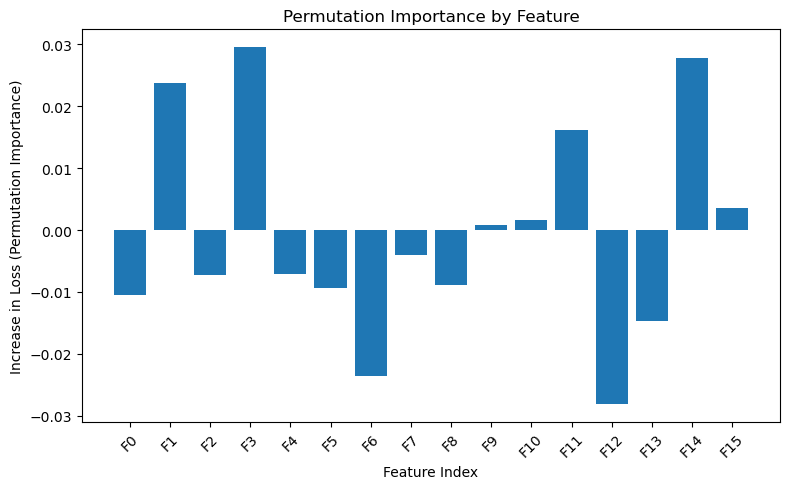

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


Saliency for each feature channel: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


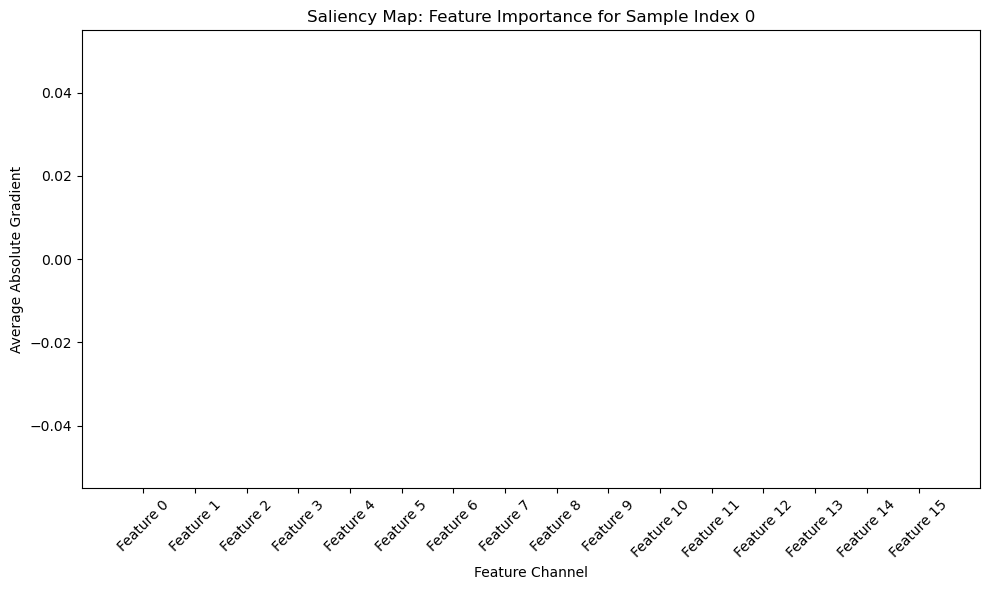

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Select one sample from your test set (for example, the first sample)
sample_index = 0
input_sample = tf.convert_to_tensor(input_test_scaled[sample_index:sample_index+1])  # shape: (1, 32, 32, 19)

# Use GradientTape to compute the gradient of the output with respect to the input
with tf.GradientTape() as tape:
    tape.watch(input_sample)
    # Forward pass: get the predicted probability (assuming model output is a sigmoid)
    prediction = model(input_sample)  # shape: (1, 1)
    # Optionally, if you wish to focus on a particular class, you can select that output.
    loss_value = prediction[0, 0]

# Compute the gradient of the prediction with respect to the input sample
grads = tape.gradient(loss_value, input_sample)  # shape: (1, 32, 32, 19)

# Compute the absolute gradients and average over the spatial dimensions to get per-channel saliency
saliency_per_channel = tf.reduce_mean(tf.abs(grads), axis=[1, 2])  # shape: (1, 19)
saliency_per_channel = saliency_per_channel.numpy().flatten()  # shape: (19,)

print("Saliency for each feature channel:", saliency_per_channel)

# Plot the saliency values for each of the 19 features
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(saliency_per_channel)), saliency_per_channel)
plt.xlabel("Feature Channel")
plt.ylabel("Average Absolute Gradient")
plt.title("Saliency Map: Feature Importance for Sample Index {}".format(sample_index))
plt.xticks(np.arange(len(saliency_per_channel)), [f"Feature {i}" for i in range(len(saliency_per_channel))], rotation=45)
plt.tight_layout()
plt.show()
